# Package initiation

In [1]:
%load_ext autoreload
%autoreload 2

import os
import re
import shutil
import random
import pprint
import itertools
import functools
import collections

import pysam
import pyranges as pr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats
import sklearn.cluster

import sys
sys.path.append('/home/users/pjh/scripts/python_genome_package_dev')

In [2]:
from handygenome import common
from handygenome.common import ChromDict, Interval
from handygenome.variant.vcfspec import Vcfspec

from handygenome.sv.breakends import Breakends
from handygenome.variant.variantplus import VariantPlus, VariantPlusList
from handygenome.igvhandle import IGVHandle

import handygenome.variant.filter as libfilter

In [3]:
FASTA_PATH_HG19 = common.DEFAULT_FASTA_PATHS['hg19']
FASTA_PATH_HG38 = common.DEFAULT_FASTA_PATHS['hg38']

FASTA_HG19 = common.DEFAULT_FASTAS['hg19']
FASTA_HG38 = common.DEFAULT_FASTAS['hg38']
CHROMDICT_HG19 = common.DEFAULT_CHROMDICTS['hg19']
CHROMDICT_HG38 = common.DEFAULT_CHROMDICTS['hg38']

# Scratches

In [604]:
vp = MAIN_DRIVER_VPLISTS['LU-87'][0]

In [606]:
vp.readstats

<ReadStatsSampledict(
    {'LU-14_panel': <ReadStats(
        {'rppcounts': {None: 18, -1: 5, 0: 958, 1: 1, 'softclip_overlap': 3},
         'mean_BQs': {None: 30.321428571428573,
                      -1: 31.0,
                      0: 32.766511007338224,
                      1: 9.0},
         'median_BQs': {None: 31.5, -1: 34.0, 0: 35.0, 1: 9.0},
         'mean_MQs': {None: 60.0, -1: 60.0, 0: 60.0, 1: 60.0},
         'median_MQs': {None: 60.0, -1: 60.0, 0: 60.0, 1: 60.0},
         'mean_cliplens': {None: 11.38888888888889,
                           -1: 0.0,
                           0: 0.2640918580375783,
                           1: 0.0},
         'median_cliplens': {None: 0.0, -1: 0.0, 0: 0.0, 1: 0.0},
         'varpos_uniform_pvalues': {None: 1.7892834551766394e-06,
                                    -1: 0.21236623541899002,
                                    0: 5.97852170127508e-14,
                                    1: 0.9668874172185431},
         'mean_varpos_fractions'

# Basic setups

In [4]:
SAMPLEIDS = [
    '14', '6', '87', 'F13', 'F2', 'F33', 'F37', 'FF1', 'FF104', 'FF115', 'FF13', 'FF18', 'FF20', 'FF21', 'FF23', 'FF24', 'FF27', 
    'FF3', 'FF31', 'FF34', 'FF37', 'FF39', 'FF4', 'FF43', 'FF53', 'FF56', 'FF57', 'FF58', 'FF6', 'FF62', 'FF67', 'FF71', 'FF76', 
    'FF77', 'FF78', 'FF79', 'FF80', 'FF85', 
    #'IO04',  # swapped sample
    'IO05', 'IO06', 'IO07', 'IO08', 'IO09', 'IO12', 'IO13', 'IO15', 'IO16', 'IO17', 
    'IO18', 'IO22', 'IO23', 'IO24', 'IO25', 'SC126', 'SC134', 'SC31', 'SC81', 'SC88', 'SC97', 'SC98', 
]
SAMPLEIDS_LU = [f'LU-{x}' for x in SAMPLEIDS]
SAMPLEIDS_LU_PANEL = [f'{x}_panel' for x in SAMPLEIDS_LU]
SAMPLEIDS_LU_TUMOR = [f'{x}_tumor' for x in SAMPLEIDS_LU]

BAM_TOPDIR = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/02_BAM/'
PANEL_REGION_PATH = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/metadata/panel_bait_design/custom/exon_intron_targetregions_merged.bed'
PANEL_REGION_EXONS_PATH = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/metadata/panel_bait_design/custom/SNUH_FIRST_Lung_Cancer_V5_exon_Regions_tracknamechanged.bed'
PANEL_REGION_INTRONS_PATH = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/metadata/panel_bait_design/custom/SNUH_FIRST_Lung_Cancer_V5_intron_Regions_tracknamechanged.bed'
WGS_TMB_PATH = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/metadata/wgs_TMB_previously_found_210312.txt'

ONCOKB_TOKEN = '864a64ee-cfa0-4b99-aa25-305fb4bcda39'

In [5]:
sampletype_filename_map = {
    'tumor': ['tumor'], 
    'normal': ['normal'], 
    'panel': ['panel'], 
    'rna': ['RNA', 'RNA_GFP'],
}
BAM_PATHS = {sampletype: dict() for sampletype in sampletype_filename_map.keys()}

for top, dirs, files in os.walk(BAM_TOPDIR):
    for f in files:
        for sampleid in SAMPLEIDS_LU:
            for sampletype, fname_portions in sampletype_filename_map.items():
                if f in (f'{sampleid}.{fname_portion}.bam' for fname_portion in fname_portions):
                    BAM_PATHS[sampletype][sampleid] = os.path.join(top, f)

In [490]:
BAMS = {
    sampletype: {
        sampleid: pysam.AlignmentFile(bampath) 
        for sampleid, bampath in bampathdic.items()
    }
    for sampletype, bampathdic in BAM_PATHS.items()
}

In [6]:
_sampleid_keys = ['LU-14', 'LU-6', 'LU-87', 'LU-F13', 'LU-F2', 'LU-F33', 'LU-F37', 'LU-FF1', 'LU-FF104', 'LU-FF115', 'LU-FF13', 'LU-FF18', 'LU-FF20', 'LU-FF21', 'LU-FF23', 'LU-FF24', 'LU-FF27', 'LU-FF3', 'LU-FF31', 'LU-FF34', 'LU-FF37', 'LU-FF39', 'LU-FF4', 'LU-FF43', 'LU-FF53', 'LU-FF56', 'LU-FF57', 'LU-FF58', 'LU-FF6', 'LU-FF62', 'LU-FF67', 'LU-FF71', 'LU-FF76', 'LU-FF77', 'LU-FF78', 'LU-FF79', 'LU-FF80', 'LU-FF85', 'LU-IO04', 'LU-IO05', 'LU-IO06', 'LU-IO07', 'LU-IO08', 'LU-IO09', 'LU-IO12', 'LU-IO13', 'LU-IO15', 'LU-IO16', 'LU-IO17', 'LU-IO18', 'LU-IO22', 'LU-IO23', 'LU-IO24', 'LU-IO25', 'LU-SC126', 'LU-SC134', 'LU-SC31', 'LU-SC81', 'LU-SC88', 'LU-SC97', 'LU-SC98',]

AGES = dict(zip(
    _sampleid_keys,
    [56, 72, 74, 62, 69, 49, 62, 79, 74, 48, 80, 78, 55, 58, 44, 68, 64, 77, 48, 72, 47, 31, 74, 80, 66, 67, 45, 48, 78, 73, 49, 49, 55, 70, 44, 71, 62, 50, 67, 74, 51, 67, 53, 75, 71, 58, 62, 56, 63, 70, 88, 54, 48, 59, 57, 60, 75, 58, 61, 50, 62],
))

PREVIOUS_PURITY = dict(zip(
    _sampleid_keys,
    [0.31, 0.16, 0.24, 0.75, 0.28, 0.5, 0.34, 0.17, 0.45, 0.43, 0.21, 0.86, 0.32, 0.37, 0.35, 0.5, 0.48, 0.2, 0.11, 0.19, 0.75, 0.21, 0.15, 0.34, 0.33, 0.37, 0.21, 0.14, 0.47, 0.52, 0.28, 0.11, 0.54, 0.27, 0.36, 0.36, 0.28, 0.24, 0.1, 0.36, 0.23, 0.24, 0.65, 0.31, 0.49, 0.69, 0.41, 0.32, 0.5, 0.42, 0.57, 0.11, 0.2, 0.28, 0.11, 0.4, 0.22, 0.4, 0.13, 0.15, 0.51,],
))

PREVIOUS_PLOIDY = dict(zip(
    _sampleid_keys,
    [2.6, 2.3, 2.7, 2.4, 1.9, 4.8, 1.9, 2.7, 2, 1.9, 2.9, 2.6, 4.5, 2.9, 2.8, 3.6, 2.1, 2.5, 2.3, 2, 2.4, 2, 2.6, 4.1, 5.7, 2.7, 3.45, 2.3, 2.1, 3.5, 2.2, 2.3, 2, 2.2, 2.9, 2, 2.2, 2.8, 2.1, 2.7, 2.4, 4.5, 2.3, 3.1, 3.5, 3.5, 5.3, 1.9, 3.3, 2.1, 2.9, 1.8, 4.4, 3.3, 2.4, 3.1, 3.7, 3.3, 1.6, 2.5, 1.9,],
))

MEAN_DEPTH_WGS_NORMAL = dict(zip(
    _sampleid_keys,
    [37.3767, 34.0972, 33.8064, 32.7928, 35.8954, 50.7577, 35.2345, 44.4876, 31.9701, 32.5393, 29.2703, 35.8483, 30.652, 30.3674, 30.7484, 37.0206, 32.9964, 32.02, 44.0783, 31.1997, 35.246, 25.3979, 27.8882, 32.5782, 32.0687, 29.2798, 35.0811, 31.21, 31.6326, 30.6922, 34.1979, 36.7596, 46.6577, 31.1763, 33.2672, 30.7369, 49.3219, 39.396, 50.6684, 47.5066, 42.1341, 50.5406, 61.0353, 48.3776, 47.3945, 47.8588, 53.5356, 50.1395, 51.1773, 48.859, 62.2889, 48.3631, 50.9241, 49.4595, 38.866, 48.8294, 60.0835, 39.58, 48.9517, 38.0445, 50.1143, ],
))

MEAN_DEPTH_WGS_TUMOR = dict(zip(
    _sampleid_keys,
    [33.8314, 28.6972, 39.9078, 31.2967, 35.1856, 50.3825, 32.995, 44.5512, 43.6843, 37.4389, 44.6266, 51.0667, 45.7373, 49.1081, 48.7203, 44.3134, 39.4903, 43.6447, 43.191, 46.8438, 32.9415, 43.3598, 47.5503, 48.4404, 47.5455, 42.8442, 36.943, 30.8365, 46.2036, 45.757, 46.2073, 41.2358, 32.9015, 38.2982, 37.7461, 35.5173, 47.0067, 50.212, 47.7919, 49.4914, 40.2729, 48.2904, 48.8819, 49.3573, 48.2809, 48.1625, 46.9765, 48.5246, 47.191, 57.4008, 45.9216, 61.224, 58.4995, 54.2237, 39.9667, 46.8006, 46.7105, 29.9816, 46.1059, 35.9943, 59.4945,],
))

MEAN_DEPTH_PANEL = dict(zip(
    _sampleid_keys,
    [925.555, 828.655, 1056.57, 949.034, 658.752, 943.504, 865.002, 1005.13, 1017.37, 928.113, 704.835, 1038.69, 841.098, 796.267, 861.94, 1199.86, 982.991, 622.94, 755.689, 883.229, 763.161, 994.175, 832.632, 886.978, 870.606, 940.946, 1123.63, 973.926, 867.741, 930.398, 983.845, 933.354, 992.087, 1019.04, 1027.85, 875.693, 860.521, 864.663, 934.823, 894.882, 1150.48, 866.108, 1018.39, 961.328, 1079.97, 792.767, 793.318, 362.512, 858.098, 1006.79, 1154.51, 837.199, 786.832, 1094.11, 689.674, 798.415, 1001.33, 1079.07, 760.339, 761.318, 880.314, ],
))

PANEL_ONTARGET_RATIO = dict(zip(
    _sampleid_keys,
    [0.911, 0.872, 0.79, 0.917, 0.838, 0.761, 0.701, 0.934, 0.924, 0.913, 0.696, 0.718, 0.85, 0.905, 0.87, 0.899, 0.879, 0.66, 0.783, 0.885, 0.761, 0.912, 0.789, 0.868, 0.63, 0.74, 0.808, 0.835, 0.891, 0.698, 0.914, 0.925, 0.922, 0.91, 0.923, 0.86, 0.822, 0.795, 0.758, 0.834, 0.88, 0.926, 0.924, 0.895, 0.869, 0.842, 0.72, 0.838, 0.798, 0.871, 0.91, 0.872, 0.826, 0.904, 0.858, 0.84, 0.881, 0.929, 0.806, 0.831, 0.867, ],
))

GENDER = dict(zip(
    _sampleid_keys,
    ['M', 'F', 'F', 'F', 'M', 'F', 'M', 'M', 'F', 'F', 'M', 'M', 'F', 'F', 'F', 'F', 'M', 'F', 'F', 'M', 'F', 'M', 'F', 'F', 'M', 'M', 'F', 'M', 'M', 'M', 'F', 'M', 'F', 'F', 'F', 'M', 'M', 'M', 'F', 'M', 'F', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'F', 'M', 'M', 'F', 'M', 'M', 'M', 'M', 'M', 'M', 'F', 'M',]
))

IO_RESPONSE = dict(zip(
    _sampleid_keys,
    [None, None, None, None, None, 'PD', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 'PD', None, 'SD', 'PR', 'SD', 'SD', 'PD', 'PD', 'PD', 'PR', 'PD', 'PD', 'SD', 'SD', 'PD', 'PR', 'PD', 'PR', None, 'PD', 'PD', None, 'SD', None, 'PD',]
))

SMOKING = dict(zip(
    _sampleid_keys,
    [False, False, False, False, True, None, False, True, False, False, True, None, False, False, False, False, None, False, None, True, False, None, False, False, True, True, False, True, None, True, False, True, False, False, False, True, None, True, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, True, None, None, True, None, False, None,]
))

IS_FEMALE = {key: (val == 'F') for key, val in GENDER.items()}

In [7]:
for _data in (AGES, PREVIOUS_PURITY, PREVIOUS_PLOIDY, MEAN_DEPTH_WGS_NORMAL, MEAN_DEPTH_WGS_TUMOR, MEAN_DEPTH_PANEL, PANEL_ONTARGET_RATIO, GENDER, IS_FEMALE):
    del _data['LU-IO04']

In [8]:
MEAN_DEPTH_PANEL_UNMATCHED = {
    'S10': 1029.98, 'S5': 1076.81, 'S6': 1081.72, 'S7': 1109.02, 'S8': 1077.46, 'S9': 1042.78
}

In [9]:
PANEL_REGION_EXONS_GR = pr.PyRanges(
    pd.read_csv(PANEL_REGION_EXONS_PATH, sep='\t', header=0, skiprows=2, names=['Chromosome', 'Start', 'End', 'gene'])
)
PANEL_REGION_INTRONS_GR = pr.PyRanges(
    pd.read_csv(PANEL_REGION_INTRONS_PATH, sep='\t', header=0, skiprows=2, names=['Chromosome', 'Start', 'End', 'gene'])
)

PANEL_REGION_GR = pr.read_bed(PANEL_REGION_PATH)
PANEL_REGION_GR_100bin = PANEL_REGION_GR.window(100)

In [10]:
WHOLE_GENOME_LENGTH = sum(x[1] for x in CHROMDICT_HG19.items() if common.RE_PATS['assembled_chromosome'].fullmatch(x[0]))  # 3_095_677_412
PANEL_REGION_LENGTH = PANEL_REGION_GR.merge().lengths().sum()  # 1_890_272

In [11]:
igv = IGVHandle(60387)

# Setup convenience functions

In [12]:
def load_bams(sampleid, load_rna=False, new=True):
    if new:
        igv.cmd('new')
    if load_rna:
        igv.load([
            BAM_PATHS['normal'][sampleid], 
            BAM_PATHS['tumor'][sampleid], 
            BAM_PATHS['panel'][sampleid],
            BAM_PATHS['rna'][sampleid],
            PANEL_REGION_PATH,
        ])
    else:
        igv.load([
            BAM_PATHS['normal'][sampleid], 
            BAM_PATHS['tumor'][sampleid], 
            BAM_PATHS['panel'][sampleid],
            PANEL_REGION_PATH,
        ])        

        
def load_bams_multisample(sampleids, normal=False, tumor=False, panel=False, rna=False, new=True):
    if new:
        igv.cmd('new')
        
    igv.load([PANEL_REGION_PATH])

    for sampleid in sampleids:
        if normal:
            igv.load([BAM_PATHS['normal'][sampleid]])
        if tumor:
            igv.load([BAM_PATHS['tumor'][sampleid]])
        if panel:
            igv.load([BAM_PATHS['panel'][sampleid]])
        if rna:
            igv.load([BAM_PATHS['rna'][sampleid]])
        
        
def show_vp_igv(vp, sampleid):
    igv.cmd('new')
    igv.load([PANEL_REGION_PATH, PANEL_REGION_EXONS_PATH, PANEL_REGION_INTRONS_PATH])
    load_bams(sampleid)

    igv.goto([vp.vcfspec], width=200)
    igv.cmd('viewaspairs')
    igv.cmd('sort base')

In [205]:
def set_ccfinfo(vplist, sampleid, cnv_seg, is_female, cellularity):
    for vp in vplist:
        vp.ccfinfo_panel = vp.get_ccf_CNm(cnv_seg, is_female, cellularity, f'{sampleid}_panel', allele_index=1)
        vp.ccfinfo_wgs = vp.get_ccf_CNm(cnv_seg, is_female, cellularity, f'{sampleid}_tumor', allele_index=1)
        joined_CNV_gr = vp.get_gr().join(pr.PyRanges(cnv_seg))
        if joined_CNV_gr.df.shape[0] == 0:
            vp.CNcalls = None
        else:
            joined_CNV_gr_row = joined_CNV_gr.df.iloc[0, :]
            vp.CNcalls = {'CNt': joined_CNV_gr_row['CNt'], 'A': joined_CNV_gr_row['A'], 'B': joined_CNV_gr_row['B']}

In [14]:
def iterate_all_values(obj):
    if isinstance(obj, dict):
        for x in itertools.chain.from_iterable(
            iterate_all_values(val) for val in obj.values()
        ):
            yield x
    elif isinstance(obj, list):
        for x in itertools.chain.from_iterable(
            iterate_all_values(val) for val in obj
        ):
            yield x
    else:
        yield obj

        
def check_including_word(obj, word):
    for x in iterate_all_values(obj):
        if isinstance(x, str):
            if re.search(word, x, re.IGNORECASE):
                return True
    return False

        
def check_lung_related(vp):
    return check_including_word(vp.oncokb[0], 'lung')


def check_present_wgs(vp, sid, rppcount=3):
    return vp.readstats[sid + '_tumor']['rppcounts'][1] >= rppcount


def check_present_panel(vp, sid, rppcount=3):
    return vp.readstats[sid + '_panel']['rppcounts'][1] >= rppcount


def check_targetable(vp):
    oncokb_data = vp.oncokb[0]
    return (
        (oncokb_data['highestSensitiveLevel'] is not None)
        or (oncokb_data['highestResistanceLevel'] is not None)
    )

In [15]:
def get_altcount_wgs(vp, sid):
    return vp.readstats[sid + '_tumor']['rppcounts'][1]


def get_altcount_panel(vp, sid):
    if vp.get_gr().intersect(PANEL_REGION_GR).empty:
        return 0
    else:
        return vp.readstats[sid + '_panel']['rppcounts'][1]

# Panel design information

In [295]:
print('Exon region length:', PANEL_REGION_EXONS_GR.merge().lengths().sum())
print('Intron region length:', PANEL_REGION_INTRONS_GR.merge().lengths().sum())
print('Total region length:', PANEL_REGION_LENGTH)
print('Panel region ratio:', (PANEL_REGION_LENGTH / WHOLE_GENOME_LENGTH))

Exon region length: 692881
Intron region length: 1225357
Total region length: 1890272
Panel region ratio: 0.0006106165948275492


In [296]:
WHOLE_GENOME_LENGTH / PANEL_REGION_LENGTH

1637.688868057084

In [93]:
import handygenome.pyranges_helper as pyranges_helper

exon_intron_concat = pr.concat([PANEL_REGION_EXONS_GR, PANEL_REGION_INTRONS_GR])
exon_intron_concat.Chromosome = [re.sub('^chr', '', x) for x in exon_intron_concat.Chromosome]
PANEL_REGION_GR_WITHGENE = pyranges_helper.join(
    PANEL_REGION_GR, exon_intron_concat,
    how='left', merge='longest', sort=True, refver='hg19', as_gr=True,
)
PANEL_REGION_GR_WITHGENE._length = PANEL_REGION_GR_WITHGENE.lengths()

In [105]:
lengthsums_bygene = dict()
for chrom, subdf in PANEL_REGION_GR_WITHGENE.items():
    lengthsums_bygene[chrom] = subdf.groupby('gene')[['_length']].sum().to_dict()['_length']

In [255]:
sorted_chroms = CHROMDICT_HG19.sort_chrompos(tuple(lengthsums_bygene.keys()))

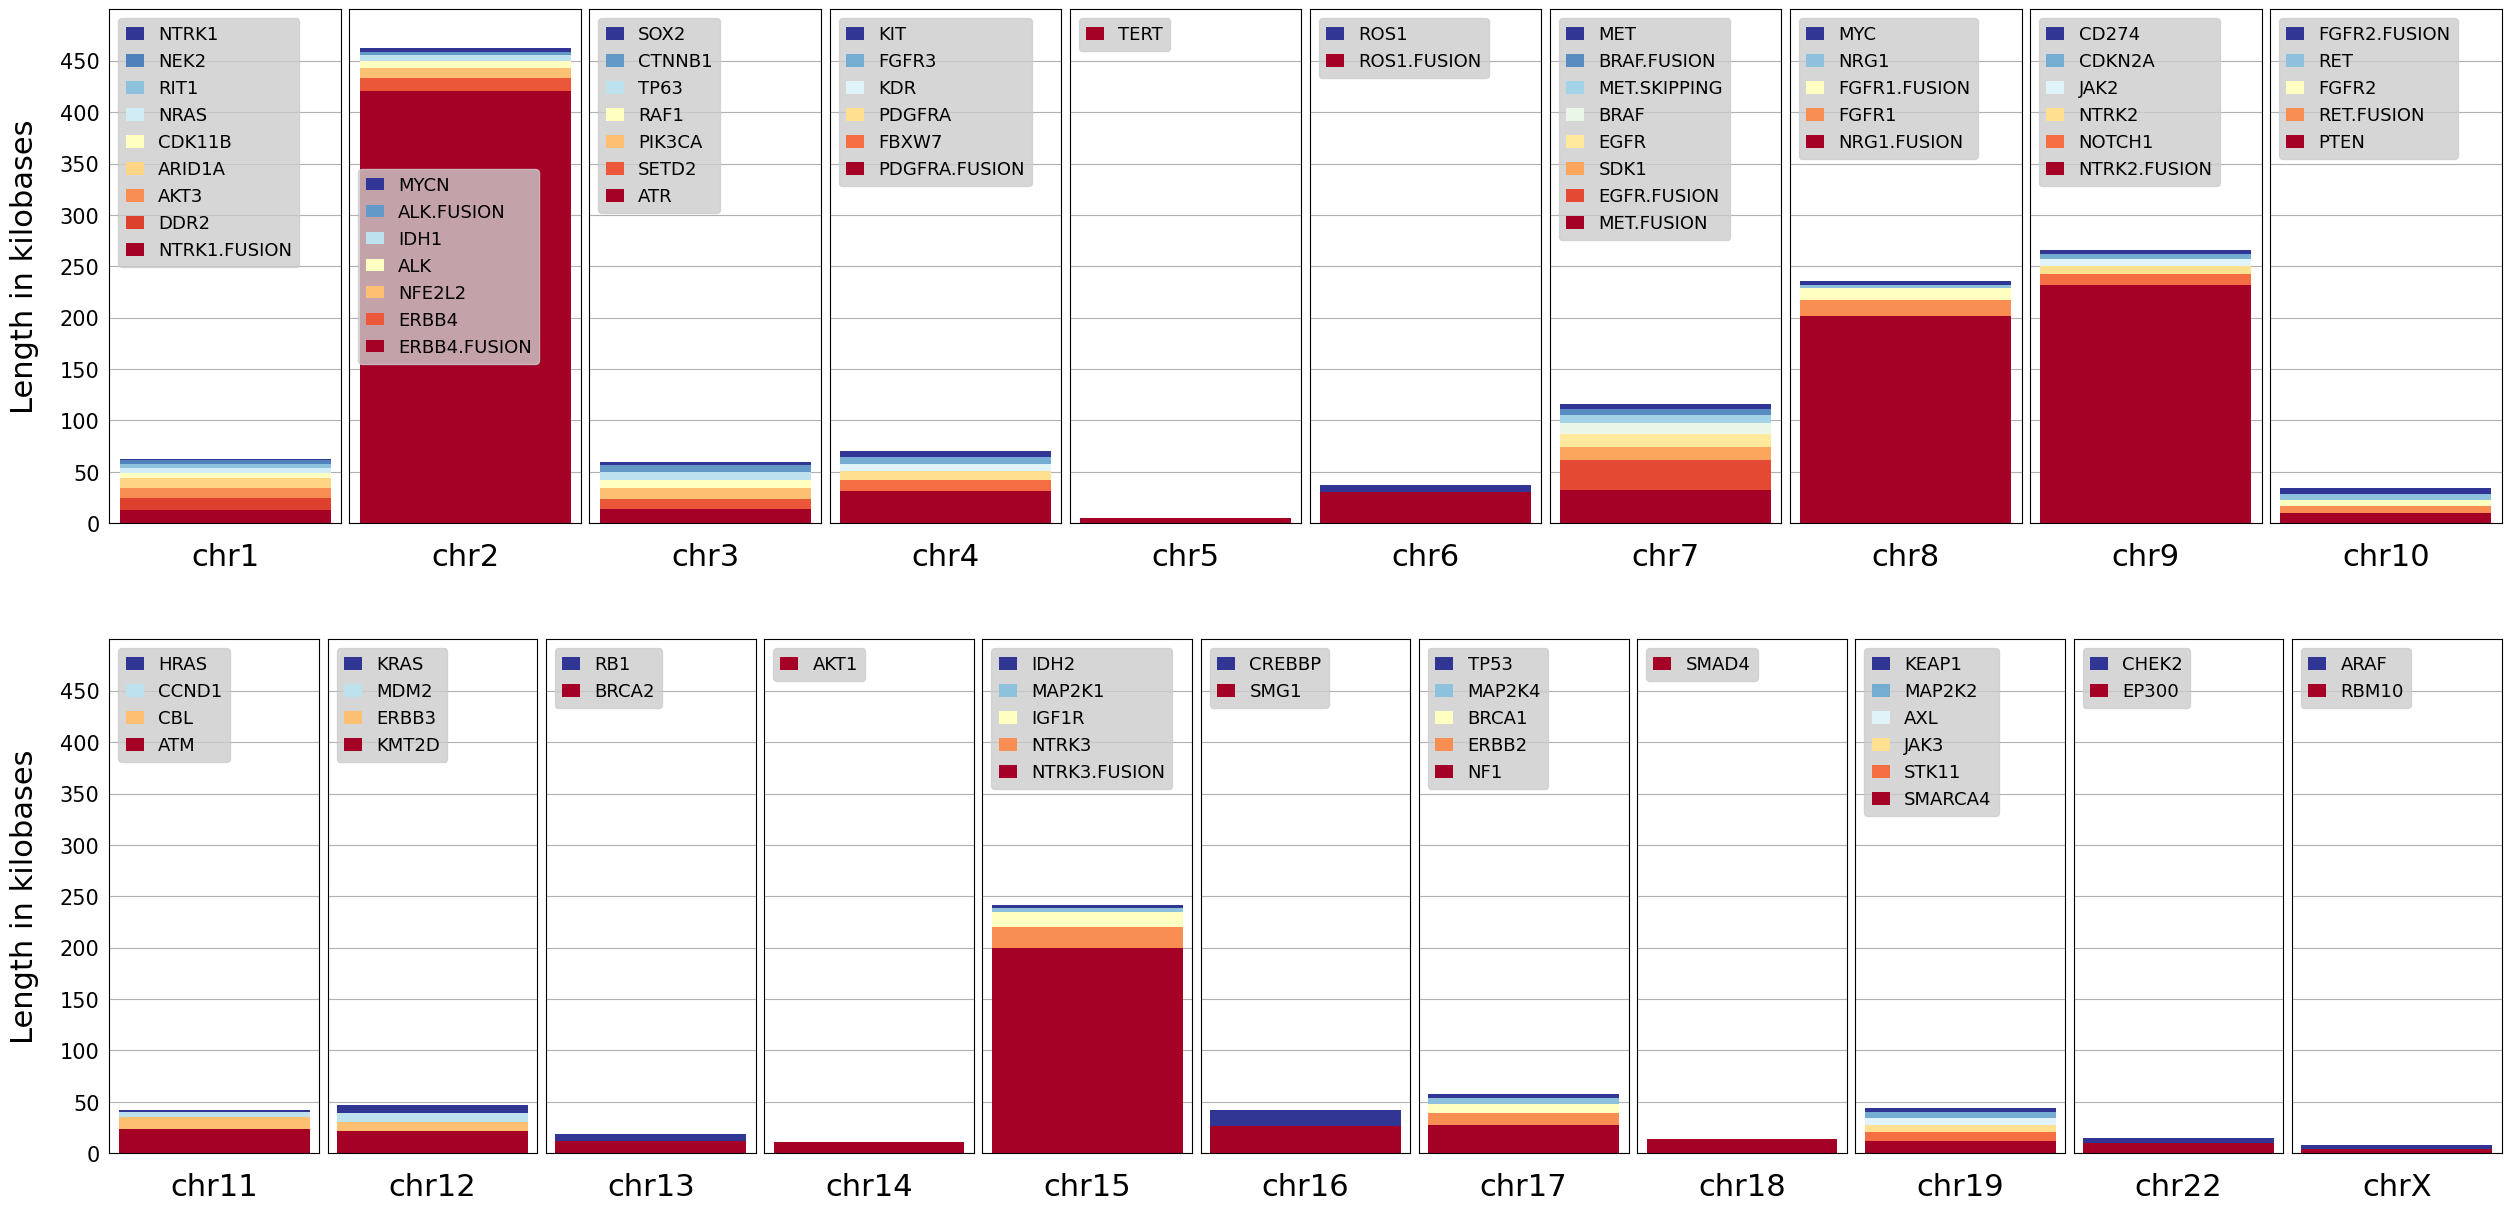

In [286]:
# ymax = max(tuple(sum(x.values()) for x in lengthsums_bygene.values()))
ymax = 500_000

lengthsums_bygene_subset_list = [
    {k: lengthsums_bygene[k] for k in sorted_chroms[:10]},
    {k: lengthsums_bygene[k] for k in sorted_chroms[10:]},
]

fig = plt.figure(figsize=(25, 12), layout='constrained')
subfig_list = fig.subfigures(2, 1, hspace=0.1)

def draw(subfig, lengthsums_bygene_subset):
    axs = subfig.subplots(
        1, len(lengthsums_bygene_subset), 
        gridspec_kw=dict(wspace=0), 
        subplot_kw=dict(ylim=(0, ymax), yticks=np.arange(0, ymax, 50_000)),
    )

    axs[0].set_ylabel('Length in kilobases', fontsize=22, labelpad=15)
    axs[0].set_yticklabels((axs[0].get_yticks() / 1000).astype(int), fontsize=15)
    for ax in axs[1:]:
        ax.set_yticklabels([])

    for chrom, ax in zip(
        CHROMDICT_HG19.sort_chrompos(tuple(lengthsums_bygene_subset.keys())), axs,
    ):
        genes, lengths = zip(*sorted(lengthsums_bygene_subset[chrom].items(), key=(lambda x: x[1]), reverse=True))
        lengths = np.array(lengths)
        bottoms = lengths.cumsum() - lengths
        colors = plt.colormaps['RdYlBu'](np.linspace(0, 1, len(lengths)))
        rects = ax.bar(x=0, height=lengths, bottom=bottoms, label=genes, color=colors)

        legend_loc_kw = (
            dict(loc='center left')
            if chrom == '2' else
            dict(loc='upper left')
        )
        ax.legend(
            handles=rects[::-1], 
            handlelength=1,
            facecolor='0.8',
            fontsize=13,
            **legend_loc_kw,
        )

        ax.tick_params(left=False)
        
        ax.set_xlabel('chr' + chrom, fontsize=22, labelpad=10)
        ax.set_xticks([])

        ax.set_axisbelow(True)
        ax.grid(zorder=0)
        
for subfig, subdata in zip(subfig_list, lengthsums_bygene_subset_list):
    draw(subfig, subdata)

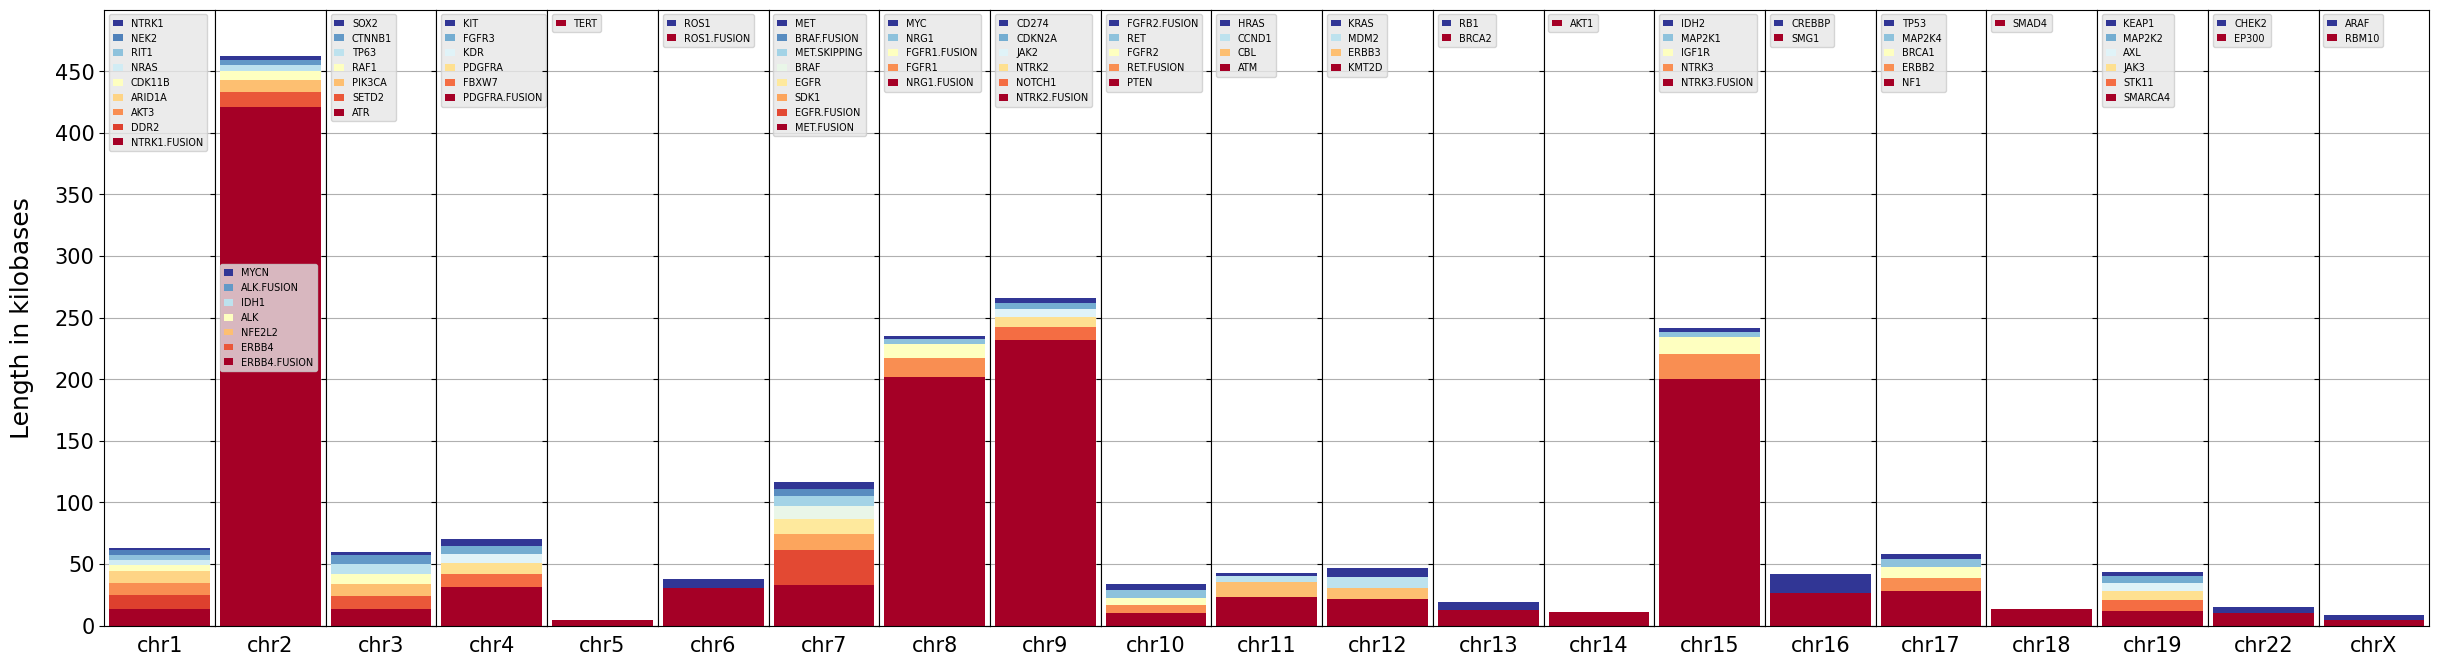

In [267]:
# ymax = max(tuple(sum(x.values()) for x in lengthsums_bygene.values()))
ymax = 500_000
fig, axs = plt.subplots(
    1, len(lengthsums_bygene), 
    figsize=(30, 8), 
    gridspec_kw=dict(wspace=0), 
    subplot_kw=dict(ylim=(0, ymax), yticks=np.arange(0, ymax, 50_000)),
)

axs[0].set_ylabel('Length in kilobases', fontsize=18, labelpad=15)
axs[0].set_yticklabels((axs[0].get_yticks() / 1000).astype(int), fontsize=15)
for ax in axs[1:]:
    ax.set_yticklabels([])
    
for chrom, ax in zip(
    CHROMDICT_HG19.sort_chrompos(tuple(lengthsums_bygene.keys())), axs,
):
    genes, lengths = zip(*sorted(lengthsums_bygene[chrom].items(), key=(lambda x: x[1]), reverse=True))
    lengths = np.array(lengths)
    bottoms = lengths.cumsum() - lengths
    colors = plt.colormaps['RdYlBu'](np.linspace(0, 1, len(lengths)))
    rects = ax.bar(x=0, height=lengths, bottom=bottoms, label=genes, color=colors)

    legend_loc_kw = (
        dict(loc='center left')
        if chrom == '2' else
        dict(loc='upper left')
    )
    ax.legend(
        handles=rects[::-1], 
        fontsize=7,
        handlelength=1,
        facecolor='0.9',
        **legend_loc_kw,
    )
    
    ax.set_xlabel('chr' + chrom, fontsize=15)
    ax.set_xticks([])
    
    ax.set_axisbelow(True)
    ax.grid(zorder=0)

# Set SV driver dict

In [16]:
SVdrivers = {sampleid: list() for sampleid in SAMPLEIDS_LU}
SVdrivers.update(
    {
        'LU-14': [('ALK', 'EML4')],
        'LU-6': [('ALK', 'EML4')],
        'LU-F13': [('AXL', 'MBIP')],
        'LU-F2': [('ROS1', 'CCDC6')],
        'LU-F37': [('KIF5B', 'RET')],
        'LU-FF37': [('ALK', 'EML4')],
        'LU-FF56': [('ZNF33B', 'RET')],
        'LU-FF57': [('KIF5B', 'RET')],
        'LU-FF58': [('CD74', 'ROS1')],
        'LU-FF71': [('CD47', 'MET')],
        'LU-FF76': [('KIF5B', 'RET')],
        'LU-FF77': [('KIF5B', 'RET'), ('FRMD4A', 'RET')],
        'LU-IO08': [('RET', 'CCDC6')],
        'LU-SC126': [('CD74', 'ROS1')],
        'LU-SC81': [('KIF5B', 'RET')],
        'LU-SC97': [('KIF5B', 'RET')],
        'LU-SC98': [('CD74', 'NRG1')],
    }
)

# Set data file paths

### Copynumber

##### extract, fit file paths

In [16]:
import re

SEQUENZA_TOPDIR = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/05_sequenza'

EXTRACT_PATHS = dict()
FIT_PATHS = dict()

for top, dirs, files in os.walk(SEQUENZA_TOPDIR):
    for f in files:
        if re.search(r'_extract\.', f):
            sampleid = 'LU-' + f.split('_')[0]
            if sampleid in SAMPLEIDS_LU:
                EXTRACT_PATHS[sampleid] = os.path.join(top, f)
        if re.search(r'_cp_table\.', f):
            sampleid = 'LU-' + f.split('_')[0]
            if sampleid in SAMPLEIDS_LU:
                FIT_PATHS[sampleid] = os.path.join(top, f)
                

##### depth file paths

In [17]:
import re

DEPTH_TOPDIR = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/23_binned_depths/results'
TUMOR_DEPTH_PATHS = dict()
NORMAL_DEPTH_PATHS = dict()

for top, dirs, files in os.walk(DEPTH_TOPDIR):
    for f in files:
        if f.endswith('regions.bed.gz'):
            sampleid = f.split('.')[0]
            if sampleid in SAMPLEIDS_LU:
                if 'normal' in f:
                    NORMAL_DEPTH_PATHS[sampleid] = os.path.join(top, f)
                if 'tumor' in f:
                    TUMOR_DEPTH_PATHS[sampleid] = os.path.join(top, f)


##### panel bam germline vcf paths

In [18]:
PANEL_GERMLINE_VCF_PATHS = dict()
topdir = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/20_haplotypecaller_panelbamonly/filtered_germline_hets'
for fname in os.listdir(topdir):
    if fname.endswith('vcf.gz'):
        sid = fname.split('.')[0]
        PANEL_GERMLINE_VCF_PATHS[sid] = os.path.join(topdir, fname)

### Delly VCF path

In [112]:
import os

DELLY_TOPDIR = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/04_delly'
DELLY_DEL_PATHS_WGS = dict()
for sampleid in SAMPLEIDS_LU:
    sid_wo_LU = sampleid[3:]
    panel_topdir = os.path.join(DELLY_TOPDIR, f'{sid_wo_LU}.panel')
    wgs_topdir = os.path.join(DELLY_TOPDIR, f'{sid_wo_LU}.tumor')
    for top, dirs, files in os.walk(wgs_topdir):
        for fname in files:
            if (fname.endswith('DEL.bcf') or fname.endswith('DEL.bcf.gz')) and ('interval' not in fname):
                DELLY_DEL_PATHS_WGS[sampleid] = os.path.join(top, fname)
    

# Create and save segment dfs

In [19]:
SEGMENTS_TOPDIR = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/26_cnv_segments/final'

In [20]:
from handygenome.cnv import sequenza_handler

CNV_SEGMENTS = dict()

for sampleid in SAMPLEIDS_LU:
    print(sampleid)
    cellularity = PREVIOUS_PURITY[sampleid]
    ploidy = PREVIOUS_PLOIDY[sampleid]
    is_female = IS_FEMALE[sampleid]
    extractfile_path = EXTRACT_PATHS[sampleid]
    seg_df = sequenza_handler.make_segments_as_df(extractfile_path, cellularity, ploidy, is_female)
    CNV_SEGMENTS[sampleid] = seg_df
    
for sampleid, df in CNV_SEGMENTS.items():
    df.to_csv(os.path.join(SEGMENTS_TOPDIR, f'{sampleid}_segments.tsv.gz'), sep='\t', index=False)

LU-14
LU-6
LU-87
LU-F13
LU-F2
LU-F33
LU-F37
LU-FF1
LU-FF104
LU-FF115
LU-FF13
LU-FF18
LU-FF20
LU-FF21
LU-FF23
LU-FF24
LU-FF27
LU-FF3
LU-FF31
LU-FF34
LU-FF37
LU-FF39
LU-FF4
LU-FF43
LU-FF53
LU-FF56
LU-FF57
LU-FF58
LU-FF6
LU-FF62
LU-FF67
LU-FF71
LU-FF76
LU-FF77
LU-FF78
LU-FF79
LU-FF80
LU-FF85
LU-IO05
LU-IO06
LU-IO07
LU-IO08
LU-IO09
LU-IO12
LU-IO13
LU-IO15
LU-IO16
LU-IO17
LU-IO18
LU-IO22
LU-IO23
LU-IO24
LU-IO25
LU-SC126
LU-SC134
LU-SC31
LU-SC81
LU-SC88
LU-SC97
LU-SC98


# Load segments dfs

In [192]:
from handygenome.cnv.sequenza_handler import read_sequenza_segment

SEGMENTS_TOPDIR = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/26_cnv_segments/final'
CNV_SEGMENT_PATHS = dict()
for f in os.listdir(SEGMENTS_TOPDIR):
    sampleid = f.split('_')[0]
    assert sampleid in SAMPLEIDS_LU
    CNV_SEGMENT_PATHS[sampleid] = os.path.join(SEGMENTS_TOPDIR, f)

CNV_SEGMENTS = {sampleid: read_sequenza_segment(path) for sampleid, path in CNV_SEGMENT_PATHS.items()}

# Load curated non-SV drivers

In [481]:
filtered_driver_set_topdir = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/21_driver_summary/filtered_vcfs_drivergene_damaging/'
merged_driver_withAllPanelGenes_vplists = dict()
for f in os.listdir(filtered_driver_set_topdir):
    if f.endswith('vcf.gz'):
        sampleid = f.split('_')[0]
        merged_driver_withAllPanelGenes_vplists[sampleid] = VariantPlusList.from_vcf(
            os.path.join(filtered_driver_set_topdir, f),
            init_all_attrs=True,
        )

In [482]:
# for sid, vplist in merged_driver_withAllPanelGenes_vplists.items():
#     set_ccfinfo(vplist, sid, CNV_SEGMENTS[sid], IS_FEMALE[sid], PREVIOUS_PURITY[sid])

In [483]:
ONCOGENIC_DRIVERS = dict()
for sampleid, vplist in merged_driver_withAllPanelGenes_vplists.items():
    new_vplist = VariantPlusList(refver='hg19')
    for vp in vplist:
        if vp.oncokb[0]['oncogenic'] in ('Likely Oncogenic', 'Oncogenic'):
            new_vplist.append(vp)
    ONCOGENIC_DRIVERS[sampleid] = new_vplist

# Load newly annotated previous wgs vcf files

In [17]:
# PREVIOUS_WGS_REANNOT_TOPDIR = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/09_short_variants_union/previous_wgs_results/feature_annot_220810'
PREVIOUS_WGS_REANNOT_TOPDIR = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/09_short_variants_union/previous_wgs_results/reannot_220914/'
PREVIOUS_WGS_REANNOT_VCF_PATHS_SNV = dict()
PREVIOUS_WGS_REANNOT_VCF_PATHS_INDEL = dict()

for fname in os.listdir(PREVIOUS_WGS_REANNOT_TOPDIR):
    if fname.endswith('.annot.readstats.oncokb.vcf.gz'):
        sampleid = fname.split('.')[0]
        if 'snv' in fname:
            PREVIOUS_WGS_REANNOT_VCF_PATHS_SNV[sampleid] = os.path.join(PREVIOUS_WGS_REANNOT_TOPDIR, fname)
        elif 'indel' in fname:
            PREVIOUS_WGS_REANNOT_VCF_PATHS_INDEL[sampleid] = os.path.join(PREVIOUS_WGS_REANNOT_TOPDIR, fname)

In [18]:
PREVIOUS_WGS_REANNOT_VCF_SNV = dict()
PREVIOUS_WGS_REANNOT_VCF_INDEL = dict()

for key, val in PREVIOUS_WGS_REANNOT_VCF_PATHS_SNV.items():
    print('snv', key)
    PREVIOUS_WGS_REANNOT_VCF_SNV[key] = VariantPlusList.from_vcf(val, logging_lineno=None, init_all_attrs=False)

for key, val in PREVIOUS_WGS_REANNOT_VCF_PATHS_INDEL.items():
    print('indel', key)
    PREVIOUS_WGS_REANNOT_VCF_INDEL[key] = VariantPlusList.from_vcf(val, logging_lineno=None, init_all_attrs=False)

snv LU-FF115
snv LU-FF79
snv LU-FF76
snv LU-IO25
snv LU-FF3
snv LU-IO16
snv LU-SC97
snv LU-IO24
snv LU-FF85
snv LU-FF58
snv LU-SC31
snv LU-FF27
snv LU-F33
snv LU-87
snv LU-SC88
snv LU-FF78
snv LU-FF24
snv LU-FF37
snv LU-IO06
snv LU-IO12
snv LU-FF71
snv LU-SC98
snv LU-FF4
snv LU-FF6
snv LU-IO17
snv LU-FF13
snv LU-F37
snv LU-SC134
snv LU-FF67
snv LU-IO18
snv LU-14
snv LU-F13
snv LU-FF23
snv LU-SC126
snv LU-FF62
snv LU-FF1
snv LU-FF43
snv LU-FF80
snv LU-IO08
snv LU-IO09
snv LU-FF20
snv LU-FF56
snv LU-FF77
snv LU-FF39
snv LU-IO13
snv LU-IO15
snv LU-FF18
snv LU-IO22
snv LU-6
snv LU-F2
snv LU-IO07
snv LU-FF21
snv LU-IO23
snv LU-FF57
snv LU-IO05
snv LU-FF34
snv LU-FF53
snv LU-SC81
snv LU-FF31
snv LU-FF104
indel LU-FF78
indel LU-F33
indel LU-FF85
indel LU-F13
indel LU-IO24
indel LU-6
indel LU-FF43
indel LU-FF18
indel LU-IO23
indel LU-FF56
indel LU-FF1
indel LU-F37
indel LU-IO15
indel LU-FF37
indel LU-FF27
indel LU-FF80
indel LU-IO25
indel LU-IO22
indel LU-IO18
indel LU-FF62
indel LU-87
indel L

# Load panel VCFs

In [19]:
PANEL_VCF_SNV_PATH = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/09_short_variants_union/220531/06_panel_union_annotation_again2/panel_snv_union.annot.readstats.popfreq_cosmic.oncokb.vcf.gz'
PANEL_VCF_INDEL_PATH = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/09_short_variants_union/220707_indel/03_union_reannot/panel_indel_union.annot.readstats.popfreq_cosmic.oncokb.vcf.gz'

PANEL_INDEL_VPLIST = VariantPlusList.from_vcf(PANEL_VCF_INDEL_PATH, init_all_attrs=True)
PANEL_SNV_VPLIST = VariantPlusList.from_vcf(PANEL_VCF_SNV_PATH, init_all_attrs=True)

[KST 2023-06-14 22:39:29.498] VariantPlusList: Processing 1,000th line
[KST 2023-06-14 22:39:53.333] VariantPlusList: Processing 2,000th line
[KST 2023-06-14 22:40:34.515] VariantPlusList: Processing 1,000th line
[KST 2023-06-14 22:40:57.592] VariantPlusList: Processing 2,000th line


KeyboardInterrupt: 

In [12]:
oncogenic_classes = set()
for vp in PANEL_SNV_VPLIST:
    oncogenic_classes.add(vp.oncokb[0]['oncogenic'])
oncogenic_classes

{'Inconclusive', 'Likely Neutral', 'Likely Oncogenic', 'Oncogenic', 'Unknown'}

In [13]:
oncogenic_genes = set()
for vp in PANEL_SNV_VPLIST:
    if vp.oncokb[0]['oncogenic'] in ('Oncogenic', 'Likely Oncogenic'):
        oncogenic_genes.update(vp.get_gene_names(coding=True))

In [669]:
relevant_vps = list()
for vp in PANEL_SNV_VPLIST:
    if vp.oncokb[0]['oncogenic'] in ('Oncogenic', 'Likely Oncogenic'):
        if 'NOTCH1' in vp.get_gene_names(coding=True):
            relevant_vps.append(vp)
            
print(len(relevant_vps))

3


# Setup filters

In [15]:
fi_popfreq = libfilter.PopfreqFilter(cutoff=0.01, popnames=("GnomAD", "1000Genomes", "KOREAN", "Korea1K"))
fi_diffBQ = libfilter.DiffMeanBQFilter(cutoff=-5)
fi_BQ = libfilter.AbsMeanBQFilter(cutoff=20)
fi_diffMQ = libfilter.DiffMeanMQFilter(cutoff=-15)
fi_MQ = libfilter.AbsMeanMQFilter(cutoff=40)
fi_clipovlp = libfilter.ClipoverlapFilter(cutoff=1)
fi_varposunif = libfilter.VarposUniformFilter(cutoff=0.05)
fi_readcount = libfilter.ReadcountFilter(cutoff=5)
fi_otherratio = libfilter.OthercountRatioFilter(cutoff=1.5)

ponfilter_params = {
    'min_germline_vaf': 0.2,
    'germline_sample_ratio_cutoff': 0.1,
    'lowest_subset_fraction': 0.7,
    'lowest_subset_num_cutoff': 10,
    'lowest_subset_snr_cutoff': 10,
    'nearby_ratio': 3,
    'nearby_subset_num_cutoff': 5,
    'nearby_subset_snr_cutoff': 3,
    'mode': "mean",        
}
fi_pon = libfilter.PonFilterPanelseq(samples=SAMPLEIDS_LU_PANEL, **ponfilter_params)

def allfilter(vp, sampleid):
    # pon_sampleids = SAMPLEIDS_LU_PANEL
    # fi_pon = vp.get_ponfilter(sampleids=pon_sampleids, **ponfilter_params)
    mask_all = all([
        fi_pon.check(vp, sampleid),
        fi_popfreq.check(vp),
        fi_diffBQ.check(vp, sampleid),
        fi_BQ.check(vp, sampleid),
        fi_diffMQ.check(vp, sampleid),
        fi_MQ.check(vp, sampleid),
        fi_clipovlp.check(vp, sampleid),
        fi_readcount.check(vp, sampleid),
        (
            len(vp.vcfspec.ref) >= 4 or
            fi_otherratio.check(vp, sampleid)
        ),
    ])
    
    return mask_all

# Save filtered panel mutation sets

In [474]:
PON_SAMPLES = [sid + '_panel' for sid in SAMPLEIDS_LU]


def get_bait_margin_distance(vp, panel_region_gr):
    nearest_gr = vp.get_gr().nearest(panel_region_gr)
    return min(abs(nearest_gr.Start_b[0] - vp.start0), abs(nearest_gr.End_b[0] - vp.start0))


def get_vpfilter(sid, margin_distance=None, **kwargs):
    sid_panel = sid + '_panel'    
    tpsfilter = libfilter.get_preset_filter_panelseq(pon_samples=PON_SAMPLES, refver='hg19', **kwargs)

    if margin_distance is None:
        def vpfilter(vp):
            return tpsfilter.check(vp, sid_panel)
    else:
        def vpfilter(vp):
            return (
                tpsfilter.check(vp, sid_panel)
                and (get_bait_margin_distance(vp, PANEL_REGION_GR) > margin_distance)
            )
        
    return vpfilter

In [475]:
filtered_panel_vplists = {'snv': dict(), 'indel': dict()}

for sampleid in SAMPLEIDS_LU:
    print(sampleid)

    vpfilter = get_vpfilter(sampleid, margin_distance=50, ponfilter_kwargs=dict(lower_ratio=50))
    filtered_panel_vplists['snv'][sampleid] = PANEL_SNV_VPLIST.filter(vpfilter)
    filtered_panel_vplists['indel'][sampleid] = PANEL_INDEL_VPLIST.filter(vpfilter)

LU-14
LU-6
LU-87
LU-F13
LU-F2
LU-F33
LU-F37
LU-FF1
LU-FF104
LU-FF115
LU-FF13
LU-FF18
LU-FF20
LU-FF21
LU-FF23
LU-FF24
LU-FF27
LU-FF3
LU-FF31
LU-FF34
LU-FF37
LU-FF39
LU-FF4
LU-FF43
LU-FF53
LU-FF56
LU-FF57
LU-FF58
LU-FF6
LU-FF62
LU-FF67
LU-FF71
LU-FF76
LU-FF77
LU-FF78
LU-FF79
LU-FF80
LU-FF85
LU-IO05
LU-IO06
LU-IO07
LU-IO08
LU-IO09
LU-IO12
LU-IO13
LU-IO15
LU-IO16
LU-IO17
LU-IO18
LU-IO22
LU-IO23
LU-IO24
LU-IO25
LU-SC126
LU-SC134
LU-SC31
LU-SC81
LU-SC88
LU-SC97
LU-SC98


In [476]:
filtered_panel_variants_topdir = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/09_short_variants_union/filtered_panel_variants'
for sid, vplist in filtered_panel_vplists['snv'].items():
    vplist.write(os.path.join(filtered_panel_variants_topdir, f'{sid}_snv.vcf.gz'))
for sid, vplist in filtered_panel_vplists['indel'].items():
    vplist.write(os.path.join(filtered_panel_variants_topdir, f'{sid}_indel.vcf.gz'))

# Load filtered panel mutation sets

In [206]:
filtered_panel_variants_topdir = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/09_short_variants_union/filtered_panel_variants'
filtered_panel_vplists_snv = dict()
filtered_panel_vplists_indel = dict()
for fname in os.listdir(filtered_panel_variants_topdir):
    if not fname.endswith('.vcf.gz'):
        continue
        
    print(fname)
    sid = fname.split('_')[0]
    abspath = os.path.join(filtered_panel_variants_topdir, fname)
    if 'snv' in fname:
        vplist = VariantPlusList.from_vcf(abspath, init_all_attrs=True)
        set_ccfinfo(vplist, sid, CNV_SEGMENTS[sid], IS_FEMALE[sid], PREVIOUS_PURITY[sid])
        filtered_panel_vplists_snv[sid] = vplist
    elif 'indel' in fname:
        vplist = VariantPlusList.from_vcf(abspath, init_all_attrs=True)
        set_ccfinfo(vplist, sid, CNV_SEGMENTS[sid], IS_FEMALE[sid], PREVIOUS_PURITY[sid])
        filtered_panel_vplists_indel[sid] = vplist

LU-FF3_snv.vcf.gz
LU-FF57_snv.vcf.gz
LU-FF3_indel.vcf.gz
LU-FF104_indel.vcf.gz
LU-SC97_snv.vcf.gz
LU-IO06_indel.vcf.gz
LU-FF57_indel.vcf.gz
LU-IO24_snv.vcf.gz
LU-F37_indel.vcf.gz
LU-FF24_indel.vcf.gz
LU-FF53_indel.vcf.gz
LU-FF13_snv.vcf.gz
LU-SC81_indel.vcf.gz
LU-FF58_snv.vcf.gz
LU-FF6_indel.vcf.gz
LU-IO08_indel.vcf.gz
LU-SC126_indel.vcf.gz
LU-FF1_snv.vcf.gz
LU-IO13_indel.vcf.gz
LU-IO22_indel.vcf.gz
LU-FF20_indel.vcf.gz
LU-FF37_snv.vcf.gz
LU-F2_indel.vcf.gz
LU-F2_snv.vcf.gz
LU-FF58_indel.vcf.gz
LU-FF31_snv.vcf.gz
LU-87_snv.vcf.gz
LU-IO12_indel.vcf.gz
LU-IO18_snv.vcf.gz
LU-F33_indel.vcf.gz
LU-FF23_indel.vcf.gz
LU-FF85_snv.vcf.gz
LU-6_indel.vcf.gz
LU-SC88_indel.vcf.gz
LU-FF62_indel.vcf.gz
LU-FF21_indel.vcf.gz
LU-FF24_snv.vcf.gz
LU-F13_snv.vcf.gz
LU-FF71_snv.vcf.gz
LU-IO22_snv.vcf.gz
LU-FF4_indel.vcf.gz
LU-IO12_snv.vcf.gz
LU-FF62_snv.vcf.gz
LU-IO07_indel.vcf.gz
LU-IO05_indel.vcf.gz
LU-FF56_snv.vcf.gz
LU-FF21_snv.vcf.gz
LU-FF76_indel.vcf.gz
LU-IO25_snv.vcf.gz
LU-FF18_indel.vcf.gz
LU-FF79_s

# Contamination check

In [39]:
all_vcfspecs_counter_snv = collections.Counter(
    itertools.chain.from_iterable(
        (vp.vcfspec for vp in vplist)
        for vplist in filtered_panel_vplists['snv'].values()
    )
)

all_vcfspecs_counter_indel = collections.Counter(
    itertools.chain.from_iterable(
        (vp.vcfspec for vp in vplist)
        for vplist in filtered_panel_vplists['indel'].values()
    )
)

In [44]:
recurrent_vcfspecs_snv = [key for key, val in all_vcfspecs_counter_snv.items() if val >= 2]
recurrent_vcfspecs_indel = [key for key, val in all_vcfspecs_counter_indel.items() if val >= 2]

recurrent_vcfspecs_string_snv = [x.to_string() for x in recurrent_vcfspecs_snv]
recurrent_vcfspecs_string_indel = [x.to_string() for x in recurrent_vcfspecs_indel]

In [47]:
sample_order = sorted(filtered_panel_vplists['snv'].keys())

data = list()
for sampleid in sample_order:
    vplist = filtered_panel_vplists['snv'][sampleid]
    data_item = [(x in vplist.vcfspec_list) for x in recurrent_vcfspecs_snv]
    data.append(data_item)
    
recurrence_df_snv = pd.DataFrame.from_records(data, index=sample_order, columns=recurrent_vcfspecs_string_snv)


data = list()
for sampleid in sample_order:
    vplist = filtered_panel_vplists['indel'][sampleid]
    data_item = [(x in vplist.vcfspec_list) for x in recurrent_vcfspecs_snv]
    data.append(data_item)
    
recurrence_df_indel = pd.DataFrame.from_records(data, index=sample_order, columns=recurrent_vcfspecs_string_snv)

In [1]:
import seaborn as sns

sns.clustermap(recurrence_df_snv, metric='cityblock', figsize=(30, 30))

NameError: name 'recurrence_df_snv' is not defined

In [77]:
contam_samples = ['LU-SC126', 'LU-SC97', 'LU-SC88', 'LU-SC134', 'LU-SC98', 'LU-SC31']

In [90]:
load_bams_multisample(
    ['LU-SC126', 'LU-SC97', 'LU-SC88'], 
    normal=False, tumor=True, panel=True, rna=False, new=True,
)

OK
OK
OK
OK
OK
OK
OK
OK


In [100]:
vp = filtered_panel_vplists['snv']['LU-SC126'].sample()
print(vp.vcfspec)
igv.goto([vp.vcfspec], width=100)
igv.cmd('collapse')
igv.cmd('collapse "Refseq Genes"')
igv.cmd('sort base')

Vcfspec(chrom='9', pos=87,341,297, ref='A', alts=('G',))
OK
OK
OK
OK


In [101]:
vp.readstats_dict['LU-SC126_panel']

<ReadStats(
    {'rppcounts': {None: 2, -1: 0, 0: 10, 1: 7, 'softclip_overlap': 1},
     'mean_BQs': {None: 26.0, -1: nan, 0: 27.6, 1: 27.714285714285715},
     'median_BQs': {None: 26.0, -1: nan, 0: 28.0, 1: 27.0},
     'mean_MQs': {None: 60.0, -1: nan, 0: 60.0, 1: 59.5},
     'median_MQs': {None: 60.0, -1: nan, 0: 60.0, 1: 60.0},
     'mean_cliplens': {None: 15.5, -1: nan, 0: 11.7, 1: 9.0},
     'median_cliplens': {None: 15.5, -1: nan, 0: 0.0, 1: 0.0},
     'varpos_uniform_pvalues': {None: 0.0,
                                -1: nan,
                                0: 5.245208978345209e-05,
                                1: 1.5144299470674224e-05},
     'mean_varpos_fractions': {None: 0.0,
                               -1: nan,
                               0: 0.19866666666666669,
                               1: 0.06171863636656176},
     'median_varpos_fractions': {None: 0.0,
                                 -1: nan,
                                 0: 0.20262693156732892,
   

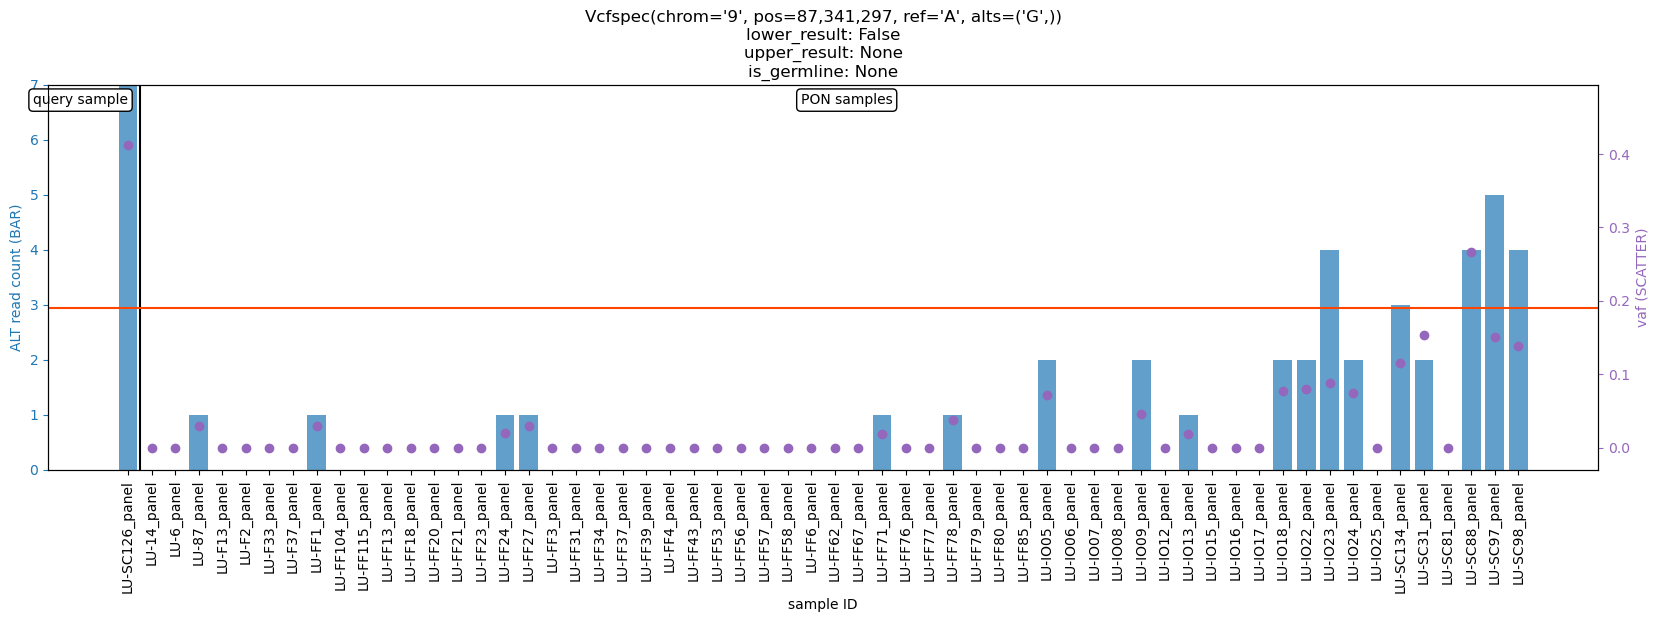

In [104]:
vp.show_pon(query_sample='LU-SC126_panel', pon_samples=[x + '_panel' for x in SAMPLEIDS_LU])

# CNV

In [15]:
import handygenome.cnv.misc as cnvmisc
import handygenome.cnv.mosdepth as libmosdepth
import handygenome.cnv.sequenza_handler as sequenza_handler
import handygenome.cnv.rcopynumber as rcopynumber
import handygenome.pyranges_helper as pyranges_helper
import handygenome.plot.coordconverter as coordconverter
import handygenome.cnv.gcfraction as gcfraction

In [16]:
NORMAL_PANEL_BAM_TOPDIR = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/02_BAM/pooled_normal'
MERGED_NORMAL_PANEL_DEPTH_DF_PATH = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/23_binned_depths/merged_normal_panel_depth.tsv.gz'

### Make depth df of merged blood TPS bams, and save it

In [41]:
NORMAL_PANEL_BAM_PATHS = dict()
for top, dirs, files in os.walk(NORMAL_PANEL_BAM_TOPDIR):
    for fname in files:
        if fname.endswith('.mkdup.indelra.bam'):
            sid = fname.split('.')[0]
            NORMAL_PANEL_BAM_PATHS[sid] = os.path.join(top, fname)

NORMAL_PANEL_DEPTH_DFS = dict()
for sid, bam_path in NORMAL_PANEL_BAM_PATHS.items():
    print(sid)
    NORMAL_PANEL_DEPTH_DFS[sid] = libmosdepth.run_mosdepth(
        bam_path,
        t=8, use_median=False, region_gr=PANEL_REGION_GR_100bin, donot_subset_bam=True, as_gr=False, load_perbase=False,
    )[0]

MERGED_NORMAL_PANEL_DEPTH_DF = PANEL_REGION_GR_100bin.df.copy()
MERGED_NORMAL_PANEL_DEPTH_DF = MERGED_NORMAL_PANEL_DEPTH_DF.assign(**{'mean_depth': sum(df.mean_depth for df in NORMAL_PANEL_DEPTH_DFS.values())})
MERGED_NORMAL_PANEL_DEPTH_DF.to_csv(MERGED_NORMAL_PANEL_DEPTH_DF_PATH, sep='\t', index=False)

S10
S6
S7
S9
S5
S8


### Load merged blood TPS bam depth df

In [20]:
merged_normal_panel_depth_df = pd.read_csv(MERGED_NORMAL_PANEL_DEPTH_DF_PATH, sep='\t', header=0)
merged_normal_panel_depth_gr, merged_normal_panel_gcbin_depths = cnvmisc.postprocess_depth_df(
    merged_normal_panel_depth_df, 
    fasta=FASTA_HG19, 

    nan_lower_cutoff=50,
    nan_upper_cutoff=np.inf,

    gcdata_trim_limits=(0.05, 0.05),
    gcdata_lower_cutoff=50,
    gcdata_upper_cutoff=np.inf,

    n_gcbin=100, 
    as_gr=True, 
    gc_window=None,
)

### Set sampleid

In [17]:
sampleid = 'LU-14'
sampleid_normal = f'{sampleid}_normal'
sampleid_tumor = f'{sampleid}_tumor'
sampleid_panel = f'{sampleid}_panel'

### Make depthratio df and segments of tumor panel bam

##### create depth df of tumor panel bam

In [22]:
bam_path = BAM_PATHS['panel'][sampleid]
tumor_panel_depth_df, tumor_panel_gcbin_depths = cnvmisc.get_processed_depth_df(
    bam_path=bam_path, fasta=FASTA_HG19, region_gr=PANEL_REGION_GR_100bin, outlier_cutoffs='panel', donot_subset_bam=True, as_gr=False,
)

##### create germline variant df

In [30]:
panel_germline_vplist = VariantPlusList.from_vcf(PANEL_GERMLINE_VCF_PATHS[sampleid])
panel_germline_gr = panel_germline_vplist.get_df(
    alt_index=0,
    vaf_sampleid=sampleid_panel,
    as_gr=True,
    get_vaf_kwargs={
        'exclude_other': True,
    },
)
panel_germline_gr.baf = cnvmisc.get_bafs(panel_germline_gr.vaf)

##### create depthratio and segment for panel

In [59]:
panel_depthratio_gr = cnvmisc.make_depth_ratio_df(tumor_panel_depth_df, merged_normal_panel_depth_gr.df, as_gr=True)
panel_depthratio_gr.depth = panel_depthratio_gr.depth_ratio_sequenzastyle

panel_segment_gr = rcopynumber.run_rcopynumber_compact(panel_depthratio_gr.df, baf_df=panel_germline_gr.df, refver='hg19', as_gr=True)
panel_segment_gr = rcopynumber.add_CNn_to_targetseq_segment_gr(panel_segment_gr, PANEL_REGION_GR_100bin, refver='hg19', is_female=IS_FEMALE[sampleid])

aspcf is not run for sample in chromosome arm 4p because all of the BAF-values are outside the threshold values. Mean is returned for logR.
aspcf is not run for sample in chromosome arm 8q because all of the BAF-values are outside the threshold values. Mean is returned for logR.
aspcf is not run for sample in chromosome arm 18q because all of the BAF-values are outside the threshold values. Mean is returned for logR.
aspcf is not run for sample in chromosome arm 19q because all of the BAF-values are outside the threshold values. Mean is returned for logR.
aspcf is not run for sample in chromosome arm Xp because all of the BAF-values are outside the threshold values. Mean is returned for logR.


In [61]:
panel_segment_gr = pyranges_helper.join(panel_segment_gr, panel_depthratio_gr[['depth_ratio_sequenzastyle']], how='left', merge='mean', find_nearest=False, as_gr=True)
panel_segment_gr = pyranges_helper.join(panel_segment_gr, panel_germline_gr[['baf']], how='left', merge='mean', find_nearest=False, as_gr=True)
panel_segment_gr.depth_mean = panel_segment_gr.depth_ratio_sequenzastyle
panel_segment_gr.baf_mean = panel_segment_gr.baf

In [63]:
normal_mean_ploidy = cnvmisc.get_normal_mean_ploidy('hg19', IS_FEMALE[sampleid], target_region_gr=PANEL_REGION_GR_100bin)
normal_mean_ploidy_wgs = cnvmisc.get_normal_mean_ploidy('hg19', IS_FEMALE[sampleid], target_region_gr=None)

In [95]:
cpscore_dict = cnvmisc.get_cp_score_dict(panel_segment_gr.df, refver='hg19', is_female=IS_FEMALE[sampleid], target_region_gr=PANEL_REGION_GR_100bin, CNt_weight=5, nproc=None)

In [79]:
peak_values, dfs = cnvmisc.get_peak_info(cpscore_dict)
peak_values = sorted(peak_values, key=(lambda x: abs(x['ploidy_diff_ratio'])))

<AxesSubplot: xlabel='ploidy', ylabel='cellularity'>

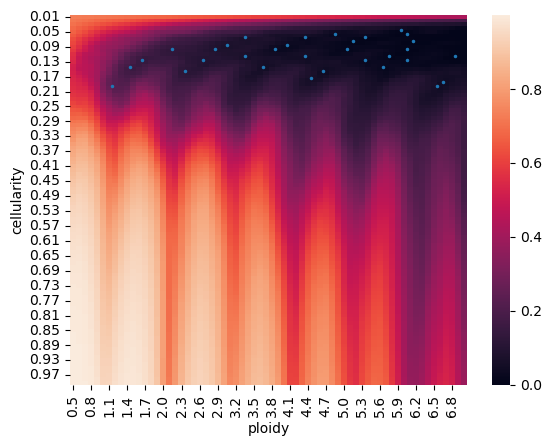

In [195]:
cnvmisc.show_heatmap_peaks(dfs['segfit'])

<AxesSubplot: xlabel='ploidy', ylabel='cellularity'>

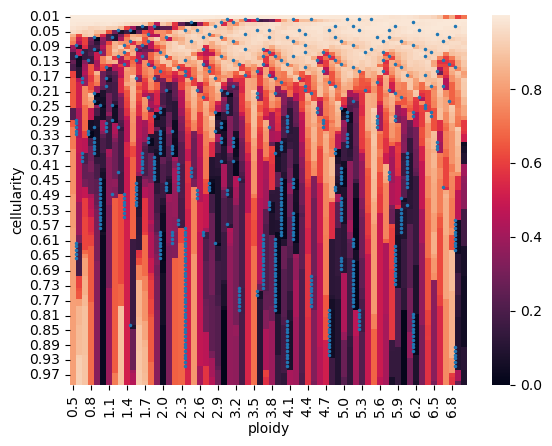

In [134]:
cnvmisc.show_heatmap_peaks(dfs['ploidy_diff_abs'], quantile=True)

<AxesSubplot: xlabel='ploidy', ylabel='cellularity'>

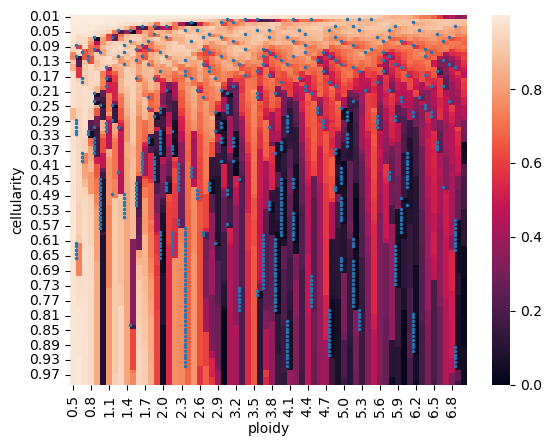

In [133]:
cnvmisc.show_heatmap_peaks(dfs['ploidy_diff_ratio_abs'], quantile=True)

### Load sequenza WGS segments

### WGS cnvcaller validation

In [18]:
print(sampleid)

LU-14


#### prepare germline calls

In [148]:
wgs_germline_vcf_path = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/06_haplotypecaller/annotation_230126/LU-14.readstats.vcf.gz'
wgs_tumor_bam_path = BAM_PATHS['tumor'][sampleid]
wgs_normal_bam_path = BAM_PATHS['normal'][sampleid]
wgs_tumor_bam = BAMS['tumor'][sampleid]
wgs_normal_bam = BAMS['normal'][sampleid]

bam_dict = {
    'tumor': wgs_tumor_bam,
    'normal': wgs_normal_bam,
}

In [ ]:
igv.new()
igv.load([wgs_normal_bam_path, wgs_tumor_bam_path])

In [149]:
vplist_lazy = VariantPlusList.from_vcf_lazy(wgs_germline_vcf_path)

In [150]:
germlinefilter = libfilter.get_preset_filter_germline(with_pon=False)

def vpfilter(vp):
    vaf = vp.get_vaf('LU-14_normal', allele_index=1)
    return (
        germlinefilter.check(vp, sampleid='LU-14_normal', allele_index=1)
        and (vaf > 0.3)
        and (vaf < 0.7)
    )

In [151]:
filtered_wgs_germline_vcf_path = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/06_haplotypecaller/annotation_230126/LU-14.readstats.het_filtered.vcf.gz'
vplist_lazy = VariantPlusList.from_vcf_lazy(wgs_germline_vcf_path, logging_lineno=50000)
vplist_lazy.write_with_filter(filtered_wgs_germline_vcf_path, vpfilter)

[KST 2023-03-15 01:52:15.500] VariantPlusList: Processing 50,000th line
[KST 2023-03-15 01:58:51.724] VariantPlusList: Processing 100,000th line
[KST 2023-03-15 02:04:04.617] VariantPlusList: Processing 150,000th line
[KST 2023-03-15 02:09:18.509] VariantPlusList: Processing 200,000th line
[KST 2023-03-15 02:15:29.959] VariantPlusList: Processing 250,000th line
[KST 2023-03-15 02:21:03.663] VariantPlusList: Processing 300,000th line
[KST 2023-03-15 02:25:53.111] VariantPlusList: Processing 350,000th line
[KST 2023-03-15 02:31:53.905] VariantPlusList: Processing 400,000th line
[KST 2023-03-15 02:37:36.938] VariantPlusList: Processing 450,000th line
[KST 2023-03-15 02:43:04.737] VariantPlusList: Processing 500,000th line
[KST 2023-03-15 02:48:16.772] VariantPlusList: Processing 550,000th line
[KST 2023-03-15 02:54:10.644] VariantPlusList: Processing 600,000th line
[KST 2023-03-15 02:59:09.477] VariantPlusList: Processing 650,000th line
[KST 2023-03-15 03:04:13.186] VariantPlusList: Proce

#### Filter criteria validation

In [61]:
# vplist = VariantPlusList.from_vcf(wgs_germline_vcf_path, prop=None, fetch_chrom='1', fetch_start0=1_462_000, fetch_end0=1_463_000)
vplist = VariantPlusList.from_vcf(wgs_germline_vcf_path, prop=0.01, fetch_chrom='13')

[KST 2023-03-14 03:27:12.860] VariantPlusList: Processing 1,000th line


###### inspect individual variants

In [54]:
vp = vplist[0]

In [52]:
germlinefilter = libfilter.get_preset_filter_germline(with_pon=False)

def vpfilter(vp):
    vaf = vp.get_vaf('LU-14_normal', allele_index=1)
    return (
        germlinefilter.check(vp, sampleid='LU-14_normal', allele_index=1)
        and (vaf > 0.3)
        and (vaf < 0.7)
    )

In [71]:
germlinefilter.check_show(vp, sampleid='LU-14_normal', allele_index=1)

True    <DiffMeanBQFilter ({'cutoff': -5})>
True    <AbsMeanBQFilter ({'cutoff': 20})>
True    <DiffMeanMQFilter ({'cutoff': -15})>
True    <AbsMeanMQFilter ({'cutoff': 40})>
True    <ClipoverlapFilter ({'cutoff': 2.0})>
True    <CliplenFilter ({'cutoff': 20})>
True    <ReadcountFilter ({'cutoff': 2})>
True    <OthercountRatioFilter ({'cutoff': 1.5, 'ref_length_cutoff': None})>
True    <TotaldepthGTFilter ({'cutoff': 10})>
False    <VarposUniformFilter ({'cutoff': 0.05})>


In [72]:
vp.readstats_dict['LU-14_normal']

<ReadStats(
    {'rppcounts': {None: 0, -1: 0, 0: 40, 1: 27, 'softclip_overlap': 0},
     'mean_BQs': {None: nan, -1: nan, 0: 23.651162790697676, 1: 27.48148148148148},
     'median_BQs': {None: nan, -1: nan, 0: 22.0, 1: 27.0},
     'mean_MQs': {None: nan, -1: nan, 0: 59.7, 1: 47.592592592592595},
     'median_MQs': {None: nan, -1: nan, 0: 60.0, 1: 50.0},
     'mean_cliplens': {None: nan, -1: nan, 0: 4.6, 1: 28.037037037037038},
     'median_cliplens': {None: nan, -1: nan, 0: 0.0, 1: 10.0},
     'mNM': {None: nan, -1: nan, 0: 2.8, 1: 2.074074074074074},
     'pairorient_pvalues': {None: nan, -1: nan, 0: 0.0806904677519924, 1: 1.0},
     'readorient_pvalues': {None: nan, -1: nan, 0: 1.0, 1: 1.0},
     'varpos_uniform_pvalues': {None: nan,
                                -1: nan,
                                0: 0.49137293549355754,
                                1: 0.0076174169167063654},
     'mean_varpos_fractions': {None: nan,
                               -1: nan,
              

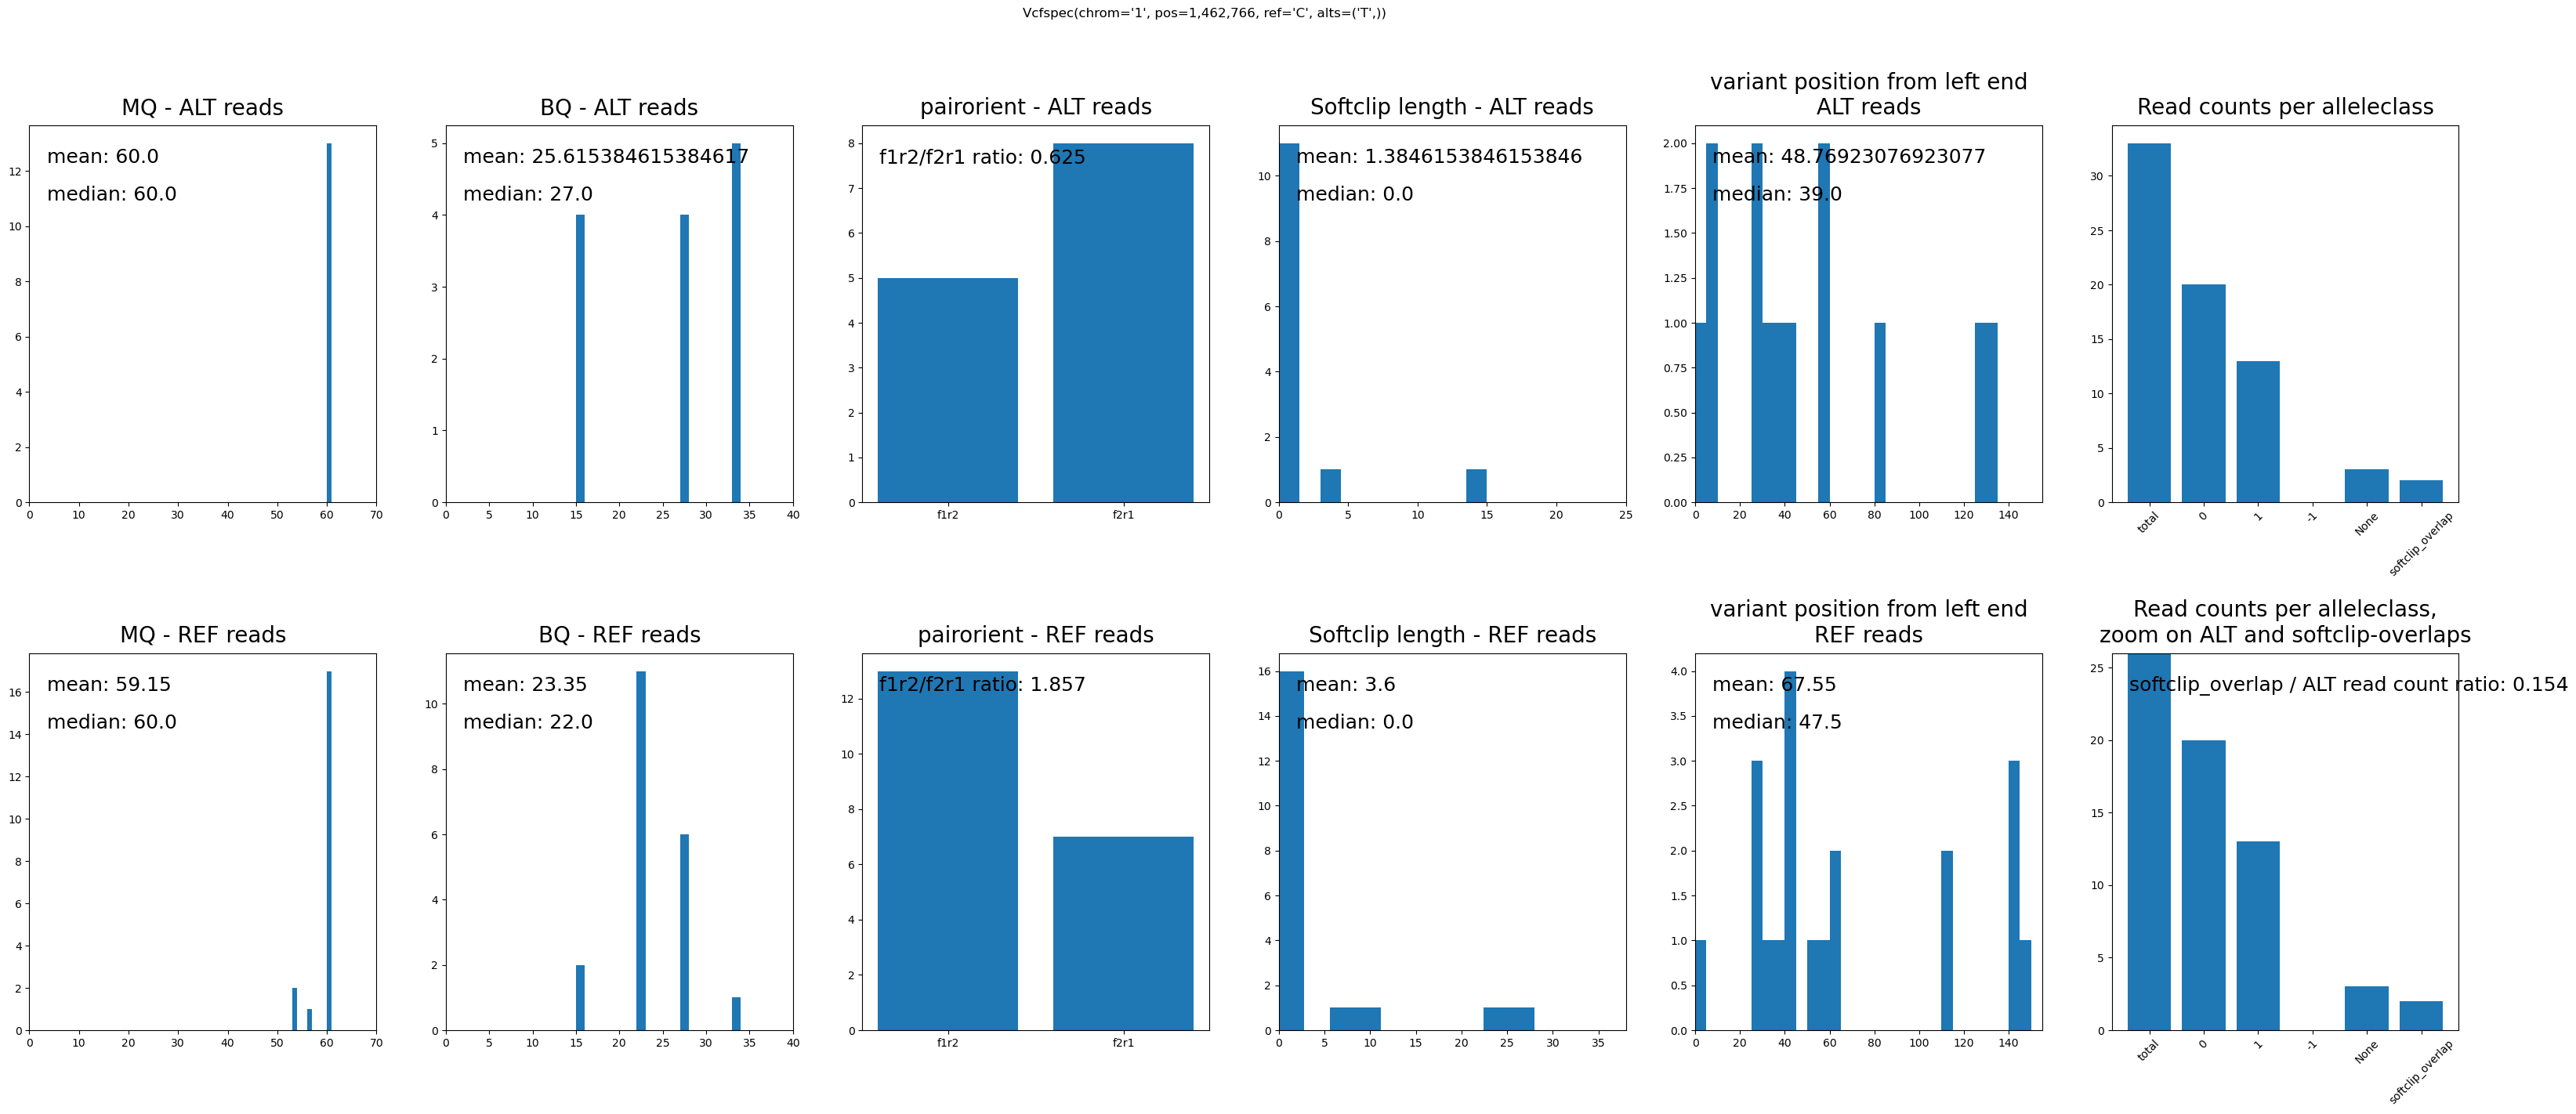

In [60]:
vp.show_readstats_data(bam=wgs_normal_bam)

###### inspect distribution of all variants

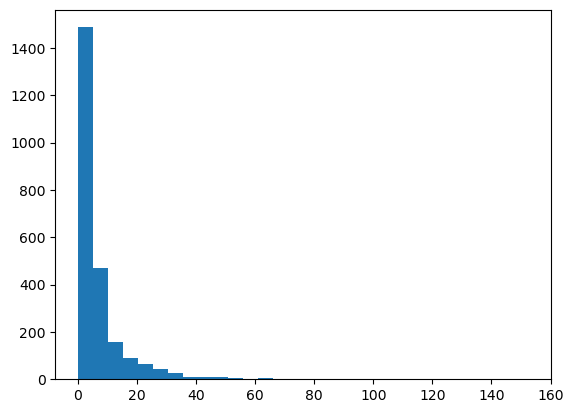

In [501]:
_ = plt.hist(vplist.get_all_vp_readstats_average('mean_cliplens', 'LU-14_normal'), bins=30)

In [127]:
def vpfilter(vp):
    # mean_cliplens = vp.readstats_dict['LU-14_normal'].get_allele_indexes_mean('mean_cliplens')
    diffMeanMQ = vp.readstats_dict['LU-14_normal']['mean_MQs'][1] - vp.readstats_dict['LU-14_normal']['mean_MQs'][0]
    return (
        diffMeanMQ > -10
        and diffMeanMQ < 0
    )

sub_vplist = vplist.filter(vpfilter)
print(len(sub_vplist))

190


In [128]:
vpiter = iter(sub_vplist)

In [131]:
vp = next(vpiter)
print(vp)

<VariantPlus(vcfspec=Vcfspec(chrom='13', pos=19,643,810, ref='T', alts=('C',)), gene=(alt_index 0: ))>


In [132]:
vp.show_igv(igv, bam_dict=bam_dict, max_width_oneside=400, colorby='NONE')

OK
OK
OK
OK
OK
OK
OK
OK


#### Load filtered germline call

In [23]:
filtered_wgs_germline_vcf_path = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/06_haplotypecaller/annotation_230126/LU-14.readstats.het_filtered.vcf.gz'
vplist_lazy = VariantPlusList.from_vcf_lazy(filtered_wgs_germline_vcf_path, logging_lineno=50000, init_all_attrs=False, vp_init_params={'init_readstats': True})

In [24]:
germline_gr = vplist_lazy.get_df(vaf_sampleid='LU-14_normal', as_gr=True, lazy=True)

[KST 2023-03-20 00:14:40.441] VariantPlusList: Processing 50,000th line
[KST 2023-03-20 00:16:21.766] VariantPlusList: Processing 100,000th line
[KST 2023-03-20 00:18:02.532] VariantPlusList: Processing 150,000th line
[KST 2023-03-20 00:19:44.194] VariantPlusList: Processing 200,000th line
[KST 2023-03-20 00:21:26.036] VariantPlusList: Processing 250,000th line
[KST 2023-03-20 00:23:08.125] VariantPlusList: Processing 300,000th line
[KST 2023-03-20 00:24:49.199] VariantPlusList: Processing 350,000th line
[KST 2023-03-20 00:26:30.027] VariantPlusList: Processing 400,000th line
[KST 2023-03-20 00:28:11.049] VariantPlusList: Processing 450,000th line
[KST 2023-03-20 00:29:53.542] VariantPlusList: Processing 500,000th line
[KST 2023-03-20 00:31:34.880] VariantPlusList: Processing 550,000th line
[KST 2023-03-20 00:33:16.336] VariantPlusList: Processing 600,000th line
[KST 2023-03-20 00:34:57.927] VariantPlusList: Processing 650,000th line
[KST 2023-03-20 00:36:38.342] VariantPlusList: Proce

In [47]:
germline_df = germline_gr.df
germline_df['baf'] = germline_df['vaf']
germline_df = germline_df.loc[:, ['Chromosome', 'Start', 'End', 'baf']]

#### prepare depth ratios

In [31]:
gc_df_100bin = gcfraction.get_gc_df('hg19', 100)

In [33]:
normal_wgs_depth_path = f'/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/23_binned_depths/results/{sampleid}.normal/{sampleid}.normal.regions.bed.gz'
tumor_wgs_depth_path = f'/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/23_binned_depths/results/{sampleid}.tumor/{sampleid}.tumor.regions.bed.gz'

normal_wgs_depth_df = libmosdepth.load_mosdepth_output(normal_wgs_depth_path, as_gr=False)
normal_wgs_depth_df, normal_gcbin_average_depths = cnvmisc.postprocess_depth_df(normal_wgs_depth_df, gc_vals=gc_df_100bin['GC'], preset_cutoffs='wgs', as_gr=False)

tumor_wgs_depth_df = libmosdepth.load_mosdepth_output(tumor_wgs_depth_path, as_gr=False)
tumor_wgs_depth_df, tumor_gcbin_average_depths = cnvmisc.postprocess_depth_df(tumor_wgs_depth_df, gc_vals=gc_df_100bin['GC'], preset_cutoffs='wgs', as_gr=False)

In [36]:
wgs_depthratio_df = cnvmisc.make_depth_ratio_df(tumor_wgs_depth_df, normal_wgs_depth_df, as_gr=False)
wgs_depthratio_df['depth'] = wgs_depthratio_df['depth_ratio_sequenzastyle']

#### depth ratios into larger bins

In [64]:
WG_larger_bins = CHROMDICT_HG19.to_gr(assembled_only=True).window(int(1e3))

In [66]:
import time
t1 = time.perf_counter()

wgs_depthratio_df_binned = pyranges_helper.join_new(
    WG_larger_bins, 
    pr.PyRanges(wgs_depthratio_df.loc[
        :, 
        # ['Chromosome', 'Start', 'End', 'tumor_mean_depth', 'normal_mean_depth', 'tumor_sequenza_style_norm_mean_depth', 'normal_sequenza_style_norm_mean_depth', 'depth_ratio_sequenzastyle']
        ['Chromosome', 'Start', 'End', 'depth_ratio_sequenzastyle']
    ]), 
    how='left', merge='mean', as_gr=False
)

t2 = time.perf_counter()
print(t2 - t1)

37.5343289161101


In [34]:
from handygenome.plot.coordconverter import CoordConverter
plotregion_df = CHROMDICT_HG19.to_gr(assembled_only=True).df
cconv = CoordConverter(plotregion_df)

In [84]:
df_plotdata = cconv.prepare_plot_data(wgs_depthratio_df_1Mbin)

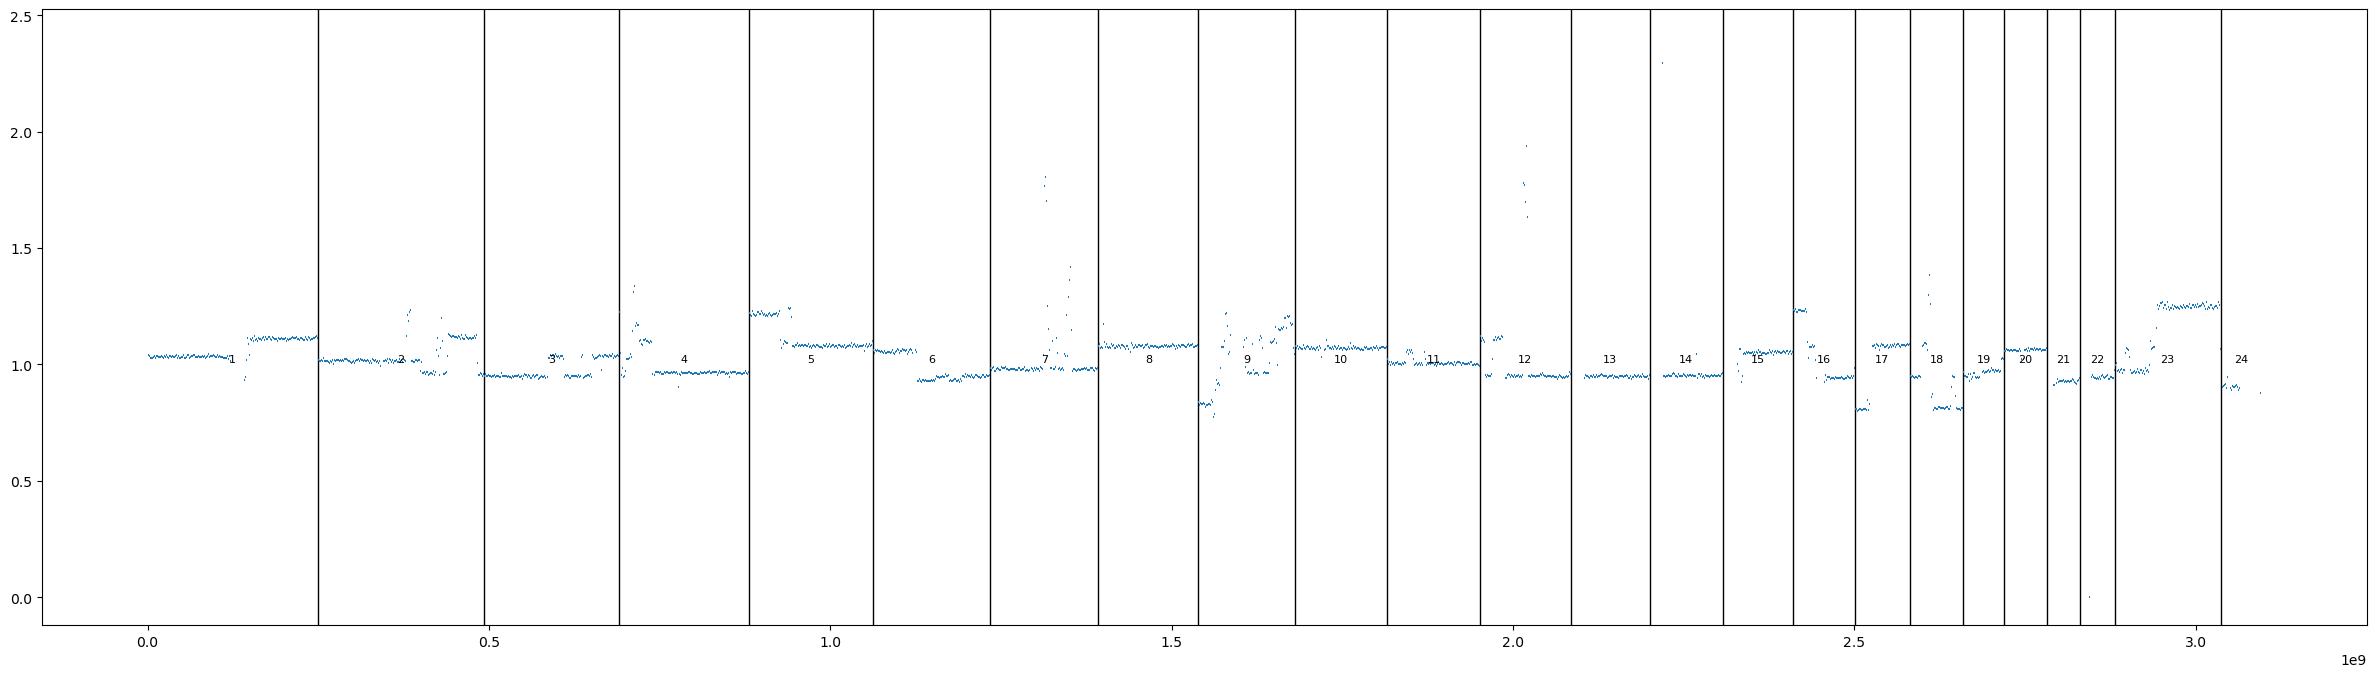

In [93]:
fig, ax = plt.subplots(figsize=(30, 8))
cconv.draw_chrom_borders(ax)
cconv.draw_hlines(ax, 'depth_ratio_sequenzastyle', df_plotdata=df_plotdata)

#### run R-copynumber

In [67]:
wgs_depthratio_df_binned['depth'] = wgs_depthratio_df_binned['depth_ratio_sequenzastyle']

In [68]:
wgs_segment_df = rcopynumber.run_rcopynumber(wgs_depthratio_df_binned, baf_df=germline_df, refver='hg19', as_gr=False)
# wgs_segment_gr = rcopynumber.add_CNn_to_wgs_segment_gr(pr.PyRanges(wgs_segment_df), refver='hg19', is_female=IS_FEMALE[sampleid])

[KST 2023-03-20 14:15:23] Merging depth and baf dataframes
[KST 2023-03-20 14:15:29] Adding chromosome arm information
[KST 2023-03-20 14:15:32] Making a new DataFrame with modified columns
[KST 2023-03-20 14:15:32] Removing columns with missing depth or arm information
[KST 2023-03-20 14:15:33] Writing DataFrame to file for use in R-copynumber
[KST 2023-03-20 14:16:06] Running R-copynumber
aspcf is not run for sample in chromosome arm 15p because all of the BAF-values are outside the threshold values. Mean is returned for logR.
[KST 2023-03-20 14:37:26] Loading R-copynumber output


In [69]:
wgs_segment_df

Chromosome      Start        End  depth_mean  baf_mean
0            1       9499   12887500      1.0449    0.5000
1            1   12888499   12934500      1.0203    0.3776
2            1   12935499   85594500      1.0337    0.5000
3            1   85595499   86017500      1.0727    0.5000
4            1   86018499   95718500      1.0316    0.5000
..         ...        ...        ...         ...       ...
280          X  155165499  155260500      1.2506    0.5000
281          Y    2649499    9940500      1.1786    0.3967
282          Y    9941499   11875500      1.0171    0.5000
283          Y   13104499   13704500      1.0590    0.5000
284          Y   13705499   59034500      1.1825    0.3875

[285 rows x 5 columns]

In [61]:
wgs_segment_df

Chromosome      Start        End  depth_mean  baf_mean
0            1       4999   55185000      1.0455    0.5000
1            1   55194999   69145000      1.0272    0.5000
2            1   69154999  108015000      1.0232    0.5000
3            1  108024999  120465000      1.0374    0.5000
4            1  120474999  121485000      1.0622    0.4509
..         ...        ...        ...         ...       ...
442          Y    2644999    5695000      1.1361    0.4016
443          Y    5704999    9945000      1.2638    0.4097
444          Y    9954999   11875000      1.0404    0.4232
445          Y   13104999   13705000      1.0720    0.5000
446          Y   13714999   59035000      1.1693    0.3909

[447 rows x 5 columns]

### WGS prep

In [287]:
print(sampleid)

wgs_extract_gr = sequenza_handler.load_extract(EXTRACT_PATHS[sampleid], CHROMDICT_HG19, as_gr=True)
# wgs_extract_gr.depth_ratio = wgs_extract_gr.ratio_mean

wgs_segment_gr = pr.PyRanges(CNV_SEGMENTS[sampleid])
annotated_wgs_segment_gr = cnvmisc.add_CNn_to_gr(wgs_segment_gr, is_female=IS_FEMALE[sampleid], refver='hg19')
annotated_wgs_segment_df = cnvmisc.add_theoreticals_to_segment(annotated_wgs_segment_gr.df, cellularity=PREVIOUS_PURITY[sampleid], tumor_ploidy=PREVIOUS_PLOIDY[sampleid], normal_ploidy=normal_mean_ploidy_wgs, is_female=IS_FEMALE[sampleid])

new_wgs_segment_df = annotated_wgs_segment_df.copy()
new_wgs_segment_df['depth_mean'] = new_wgs_segment_df['depth.ratio']
new_wgs_segment_df['baf_mean'] = new_wgs_segment_df['Bf']
new_wgs_segment_df = cnvmisc.add_CNt_to_segment(new_wgs_segment_df, cellularity=PREVIOUS_PURITY[sampleid], tumor_ploidy=PREVIOUS_PLOIDY[sampleid], is_female=IS_FEMALE[sampleid], normal_ploidy=normal_mean_ploidy_wgs)
new_wgs_segment_df = cnvmisc.add_theoreticals_to_segment(new_wgs_segment_df, cellularity=PREVIOUS_PURITY[sampleid], tumor_ploidy=PREVIOUS_PLOIDY[sampleid], normal_ploidy=normal_mean_ploidy_wgs, is_female=IS_FEMALE[sampleid])

LU-14


In [277]:
tumor_wgs_depth_df, tumor_wgs_gcbin_depths = cnvmisc.get_processed_depth_df(
    bam_path=BAM_PATHS['tumor'][sampleid], fasta=FASTA_HG19, region_gr=PANEL_REGION_GR_100bin, outlier_cutoffs='wgs', donot_subset_bam=False, as_gr=False,
)
normal_wgs_depth_df, normal_wgs_gcbin_depths = cnvmisc.get_processed_depth_df(
    bam_path=BAM_PATHS['normal'][sampleid], fasta=FASTA_HG19, region_gr=PANEL_REGION_GR_100bin, outlier_cutoffs='wgs', donot_subset_bam=False, as_gr=False,
)

LU-14


In [278]:
wgs_depthratio_gr = cnvmisc.make_depth_ratio_df(tumor_wgs_depth_df, normal_wgs_depth_df, as_gr=True)
wgs_depthratio_gr.depth = wgs_depthratio_gr.depth_ratio_sequenzastyle

### draw plot

In [322]:
def make_panel_wgs_plot(
    plotcoord_gr, plotcoord_gr_panelregion, 
    annotated_region_gr, panel_depthratio_gr, panel_germline_gr,
    wgs_depthratio_gr, new_wgs_segment_df, wgs_extract_gr,
    cellularity, ploidy, cellularity_wgs, ploidy_wgs, 
    sampleid, 
):
    from handygenome.plot.coordconverter import CoordConverter
    cconverter = CoordConverter(plotcoord_gr)

    fig, axs = plt.subplots(3, 1, figsize=(30, 10))
    ax_depth = axs[-1]
    ax_baf = axs[-2]
    ax_CN = axs[-3]

    ax_depth.set_ylim(0, 3)
    ax_depth.set_xticks([])
    ax_baf.set_xticks([])
    ax_CN.set_xticks([])

    fig.suptitle(f'''\
sampleid={sampleid}
cellularity_panel={cellularity}, ploidy_panel={ploidy}
cellularity_wgs={cellularity_wgs}, ploidy_wgs={ploidy_wgs}
''')
    
    wgs_col1 = 'black'
    wgs_col2 = 'gray'
    panel_col1 = 'red'
    panel_col2 = 'pink'

    # ax_depth
    # ax_depth.set_xlabel('Position (bp)')
    cconverter.set_xlim(ax_depth)
    cconverter.draw_bgcolors(ax_depth, plotcoord_gr_panelregion.df, facecolor='yellow', linewidth=0, alpha=0.4)

    cconverter.draw_hlines(ax_depth, annotated_region_gr.df, 'predicted_depth_ratio', color=panel_col1, nproc=24, linewidth=2, alpha=0.9)
    cconverter.draw_dots(ax_depth, panel_depthratio_gr.df, 'depth_ratio_sequenzastyle', color=panel_col2, alpha=0.1, nproc=24, markersize=1.5)

    cconverter.draw_hlines(ax_depth, new_wgs_segment_df, 'predicted_depth_ratio', color=wgs_col1, nproc=24, linewidth=2, alpha=0.9)
    cconverter.draw_dots(ax_depth, wgs_depthratio_gr.df, 'depth_ratio_sequenzastyle', color=wgs_col2, alpha=0.1, nproc=24, markersize=1.5)
    cconverter.draw_dots(ax_depth, (wgs_extract_gr.subtract(plotcoord_gr_panelregion)).df, 'ratio_mean', color=wgs_col2, alpha=0.1, nproc=24, markersize=1.5)

    cconverter.draw_chrom_borders(ax_depth)

    yticks = np.arange(0, round(ax_depth.get_ylim()[1], 1), 0.2)
    _ = ax_depth.set_yticks(yticks)
    for y in yticks:
        ax_depth.axhline(y, alpha=0.3)



    # ax_baf
    cconverter.set_xlim(ax_baf)
    cconverter.draw_bgcolors(ax_baf, plotcoord_gr_panelregion.df, facecolor='yellow', linewidth=0, alpha=0.4)

    cconverter.draw_hlines(ax_baf, annotated_region_gr.df, 'predicted_baf', color=panel_col1, nproc=24, linewidth=2, alpha=0.9)
    cconverter.draw_dots(ax_baf, panel_germline_gr.df, 'baf', color=panel_col2, alpha=0.5, nproc=24, markersize=1.5)

    cconverter.draw_hlines(ax_baf, new_wgs_segment_df, 'predicted_baf', color=wgs_col1, nproc=24, linewidth=2, alpha=0.9)
    cconverter.draw_dots(ax_baf, (wgs_extract_gr.subtract(plotcoord_gr_panelregion)).df, 'baf_mean', color=wgs_col2, alpha=0.5, nproc=24, markersize=1.5)

    cconverter.draw_chrom_borders(ax_baf)

    yticks = np.arange(0, 0.6, 0.1)
    _ = ax_baf.set_yticks(yticks)
    for y in yticks:
        ax_baf.axhline(y, alpha=0.3)


    # ax_CN
    cconverter.set_xlim(ax_CN)
    cconverter.draw_bgcolors(ax_CN, plotcoord_gr_panelregion.df, facecolor='yellow', linewidth=0, alpha=0.4)

    cconverter.draw_hlines(ax_CN, annotated_region_gr.df, 'CNt', offset=-0.2, color=panel_col1, nproc=24, linewidth=2, alpha=1)
    cconverter.draw_hlines(ax_CN, annotated_region_gr.df, 'B', offset=-0.2, color=panel_col2, nproc=24, linewidth=2, alpha=1)

    cconverter.draw_hlines(ax_CN, new_wgs_segment_df, 'CNt', offset=0.2, color=wgs_col1, nproc=24, linewidth=2, alpha=1)
    cconverter.draw_hlines(ax_CN, new_wgs_segment_df, 'B', offset=0.2, color=wgs_col2, nproc=24, linewidth=2, alpha=1)

    cconverter.draw_chrom_borders(ax_CN)

    yticks = np.arange(
        0, 
        max(annotated_region_gr.df['CNt'].max(), new_wgs_segment_df['CNt'].max()).astype('int') + 1, 
        1,
    ).astype('int')
    _ = ax_CN.set_yticks(yticks)
    for y in yticks:
        ax_CN.axhline(y, alpha=0.3)
        
    return fig, axs


In [315]:
plotcoord_gr_panelregion = PANEL_REGION_GR_100bin.copy()
plotcoord_gr_panelregion.weight = 1000

plotcoord_gr_otherregion = CHROMDICT_HG19.to_gr()
plotcoord_gr_otherregion = plotcoord_gr_otherregion[plotcoord_gr_otherregion.Chromosome.map(lambda x: common.RE_PATS['assembled_chromosome'].fullmatch(x) is not None)]
plotcoord_gr_otherregion = plotcoord_gr_otherregion.subtract(plotcoord_gr_panelregion)
plotcoord_gr_otherregion = plotcoord_gr_otherregion.window(int(1e6))
plotcoord_gr_otherregion.weight = 1

plotcoord_gr = pr.concat([plotcoord_gr_panelregion, plotcoord_gr_otherregion]).sort()

In [81]:
from handygenome.plot.coordconverter import CoordConverter

peak = peak_values[0]
cellularity = peak['cellularity']
ploidy = peak['ploidy']

annotated_segment_df = cnvmisc.add_CNt_to_segment(panel_segment_gr.df, cellularity=cellularity, tumor_ploidy=ploidy, is_female=IS_FEMALE[sampleid], normal_ploidy=normal_mean_ploidy)
annotated_segment_df = cnvmisc.add_theoreticals_to_segment(annotated_segment_df, cellularity=cellularity, tumor_ploidy=ploidy, normal_ploidy=normal_mean_ploidy, is_female=IS_FEMALE[sampleid])
annotated_region_gr = cnvmisc.annotate_region_with_segment(PANEL_REGION_GR_100bin, pr.PyRanges(annotated_segment_df))

In [82]:
cconv = CoordConverter(annotated_region_gr.df)

0.4582922770641744
0.44759297801647335


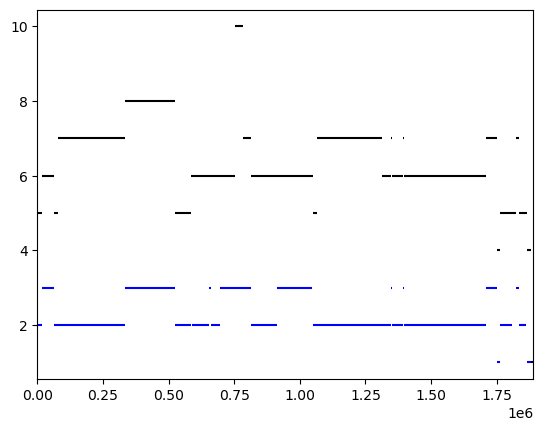

In [100]:
fig, ax = plt.subplots()
cconv.set_xlim(ax)

cconv.draw_hlines(ax, annotated_region_gr.df, 'CNt', color='black')
cconv.draw_hlines(ax, annotated_region_gr.df, 'B', color='blue')

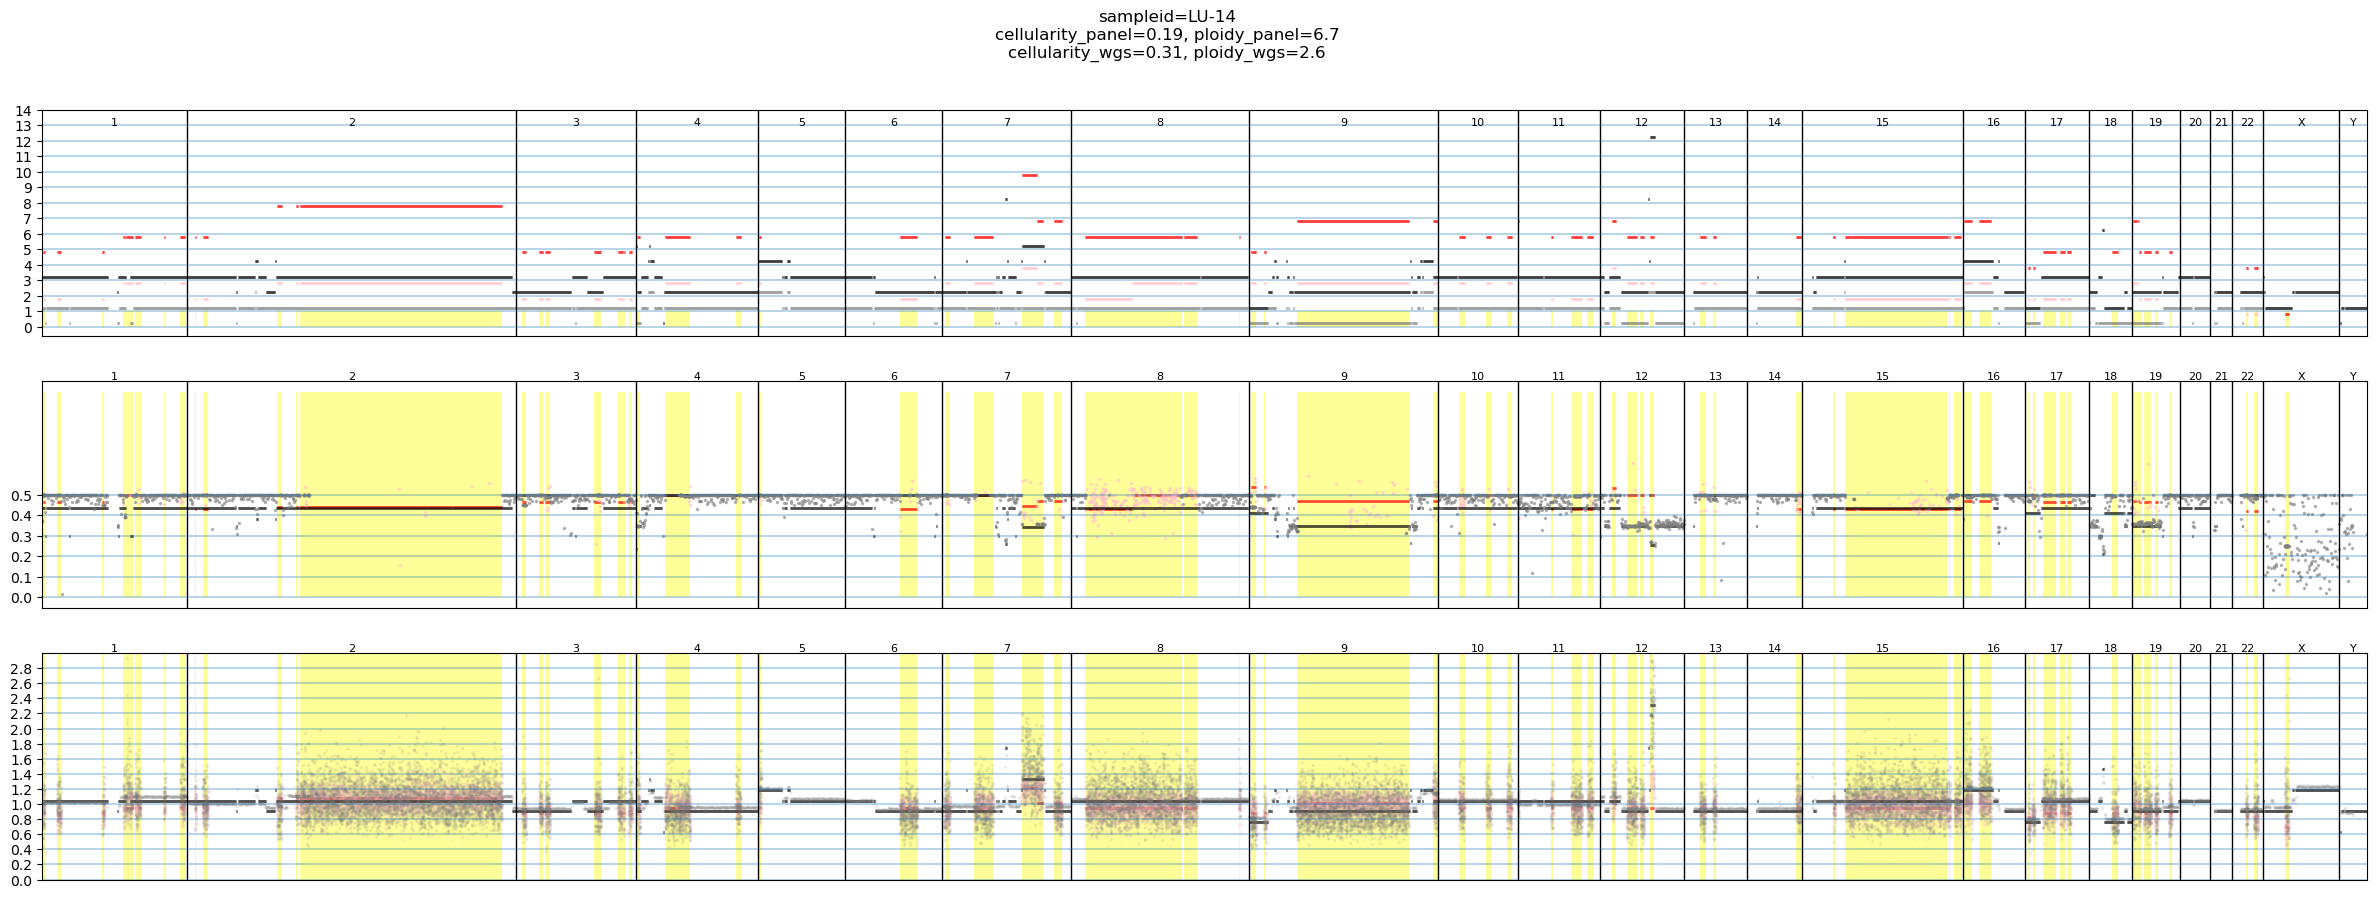

In [319]:
peak = peak_values[0]
cellularity = peak['cellularity']
ploidy = peak['ploidy']

annotated_segment_df = cnvmisc.add_CNt_to_segment(panel_segment_gr.df, cellularity=cellularity, tumor_ploidy=ploidy, is_female=IS_FEMALE[sampleid], normal_ploidy=normal_mean_ploidy)
annotated_segment_df = cnvmisc.add_theoreticals_to_segment(annotated_segment_df, cellularity=cellularity, tumor_ploidy=ploidy, normal_ploidy=normal_mean_ploidy, is_female=IS_FEMALE[sampleid])
annotated_region_gr = cnvmisc.annotate_region_with_segment(PANEL_REGION_GR_100bin, pr.PyRanges(annotated_segment_df))

fig, axs = make_panel_wgs_plot(
    plotcoord_gr, plotcoord_gr_panelregion, 
    annotated_region_gr, panel_depthratio_gr, panel_germline_gr,
    wgs_depthratio_gr, new_wgs_segment_df, wgs_extract_gr,
    cellularity, ploidy, PREVIOUS_PURITY[sampleid], PREVIOUS_PLOIDY[sampleid], 
    sampleid, 
)

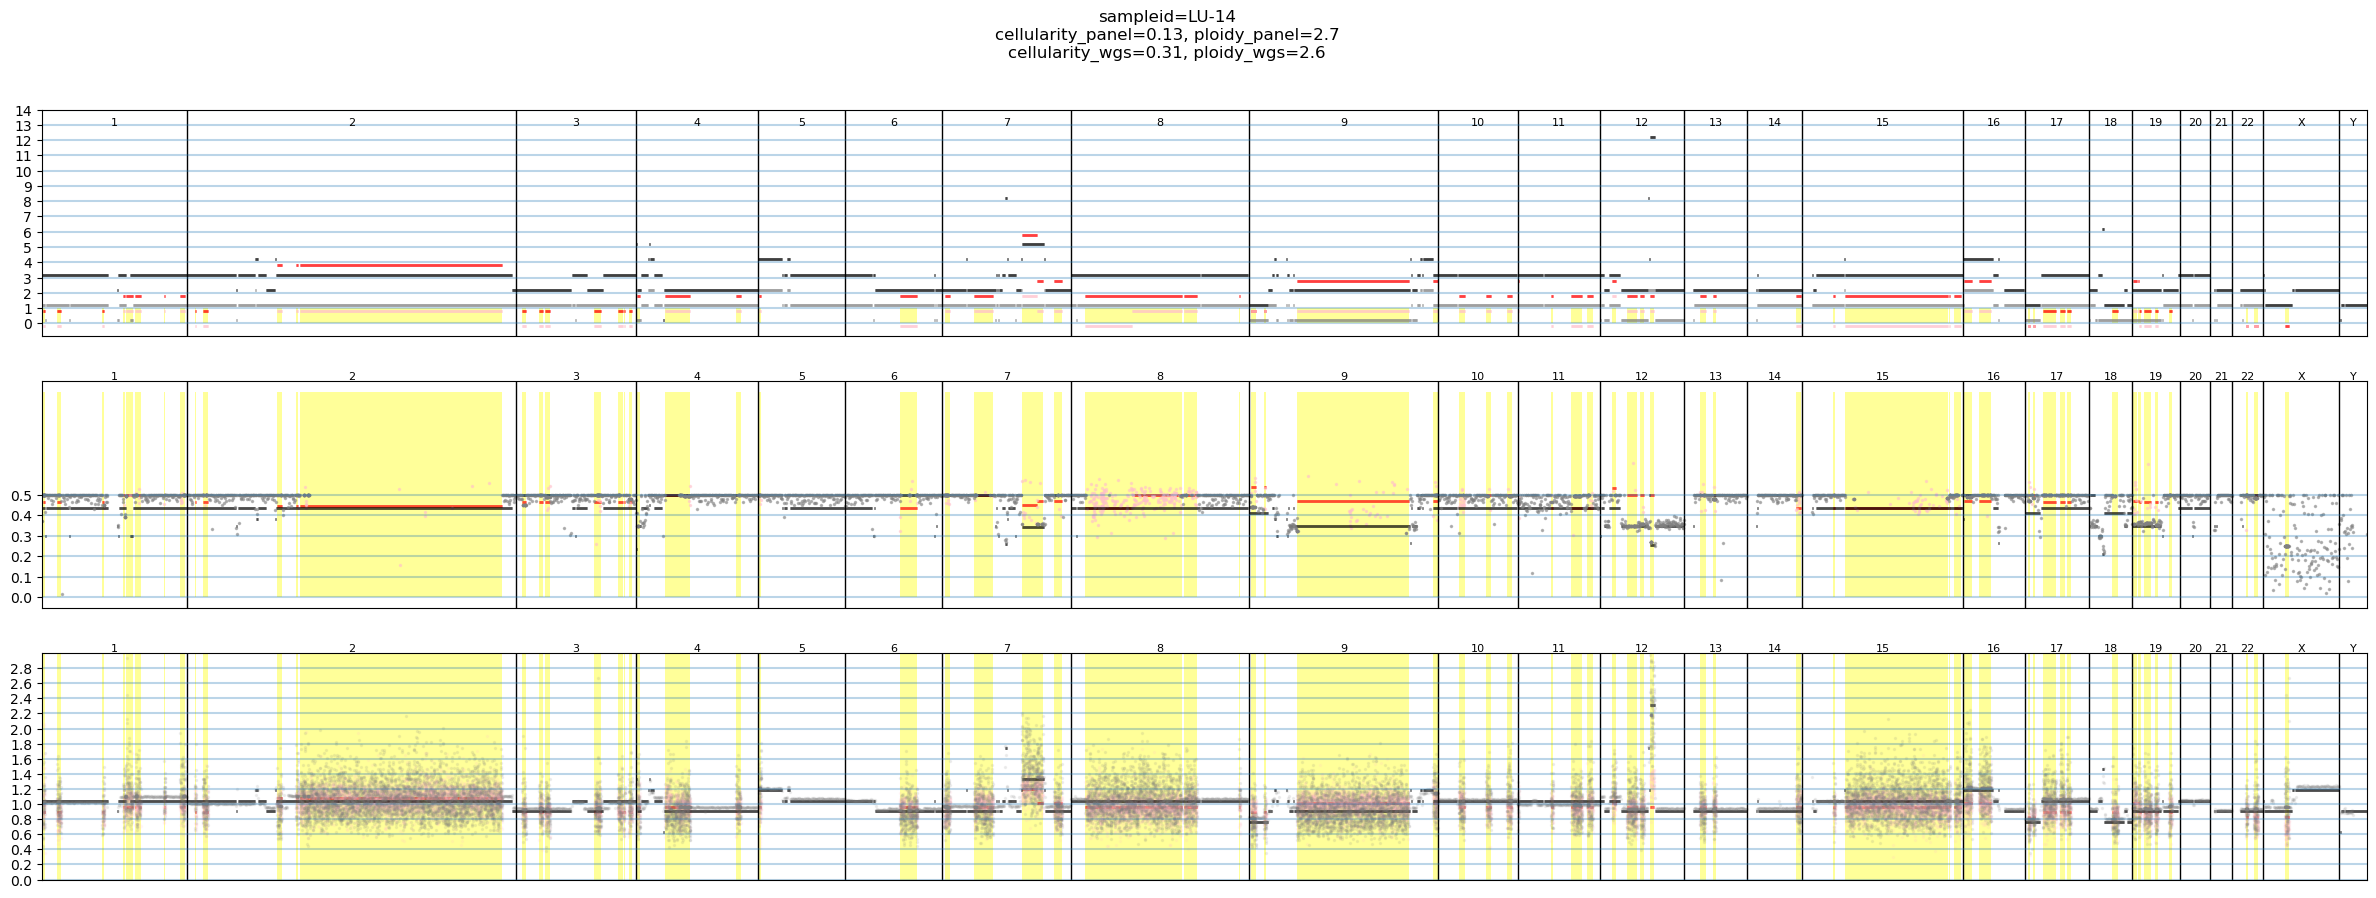

In [320]:
cellularity = 0.13
ploidy = 2.7

annotated_segment_df = cnvmisc.add_CNt_to_segment(panel_segment_gr.df, cellularity=cellularity, tumor_ploidy=ploidy, is_female=IS_FEMALE[sampleid], normal_ploidy=normal_mean_ploidy)
annotated_segment_df = cnvmisc.add_theoreticals_to_segment(annotated_segment_df, cellularity=cellularity, tumor_ploidy=ploidy, normal_ploidy=normal_mean_ploidy, is_female=IS_FEMALE[sampleid])
annotated_region_gr = cnvmisc.annotate_region_with_segment(PANEL_REGION_GR_100bin, pr.PyRanges(annotated_segment_df))

fig, axs = make_panel_wgs_plot(
    plotcoord_gr, plotcoord_gr_panelregion, 
    annotated_region_gr, panel_depthratio_gr, panel_germline_gr,
    wgs_depthratio_gr, new_wgs_segment_df, wgs_extract_gr,
    cellularity, ploidy, PREVIOUS_PURITY[sampleid], PREVIOUS_PLOIDY[sampleid], 
    sampleid, 
)

# Signature analysis

### Signature Plot

##### Prepare SigMA data

In [68]:
dfs = dict()

# infile_path_wgs = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/27_SigMA/result_all_samples_wgs_output_tumortype_lung_platform_MSK-IMPACT410Genes_cf0.csv'
# dfs['wgs'] = pd.read_csv(infile_path_wgs)

# infile_path_panel = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/27_SigMA/result_all_samples_panel_output_tumortype_lung_platform_MSK-IMPACT410Genes_cf0.csv'
infile_path_panel = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/27_SigMA/result_all_samples_panel_230612_output_tumortype_lung_platform_MSK-IMPACT410Genes_cf0.csv'
dfs['panel'] = pd.read_csv(infile_path_panel)

In [69]:
# dfs['wgs'].insert(
#     len(dfs['wgs'].columns),
#     'sampleid',
#     dfs['wgs'].iloc[:, 96].apply(lambda x: os.path.basename(x).split('.')[0]),
# )
dfs['panel'].insert(
    len(dfs['panel'].columns),
    'sampleid',
    dfs['panel'].iloc[:, 96].apply(lambda x: os.path.basename(x).split('_')[0]),
)

In [70]:
import collections

exposures_sigma = dict()
for seqtype, df in dfs.items():
    exposures_sigma[seqtype] = dict()
    for idx, row in df.iterrows():
        sid = row['sampleid']
        sigids = [x.split('_')[1] for x in row['sigs_all_msi'].split('.')]
        exps = [float(x) for x in row['exps_all_msi'].split('_')]
        exposures_sigma[seqtype][sid] = collections.defaultdict(lambda: 0, zip(sigids, exps))

In [ ]:
# filtered_tps_vplists_snv = dict()
# filtered_tps_vplists_indel = dict()

##### Prepare SigProfiler data

In [211]:
exposures_sigprofiler = dict()
exposures_sigprofiler['wgs'] = dict()
exposures_sigprofiler['panel'] = dict()

sigresult_dict_wgs = dict()
sigresult_dict_panel = dict()

for sid in SAMPLEIDS_LU:
    print(sid)
    
    exposures_sigprofiler['wgs'][sid] = dict() 
    exposures_sigprofiler['panel'][sid] = dict() 
    
    sigresult_wgs = PREVIOUS_WGS_REANNOT_VCF_SNV[sid].get_sigresult()
    sigresult_dict_wgs[sid] = sigresult_wgs
    sigresult_panel = filtered_panel_vplists_snv[sid].get_sigresult()
    sigresult_dict_panel[sid] = sigresult_panel
    
    for key, val in sigresult_wgs.exposure.to_dict().items():
        if val == 0:
            continue            
        key = key[3:]
        exposures_sigprofiler['wgs'][sid][key] = int(val)
        
    for key, val in sigresult_panel.exposure.to_dict().items():
        if val == 0:
            continue            
        key = key[3:]
        exposures_sigprofiler['panel'][sid][key] = int(val)
        

[KST 2023-06-15 01:58:50 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:58:50 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment


LU-14


[KST 2023-06-15 01:58:50 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:58:50 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:58:50 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:58:50 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:58:50 INFO] handygenome.signature.signatureresult: Creating mutation catalogue


LU-6


[KST 2023-06-15 01:58:51 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:58:51 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:58:51 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:58:51 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:58:51 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:58:51 INFO] handygenome.signature.signatureresult: Creating mutation catalogue


LU-87


[KST 2023-06-15 01:58:53 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:58:53 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:58:53 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:58:53 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:58:53 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:58:53 INFO] handygenome.signature.signatureresult: Creating mutation catalogue


LU-F13


[KST 2023-06-15 01:58:55 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:58:55 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:58:55 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:58:55 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:58:55 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:58:55 INFO] handygenome.signature.signatureresult: Creating mutation catalogue


LU-F2


[KST 2023-06-15 01:58:56 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:58:56 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:58:56 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:58:56 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:58:56 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:58:56 INFO] handygenome.signature.signatureresult: Creating mutation catalogue


LU-F33


[KST 2023-06-15 01:58:57 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:58:57 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:58:57 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:58:57 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:58:57 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:58:57 INFO] handygenome.signature.signatureresult: Creating mutation catalogue


LU-F37


[KST 2023-06-15 01:58:57 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:58:57 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:58:57 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:58:57 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:58:58 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:58:58 INFO] handygenome.signature.signatureresult: Creating mutation catalogue


LU-FF1


[KST 2023-06-15 01:58:59 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:58:59 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:58:59 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:58:59 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:58:59 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:58:59 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:58:59 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment


LU-FF104


[KST 2023-06-15 01:58:59 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:58:59 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:58:59 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:58:59 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:58:59 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:00 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment


LU-FF115


[KST 2023-06-15 01:59:00 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:00 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:00 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:00 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:00 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:00 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment


LU-FF13


[KST 2023-06-15 01:59:00 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:00 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:00 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:00 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:00 INFO] handygenome.signature.signatureresult: Creating mutation catalogue


LU-FF18


[KST 2023-06-15 01:59:01 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:02 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:02 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:02 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:02 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:02 INFO] handygenome.signature.signatureresult: Creating mutation catalogue


LU-FF20


[KST 2023-06-15 01:59:02 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:02 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:02 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:02 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:02 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:02 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:02 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment


LU-FF21


[KST 2023-06-15 01:59:03 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:03 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:03 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:03 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:03 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:03 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment


LU-FF23


[KST 2023-06-15 01:59:03 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:03 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:03 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:03 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:03 INFO] handygenome.signature.signatureresult: Creating mutation catalogue


LU-FF24


[KST 2023-06-15 01:59:04 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:04 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:04 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:04 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:04 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:04 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:04 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:04 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:04 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:04 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment


LU-FF27


[KST 2023-06-15 01:59:04 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:04 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:04 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment


LU-FF3


[KST 2023-06-15 01:59:05 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:05 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:05 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:05 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:05 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:05 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment


LU-FF31


[KST 2023-06-15 01:59:05 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:06 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:06 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:06 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:06 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:06 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:06 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:06 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:06 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment


LU-FF34


[KST 2023-06-15 01:59:06 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:06 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:06 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:06 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:06 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:06 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment


LU-FF37


[KST 2023-06-15 01:59:06 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:06 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:06 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:07 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:07 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:07 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment


LU-FF39


[KST 2023-06-15 01:59:07 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:07 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:07 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment


LU-FF4


[KST 2023-06-15 01:59:07 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:07 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:07 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:07 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:07 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:07 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment


LU-FF43


[KST 2023-06-15 01:59:07 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:07 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:07 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:08 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:08 INFO] handygenome.signature.signatureresult: Creating mutation catalogue


LU-FF53


[KST 2023-06-15 01:59:11 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:11 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:11 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:11 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:11 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:11 INFO] handygenome.signature.signatureresult: Creating mutation catalogue


LU-FF56


[KST 2023-06-15 01:59:11 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:11 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:11 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:11 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:12 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:12 INFO] handygenome.signature.signatureresult: Creating mutation catalogue


LU-FF57


[KST 2023-06-15 01:59:12 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:12 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:12 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:12 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:12 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:12 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:12 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:13 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:13 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:13 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment


LU-FF58


[KST 2023-06-15 01:59:13 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:13 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:13 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:13 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:13 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:13 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment


LU-FF6


[KST 2023-06-15 01:59:13 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:13 INFO] handygenome.signature.signatureresult: Creating mutation catalogue


LU-FF62


[KST 2023-06-15 01:59:16 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:17 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:17 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:17 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:17 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:17 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:17 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:17 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:17 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:17 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment


LU-FF67


[KST 2023-06-15 01:59:17 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:17 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:17 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:17 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:17 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:17 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment


LU-FF71


[KST 2023-06-15 01:59:17 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:17 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:18 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment


LU-FF76


[KST 2023-06-15 01:59:18 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:18 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:18 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:18 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:18 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:18 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment


LU-FF77


[KST 2023-06-15 01:59:18 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:18 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:18 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:18 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:18 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:18 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:19 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:19 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:19 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment


LU-FF78


[KST 2023-06-15 01:59:19 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:19 INFO] handygenome.signature.signatureresult: Creating mutation catalogue


LU-FF79


[KST 2023-06-15 01:59:19 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:19 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:19 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:19 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:19 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:19 INFO] handygenome.signature.signatureresult: Creating mutation catalogue


LU-FF80


[KST 2023-06-15 01:59:21 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:21 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:21 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:21 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:21 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:21 INFO] handygenome.signature.signatureresult: Creating mutation catalogue


LU-FF85


[KST 2023-06-15 01:59:22 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:22 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:22 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:22 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:22 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:22 INFO] handygenome.signature.signatureresult: Creating mutation catalogue


LU-IO05


[KST 2023-06-15 01:59:23 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:23 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:23 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:23 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:23 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:23 INFO] handygenome.signature.signatureresult: Creating mutation catalogue


LU-IO06


[KST 2023-06-15 01:59:24 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:24 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:24 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:24 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:24 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:24 INFO] handygenome.signature.signatureresult: Creating mutation catalogue


LU-IO07


[KST 2023-06-15 01:59:27 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:28 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:28 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:28 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:28 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:28 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:28 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment


LU-IO08


[KST 2023-06-15 01:59:28 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:28 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:28 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:28 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:28 INFO] handygenome.signature.signatureresult: Creating mutation catalogue


LU-IO09


[KST 2023-06-15 01:59:29 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:29 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:29 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:29 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:29 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:29 INFO] handygenome.signature.signatureresult: Creating mutation catalogue


LU-IO12


[KST 2023-06-15 01:59:30 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:30 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:30 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:30 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:31 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:31 INFO] handygenome.signature.signatureresult: Creating mutation catalogue


LU-IO13


[KST 2023-06-15 01:59:31 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:32 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:32 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:32 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:32 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:32 INFO] handygenome.signature.signatureresult: Creating mutation catalogue


LU-IO15


[KST 2023-06-15 01:59:32 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:32 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:32 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:32 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:32 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:32 INFO] handygenome.signature.signatureresult: Creating mutation catalogue


LU-IO16


[KST 2023-06-15 01:59:33 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:33 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:33 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:33 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:33 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:33 INFO] handygenome.signature.signatureresult: Creating mutation catalogue


LU-IO17


[KST 2023-06-15 01:59:34 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:35 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:35 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:35 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:35 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:35 INFO] handygenome.signature.signatureresult: Creating mutation catalogue


LU-IO18


[KST 2023-06-15 01:59:35 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:35 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:35 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:35 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:35 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:35 INFO] handygenome.signature.signatureresult: Creating mutation catalogue


LU-IO22


[KST 2023-06-15 01:59:36 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:37 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:37 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:37 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:37 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:37 INFO] handygenome.signature.signatureresult: Creating mutation catalogue


LU-IO23


[KST 2023-06-15 01:59:37 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:37 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:37 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:37 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:38 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:38 INFO] handygenome.signature.signatureresult: Creating mutation catalogue


LU-IO24


[KST 2023-06-15 01:59:38 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:38 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:38 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:38 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:38 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:38 INFO] handygenome.signature.signatureresult: Creating mutation catalogue


LU-IO25


[KST 2023-06-15 01:59:39 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:39 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:39 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:39 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:39 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:39 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:39 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment


LU-SC126


[KST 2023-06-15 01:59:40 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:40 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:40 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:40 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:40 INFO] handygenome.signature.signatureresult: Creating mutation catalogue


LU-SC134


[KST 2023-06-15 01:59:40 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:40 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:40 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:40 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:40 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:40 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:41 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment


LU-SC31


[KST 2023-06-15 01:59:41 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:41 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:41 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:41 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:41 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:41 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment


LU-SC81


[KST 2023-06-15 01:59:42 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:42 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:42 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:42 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:42 INFO] handygenome.signature.signatureresult: Creating mutation catalogue


LU-SC88


[KST 2023-06-15 01:59:42 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:43 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:43 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:43 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:43 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:43 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:43 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:43 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:43 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:43 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment


LU-SC97


[KST 2023-06-15 01:59:43 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:43 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:43 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment


LU-SC98


[KST 2023-06-15 01:59:43 INFO] handygenome.signature.signatureresult: All finished.
[KST 2023-06-15 01:59:43 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2023-06-15 01:59:43 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2023-06-15 01:59:43 INFO] handygenome.signature.signatureresult: All finished.


In [212]:
exposures_sigprofiler_defaultdict = dict()
exposures_sigprofiler_defaultdict['wgs'] = dict()
exposures_sigprofiler_defaultdict['panel'] = dict()

for key in tuple(exposures_sigprofiler['wgs'].keys()):
    exposures_sigprofiler_defaultdict['wgs'][key] = collections.defaultdict(
        lambda: 0,
        exposures_sigprofiler['wgs'][key].copy()        
    )
    
for key in tuple(exposures_sigprofiler['panel'].keys()):
    exposures_sigprofiler_defaultdict['panel'][key] = collections.defaultdict(
        lambda: 0,
        exposures_sigprofiler['panel'][key].copy()        
    )

##### Main drawing

In [213]:
# set sample ID order

def sort_sampleids_by_hclust(wgs_exposures, sig_order):
    import scipy.cluster.hierarchy
    
    sampleids_unsorted = list(wgs_exposures.keys())
    exposures_cluster_arr = [
        [wgs_exposures[sid][sigid] for sigid in sig_order]
        for sid in sampleids_unsorted
    ]
    exposures_cluster_arr = [
        np.array(x) / sum(x)
        for x in exposures_cluster_arr
    ]

    x_order = scipy.cluster.hierarchy.dendrogram(
        scipy.cluster.hierarchy.linkage(exposures_cluster_arr),
        no_plot=True,
    )['ivl']
    x_order = [int(x) for x in x_order]
    sample_order = [sampleids_unsorted[idx] for idx in x_order]
    
    return sample_order


def sigid_lexical_sortkey(sigid):
    mat = re.fullmatch('([0-9]+)([a-zA-Z]+)?', sigid)
    return (int(mat.group(1)), mat.group(2))

In [214]:
# exposures_panel = exposures_sigma['panel']
exposures_panel = exposures_sigprofiler_defaultdict['panel']
exposures_wgs = exposures_sigprofiler_defaultdict['wgs']

In [215]:
import itertools
import copy
        
all_sigids = set.union(
    set(itertools.chain.from_iterable(subdic.keys() for subdic in exposures_wgs.values())),
    set(itertools.chain.from_iterable(subdic.keys() for subdic in exposures_panel.values())),
)

In [216]:
sigid_exposure_sum = dict()
for dic in (exposures_wgs, exposures_panel):
    for sid, subdic in dic.items():
        for sigid, val in subdic.items():
            sigid_exposure_sum.setdefault(sigid, 0)
            sigid_exposure_sum[sigid] += val
        

In [245]:
# set signature classes

SIGID_CLASSES = {
    'clock-like': ['1', '5', '40'],
    'smoking': ['4'],
    'APOBEC': ['2', '13'],
    'MMR': ['15', '20', '21', '26', '44'],
    'MUTYH BER': ['36'],
    'ROS': ['18'],
    # 'POLE': ['10a', '10b', '14'],
    # 'UV': ['7a', '7b', '7c', '7d'],
    'unknown': ['8', '17b', '37'],
}


SIGID_CLASSES_REV = dict()
for key, val in SIGID_CLASSES.items():
    for val_unit in val:
        SIGID_CLASSES_REV[val_unit] = key
        
        
def get_sigid_class(sigid):
    if sigid in SIGID_CLASSES_REV:
        return SIGID_CLASSES_REV[sigid]
    else:
        return 'others'


SIGID_CLASSES_EXPSUM = dict()
for dic in (exposures_panel, exposures_wgs):
    for sid, subdic in dic.items():
        for sigid, val in subdic.items():
            sig_class = get_sigid_class(sigid)
            SIGID_CLASSES_EXPSUM.setdefault(sig_class, 0)
            SIGID_CLASSES_EXPSUM[sig_class] += val
            
# SIGID_CLASSES_ORDER = sorted(SIGID_CLASSES_EXPSUM.keys(), key=lambda x: ((x == 'unknown'), -SIGID_CLASSES_EXPSUM[x]))
SIGID_CLASSES_ORDER = [
    'clock-like',
    'smoking',
    'APOBEC',
    'ROS',
    'MUTYH BER',
    'MMR',
    'unknown',
    'others',
]

In [246]:
# exposures_wgs, exposures_panel
exposures_byclass_wgs = dict()
for sid, subdic in exposures_wgs.items():
    exposures_byclass_wgs[sid] = dict()
    for sigid, val in subdic.items():
        sigclass = get_sigid_class(sigid)
        exposures_byclass_wgs[sid].setdefault(sigclass, 0)
        exposures_byclass_wgs[sid][sigclass] += val
        
    exposures_byclass_wgs[sid] = collections.defaultdict(
        lambda: 0,
        exposures_byclass_wgs[sid].copy()        
    )
        
exposures_byclass_panel = dict()
for sid, subdic in exposures_panel.items():
    exposures_byclass_panel[sid] = dict()
    for sigid, val in subdic.items():
        sigclass = get_sigid_class(sigid)
        exposures_byclass_panel[sid].setdefault(sigclass, 0)
        exposures_byclass_panel[sid][sigclass] += val

    exposures_byclass_panel[sid] = collections.defaultdict(
        lambda: 0,
        exposures_byclass_panel[sid].copy()        
    )


In [219]:
# set signature colors

def assign_colormap(cmap, sigid_class_key, sig_colors):
    colors = cmap(np.linspace(0, 1, len(SIGID_CLASSES[sigid_class_key]), endpoint=False))
    for idx, sigid in enumerate(sorted(SIGID_CLASSES[sigid_class_key], key=sigid_lexical_sortkey)):
        sig_colors[sigid] = colors[idx]
        

sig_colors = { # according to https://www.nature.com/articles/s41586-020-1961-1/figures/2
    '1': (78, 174, 73),
    '5': (53, 126, 183),
    '40': 'blue',
    '2': (246, 204, 225),
    '13': (223, 138, 185),
    '4': (177, 34, 34),
    # '18': (148, 79, 153),
    # '16': (249, 189, 111),
}
for key in tuple(sig_colors.keys()):
    if not isinstance(sig_colors[key], str):
        sig_colors[key] = tuple(x / 256 for x in sig_colors[key])

# MMR
assign_colormap(mpl.colormaps['GnBu'], 'UV', sig_colors)
assign_colormap(mpl.colormaps['autumn'], 'MMR', sig_colors)
assign_colormap(mpl.colormaps['winter'], 'POLE', sig_colors)
assign_colormap(
    mpl.colors.LinearSegmentedColormap.from_list(
        'cmap',
        mpl.colormaps['Greys'](np.linspace(0.3, 0.6, 256)),
    ),
    'unknown', 
    sig_colors,
)

for key in tuple(sig_colors.keys()):
    if not isinstance(sig_colors[key], str):
        sig_colors[key] = tuple(sig_colors[key])

KeyError: 'UV'

In [247]:
# set signature class colors

sigclass_colors = {
    'clock-like': (82, 176, 78),
    'smoking': (177, 34, 34), 
    'APOBEC': 'tab:pink',
    'ROS': 'tab:cyan', 
    'MUTYH BER': (239, 125, 25), # deep orange
    'MMR': (147, 79, 153), # purple
    'unknown': (89, 89, 89), # dark gray
    'others': (188, 188, 188), # light gray
}
for key in tuple(sigclass_colors.keys()):
    if not isinstance(sigclass_colors[key], str):
        sigclass_colors[key] = tuple(x / 256 for x in sigclass_colors[key])

In [221]:
# set signature ID order

def sig_sortkey(sig_id, sig_class):
    if sig_class in SIGID_CLASSES_ORDER:
        class_order = SIGID_CLASSES_ORDER.index(sig_class)
    else:
        class_order = np.inf
        
    lexical_order = sigid_lexical_sortkey(sig_id)
    
    return class_order, lexical_order
    

sig_order = list()
# for sigclass, sigid_list in sigid_classes.items():
for sigid in all_sigids:
    if sigid in SIGID_CLASSES_REV:
        sig_order.append((sigid, SIGID_CLASSES_REV[sigid]))
    else:
        sig_order.append((sigid, None))
        
sig_order.sort(key=lambda x: sig_sortkey(x[0], x[1]))
sig_order = [x[0] for x in sig_order]

In [222]:
sample_order = sorted(exposures_wgs.keys(), key=(lambda x: sum(exposures_wgs[x].values())))

In [223]:
def draw_bars(ax, exposure_chosen, sig_order, sample_order, sig_colors, shift):
    ys = dict()
    for sigid in sig_order:
        ys[sigid] = [
            exposure_chosen[sid][sigid] if (sid in exposure_chosen) else 0
            for sid in sample_order
        ]

    bottoms = dict()
    for idx, sigid in enumerate(sig_order):
        if idx == 0:
            bottoms[sigid] = np.repeat(0, len(sample_order)).astype('float')
        else:
            prev_sigid = sig_order[idx - 1]
            bottoms[sigid] = bottoms[prev_sigid].copy()
            bottoms[sigid] += np.array([
                exposure_chosen[sid][prev_sigid] if (sid in exposure_chosen) else 0
                for sid in sample_order
            ])

    width = 0.35
    xs = np.arange(len(sample_order))
    if shift is None:
        offset = 0
    elif shift == 'left':
        offset = ((-width) / 2) * 1.1
    elif shift == 'right':
        offset = (width / 2) * 1.1
        
    for sigid in sig_order:
        col = sig_colors[sigid] if (sigid in sig_colors) else tuple(mpl.colormaps['viridis'](np.random.rand(1))[0])
        if sigid == 'others':
            label = sigid
        else:
            label = f'{sigid} ({", ".join(SIGID_CLASSES[sigid])})'
            # label = sigid
        ax.bar(xs + offset, ys[sigid], width=width, bottom=bottoms[sigid], label=label, color=col)

        
def normalize_exposure(dic):
    val_sum = sum(dic.values())
    return collections.defaultdict(
        lambda: 0,
        {key: val / val_sum for (key, val) in dic.items()}
    )


def cosine_similarity(vec1, vec2):
    # vec1 = np.array(vec1)
    # vec2 = np.array(vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    if norm1 == 0 or norm2 == 0:
        return np.nan
    else:
        return np.dot(vec1, vec2) / (norm1 * norm2)
    

##### by each signature

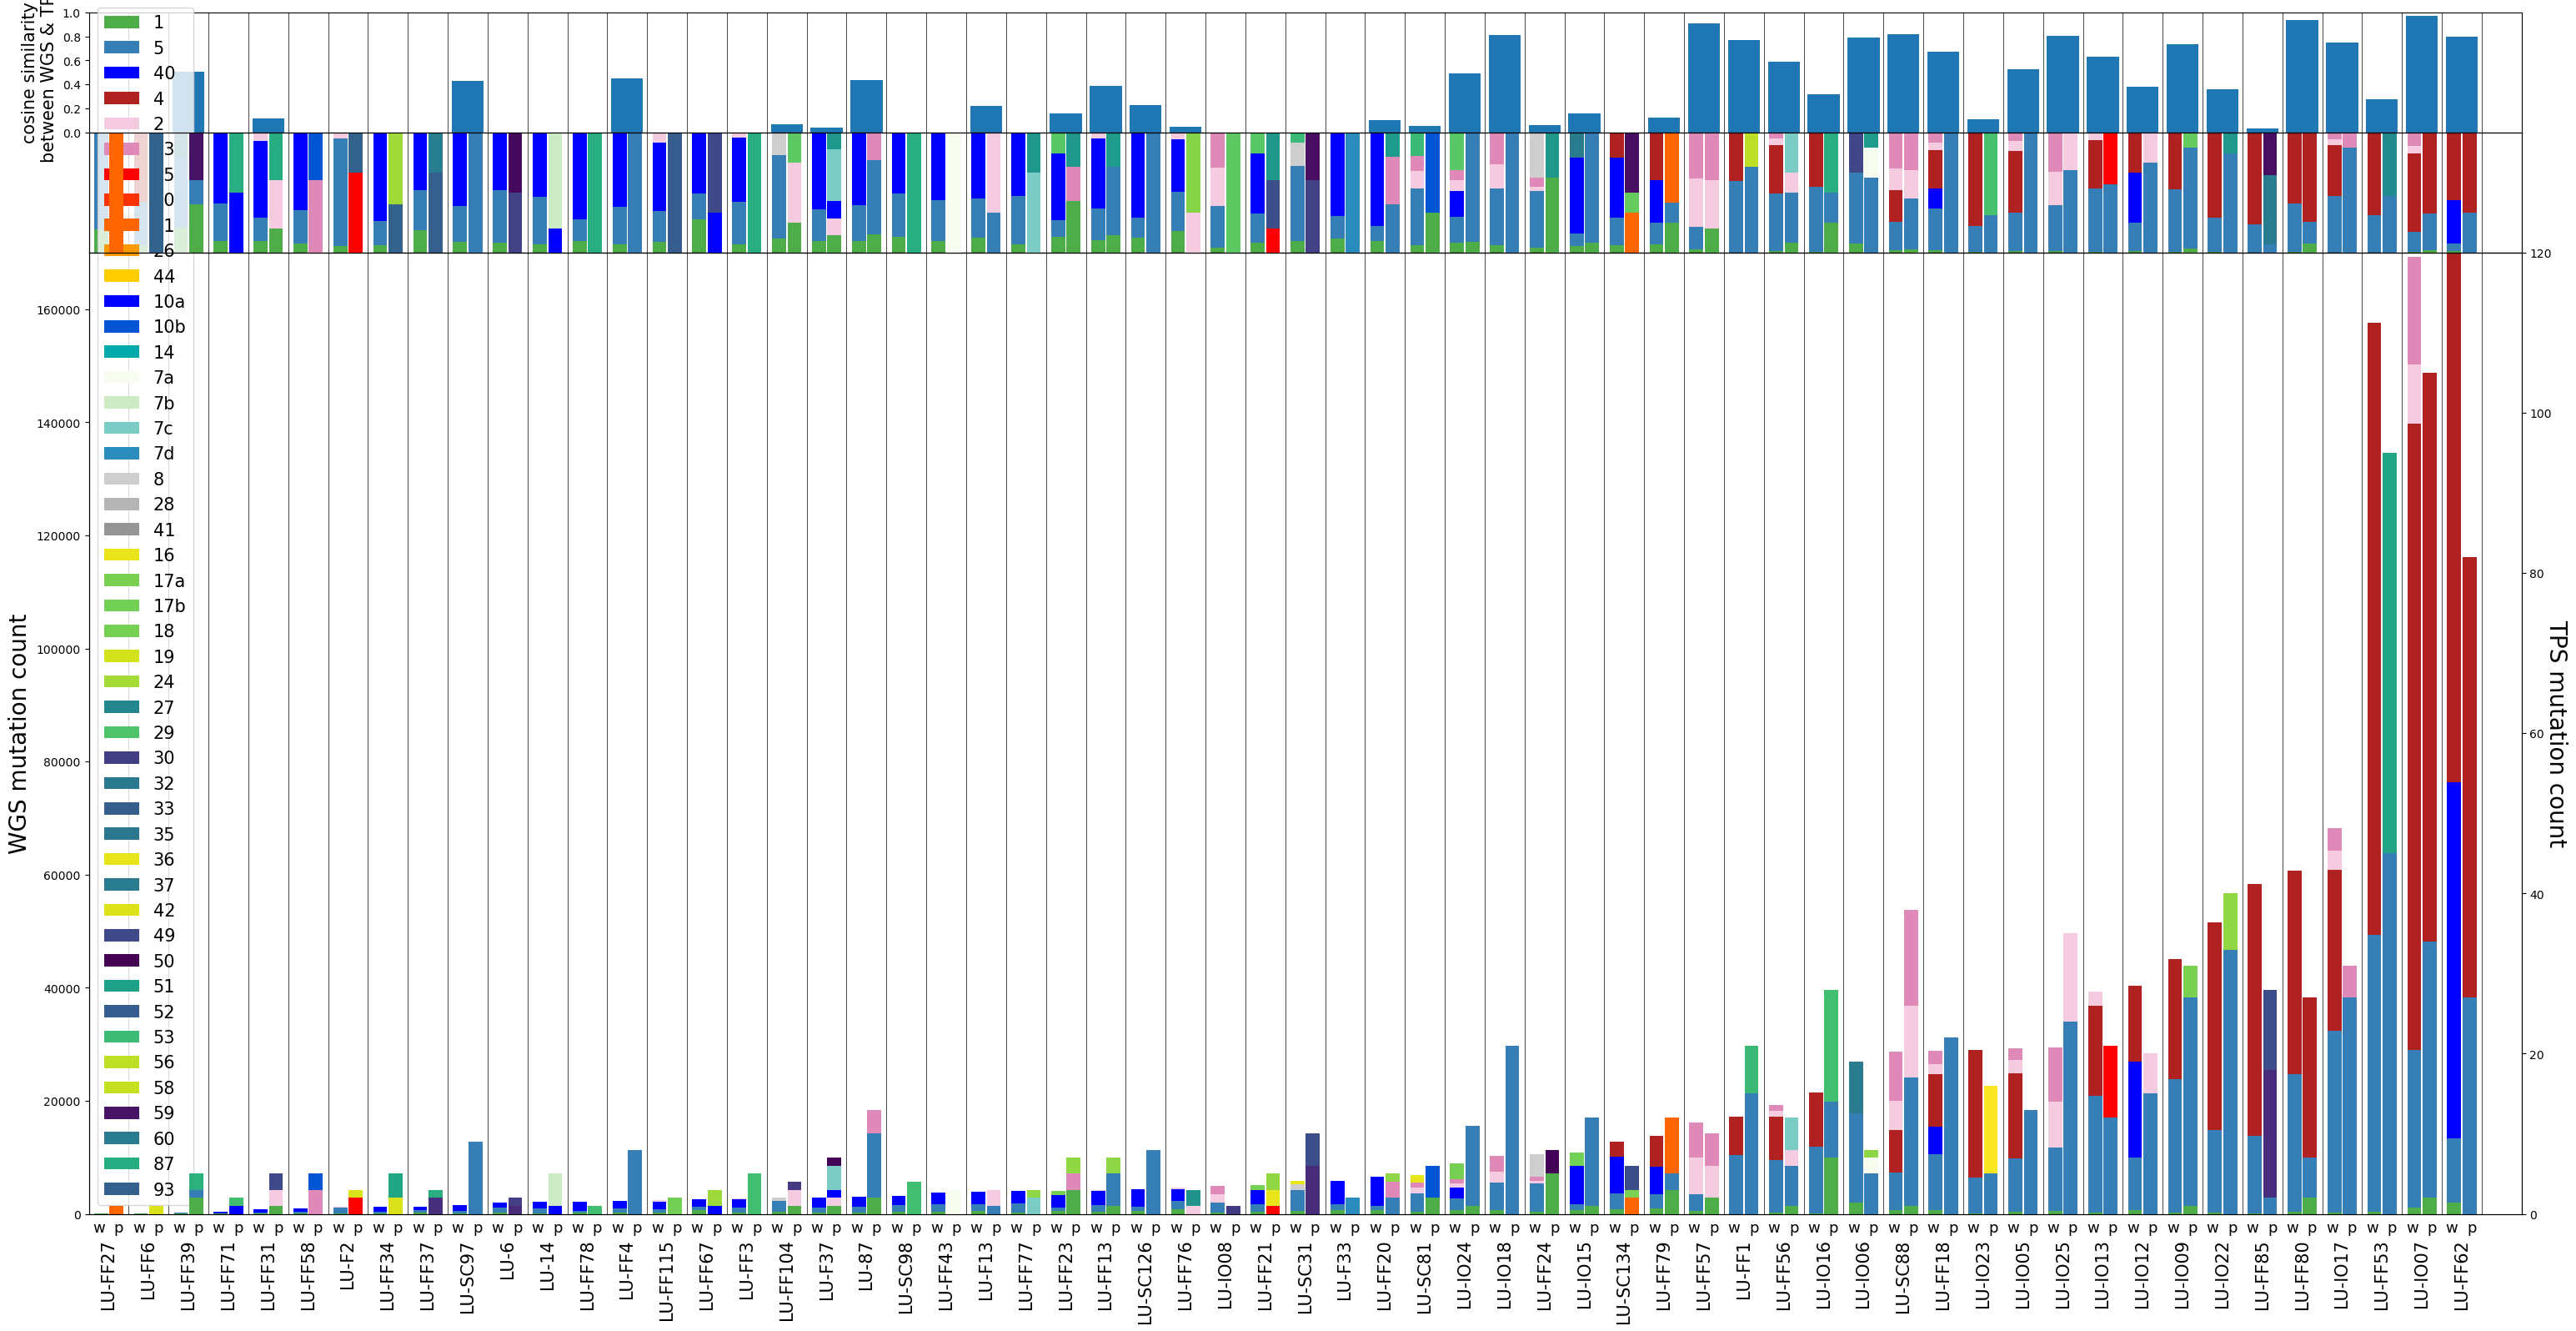

In [105]:
%matplotlib inline

# main
fig, axd = plt.subplot_mosaic(
    [
        ['cossim'],
        ['norm'],
        ['raw'],
    ],
    figsize=(30, 15),
    height_ratios=[1, 1, 8],
    gridspec_kw=dict(hspace=0),
    # sharex=True,
)
fig.tight_layout()

for ax in axd.values():
    ax.set_xlim(-0.5, len(sample_order) + 0.5)
    for x in np.arange(0.5, len(sample_order), 1):
        ax.axvline(x, color='black', linewidth=0.5)

# raw axes
axd['raw'].set_xticks(np.arange(len(sample_order)), sample_order, size=15, minor=False)
axd['raw'].tick_params(axis='x', which='major', pad=18, bottom=False, rotation=90, labelsize=15)
axd['raw'].set_xticks(np.arange(-0.25, len(sample_order) - 0.5, 0.5), np.tile(['w', 'p'], len(sample_order)), size=13, minor=True)
axd['raw'].tick_params(axis='x', which='minor', bottom=False)
axd['raw'].set_ylabel('WGS mutation count', size=20)
draw_bars(axd['raw'], exposures_wgs, sig_order, sample_order, sig_colors, 'left')

ax_raw_panel = axd['raw'].twinx()
ax_raw_panel.tick_params(axis='x', which='major', pad=18, bottom=False, rotation=90, labelsize=15)
ax_raw_panel.set_ylabel('TPS mutation count', size=20, rotation=270, labelpad=14)
draw_bars(ax_raw_panel, exposures_panel, sig_order, sample_order, sig_colors, 'right')

axd['raw'].legend(fontsize=15)
axd['raw'].set_ylim(0, 170000)
ax_raw_panel.set_ylim(0, 120)

# axd['raw'].set_yscale('log')
# ax_raw_panel.set_yscale('log')


# norm axes
exposure_wgs_norm = {sid: normalize_exposure(subdic) for sid, subdic in exposures_wgs.items()}
exposure_panel_norm = {sid: normalize_exposure(subdic) for sid, subdic in exposures_panel.items()}

axd['norm'].set_xticks([])
axd['norm'].set_yticks([])
ax_norm_panel = axd['norm'].twinx()
ax_norm_panel.set_yticks([])

draw_bars(axd['norm'], exposure_wgs_norm, sig_order, sample_order, sig_colors, shift='left')
draw_bars(ax_norm_panel, exposure_panel_norm, sig_order, sample_order, sig_colors, shift='right')

# cossim axes
cossim_dict = dict()
for sid in sample_order:
    vec_wgs = [
        exposures_wgs[sid][sig] for sig in sig_order
    ] 
    if sid in exposures_panel:
        vec_panel = [
            exposures_panel[sid][sig]
            for sig in sig_order
        ]
    else:
        vec_panel = [0] * len(sig_order)
        
    cossim_val = cosine_similarity(vec_wgs, vec_panel)
    cossim_dict[sid] = cossim_val

axd['cossim'].set_ylabel('cosine similarity\nbetween WGS & TPS', size=15)
axd['cossim'].set_ylim((0, 1))    
xs = np.arange(len(sample_order))
ys = [cossim_dict[sid] for sid in sample_order]
axd['cossim'].bar(xs, ys)

plt.show()

##### by signature class

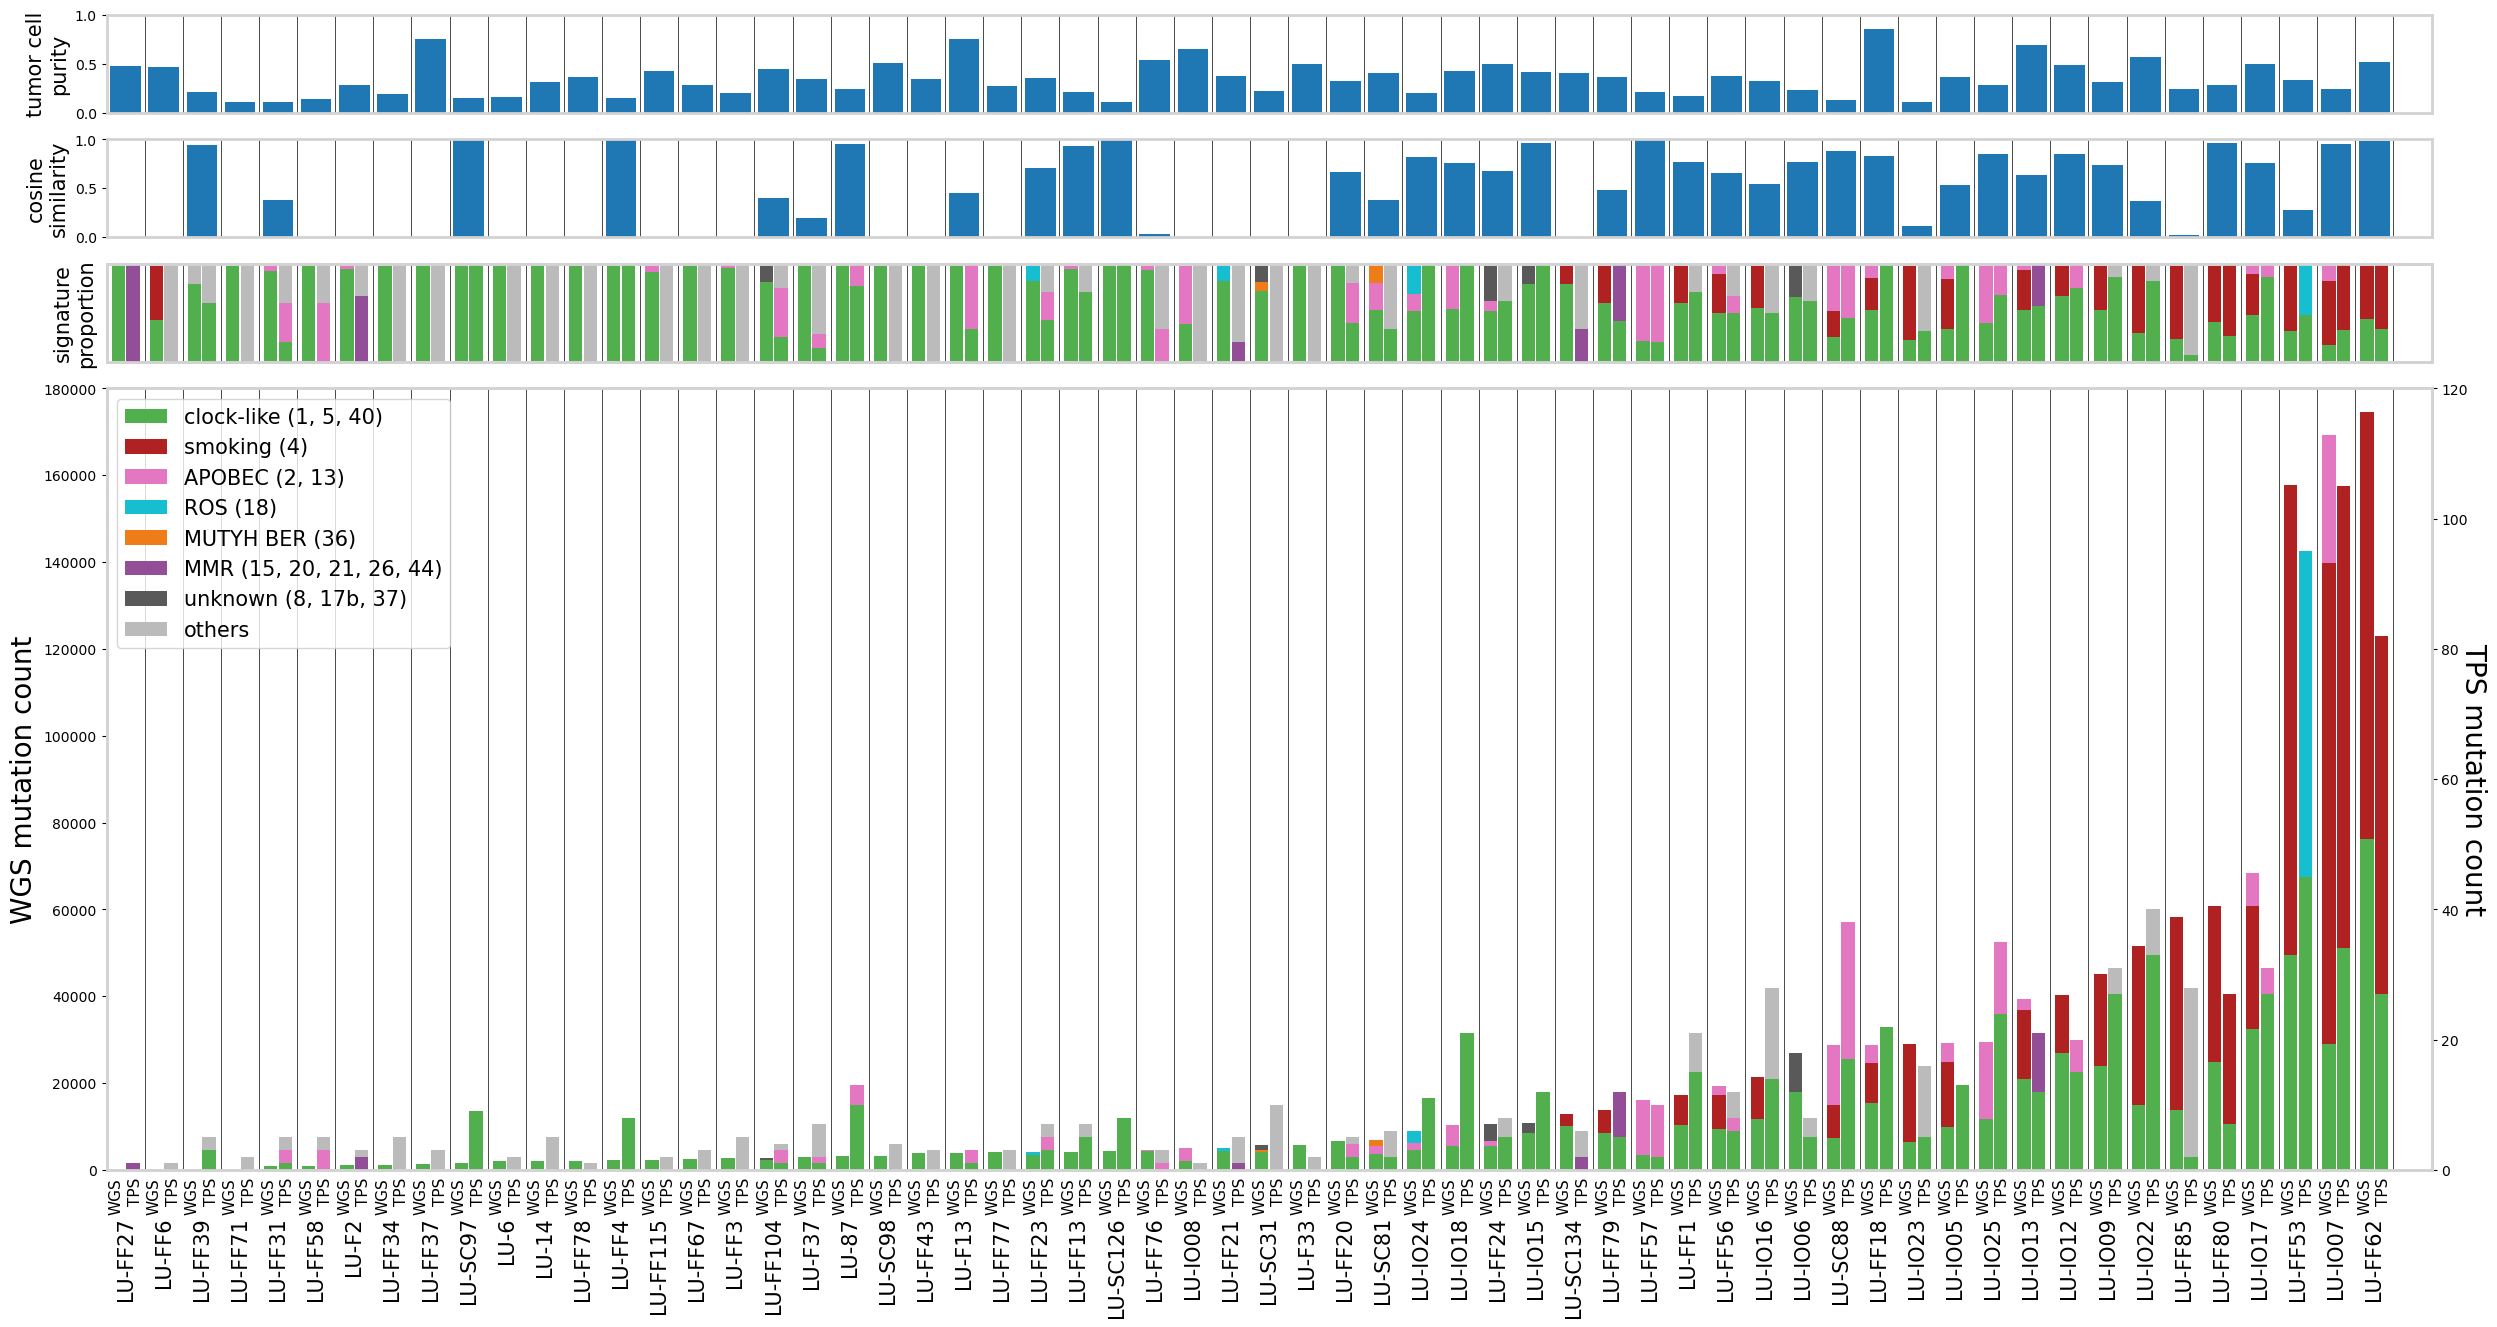

In [252]:
%matplotlib inline

# main
fig, axd = plt.subplot_mosaic(
    [
        ['cellularity'],
        ['cossim'],
        ['norm'],
        ['raw'],
    ],
    figsize=(30, 15),
    height_ratios=[1, 1, 1, 8],
    gridspec_kw=dict(hspace=0.1),
    # sharex=True,
)
# fig.tight_layout()

for ax in axd.values():
    ax.set_xlim(-0.5, len(sample_order) + 0.5)
    for x in np.arange(0.5, len(sample_order), 1):
        ax.axvline(x, color='black', linewidth=0.5)

# raw axes
axd['raw'].set_xticks(np.arange(len(sample_order)), sample_order, minor=False)
axd['raw'].tick_params(axis='x', which='major', pad=30, bottom=False, rotation=90, labelsize=15)
axd['raw'].set_xticks(np.arange(-0.25, len(sample_order) - 0.5, 0.5), np.tile(['WGS', 'TPS'], len(sample_order)), minor=True, rotation=90)
axd['raw'].tick_params(axis='x', which='minor', bottom=False, labelsize=11)
axd['raw'].set_ylabel('WGS mutation count', size=20)
draw_bars(axd['raw'], exposures_byclass_wgs, SIGID_CLASSES_ORDER, sample_order, sigclass_colors, 'left')

ax_raw_panel = axd['raw'].twinx()
ax_raw_panel.tick_params(axis='x', which='major', pad=18, bottom=False, rotation=90, labelsize=15)
ax_raw_panel.set_ylabel('TPS mutation count', size=20, rotation=270, labelpad=14)
draw_bars(ax_raw_panel, exposures_byclass_panel, SIGID_CLASSES_ORDER, sample_order, sigclass_colors, 'right')

axd['raw'].legend(fontsize=15)
axd['raw'].set_ylim(0, 180000)
ax_raw_panel.set_ylim(0, 120)

axd['raw'].legend(loc='upper left', fontsize=15)

# axd['raw'].set_yscale('log')
# ax_raw_panel.set_yscale('log')


# norm axes
exposure_wgs_norm = {sid: normalize_exposure(subdic) for sid, subdic in exposures_byclass_wgs.items()}
exposure_panel_norm = {sid: normalize_exposure(subdic) for sid, subdic in exposures_byclass_panel.items()}

axd['norm'].set_xticks([])
axd['norm'].set_yticks([])
ax_norm_panel = axd['norm'].twinx()
ax_norm_panel.set_yticks([])
axd['norm'].set_ylabel('signature\nproportion', size=15)

draw_bars(axd['norm'], exposure_wgs_norm, SIGID_CLASSES_ORDER, sample_order, sigclass_colors, shift='left')
draw_bars(ax_norm_panel, exposure_panel_norm, SIGID_CLASSES_ORDER, sample_order, sigclass_colors, shift='right')

# cossim axes
cossim_dict = dict()
for sid in sample_order:
    vec_wgs = [
        exposures_byclass_wgs[sid][sig] 
        for sig in SIGID_CLASSES_ORDER
    ] 
    if sid in exposures_panel:
        vec_panel = [
            exposures_byclass_panel[sid][sig]
            for sig in SIGID_CLASSES_ORDER
        ]
    else:
        vec_panel = [0] * len(SIGID_CLASSES_ORDER)
        
    cossim_val = cosine_similarity(vec_wgs, vec_panel)
    cossim_dict[sid] = cossim_val

axd['cossim'].set_ylabel('cosine\nsimilarity', size=15)
axd['cossim'].set_yticks([0, 0.5, 1], fontsize=10)
axd['cossim'].set_ylim((0, 1))    
xs = np.arange(len(sample_order))
ys = [cossim_dict[sid] for sid in sample_order]
axd['cossim'].bar(xs, ys)
axd['cossim'].set_xticks([])

# cellularity axes
xs = np.arange(len(sample_order))
ys = [PREVIOUS_PURITY[sid] for sid in sample_order]
axd['cellularity'].set_ylabel('tumor cell\npurity', size=15)
axd['cellularity'].set_yticks([0, 0.5, 1], fontsize=10)
axd['cellularity'].set_ylim(0, 1)
axd['cellularity'].bar(xs, ys)
axd['cellularity'].set_xticks([])
    

plt.show()

Text(140000, 0.6, 'R squared = 0.097\np-value = 0.016')

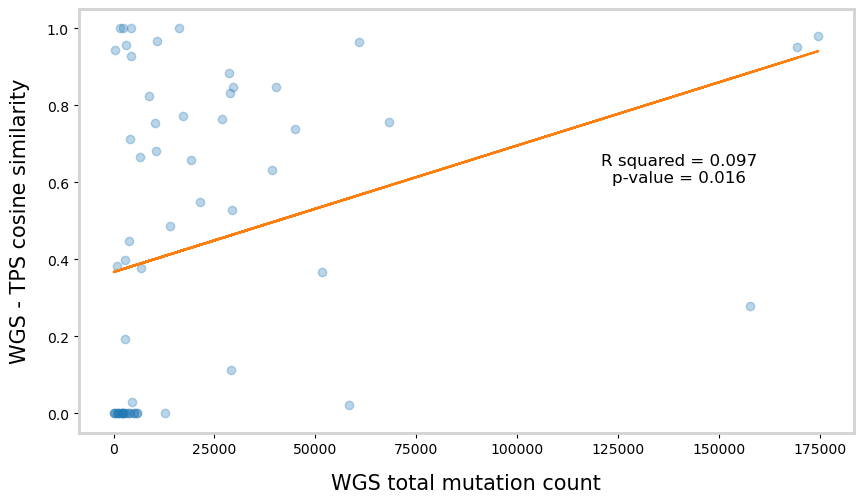

In [476]:
totburden_dict = {sid: sum(exposures_wgs[sid].values()) for sid in SAMPLEIDS_LU}
xs = np.array([totburden_dict[sid] for sid in SAMPLEIDS_LU])

ys = np.array([cossim_dict[sid] for sid in SAMPLEIDS_LU])

fig, ax = plt.subplots(figsize=(10, 5.5))

# ax.set_xscale('log')

ax.plot(xs, ys, linewidth=0, marker='o', alpha=0.3)
ax.set_xlabel('WGS total mutation count', size=15, labelpad=12)
ax.set_ylabel('WGS - TPS cosine similarity', size=15, labelpad=12)

linreg = scipy.stats.linregress(xs, ys)
ax.plot(xs, linreg.intercept + linreg.slope * xs)

ax.annotate(
    f"R squared = {round(linreg.rvalue ** 2, 3)}\np-value = {round(linreg.pvalue, 3)}",
    xy=(140000, 0.6),
    ha='center',
    size=12,
)



In [457]:
p

PearsonRResult(statistic=0.3111443400501721, pvalue=0.015528546742661074)

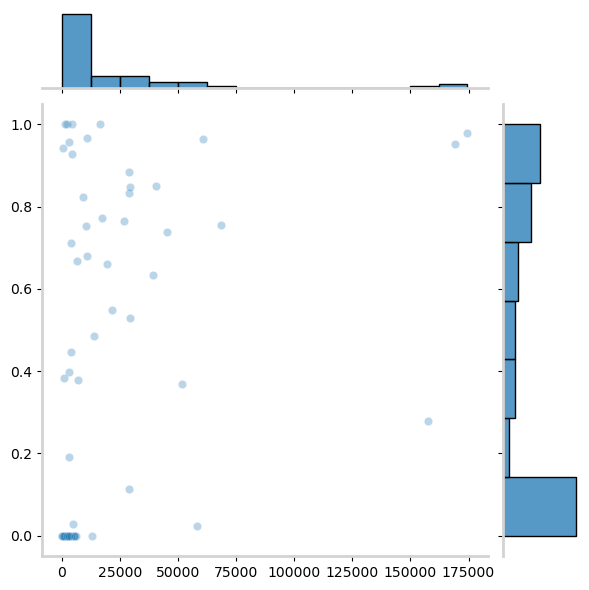

In [443]:
sns.jointplot(x=xs, y=ys, alpha=0.3)

In [235]:
show_vp_igv(filtered_panel_vplists_snv['LU-FF4'][7], 'LU-FF4')

OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK


### Signature capture sensitivity

In [305]:
apobec_exposures = dict()
apobec_exposures['wgs'] = {
    sid: exposures_wgs[sid]['2'] + exposures_wgs[sid]['13']
    for sid in exposures_wgs.keys()
}
apobec_exposures['panel'] = {
    sid: exposures_panel[sid]['2'] + exposures_panel[sid]['13']
    for sid in exposures_panel.keys()
}

In [308]:
smoking_exposures = dict()
smoking_exposures['wgs'] = {
    sid: exposures_wgs[sid]['4']
    for sid in exposures_wgs.keys()
}
smoking_exposures['panel'] = {
    sid: exposures_panel[sid]['4']
    for sid in exposures_panel.keys()
}

##### plot APOBEC sensitivity

Text(0.5, 1.1, 'APOBEC signature exposure, WGS\ncutoff = 1000')

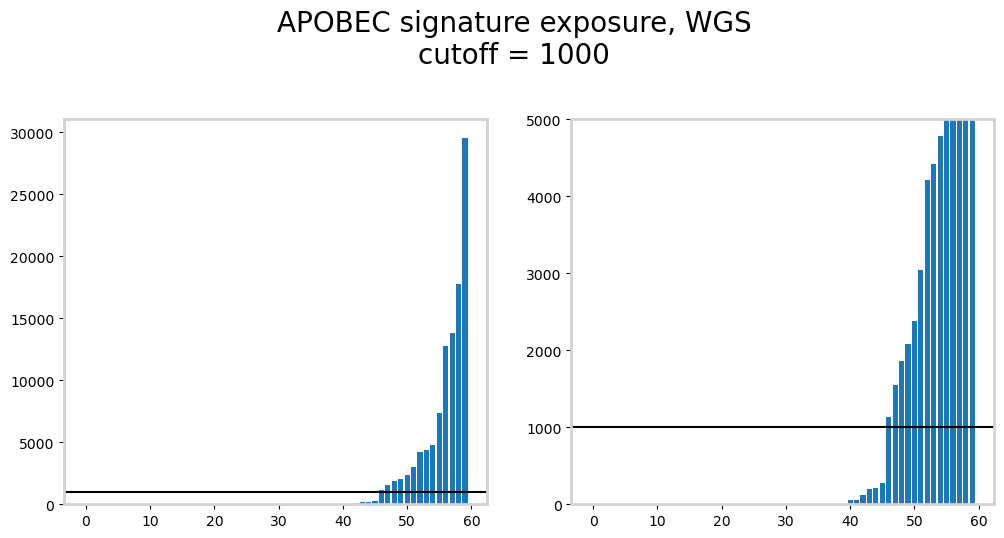

In [404]:
ys = sorted(apobec_exposures['wgs'].values())

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].bar(np.arange(len(ys)), ys)

axs[1].bar(np.arange(len(ys)), ys)
axs[1].set_ylim(0, 5000)

cutoff = 1000
axs[0].axhline(cutoff, color='k')
axs[1].axhline(cutoff, color='k')
fig.suptitle(f'APOBEC signature exposure, WGS\ncutoff = {cutoff}', size=20, y=1.1)

Text(0.5, 1.1, 'APOBEC signature exposure, TPS\ncutoff = 1')

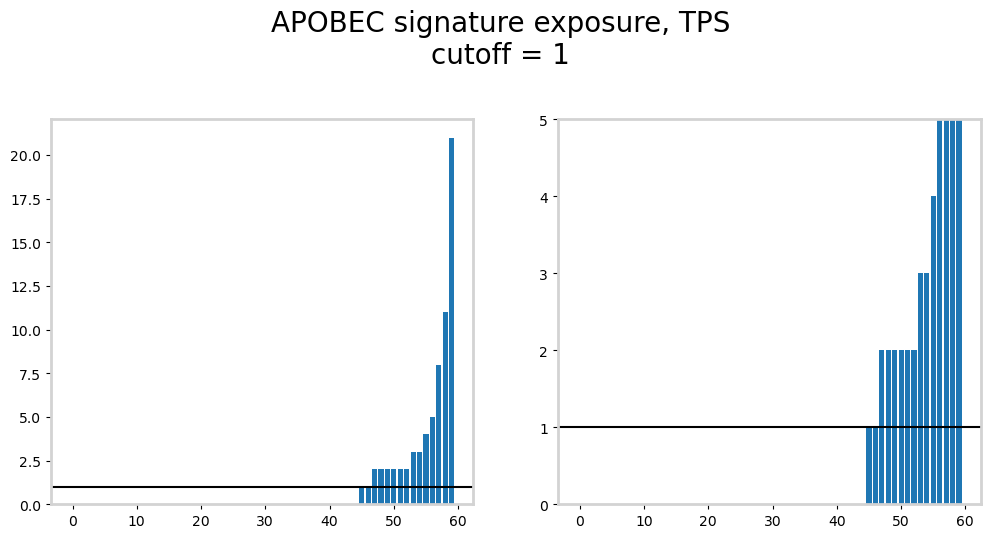

In [405]:
ys = sorted(apobec_exposures['panel'].values())

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].bar(np.arange(len(ys)), ys)

axs[1].bar(np.arange(len(ys)), ys)
axs[1].set_ylim(0, 5)

cutoff = 1
axs[0].axhline(cutoff, color='k')
axs[1].axhline(cutoff, color='k')
fig.suptitle(f'APOBEC signature exposure, TPS\ncutoff = {cutoff}', size=20, y=1.1)

Counter({(False, False): 36, (False, True): 10, (True, False): 9, (True, True): 5})


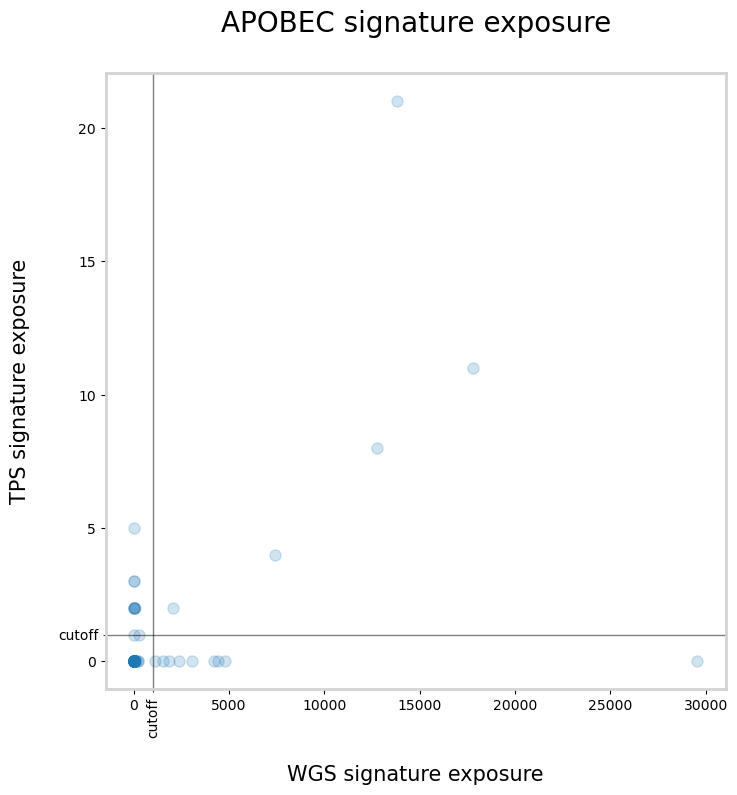

In [423]:
xs = [apobec_exposures['wgs'][sid] for sid in SAMPLEIDS_LU]
ys = [apobec_exposures['panel'][sid] for sid in SAMPLEIDS_LU]

fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(xs, ys, linestyle='', marker='o', markersize=8, alpha=0.2)
quantile = 0.85
# x_cutoff = np.quantile(xs, quantile)
x_cutoff = 1000
y_cutoff = np.quantile(ys, quantile)
y_cutoff = 1

ax.axvline(x_cutoff, color='black', alpha=0.5, linewidth=1)
ax.axhline(y_cutoff, color='black', alpha=0.5, linewidth=1)

ax.set_xlabel('WGS signature exposure', size=15, labelpad=20)
ax.set_ylabel('TPS signature exposure', size=15, labelpad=20)

ax.set_xticks([x_cutoff], minor=True)
ax.set_xticklabels(['cutoff'], minor=True, rotation=90)

ax.set_yticks([y_cutoff], minor=True)
ax.set_yticklabels(['cutoff'], minor=True, rotation=0)

ax.set_title('APOBEC signature exposure', size=20, pad=30)
# for x, y, sid in zip(xs, ys, SAMPLEIDS_LU):
#     if x > 5000 or y > 3:
#         ax.annotate(sid, (x, y), np.random.uniform(-1, 1, 2) * 10, textcoords='offset points', arrowprops=dict(width=0.1, headwidth=0), ha='center', va='center')
    
    
tfpairs = [
    (apobec_exposures['wgs'][sid] >= x_cutoff, apobec_exposures['panel'][sid] >= y_cutoff)
    for sid in SAMPLEIDS_LU
]
print(collections.Counter(tfpairs))

##### plot smoking sig sensitivity

Text(0.5, 1.1, 'smoking signature exposure, WGS\ncutoff = 5000')

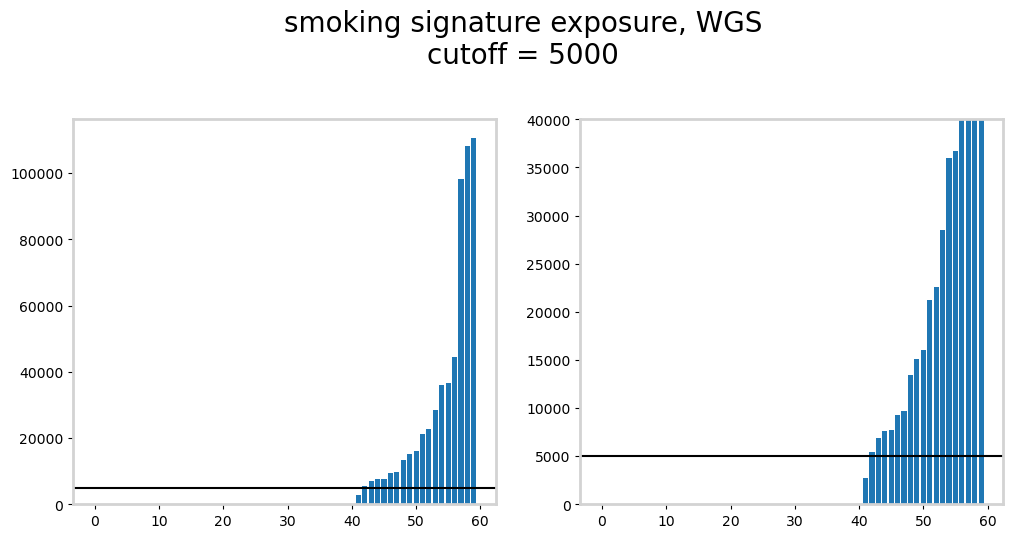

In [417]:
ys = sorted(smoking_exposures['wgs'].values())

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].bar(np.arange(len(ys)), ys)

axs[1].bar(np.arange(len(ys)), ys)
axs[1].set_ylim(0, 40000)

cutoff = 5000
axs[0].axhline(cutoff, color='k')
axs[1].axhline(cutoff, color='k')
fig.suptitle(f'smoking signature exposure, WGS\ncutoff = {cutoff}', size=20, y=1.1)

Text(0.5, 1, 'smoking signature exposure, TPS\ncutoff = 1')

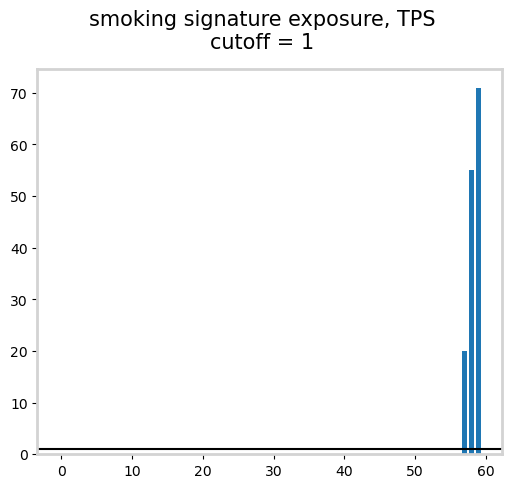

In [415]:
ys = sorted(smoking_exposures['panel'].values())

fig, ax = plt.subplots(figsize=(6, 5))

ax.bar(np.arange(len(ys)), ys)

# axs[1].bar(np.arange(len(ys)), ys)
# axs[1].set_ylim(0, 5)

cutoff = 1
ax.axhline(cutoff, color='k')
# axs[1].axhline(cutoff, color='k')
fig.suptitle(f'smoking signature exposure, TPS\ncutoff = {cutoff}', size=15, y=1)

Counter({(False, False): 42, (True, False): 15, (True, True): 3})


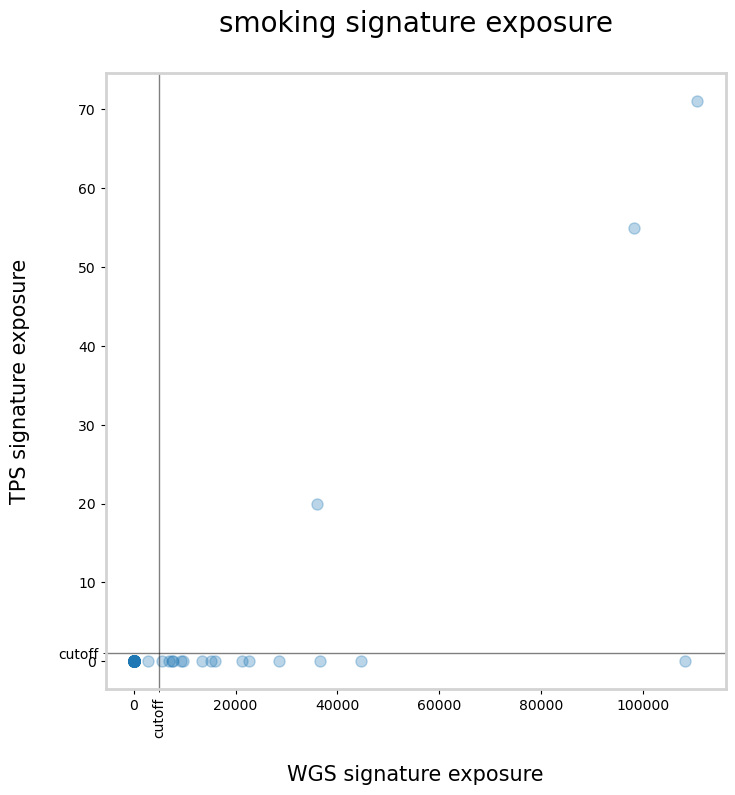

In [422]:
xs = [smoking_exposures['wgs'][sid] for sid in SAMPLEIDS_LU]
ys = [smoking_exposures['panel'][sid] for sid in SAMPLEIDS_LU]

fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(xs, ys, linestyle='', marker='o', markersize=8, alpha=0.3)
# quantile = 0.85
# x_cutoff = np.quantile(xs, quantile)
x_cutoff = 5000
# y_cutoff = np.quantile(ys, quantile)
y_cutoff = 1

ax.axvline(x_cutoff, color='black', alpha=0.5, linewidth=1)
ax.axhline(y_cutoff, color='black', alpha=0.5, linewidth=1)

ax.set_xlabel('WGS signature exposure', size=15, labelpad=20)
ax.set_ylabel('TPS signature exposure', size=15, labelpad=20)

ax.set_xticks([x_cutoff], minor=True)
ax.set_xticklabels(['cutoff'], minor=True, rotation=90)

ax.set_yticks([y_cutoff], minor=True)
ax.set_yticklabels(['cutoff'], minor=True, rotation=0)

ax.set_title('smoking signature exposure', size=20, pad=30)
# for x, y, sid in zip(xs, ys, SAMPLEIDS_LU):
#     if x > 5000 or y > 3:
#         ax.annotate(sid, (x, y), np.random.uniform(-1, 1, 2) * 10, textcoords='offset points', arrowprops=dict(width=0.1, headwidth=0), ha='center', va='center')
    
    
tfpairs = [
    (smoking_exposures['wgs'][sid] >= x_cutoff, smoking_exposures['panel'][sid] >= y_cutoff)
    for sid in SAMPLEIDS_LU
]
print(collections.Counter(tfpairs))

# SV analysis

### Find EGFR deletions

In [167]:
import handygenome.analysis.feature as anal_feature
EGFR_coord_info = anal_feature.get_gene_exon_coords(['EGFR'], 'hg19')['EGFR']
print(EGFR_coord_info)

{'chrom': '7', 'gene': range(55086713, 55324313), 'exons': [range(55086793, 55087058), range(55209978, 55210130), range(55210997, 55211181), range(55214298, 55214433), range(55218986, 55219055), range(55220238, 55220357), range(55221703, 55221845), range(55223522, 55223639), range(55224225, 55224352), range(55224451, 55224525), range(55225355, 55225446), range(55227831, 55228031), range(55229191, 55229324), range(55231425, 55231516), range(55232972, 55233130), range(55238867, 55238906), range(55240675, 55240817), range(55241613, 55241736), range(55242414, 55242513), range(55248985, 55249171), range(55259411, 55259567), range(55260458, 55260534), range(55266409, 55266556), range(55268008, 55268106), range(55268880, 55269048), range(55269427, 55269475), range(55270209, 55270318), range(55272948, 55279321)]}


In [171]:
target_range = range(EGFR_coord_info['exons'][17].start, EGFR_coord_info['exons'][19].stop)
print(target_range)

range(55241613, 55249171)


In [195]:
    import handygenome.variant.varianthandler as varianthandler

# for sid in SAMPLEIDS_LU:
    sid = SAMPLEIDS_LU[5]
    print(sid)
    vcf = pysam.VariantFile(DELLY_DEL_PATHS_WGS[sid])
    relevant_vrs = list()
    for vr in vcf.fetch():
        pos1 = vr.pos
        pos2 = int(varianthandler.parse_raw_info(vr)['END'])
        pos01 = pos1 - 1
        pos02 = pos2 - 1
        if (
            # (pos01 in target_range) and 
            # (pos02 in target_range) and
            (pos01 in EGFR_coord_info['gene']) and 
            (pos02 in EGFR_coord_info['gene']) and
            (vr.contig == EGFR_coord_info['chrom'])
        ):
            relevant_vrs.append(vr)

    for vr in relevant_vrs:
        print(vr)

LU-F33
7	55286758	DEL00000072	N	<DEL>	.	PASS	PRECISE;SVTYPE=DEL;SVMETHOD=EMBL.DELLYv0.7.3;CHR2=7;END=55289077;INSLEN=0;PE=134;MAPQ=60;CT=3to5;CIPOS=-52,52;CIEND=-52,52;SR=78;SRQ=1;CONSENSUS=GATCCAAGTCTCAGCCATGATGGGTCAACGTTTCAATACAACACATTTTAAATCCTAAGAAACAAATAATATTTTTAAATGTATTGCTTACAGGAACCAGCAACAGAAAGAGTTGCAATGTGCTTTTAAAAGGGAGTTGAAGCAGCAGGGTGTTGGGTGTTCTCAGTCCCACAAGAGAATTTATCCCTGATGCATGCAGGAATCTACTGAAAATAATTAATACCTTCTCTCCTACCCTTC;CE=1.95691;callerInfo=Delly@LU-F33.tumor	GT:GL:GQ:FT:RCL:RC:RCR:CN:DR:DV:RR:RV	0/1:-325.858,0,-45.2978:10000:PASS:1353:274:1333:0:35:108:32:125	0/1:-58.2637,0,-53.4624:10000:PASS:430:233:445:1:15:27:23:24



In [196]:
vr = relevant_vrs[0]
pos1 = vr.pos
pos2 = int(varianthandler.parse_raw_info(vr)['END'])

load_bams(sid, load_rna=True)
igv.goto([(vr.contig, pos1, pos1), (vr.contig, pos2, pos2)])

OK
OK
OK
OK
OK
OK
OK


# Driver & targetability analysis

### Pick all OncoKB-oncogenic variants from previous wgs vcf

In [477]:
ONCOGENIC_WGS_VARIANTS_TOPDIR = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/21_driver_summary/oncokb_oncogenic_variants_from_wgs'
ONCOGENIC_WGS_VARIANTS_TMP = dict()

for fname in os.listdir(ONCOGENIC_WGS_VARIANTS_TOPDIR):
    if fname.endswith('filtered_oncogenic.vcf.gz'):
        sampleid = fname.split('.')[0]
        ONCOGENIC_WGS_VARIANTS_TMP.setdefault(sampleid, dict())
        abspath = os.path.join(ONCOGENIC_WGS_VARIANTS_TOPDIR, fname)
        if 'snv' in fname:
            ONCOGENIC_WGS_VARIANTS_TMP[sampleid]['snv'] = VariantPlusList.from_vcf(abspath, logging_lineno=None, init_all_attrs=True)
        elif 'indel' in fname:
            ONCOGENIC_WGS_VARIANTS_TMP[sampleid]['indel'] = VariantPlusList.from_vcf(abspath, logging_lineno=None, init_all_attrs=True)
            
ONCOGENIC_WGS_VARIANTS = {
    key: VariantPlusList.concat([val['snv'], val['indel']])
    for key, val in ONCOGENIC_WGS_VARIANTS_TMP.items()
}

### Pick all OncoKB-targetable variants from previous wgs vcf

In [478]:
TARGETABLE_WGS_VARIANTS_TOPDIR = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/21_driver_summary/oncokb_targetable_variants_from_wgs'
TARGETABLE_WGS_VARIANTS_TMP = dict()

for fname in os.listdir(TARGETABLE_WGS_VARIANTS_TOPDIR):
    if fname.endswith('filtered_targetable.vcf.gz'):
        sampleid = fname.split('.')[0]
        TARGETABLE_WGS_VARIANTS_TMP.setdefault(sampleid, dict())
        abspath = os.path.join(TARGETABLE_WGS_VARIANTS_TOPDIR, fname)
        if 'snv' in fname:
            TARGETABLE_WGS_VARIANTS_TMP[sampleid]['snv'] = VariantPlusList.from_vcf(abspath, logging_lineno=None, init_all_attrs=True)
        elif 'indel' in fname:
            TARGETABLE_WGS_VARIANTS_TMP[sampleid]['indel'] = VariantPlusList.from_vcf(abspath, logging_lineno=None, init_all_attrs=True)
            
TARGETABLE_WGS_VARIANTS = {
    key: VariantPlusList.concat([val['snv'], val['indel']])
    for key, val in TARGETABLE_WGS_VARIANTS_TMP.items()
}

### Make a new merged driver set (230412)

In [484]:
ONCOGENIC_DRIVERS_230412 = dict()
for sampleid in SAMPLEIDS_LU:
    vplist = VariantPlusList(refver='hg19')
    for vp in ONCOGENIC_DRIVERS[sampleid]:
        vplist.append(vp)
    for vp in ONCOGENIC_WGS_VARIANTS[sampleid]:        
        if not any(
            ((vp.start0 < in_vp.end0) and (vp.end0 > in_vp.start0))
            for in_vp in vplist
        ):
            vplist.append(vp)
    
    ONCOGENIC_DRIVERS_230412[sampleid] = vplist

In [485]:
for sid, vplist in ONCOGENIC_DRIVERS_230412.items():
    sid_panel = f'{sid}_panel'
    for vp in vplist:        
        if sid_panel not in vp.readstats.keys():
            vp.readstats.update_bams(bam_dict={sid_panel: BAMS['panel'][sid]}, depth_limits=(0, -1), mq_limits=(0, -1))
            
    set_ccfinfo(vplist, sid, CNV_SEGMENTS[sid], IS_FEMALE[sid], PREVIOUS_PURITY[sid])

NameError: name 'BAMS' is not defined

### Curated important driver events

In [486]:
def postprocess_curated_drivers(data):
    for sid, vplist in data.items():
        sid_panel = f'{sid}_panel'
        for vp in vplist:        
            if sid_panel not in vp.readstats.keys():
                vp.readstats.update_bams(bam_dict={sid_panel: BAMS['panel'][sid]}, depth_limits=(0, -1), mq_limits=(0, -1))

        set_ccfinfo(vplist, sid, CNV_SEGMENTS[sid], IS_FEMALE[sid], PREVIOUS_PURITY[sid])
        
def update_panel_pon(vp, pon_samples):
    for x in pon_samples:
        if (x not in vp.readstats.keys()) or (vp.readstats[x].is_missing):
            vp.update_readstats(bam_dict={x: BAMS['panel'][x.split('_')[0]]})

In [487]:
MAIN_DRIVERS = {
    'LU-14': [{'type': 'fusion', 'kinase': 'ALK', 'partner': 'EML4', 'tlevel': 'LEVEL_1'}],
    'LU-6': [{'type': 'fusion', 'kinase': 'ALK', 'partner': 'EML4', 'tlevel': 'LEVEL_1'}],
    'LU-87': [{'type': 'mutation', 'gene': 'EGFR', 'alteration': 'L858R'}],
    'LU-F13': [{'type': 'fusion', 'kinase': 'AXL', 'partner': 'MBIP', 'tlevel': None}],
    'LU-F2': [{'type': 'fusion', 'kinase': 'ROS1', 'partner': 'CCDC6', 'tlevel': 'LEVEL_1'}],
    'LU-F33': [{'type': 'mutation', 'gene': 'EGFR', 'alteration': 'H773dup'}],
    'LU-F37': [{'type': 'fusion', 'kinase': 'RET', 'partner': 'KIF5B', 'tlevel': 'LEVEL_1'}],
    'LU-FF104': [{'type': 'mutation', 'gene': 'KRAS', 'alteration': 'G12D'}],
    'LU-FF115': [{'type': 'mutation', 'gene': 'EGFR', 'alteration': 'E746_A750del'}],
    'LU-FF13': [{'type': 'mutation', 'gene': 'EGFR', 'alteration': 'L861Q'}],
    'LU-FF20': [{'type': 'mutation', 'gene': 'EGFR', 'alteration': 'A767_V769dup'}],
    'LU-FF21': [{'type': 'mutation', 'gene': 'EGFR', 'alteration': 'L858R'}],
    'LU-FF23': [{'type': 'mutation', 'gene': 'EGFR', 'alteration': 'L858R'}],
    'LU-FF24': [{'type': 'mutation', 'gene': 'EGFR', 'alteration': 'A767_V769dup'}],
    'LU-FF3': [{'type': 'mutation', 'gene': 'EGFR', 'alteration': 'E746_A750del'}],
    'LU-FF31': [{'type': 'mutation', 'gene': 'EGFR', 'alteration': 'L858R'}],
    'LU-FF34': [
        {'type': 'mutation', 'gene': 'EGFR', 'alteration': 'G719A'},
        {'type': 'mutation', 'gene': 'EGFR', 'alteration': 'E709K'},
    ],
    'LU-FF37': [
        # {'type': 'mutation', 'gene': 'EGFR', 'alteration': 'L861Q'},
        {'type': 'fusion', 'kinase': 'ALK', 'partner': 'EML4', 'tlevel': 'LEVEL_1'},
    ],
    'LU-FF39': [
        {'type': 'mutation', 'gene': 'KRAS', 'alteration': 'G12D'},
    ],
    'LU-FF4': [
        {'type': 'mutation', 'gene': 'EGFR', 'alteration': 'E746_A750del'},
    ],
    'LU-FF43': [
        {'type': 'mutation', 'gene': 'EGFR', 'alteration': 'E746_A750del'},
    ],
    'LU-FF53': [
        {'type': 'mutation', 'gene': 'EGFR', 'alteration': 'G796C'},
    ],
    'LU-FF56': [
        {'type': 'mutation', 'gene': 'EGFR', 'alteration': 'E746_T751delinsVA'},
        {'type': 'fusion', 'kinase': 'RET', 'partner': 'ZNF33B', 'tlevel': 'LEVEL_1'},
    ],
    'LU-FF57': [
        {'type': 'fusion', 'kinase': 'RET', 'partner': 'KIF5B', 'tlevel': 'LEVEL_1'},
    ],
    'LU-FF58': [
        {'type': 'fusion', 'kinase': 'ROS1', 'partner': 'CD74', 'tlevel': 'LEVEL_1'},
    ],
    'LU-FF6': [
        {'type': 'mutation', 'gene': 'KRAS', 'alteration': 'G12C'},
    ],
    'LU-FF62': [
        {'type': 'mutation', 'gene': 'KRAS', 'alteration': 'G12C'},
    ],
    'LU-FF67': [
        {'type': 'mutation', 'gene': 'KRAS', 'alteration': 'G12D'},
    ],
    'LU-FF71': [
        {'type': 'fusion', 'kinase': 'MET', 'partner': 'CD47', 'tlevel': 'LEVEL_4'},
    ],
    'LU-FF76': [
        {'type': 'fusion', 'kinase': 'RET', 'partner': 'KIF5B', 'tlevel': 'LEVEL_1'},
    ],
    'LU-FF77': [
        {'type': 'fusion', 'kinase': 'RET', 'partner': 'KIF5B', 'tlevel': 'LEVEL_1'},
    ],
    'LU-FF78': [
        {'type': 'mutation', 'gene': 'EGFR', 'alteration': 'E746_A750del'},
    ],
    'LU-FF85': [
        {'type': 'mutation', 'gene': 'KRAS', 'alteration': 'G12V'},
    ],
    'LU-IO05': [
        {'type': 'mutation', 'gene': 'KRAS', 'alteration': 'G12C'},
    ],
    'LU-IO06': [
        {'type': 'mutation', 'gene': 'KRAS', 'alteration': 'G12D'},
    ],
    'LU-IO07': [
        {'type': 'mutation', 'gene': 'BRAF', 'alteration': 'G466R'},
    ],
    'LU-IO08': [
        {'type': 'fusion', 'kinase': 'RET', 'partner': 'CCDC6', 'tlevel': 'LEVEL_1'},
    ],
    'LU-IO15': [
        {'type': 'mutation', 'gene': 'EGFR', 'alteration': 'M277E'},
    ],
    'LU-IO22': [
        {'type': 'mutation', 'gene': 'BRAF', 'alteration': 'G466V'},
    ],
    'LU-IO24': [
        {'type': 'mutation', 'gene': 'ERBB2', 'alteration': 'Y772_A775dup'},
    ],
    'LU-SC126': [
        {'type': 'fusion', 'kinase': 'ROS1', 'partner': 'CD74', 'tlevel': 'LEVEL_1'},
    ],
    'LU-SC31': [
        {'type': 'mutation', 'gene': 'KRAS', 'alteration': 'G12V'},
    ],
    'LU-SC81': [
        {'type': 'fusion', 'kinase': 'RET', 'partner': 'KIF5B', 'tlevel': 'LEVEL_1'},
    ],
    'LU-SC97': [
        {'type': 'fusion', 'kinase': 'RET', 'partner': 'KIF5B', 'tlevel': 'LEVEL_1'},
    ],
    'LU-SC98': [
        {'type': 'fusion', 'kinase': 'NRG1', 'partner': 'CD74', 'tlevel': 'LEVEL_3'},
    ],
}

In [488]:
MAIN_DRIVER_VPLISTS = dict()
for sid, subdata in MAIN_DRIVERS.items():
    vplist = VariantPlusList(refver='hg19')
    for x in subdata:
        if x['type'] == 'fusion':
            continue
        for vp in ONCOGENIC_DRIVERS_230412[sid]:
            if any(
                (tup[0] == x['gene']) and (tup[1] == x['alteration'])
                for tup in itertools.chain.from_iterable(vp.get_alteration_strings().values())
            ):
                vplist.append(vp)
        
    if len(vplist) > 0:
        MAIN_DRIVER_VPLISTS[sid] = vplist
                    

In [491]:
import handygenome.variant.filter as libfilter

pon_samples = [x + '_panel' for x in SAMPLEIDS_LU]
tpsfilter = libfilter.get_preset_filter_panelseq(with_pon=True, pon_samples=pon_samples)

TARGETABLE_DRIVERS = dict()
for sampleid in SAMPLEIDS_LU:
    vplist = VariantPlusList(refver='hg19')
    for vp in ONCOGENIC_DRIVERS[sampleid]:
        update_panel_pon(vp, pon_samples)
        if tpsfilter.check(vp, sampleid + '_panel'):
            if (
                (vp.oncokb[0]['highestSensitiveLevel'] is not None)
                or (vp.oncokb[0]['highestResistanceLevel'] is not None)
            ):
                vplist.append(vp)
                
    for vp in TARGETABLE_WGS_VARIANTS[sampleid]:
        if not any(
            ((vp.start0 < in_vp.end0) and (vp.end0 > in_vp.start0))
            for in_vp in vplist
        ):
            vplist.append(vp)
    
    TARGETABLE_DRIVERS[sampleid] = vplist
    
postprocess_curated_drivers(TARGETABLE_DRIVERS)

In [492]:
import handygenome.variant.filter as libfilter

pon_samples = [x + '_panel' for x in SAMPLEIDS_LU]
tpsfilter = libfilter.get_preset_filter_panelseq(with_pon=True, pon_samples=pon_samples)

PUTATIVE_DRIVERS = dict()
for sampleid in SAMPLEIDS_LU:
    vplist = VariantPlusList(refver='hg19')
    for vp in ONCOGENIC_DRIVERS[sampleid]:
        update_panel_pon(vp, pon_samples)
        if tpsfilter.check(vp, sampleid + '_panel'):
            vplist.append(vp)
                
    for vp in ONCOGENIC_WGS_VARIANTS[sampleid]:
        if not any(
            ((vp.start0 < in_vp.end0) and (vp.end0 > in_vp.start0))
            for in_vp in vplist
        ):
            vplist.append(vp)
    
    if sampleid in MAIN_DRIVER_VPLISTS.keys():
        vplist = vplist.difference(MAIN_DRIVER_VPLISTS[sampleid])
    
    PUTATIVE_DRIVERS[sampleid] = vplist
    
postprocess_curated_drivers(PUTATIVE_DRIVERS)

In [493]:
PUTATIVE_DRIVERS_ONCOGENIC = {sid: vplist.filter(lambda x: x.oncokb[0]['oncogenic'] == 'Oncogenic') for sid, vplist in PUTATIVE_DRIVERS.items()}
PUTATIVE_DRIVERS_LIKELY = {sid: vplist.filter(lambda x: x.oncokb[0]['oncogenic'] == 'Likely Oncogenic') for sid, vplist in PUTATIVE_DRIVERS.items()}

### Manually curated known driver genes

In [84]:
curated_drivers = {
    'tcga_adc': [ # The Cancer Genome Atlas Research Network. Comprehensive molecular profiling of lung adenocarcinoma. Nature 511, 543–550 (2014).
        'RIT1',
        'U2AF1',
        'CDKN2A',
        'RB1',
        'SMARCA4',
        'PIK3CA',
        'ARID1A',
        'MET',
        'MGA',
        'RBM10',
        'SETD2',
        'BRAF',
        'NF1',
        'EGFR',
        'STK11',
        'KEAP1',
        'KRAS',
        'TP53',
    ],
    'tcga_sqcc': [ # The Cancer Genome Atlas Research Network. Comprehensive genomic characterization of squamous cell lung cancers. Nature 489, 519–525 (2012).
        'RB1',
        'NOTCH1',
        'NFE2L2',
        'HLA-A',
        #'MLL2', - synonym of KMT2D
        'KEAP1',
        'PIK3CA',
        'PTEN',
        'CDKN2A',
        'TP53',        
    ],
    'natgen2016_adc': [ # Cancer Genome Atlas Research Network et al. Distinct patterns of somatic genome alterations in lung adenocarcinomas and squamous cell carcinomas. Nat Genet 48, 607–616 (2016).
        'TP53',
        'KRAS',
        'KEAP1',
        'EGFR',
        'STK11',
        'SMARCA4',
        'RBM10',
        'RB1',
        'NF1',
        'ARID1A',
        'BRAF',
        'ERBB2',
        'SETD2',
        'MGA',
        #'FTSJD1', - synonym of CMTR2
        'CMTR2',
        'MET',
        'ATM',
        'CDKN2A',
        'U2AF1',
        'RIT1',
        'DOT1L',
        'ARID2',
        'SMAD4',
        'PTPRU',
        'CTNNB1',
        'ARHGEF12',
        'APC',
        'KLHL5',
        'PIK3CA',
        'PPP3CA',
        'ATF7IP',
        'KARS',
        'RAF1',
        #'MLL3', - synonym of KMT2C
        'FANCM',
        'STIM1',
        'NRAS',
        'MAP2K1',
    ],
    'natgen2016_sqcc': [ # Cancer Genome Atlas Research Network et al. Distinct patterns of somatic genome alterations in lung adenocarcinomas and squamous cell carcinomas. Nat Genet 48, 607–616 (2016).
        'TP53',
        'CDKN2A',
        'NFE2L2',
        'PTEN',
        #'MLL2', - synonym of KMT2D
        'RB1',
        'FAT1',
        'NOTCH1',
        'RASA1',
        'NF1',
        'ARID1A',
        'KDM6A',
        'PIK3CA',
        'CUL3',
        'HRAS',
        'IRF6',
        'FBXW7',
        'ARHGAP35',
        'PASK',
        'NSD1',
    ],
    'natrev2019_conventional': [ # Skoulidis, F. & Heymach, J. V. Co-occurring genomic alterations in non-small-cell lung cancer biology and therapy. Nat Rev Cancer 19, 495–509 (2019).
        'KRAS',
        'EGFR',
        'BRAF',
        'NF1',
        'ERBB2',
        'MET',
        'ALK',
        'ROS1',
        'RET',
        'MET',
        'ERBB2',
        'MAP2K1',
        'NRAS',
        'HRAS',
        'RIT1',
        'FGFR2',
        'FGFR1',
    ],
    'natrev2019_KRAS_excl': [ # Skoulidis, F. & Heymach, J. V. Co-occurring genomic alterations in non-small-cell lung cancer biology and therapy. Nat Rev Cancer 19, 495–509 (2019).
        'EGFR',
        'EML4',
        'ERBB2',
        'TP53',
        'ROS1',
    ],
    'natrev2019_KRAS_co': [ # Skoulidis, F. & Heymach, J. V. Co-occurring genomic alterations in non-small-cell lung cancer biology and therapy. Nat Rev Cancer 19, 495–509 (2019).
        #'LKB1', - synonym of STK11
        'KEAP1', 
        'ATM',
        'RBM10',
        'PTPRD',
        'U2AF1',
        'POLE',
        'NTRK3',
    ],
    'natrev2019_EGFR_excl': [ # Skoulidis, F. & Heymach, J. V. Co-occurring genomic alterations in non-small-cell lung cancer biology and therapy. Nat Rev Cancer 19, 495–509 (2019).
        'KRAS',
        'KEAP1',
        #'LKB1', - synonym of STK11
        'ALK',
        'EML4',
        'MET',
        'DDR2',
        'BRCA2',
        'PTPRT',
        'PTPRD',
        'NF1',
        #'EPHA',
        'EPHA1',
        'EPHA2',
        'EPHA3',
        'EPHA4',
        'EPHA5',
        'EPHA6',
        'EPHA7',
        'EPHA8',
        'EPHA10',
        'RET',
        #'PAK5', - synonym of PAK6
        'PAK6',
        'ERBB4',
        'KMT2C',
        'TBX3',
        'FAT1',
    ],
    'natrev2019_EGFR_co': [ # Skoulidis, F. & Heymach, J. V. Co-occurring genomic alterations in non-small-cell lung cancer biology and therapy. Nat Rev Cancer 19, 495–509 (2019).
        'TP53',
        'RB1',
        'PIK3CA',
        'CTNNB1',
    ],
    'manually_added_221113': [
        # from benchmark ppt
        'PIK3CA',
        'PIK3R1',
        'PIK3C3',
        'PIK3C2G',
        'PIK3CG',
        'PIK3R2',
        'PIK3CA',
        'ARID2',
        'CCND2',
        'DNMT3A',
        'FGFR4',
        'MTOR',
        'NCOR1',
        'NKX2-1',
        'SF3B1',
        'SMARCA2',
        'SMARCB1',
        # from TCGA paper fig 3
        'RIT1',
    ],
}

panel_genes_exon = [
    'AKT1',
    'AKT3',
    'ALK',
    'ARAF',
    'ARID1A',
    'ATM',
    'ATR',
    'AXL',
    'BRAF',
    'BRCA1',
    'BRCA2',
    'CBL',
    'CCND1',
    'CD274',
    'CDK11B',
    'CDKN2A',
    'CHEK2',
    'CREBBP',
    'CTNNB1',
    'DDR2',
    'EGFR',
    'EP300',
    'ERBB2',
    'ERBB3',
    'ERBB4',
    'FBXW7',
    'FGFR1',
    'FGFR2',
    'FGFR3',
    'HRAS',
    'IDH1',
    'IDH2',
    'IGF1R',
    'JAK2',
    'JAK3',
    'KDR',
    'KEAP1',
    'KIT',
    'KMT2D',
    'KRAS',
    'MAP2K1',
    'MAP2K2',
    'MAP2K4',
    'MDM2',
    'MET',
    'MYC',
    'MYCN',
    'NEK2',
    'NF1',
    'NFE2L2',
    'NOTCH1',
    'NRAS',
    'NRG1',
    'NTRK1',
    'NTRK2',
    'NTRK3',
    'PDGFRA',
    'PIK3CA',
    'PTEN',
    'RAF1',
    'RB1',
    'RBM10',
    'RET',
    'RIT1',
    'ROS1',
    'SDK1',
    'SETD2',
    'SMAD4',
    'SMARCA4',
    'SMG1',
    'SOX2',
    'STK11',
    'TERT',
    'TP53',
    'TP63',
]

panel_genes_intron = [
    'ALK',
    'AXL',
    'BRAF',
    'EGFR',
    'ERBB4',
    'FGFR1',
    'FGFR2',
    'FGFR3',
    'MET',
    'NRG1',
    'NTRK1',
    'NTRK2',
    'NTRK3',
    'PDGFRA',
    'RET',
    'ROS1',    
]

In [36]:
import itertools
curated_drivers_all = set(itertools.chain.from_iterable(curated_drivers.values()))
panel_genes_all = set(itertools.chain(panel_genes_exon, panel_genes_intron))
curated_plus_panel_drivers = set(itertools.chain(curated_drivers_all, panel_genes_all))

In [166]:
import handygenome.annotation.oncokb as liboncokb

ONCOKB_CANCERGENES = liboncokb.get_cancerGeneList(ONCOKB_TOKEN)
ONCOKB_TSGS = set(ONCOKB_CANCERGENES['hugoSymbol'][ONCOKB_CANCERGENES['tsg']])
ONCOKB_ONCOGENES = set(ONCOKB_CANCERGENES['hugoSymbol'][ONCOKB_CANCERGENES['oncogene']])

### Get COSMIC occurrences of each driver gene

In [324]:
import handygenome.analysis.feature as anal_feature
import handygenome.analysis.driver as anal_driver

In [320]:
driver_gene_names = set()
for vp in itertools.chain.from_iterable(ONCOGENIC_DRIVERS.values()):
    for tr in vp.transcript[0].canon_ovlp.values():
        if tr['subtype_flags']['coding']:
            driver_gene_names.add(tr['gene_name'])

In [322]:
driver_gene_occurrences = anal_driver.gene_cosmic_occurrences(driver_gene_names, 'hg19')

### Save manual curation objects

In [ ]:
import pickle

manual_svinfo_path = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/21_driver_summary/manual_sv_driver_info.pickle'
with open(manual_svinfo_path, 'wb') as outfile:
    pickle.dump(SVinfo, outfile)

### Make heatmap

#### Determine row and column orders

##### Cosmic occurrence of each gene

In [23]:
sorted(driver_gene_occurrences.items(), key=(lambda x: x[1]), reverse=True)

NameError: name 'driver_gene_occurrences' is not defined

##### Occurrence in current samples

In [450]:
CURRENT_COHORT_OCCURRENCE_GENE = dict()
CURRENT_COHORT_OCCURRENCE_PROTEIN_CHANGE = dict()
for sid, vplist in ONCOGENIC_DRIVERS.items():
    for vp in vplist:
        # if vp.oncokb[0]['oncogenic'] != 'Oncogenic':
        #     continue
            
        # genes = set()
        # for tr in vp.transcript[0].canon_ovlp.values():
        #     if tr['subtype_flags']['coding']:
        #         genes.add(tr['gene_name'])
        for gene in vp.get_gene_names(coding=True):
            CURRENT_COHORT_OCCURRENCE_GENE.setdefault(gene, 0)
            CURRENT_COHORT_OCCURRENCE_GENE[gene] += 1
        for protein_change in vp.get_protein_changes(one_letter=True):
            CURRENT_COHORT_OCCURRENCE_PROTEIN_CHANGE.setdefault(protein_change, 0)
            CURRENT_COHORT_OCCURRENCE_PROTEIN_CHANGE[protein_change] += 1

CURRENT_COHORT_OCCURRENCE_FUSION = dict()
for sid, sublist in SVdrivers.items():
    if len(sublist) == 0:
        continue
        
    kinases = set(itertools.chain(*sublist)).intersection(FUSION_KINASES)
    if len(kinases) != 1:
        raise Exception(f'More than one fusion kinases detected in sample {sid}')
    kinase = kinases.pop()
    CURRENT_COHORT_OCCURRENCE_FUSION.setdefault(kinase, 0)
    CURRENT_COHORT_OCCURRENCE_FUSION[kinase] += 1
# sorted(CURRENT_COHORT_OCCURRENCE.items(), key=(lambda x: x[1]), reverse=True)

##### Dict showing if oncogenic mutation was detected in any sample

In [444]:
ONCOGENIC_GENES = set()
for sid, vplist in ONCOGENIC_DRIVERS.items():
    for vp in vplist:
        for tr in vp.transcript[0].canon_ovlp.values():
            if tr['subtype_flags']['coding']:
                ONCOGENIC_GENES.add(tr['gene_name'])

ANY_ONCOGENIC = {x: False for x in ONCOGENIC_GENES}
for sampleid, vplist in ONCOGENIC_DRIVERS.items():
    for vp in vplist:
        if vp.oncokb[0]['oncogenic'] == 'Oncogenic':
            gene_name = vp.get_gene_names(coding=True).pop()
            ANY_ONCOGENIC[gene_name] = True

In [329]:
import operator
sorted(CURRENT_COHORT_OCCURRENCE_PROTEIN_CHANGE.items(), key=(operator.itemgetter(1)), reverse=True)

[('EGFR E746_A750del', 5),
 ('KRAS G12D', 4),
 ('EGFR L858R', 4),
 ('KRAS G12C', 3),
 ('TP53 H179R', 2),
 ('KRAS G12V', 2),
 ('TP53 G244C', 2),
 ('TP53 R282G', 2),
 ('EGFR L861Q', 2),
 ('EGFR A767_V769dup', 2),
 ('KMT2D S2216Ffs*48', 1),
 ('TP53 I255N', 1),
 ('EGFR E746_T751delinsVA', 1),
 ('TP53 C242_R248del', 1),
 ('ATM R3008C', 1),
 ('FBXW7 W566*', 1),
 ('PIK3R2 P719Afs*86', 1),
 ('TP53 G245S', 1),
 ('ATM Q2206*', 1),
 ('NF1 Q756Kfs*10', 1),
 ('SETD2 S2238Ffs*8', 1),
 ('TP53 L93Cfs*30', 1),
 ('KMT2D Q2004*', 1),
 ('TP53 I195F', 1),
 ('KEAP1 R498*', 1),
 ('KEAP1 R320L', 1),
 ('MGA G2451*', 1),
 ('CREBBP Q1259*', 1),
 ('TP53 T155_A159del', 1),
 ('SMAD4 G510*', 1),
 ('ARID1A R1335*', 1),
 ('SETD2 E1394Kfs*3', 1),
 ('APC S2572*', 1),
 ('TP53 R267W', 1),
 ('PIK3CA E542K', 1),
 ('TP53 C275F', 1),
 ('BRCA2 W2629*', 1),
 ('EGFR G796C', 1),
 ('ARID2 Q1124Sfs*32', 1),
 ('NF1 W599*', 1),
 ('STK11 A76Gfs*87', 1),
 ('STK11 V133Gfs*28', 1),
 ('EGFR E709K', 1),
 ('EGFR G719A', 1),
 ('TP53 R248W', 

In [330]:
sorted(CURRENT_COHORT_OCCURRENCE.items(), key=(operator.itemgetter(1)), reverse=True)

[('TP53', 30),
 ('EGFR', 20),
 ('KRAS', 9),
 ('KEAP1', 6),
 ('KMT2D', 4),
 ('SETD2', 4),
 ('ARID1A', 4),
 ('CREBBP', 3),
 ('STK11', 3),
 ('ATM', 2),
 ('FBXW7', 2),
 ('NF1', 2),
 ('SMAD4', 2),
 ('ARID2', 2),
 ('SMARCA4', 2),
 ('BRAF', 2),
 ('PIK3R2', 1),
 ('MGA', 1),
 ('APC', 1),
 ('PIK3CA', 1),
 ('BRCA2', 1),
 ('PTEN', 1),
 ('CTNNB1', 1),
 ('RB1', 1),
 ('CDKN2A', 1),
 ('SMARCB1', 1),
 ('SF3B1', 1),
 ('NFE2L2', 1),
 ('ERBB2', 1),
 ('FAT1', 1),
 ('KMT2C', 1)]

##### Other classification schemes

In [446]:
# Functional classificaiton of genes

DRIVER_MECHANISMS = {
    'RTK': [
        'EGFR',
        'KRAS',
        'BRAF',
        'ERBB2',        
        'NF1',  # shares a region of similarity with the catalytic domains of the mammalian p120RasGAP protein
    ],
    'PI3K': [
        'PIK3CA',
        'PIK3R2',
        'PTEN',
    ],
    'ARE': [
        'KEAP1',  # inhibitor of Nrf2 by facilitating ubiquitination
        'NFE2L2',  # alias Nrf2, transcription factor, activates antioxidant response
    ],
    'SWI/SNF': [
        'SMARCA4',  # ATPase subunit of SWI/SNF chromatin remodeling complex; the most frequently mutated chromatin remodeling ATPase in cancer
        'SMARCB1',
        'ARID1A',
        'ARID2',
    ],
    'WNT': [
        'APC',  # Binds to beta-catenin and destabilizes it; binds to microtubule to assist chromosome segregation
        'CTNNB1',  # beta-catenin
    ],
    'OTHERS': [
        'ATM',  # phosphorylates H2AX in response to ionizing radiation
        'BRCA2',
        'CDKN2A',  # CDK inhibitor
        'CREBBP',  # histone acetyltransferase; maintains cell adhesion molecules in SCLC cell line
        'FAT1',  # FAT atypical cadherin 1; 
        'FBXW7',  # a component of E3-ubiquitin ligase; majority of FBXW7 targets are known as proto-oncogenes; novel oncogenic FBXW7 mutants recently identified
        'KMT2C',  # deficiency promoted multiple-organ metastases in mice
        'KMT2D',  # also called MLL4; its deficiency upregulates pro-tumorigenic programs, including glycolysis
        'MGA',  # inhibitor of myc
        'RB1',  # regulation of DNA replication
        'SETD2',  # histone methyltransferase
        'SF3B1',  # splicing factor
        'SMAD4',  # TGF-beta signaling pathway
        'STK11',  # activates AMPK and thereby inhibits mTORC1; germline mutation Peutz-Jeghers synddrome; therapeutic implication
        'TP53',
    ],
}

In [609]:
FUSION_KINASES = {'ALK', 'AXL', 'ROS1', 'RET', 'MET', 'NRG1',}

# DETAILED_GENES
# These genes are represented along with hgvsp notation
# Criteria:
    # At least one OncoKB Oncogenic mutation
    # Protein-coding gene
    # Except TP53
DETAILED_GENES = set()
for sid, vplist in ONCOGENIC_DRIVERS.items():
    for vp in vplist:
        if vp.oncokb[0]['oncogenic'] != 'Oncogenic':
            continue
        for tr in vp.transcript[0].canon_ovlp.values():
            if tr['subtype_flags']['coding']:
                DETAILED_GENES.add(tr['gene_name'])
DETAILED_GENES.remove('TP53')

# OTHER_GENES
# These genes are represented under a single row named 'others'
# Criteria:
    # Single occurrence among current study cohort
    # Excluding RTK pathways, PI3K pathways, CDKN2A, TP53, BRCA2
OTHER_GENES = set()
# for gene_name, occurrence in CURRENT_COHORT_OCCURRENCE.items():
#     if (
#         gene_name in DETAILED_GENES or
#         gene_name in DRIVER_MECHANISMS['RTK'] or
#         gene_name in DRIVER_MECHANISMS['PI3K'] or
#         gene_name in ('CDKN2A', 'TP53', 'BRCA2')  # genes deemed to be important
#     ):
#         continue
        
#     if occurrence == 1:
#         OTHER_GENES.add(gene_name)
        

In [610]:
ALL_PROTEIN_CHANGES = set()
for sid, vplist in ONCOGENIC_DRIVERS.items():
    for vp in vplist:
        ALL_PROTEIN_CHANGES.update(vp.get_protein_changes(one_letter=True))
        

In [611]:
EGFR_CLASSES = {
    'classical': [
        'EGFR L858R',
        'EGFR T790M',
    ],
}

def get_EGFR_order(title):
    if title == 'EGFR L858R':
        return 0
    elif title == 'EGFR T790M':
        return -1
    else:
        return -2

In [612]:
from operator import itemgetter

def make_row_entries(
    SVdrivers, driver_vplists, 
    DETAILED_GENES,
    OTHER_GENES,
    CURRENT_COHORT_OCCURRENCE_GENE, 
    CURRENT_COHORT_OCCURRENCE_PROTEIN_CHANGE, 
    CURRENT_COHORT_OCCURRENCE_FUSION, 
    ANY_ONCOGENIC,
):    
    row_entries = list()

    # fusion
    found_kinases = list()
    for sid, sublist in SVdrivers.items():
        if len(sublist) == 0:
            continue

        kinases = set(itertools.chain(*sublist)).intersection(FUSION_KINASES)
        if len(kinases) != 1:
            raise Exception(f'More than one fusion kinases detected in sample {sid}')
        kinase = kinases.pop()
        
        if kinase in found_kinases:
            continue
            
        found_kinases.append(kinase)
        entry = dict(title=f'{kinase} fusion', type='fusion', gene=kinase, oncogenic=None, fusion_occurrence=CURRENT_COHORT_OCCURRENCE_FUSION[kinase])
        row_entries.append(entry)
        
    # mutations
    already_included_entries = set()
    for sampleid, vplist in driver_vplists.items():
        for vp in vplist:
            oncogenic = vp.oncokb[0]['oncogenic']
            mut_effect = vp.oncokb[0]['mutationEffect']['knownEffect']
            protein_changes = vp.get_protein_changes(one_letter=True)
            if len(protein_changes) != 1:
                raise Exception(f'More than one protein changes: {vp}')
            protein_change = protein_changes.pop()
            gene, change = protein_change.split()
            
            if gene in DETAILED_GENES:
                key = protein_change
                if key not in already_included_entries:
                    already_included_entries.add(key)
                    entry = dict(
                        title=protein_change, type='mutation', gene=gene, aachange=change, oncogenic=oncogenic, mutation_effect=mut_effect, 
                        gene_occurrence=CURRENT_COHORT_OCCURRENCE_GENE[gene],
                        protein_change_occurrence=CURRENT_COHORT_OCCURRENCE_PROTEIN_CHANGE[protein_change],
                    )
                    row_entries.append(entry)
            elif gene in OTHER_GENES:
                continue
            else:
                if gene not in already_included_entries:
                    already_included_entries.add(gene)
                    entry = dict(
                        title=gene, type='mutation', gene=gene, aachange=None, oncogenic=None, mutation_effect=None, 
                        gene_occurrence=CURRENT_COHORT_OCCURRENCE_GENE[gene],
                    )
                    row_entries.append(entry)
                    
    # sort        
    row_entries.sort(
        key=(lambda x: (
            x['type'] == 'fusion', 
            (
                CURRENT_COHORT_OCCURRENCE_FUSION[x['gene']]
                if x['gene'] in CURRENT_COHORT_OCCURRENCE_FUSION else
                0
            ),
            x['gene'] in DRIVER_MECHANISMS['RTK'],
            get_EGFR_order(x['title']),
            x['gene'] in DRIVER_MECHANISMS['PI3K'],
            (
                ANY_ONCOGENIC[x['gene']]
                if x['gene'] in ANY_ONCOGENIC else
                False
            ),
            (
                CURRENT_COHORT_OCCURRENCE_GENE[x['gene']]
                if x['gene'] in CURRENT_COHORT_OCCURRENCE_GENE else
                0
            ),
            (
                CURRENT_COHORT_OCCURRENCE_PROTEIN_CHANGE[x['title']]
                if x['title'] in CURRENT_COHORT_OCCURRENCE_PROTEIN_CHANGE else
                0
            ),
            # x['gene'] in DETAILED_GENES, 
            # x['occurrence'],
            tuple(-ord(k) for k in x['gene']),
            # x['oncogenic'],
        )), 
        reverse=True,
    )
    
    # add "others" category
    # entry = dict(title='others', type='mutation', gene='None', aachange='None', oncogenic='None')
    # row_entries.append(entry)

                    
    return row_entries[::-1]

In [585]:
def make_cell_values_bysample(row_entries, sample_ids_unsorted, sv_drivers, nonsv_drivers):
    # init
    result = dict()
    for sid in sample_ids_unsorted:
        result[sid] = dict()
        result[sid]['wgs'] = {x['title']: dict() for x in row_entries}
        result[sid]['panel'] = {x['title']: dict() for x in row_entries}
        
    # main
    for sid in sample_ids_unsorted:
        sid_wgs = f'{sid}_tumor'
        sid_panel = f'{sid}_panel'
        
        for entry in row_entries:
            cell_dict_wgs = result[sid]['wgs'][entry['title']]
            cell_dict_panel = result[sid]['panel'][entry['title']]

            if entry['type'] == 'fusion':                
                if any(
                    entry['gene'] in tup
                    for tup in sv_drivers[sid]
                ):
                    cell_dict_wgs['hit'] = True
                    cell_dict_panel['hit'] = True
                else:
                    cell_dict_wgs['hit'] = False
                    cell_dict_panel['hit'] = False
            else:
                relevant_vps = list()
                for vp in nonsv_drivers[sid]:
                    if entry['aachange'] is None:
                        is_relevant = (entry['gene'] in vp.get_gene_names())
                    else:
                        is_relevant = (entry['title'] in vp.get_protein_changes(one_letter=True))
                    
                    if is_relevant:
                        relevant_vps.append(vp)

                cell_dict_wgs['hit'] = (len(relevant_vps) > 0)
                cell_dict_panel['hit'] = (len(relevant_vps) > 0)
                
                if len(relevant_vps) == 0:
                    mutation_effect = None
                else:
                    mutation_effects = set(vp.oncokb[0]['mutationEffect']['knownEffect'] for vp in relevant_vps)
                    if len(mutation_effects) != 1:
                        raise Exception(f'More than one mutation effects: sampleid={sid}, entry={entry}, vplist={relevant_vps}')
                    mutation_effect = mutation_effects.pop()
                cell_dict_wgs['mutationEffect'] = mutation_effect
                cell_dict_panel['mutationEffect'] = mutation_effect

                cell_dict_wgs['vafs'] = [vp.get_vaf(sid_wgs, allele_index=1) for vp in relevant_vps]
                cell_dict_panel['vafs'] = [vp.get_vaf(sid_panel, allele_index=1) for vp in relevant_vps]

                cell_dict_wgs['ccfs'] = [vp.ccfinfo_wgs.ccf for vp in relevant_vps]
                cell_dict_panel['ccfs'] = [vp.ccfinfo_panel.ccf for vp in relevant_vps]

                cell_dict_wgs['CNts'] = [vp.CNcalls['CNt'] for vp in relevant_vps]
                cell_dict_panel['CNts'] = [vp.CNcalls['CNt'] for vp in relevant_vps]
                cell_dict_wgs['CNms'] = [vp.ccfinfo_wgs.CNm for vp in relevant_vps]
                cell_dict_panel['CNms'] = [vp.ccfinfo_panel.CNm for vp in relevant_vps]
                
                                    
    return result

In [619]:
mutationEffect_colormap = {
    'Gain-of-function': 'blue',
    'Likely Gain-of-function': 'cyan',
    'Likely Loss-of-function': 'pink',
    'Loss-of-function': 'red',
    'Switch-of-function': 'tab:orange',
    'Unknown': 'tab:gray',
}

In [467]:
def sort_sample_ids(all_sampleids, cell_values):
    return sorted(
        all_sampleids,
        key=(
            lambda x: tuple(
                cell_values[x]['wgs'][entry['title']]['hit'] 
                for entry in row_entries[::-1]
            )
        ),
        reverse=True,
    )

#### heatmap helper functions

In [632]:
def make_quadmesh(len_x, len_y, width_x, width_y):
    xs = np.tile(np.arange(0, (len_x + 1) * width_x, width_x), (len_y + 1, 1))
    ys = np.tile(np.arange(0, (len_y + 1) * width_y, width_y), (len_x + 1, 1)).T
    coords = np.dstack((xs, ys))
    return mpl.collections.QuadMesh(coords, edgecolors='black', facecolors='none', linewidth=0.5, zorder=2, alpha=0.5)


def setup_main(ax, samples, row_entries, split_per_sample=2):
    # ax.set_aspect(1)
    
    ax.set(
        xlim=(0, len(samples)), 
        ylim=(0, len(row_entries)),
    )
    ax.add_collection(
        make_quadmesh(
            split_per_sample * len(samples), 
            len(row_entries), 
            1 / split_per_sample, 
            1,
        )
    )
    for x in np.arange(1, len(samples), 1):
        ax.axvline(x, linewidth=1.3, color='black')

    ax.set_xticks(
        np.arange(0.5, len(samples), 1), 
        samples, 
        minor=False,
        size=8,
    )
    ax.tick_params(axis='x', which='major', bottom=False, rotation=90, pad=10)
    
    ax.set_xticks(
        np.arange(0.5 * (1 / split_per_sample), len(samples), 1 / split_per_sample), 
        np.tile(['w', 'p'], len(samples)), 
        minor=True,
    )
    ax.tick_params(axis='x', which='minor', bottom=False, rotation=0, pad=2, labelsize=8)

    ax.set_yticks(
        np.arange(0.5, len(row_entries), 1), 
        [x['title'] for x in row_entries], 
        va='center',
        size=8,
    )
    ax.tick_params(axis='y', left=False)
    

def setup_bottom(ax, samples, title):
    # ax.set_aspect(1)
    
    ax.set(xlim=(0, len(samples)), ylim=(0, 1))
    ax.add_collection(make_quadmesh(len(samples), 1, 1, 1))
    ax.tick_params(axis='both', which='both', labelbottom=False, labelleft=False, bottom=False, left=False)
    ax.set_ylabel(title, rotation=0, va='center', ha='right')

    
def setup_left(ax, row_entries, title):
    # ax.set_aspect(1)
    
    ax.set(xlim=(0, 1), ylim=(0, len(row_entries)))
    ax.add_collection(make_quadmesh(1, len_y, 1, 1))
    ax.tick_params(axis='both', which='both', labelbottom=False, labelleft=False, bottom=False, left=False)
    ax.set_xlabel(title, rotation=90, va='top', ha='center')
    

def write_bottom(fig, ax_values, ax_cb, values, cbar_min, cbar_max, round_digits=1):
    mappable = mpl.cm.ScalarMappable(
        norm=mpl.colors.Normalize(vmin=cbar_min, vmax=cbar_max), 
        # cmap=mpl.cm.cool,
        cmap=mpl.colormaps['Reds']
    )
    cb = fig.colorbar(mappable, cax=ax_cb, orientation='horizontal')
    cb.remove()
    
    for t, x in zip(
        [str(k) for k in np.round(values, round_digits)], 
        np.arange(0.5, len(values), 1),
    ):
        ax_values.annotate(t, (x, 0.5), ha='center', va='center', size=8)
    
    colors = mappable.to_rgba(values)
    pcol = mpl.collections.PatchCollection(
        [
            mpl.patches.Rectangle((x, 0), 1, 1, linewidth=0, color=c, zorder=0)
            for x, c in zip(np.arange(0, len(values), 1), colors)
        ],
        match_original=True,
    ) 
    ax_values.add_collection(pcol)
    
    
def write_left(ax, row_val_map, val_col_map, row_entries):
    patches = list()
    for ystart, row_entry in enumerate(row_entries):
        col = val_col_map[row_val_map[row_entry['title']]]
        if col is not None:
            patches.append(mpl.patches.Rectangle(
                (0, ystart), 1, 1, linewidth=0, color=col, 
                alpha=1, zorder=0,
        ))        
    ax.add_collection(
        mpl.collections.PatchCollection(patches, match_original=True)
    )
    
    
def fill_main(ax, cell_values, sample_ids, row_entries, mutationEffect_colormap, split_per_sample=2):
    def fill_mutation_cell(ax, xstart, ystart, cell_value, sid, row_entry, patches, sample_split_width):
        # ax.plot(
        #     [xstart + 0.25, xstart + 0.75], 
        #     np.array([cell_value['vafs'], cell_value['ccfs']]) + ystart,
        #     linestyle='-',
        #     linewidth=1,
        #     color='black',
        #     marker='o',
        #     markeredgewidth=0,
        #     markersize=2,
        #     markerfacecolor='tab:blue',
        #     alpha=0.4,
        # )
        
        bar_width = (sample_split_width / len(cell_value['vafs'])) / 2
        sub_xstart_list = np.linspace(
            xstart, 
            xstart + sample_split_width, 
            len(cell_value['vafs']), 
            endpoint=False,
        )
        for sub_xstart, vaf, ccf in zip(sub_xstart_list, cell_value['vafs'], cell_value['ccfs']):
            patches.append(mpl.patches.Rectangle(
                (sub_xstart, ystart), bar_width, vaf,
                color='tab:blue', alpha=0.5, zorder=0,
            ))
            patches.append(mpl.patches.Rectangle(
                (sub_xstart + bar_width, ystart), bar_width, ccf,
                color='tab:green', alpha=0.5, zorder=0,
            ))
            
        CNt = cell_value['CNts'][0]
        CNm = cell_value['CNms'][0]

        ax.text(
            xstart + 0.5 * sample_split_width, ystart + 0.25, f'{CNt}', 
            ha='center', va='center', size=6, alpha=0.8,
            fontweight='bold',
        )
        ax.text(
            xstart + 0.5 * sample_split_width, ystart + 0.75, f'{CNm}', 
            ha='center', va='center', size=6, alpha=0.8,
            fontweight='bold',
        )
        
    sample_split_width = 1 / split_per_sample
    patches = list()
    for sid, xstart in zip(sample_ids, range(0, len(sample_ids), 1)):
        # xstart_annot = xstart
        # xstart_wgs = xstart + 1 * sample_split_width
        # xstart_panel = xstart + 2 * sample_split_width

        xstart_wgs = xstart + 0 * sample_split_width
        xstart_panel = xstart + 1 * sample_split_width
        
        for ystart, row_entry in enumerate(row_entries):
            # yend = ystart + 1
            wgs_cell_value = cell_values[sid]['wgs'][row_entry['title']]
            panel_cell_value = cell_values[sid]['panel'][row_entry['title']]
            
            if row_entry['type'] == 'fusion':
                if wgs_cell_value['hit']:
                    patches.append(
                        mpl.patches.Rectangle(
                            (xstart_wgs, ystart), sample_split_width, 1, 
                            color='tab:blue', alpha=0.5, zorder=-1,
                        )
                    )
                if panel_cell_value['hit']:
                    patches.append(
                        mpl.patches.Rectangle(
                            (xstart_panel, ystart), sample_split_width, 1, 
                            color='tab:blue', alpha=0.5, zorder=-1,
                        )
                    )
            else:
                # wgs
                if (len(wgs_cell_value['vafs']) > 0) and (not np.isnan(wgs_cell_value['vafs']).all()):
                    fill_mutation_cell(ax, xstart_wgs, ystart, wgs_cell_value, sid, row_entry, patches, sample_split_width)
                # panel
                if (len(panel_cell_value['vafs']) > 0) and (not np.isnan(panel_cell_value['vafs']).all()):
                    fill_mutation_cell(ax, xstart_panel, ystart, panel_cell_value, sid, row_entry, patches, sample_split_width)
                
                if wgs_cell_value['hit']:
                    patches.append(mpl.patches.Rectangle(
                        (xstart, ystart), 1, 1,
                        edgecolor=mutationEffect_colormap[wgs_cell_value['mutationEffect']],
                        fill=False,
                        linewidth=3,
                        zorder=5,
                        alpha=1,
                    ))
                          
    ax.add_collection(mpl.collections.PatchCollection(patches, match_original=True))

#### Set parameters

In [614]:
# sample_ids = SAMPLEIDS_LU
row_entries = make_row_entries(
    SVdrivers, ONCOGENIC_DRIVERS, 
    DETAILED_GENES,
    OTHER_GENES,
    CURRENT_COHORT_OCCURRENCE_GENE, 
    CURRENT_COHORT_OCCURRENCE_PROTEIN_CHANGE, 
    CURRENT_COHORT_OCCURRENCE_FUSION, 
    ANY_ONCOGENIC,
)
cell_values = make_cell_values_bysample(row_entries, SAMPLEIDS_LU, SVdrivers, ONCOGENIC_DRIVERS)
sample_ids = sort_sample_ids(SAMPLEIDS_LU, cell_values)

In [615]:
# labeling for 'panelgene' ax
row_panelgene_map = dict()
for entry in row_entries:
    row_panelgene_map[entry['title']] = (entry['gene'] in panel_genes_all)
panelgene_col_map = {True: 'tab:red', False: None}

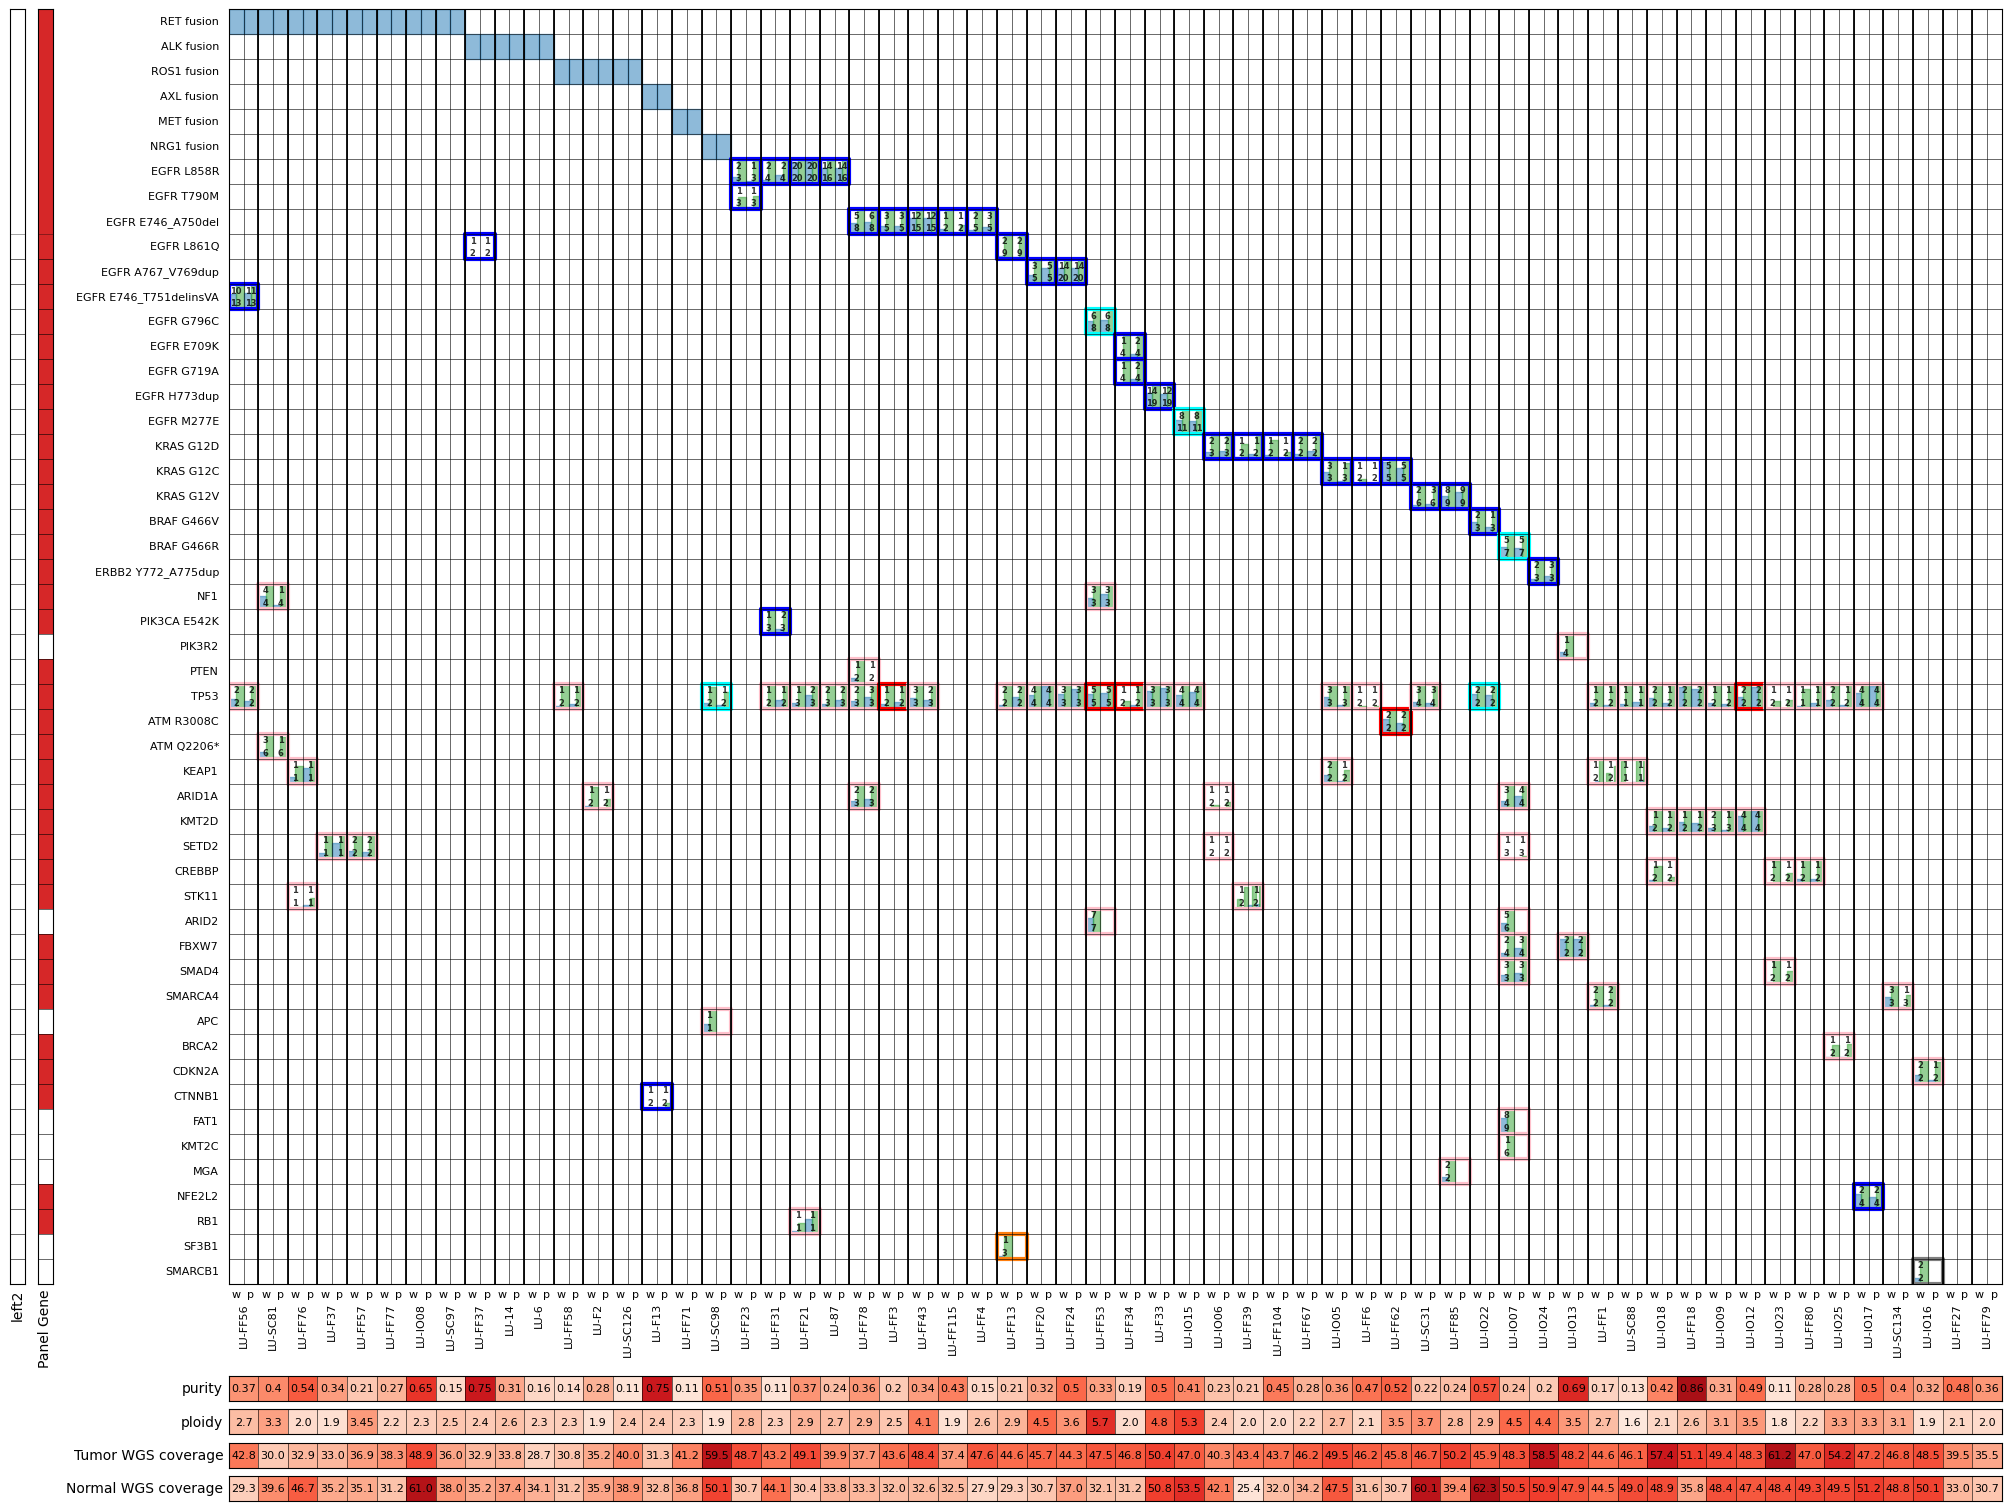

In [633]:
fig = plt.figure(
    figsize=(20, 15), 
    layout='constrained',
)

axd = fig.subplot_mosaic(
    [
        ['lleft', 'panelgene', 'main'],
        ['purity_cb', 'purity_cb', 'purity'],
        ['ploidy_cb', 'ploidy_cb', 'ploidy'],
        ['wgsCovTumor_cb', 'wgsCovTumor_cb', 'wgsCovTumor'],
        ['wgsCovNormal_cb', 'wgsCovNormal_cb', 'wgsCovNormal'],
    ],
    width_ratios=(1, 1, len(sample_ids) * 2),
    height_ratios=(len(row_entries), 1, 1, 1, 1),
)

# for ax in axd.values():
#     ax.set_aspect(1)
# # axd['main'].set_aspect(1)

setup_main(axd['main'], sample_ids, row_entries)

setup_bottom(axd['purity'], sample_ids, 'purity')
setup_bottom(axd['ploidy'], sample_ids, 'ploidy')
setup_bottom(axd['wgsCovTumor'], sample_ids, 'Tumor WGS coverage')
setup_bottom(axd['wgsCovNormal'], sample_ids, 'Normal WGS coverage')

setup_left(axd['panelgene'], row_entries, 'Panel Gene')
setup_left(axd['lleft'], row_entries, 'left2')

write_bottom(fig, axd['purity'], axd['purity_cb'], [PREVIOUS_PURITY[x] for x in sample_ids], 0, 1, round_digits=2)
write_bottom(fig, axd['ploidy'], axd['ploidy_cb'], [PREVIOUS_PLOIDY[x] for x in sample_ids], 1, 8, round_digits=2)
write_bottom(fig, axd['wgsCovTumor'], axd['wgsCovTumor_cb'], [MEAN_DEPTH_WGS_TUMOR[x] for x in sample_ids], 20, 70, round_digits=1)
write_bottom(fig, axd['wgsCovNormal'], axd['wgsCovNormal_cb'], [MEAN_DEPTH_WGS_NORMAL[x] for x in sample_ids], 20, 70, round_digits=1)

write_left(axd['panelgene'], row_panelgene_map, panelgene_col_map, row_entries)

fill_main(axd['main'], cell_values, sample_ids, row_entries, mutationEffect_colormap)

#### Re-select driver mutations, including all panel genes

### Set filter functions

In [64]:
def vpfilter_curated_driver_nonsyn(vp):
    return any(
        (
            transcript['gene_name'] in curated_drivers_all and
            transcript.consequence_flags['protein_altering'] and
            (
                (transcript['polyphen_prediction'] in (None, 'possibly_damaging', 'probably_damaging')) or
                (transcript['sift_prediction'] in (None, 'deleterious', 'deleterious_low_confidence'))
            )
        )
        for transcript in vp.transcript[0].canon_ovlp.values()
    )


def vpfilter_curated_plusPanel_nonsyn(vp):
    return any(
        (
            transcript['gene_name'] in curated_plus_panel_drivers and
            transcript.consequence_flags['protein_altering'] and
            (
                (transcript['polyphen_prediction'] in (None, 'possibly_damaging', 'probably_damaging')) or
                (transcript['sift_prediction'] in (None, 'deleterious', 'deleterious_low_confidence'))
            )
        )
        for transcript in vp.transcript[0].canon_ovlp.values()
    )


def vpfilter_curated_plusPanelPIK3_nonsyn(vp):
    return any(
        (
            (
                (transcript['gene_name'] in curated_plus_panel_drivers) or
                transcript['gene_name'].startswith('PIK3')
            ) and
            transcript.consequence_flags['protein_altering'] and
            (
                (transcript['polyphen_prediction'] in (None, 'possibly_damaging', 'probably_damaging')) or
                (transcript['sift_prediction'] in (None, 'deleterious', 'deleterious_low_confidence'))
            )
        )
        for transcript in vp.transcript[0].canon_ovlp.values()
    )


def vpfilter_pik3(vp):
    return any(
        'PIK3' in transcript['gene_name']
        for transcript in vp.transcript[0].canon_ovlp.values()
    )

In [65]:
panel_driver_withAllPanelGenes_vplists = dict()
for sampleid in SAMPLEIDS_LU:
    vplist = VariantPlusList(refver='hg19')
    for vp in itertools.chain(filtered_panel_vplists['snv'][sampleid], filtered_panel_vplists['indel'][sampleid]):
        if vpfilter_curated_plusPanelPIK3_nonsyn(vp):
            vplist.append(vp)
    panel_driver_withAllPanelGenes_vplists[sampleid] = vplist
    
wgs_driver_withAllPanelGenes_vplists = dict()
for sampleid in SAMPLEIDS_LU:
    vplist = VariantPlusList(refver='hg19')
    for vp in itertools.chain(PREVIOUS_WGS_REANNOT_VCF_SNV[sampleid], PREVIOUS_WGS_REANNOT_VCF_INDEL[sampleid]):
        if vpfilter_curated_plusPanelPIK3_nonsyn(vp):
            vplist.append(vp)
    wgs_driver_withAllPanelGenes_vplists[sampleid] = vplist

In [66]:
merged_driver_withAllPanelGenes_vplists = dict()
for sampleid in SAMPLEIDS_LU:
    vplist = VariantPlusList(refver='hg19')
    for vp in panel_driver_withAllPanelGenes_vplists[sampleid]:
        vplist.append(vp)
    for vp in wgs_driver_withAllPanelGenes_vplists[sampleid]:
        if vp.vcfspec not in [x.vcfspec for x in vplist]:
            vplist.append(vp)
    merged_driver_withAllPanelGenes_vplists[sampleid] = vplist

In [67]:
for vplist in merged_driver_withAllPanelGenes_vplists.values():
    vplist.sort()

### Manually correct vplists

In [14]:
for sampleid, vplist in merged_driver_withAllPanelGenes_vplists.items():
    if any(
        vp1.chrom == vp2.chrom and abs(vp1.pos - vp2.pos) < 100
        for vp1, vp2 in common.pairwise(vplist)
    ):
        print(sampleid)
        print(vplist)
        print()

LU-SC88
<VariantPlusList of length 10 [
	0	<VariantPlus(chrom=1, pos=27094355, ref=G, alts=('T',), gene=alt_index 0: ARID1A:p.Lys1021Asn)>
	1	<VariantPlus(chrom=1, pos=27094429, ref=G, alts=('C',), gene=alt_index 0: ARID1A:p.Arg1046Thr)>
	2	<VariantPlus(chrom=15, pos=99452053, ref=G, alts=('C',), gene=alt_index 0: IGF1R:p.Glu463Gln)>
	3	<VariantPlus(chrom=17, pos=7578266, ref=T, alts=('A',), gene=alt_index 0: TP53:p.Ile195Phe)>
	4	<VariantPlus(chrom=17, pos=29654724, ref=C, alts=('G',), gene=alt_index 0: NF1:p.His1826Asp)>
	5	<VariantPlus(chrom=19, pos=4101253, ref=C, alts=('T',), gene=alt_index 0: MAP2K2:p.Arg185Gln)>
	6	<VariantPlus(chrom=19, pos=10600363, ref=G, alts=('A',), gene=alt_index 0: KEAP1:p.Arg498Ter)>
	7	<VariantPlus(chrom=19, pos=10602619, ref=C, alts=('A',), gene=alt_index 0: KEAP1:p.Arg320Leu)>
	8	<VariantPlus(chrom=19, pos=11130307, ref=G, alts=('A',), gene=alt_index 0: SMARCA4:p.Arg849Gln)>
	9	<VariantPlus(chrom=19, pos=41736934, ref=C, alts=('T',), gene=alt_index 0:

In [247]:
# sampleid = SAMPLEIDS_LU[0]
sampleid = 'LU-SC88'

print(sampleid)
print(merged_driver_withAllPanelGenes_vplists[sampleid])

LU-SC88
<VariantPlusList of length 10 [
	0	<VariantPlus(chrom=1, pos=27094355, ref=G, alts=('T',), gene=alt_index 0: ARID1A:p.Lys1021Asn)>
	1	<VariantPlus(chrom=1, pos=27094429, ref=G, alts=('C',), gene=alt_index 0: ARID1A:p.Arg1046Thr)>
	2	<VariantPlus(chrom=15, pos=99452053, ref=G, alts=('C',), gene=alt_index 0: IGF1R:p.Glu463Gln)>
	3	<VariantPlus(chrom=17, pos=7578266, ref=T, alts=('A',), gene=alt_index 0: TP53:p.Ile195Phe)>
	4	<VariantPlus(chrom=17, pos=29654724, ref=C, alts=('G',), gene=alt_index 0: NF1:p.His1826Asp)>
	5	<VariantPlus(chrom=19, pos=4101253, ref=C, alts=('T',), gene=alt_index 0: MAP2K2:p.Arg185Gln)>
	6	<VariantPlus(chrom=19, pos=10600363, ref=G, alts=('A',), gene=alt_index 0: KEAP1:p.Arg498Ter)>
	7	<VariantPlus(chrom=19, pos=10602619, ref=C, alts=('A',), gene=alt_index 0: KEAP1:p.Arg320Leu)>
	8	<VariantPlus(chrom=19, pos=11130307, ref=G, alts=('A',), gene=alt_index 0: SMARCA4:p.Arg849Gln)>
	9	<VariantPlus(chrom=19, pos=41736934, ref=C, alts=('T',), gene=alt_index 0:

In [241]:
vp = merged_driver_withAllPanelGenes_vplists[sampleid][1]

In [242]:
show_vp_igv(vp, sampleid)

OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK


##### run realigner

In [208]:
from handygenome.align import realign
from handygenome.align import alignhandler
from handygenome.read import pileup as libpileup
from handygenome.variant import vcfspec as libvcfspec
from handygenome.annotation import readstats as libreadstats

realigned_bams_topdir = '/home/users/pjh/practice/realign'

In [199]:
nbam_path = BAM_PATHS['normal'][sampleid]
tbam_path = BAM_PATHS['tumor'][sampleid]
pbam_path = BAM_PATHS['panel'][sampleid]

nbam = BAMS['normal'][sampleid]
tbam = BAMS['tumor'][sampleid]
pbam = BAMS['panel'][sampleid]


bam_path_dict = {
    f'{sampleid}_normal': nbam_path,
    f'{sampleid}_tumor': tbam_path,
    f'{sampleid}_panel': pbam_path,    
}
bam_dict = {
    f'{sampleid}_normal': nbam,
    f'{sampleid}_tumor': tbam,
    f'{sampleid}_panel': pbam,
}
chrom = vp.chrom
start0 = vp.start0
end0 = vp.end0

In [216]:
ONCOKB_TOKEN = '864a64ee-cfa0-4b99-aa25-305fb4bcda39'

# make realginer pileup
msrpileup_ser = realign.MultisampleRealignerPileupSeries(
    chrom=chrom, 
    start0=start0, 
    end0=end0,
    bam_dict=bam_dict, 
    refver='hg19',
    inactive_padding=10,
    verbose=False,
    # start0_limit=146_993_520,
    # end0_limit=146_993_620,
    # max_pileup_width=100,
)

# make realigned bams
realigned_bam_paths = {
    key: os.path.join(realigned_bams_topdir, re.sub(r'(bam|cram)$', r'realigned.bam', os.path.basename(val)))
    for key, val in bam_path_dict.items()
}
msrpileup_ser.write_realigned_reads(realigned_bam_paths, padding=500)
realigned_bams = {key: pysam.AlignmentFile(val) for key, val in realigned_bam_paths.items()}

# make output vcfspec
realigned_vcfspec = msrpileup_ser.get_result_vcfspecs(subseq_portion_threshold=0.01)[0]
# realigned_vp = VariantPlus.from_vcfspec(realigned_vcfspec)
# realigned_vp.create_readstats(realigned_bams)

# pick relevant vcfspec
vaf_threshold = 0.07
candidate_merge_components = list()
for merge_component in realigned_vcfspec.merge_components:
    tumor_readstats = libreadstats.ReadStats.from_bam(vcfspec=merge_component, bam=tbam, fasta=FASTA_HG19, chromdict=CHROMDICT_HG19)
    panel_readstats = libreadstats.ReadStats.from_bam(vcfspec=merge_component, bam=pbam, fasta=FASTA_HG19, chromdict=CHROMDICT_HG19)
    tvaf = tumor_readstats.get_vaf()
    pvaf = panel_readstats.get_vaf()
    if tvaf >= vaf_threshold or pvaf >= vaf_threshold:
        candidate_merge_components.append(merge_component)

refined_vcfspec = functools.reduce(libvcfspec.merge, candidate_merge_components)
refined_vcfspec.refver = 'hg19'


# make vp again
realigned_vp = VariantPlus.from_vcfspec(refined_vcfspec)
realigned_vp.create_readstats(realigned_bams)
realigned_vp.create_features()
realigned_vp.create_oncokb(ONCOKB_TOKEN)

# show colored bams on IGV
for key, val in realigned_bams.items():
    realigned_vp.show_igv(igv, bam=val, tmpbam_name=f'{key}_realigned.bam', viewaspairs=False)

igv.cmd('sort POSITION')
igv.cmd('collapse')

OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK


In [217]:
realigned_vp

<VariantPlus(chrom=8, pos=32621872, ref=GG, alts=('TT',), gene=alt_index 0: NRG1:p.Gln630_Ala631delinsHisSer)>

##### Delete vp

In [245]:
del merged_driver_withAllPanelGenes_vplists[sampleid][1]

##### Add new vp

In [222]:
merged_driver_withAllPanelGenes_vplists[sampleid].append(realigned_vp)

In [ ]:
from handygenome.annotation import veplib
from handygenome import annotation
from handygenome.annotation import ensembl_feature


# new_vcfspec = Vcfspec(chrom='7', pos=55_242_466, ref='GAATTAAGAGAAGCAACA', alts=('GTTGCT',), refver='hg19')  # FF56 EGFR
# new_vcfspec = Vcfspec(chrom='4', pos=55_964_315, ref='CGGTCTCTG', alts=('CACTTGGCTGAAAT',), refver='hg19')  # FF56 KDR
new_vcfspec = Vcfspec(chrom='8', pos=32_621_872, ref='GG', alts=('TT',), refver='hg19')  # FF85 NRG1

vep_vr = veplib.run_vep_with_vcfspec(new_vcfspec, 'hg19')
vp = VariantPlus.from_vcfspec(new_vcfspec)

tabixfile_geneset = annotation.TABIXFILES_GENESET['hg19']
tabixfile_regulatory = annotation.TABIXFILES_REGULATORY['hg19']
tabixfile_repeats = annotation.TABIXFILES_REPEATS['hg19']

vp.transcript = ensembl_feature.TranscriptSetALTlist()
vp.transcript.append(ensembl_feature.TranscriptSet())

vp.regulatory = ensembl_feature.RegulatorySet()
vp.repeat = ensembl_feature.RepeatSet()
vp.motif = ensembl_feature.MotifSet()

vp.update_vep(vep_vr, alt_idx=0, distance=5000, tabixfile_geneset=tabixfile_geneset, tabixfile_regulatory=tabixfile_regulatory, tabixfile_repeats=tabixfile_repeats)


# vp.set_readstats(f'{sampleid}_tumor', BAMS['tumor'][sampleid])
# vp.set_readstats(f'{sampleid}_panel', BAMS['panel'][sampleid])
# vp.ccfinfo_wgs = vp.get_ccf_CNm(
#     segments_df=CNV_SEGMENTS[sampleid], is_female=IS_FEMALE[sampleid], cellularity=PREVIOUS_PURITY[sampleid], sampleid=f'{sampleid}_tumor',
# )
# vp.ccfinfo_panel = vp.get_ccf_CNm(
#     segments_df=CNV_SEGMENTS[sampleid], is_female=IS_FEMALE[sampleid], cellularity=PREVIOUS_PURITY[sampleid], sampleid=f'{sampleid}_tumor',
# )

# vp.oncokb = liboncokb.query_hgvsg(vp.vcfspec.to_hgvsg(), ONCOKB_TOKEN)

In [ ]:
merged_driver_withAllPanelGenes_vplists[sampleid].append(vp)

### Annotate with OncoKB data

In [250]:
ONCOKB_TOKEN = '864a64ee-cfa0-4b99-aa25-305fb4bcda39'

from handygenome.annotation import oncokb as liboncokb

for sampleid, vplist in merged_driver_withAllPanelGenes_vplists.items():
    print(sampleid)
    liboncokb.add_oncokb_info(vplist, ONCOKB_TOKEN)

LU-14
LU-6
LU-87
LU-F13
LU-F2
LU-F33
LU-F37
LU-FF1
LU-FF104
LU-FF115
LU-FF13
LU-FF18
LU-FF20
LU-FF21
LU-FF23
LU-FF24
LU-FF27
LU-FF3
LU-FF31
LU-FF34
LU-FF37
LU-FF39
LU-FF4
LU-FF43
LU-FF53
LU-FF56
LU-FF57
LU-FF58
LU-FF6
LU-FF62
LU-FF67
LU-FF71
LU-FF76
LU-FF77
LU-FF78
LU-FF79
LU-FF80
LU-FF85
LU-IO05
LU-IO06
LU-IO07
LU-IO08
LU-IO09
LU-IO12
LU-IO13
LU-IO15
LU-IO16
LU-IO17
LU-IO18
LU-IO22
LU-IO23
LU-IO24
LU-IO25
LU-SC126
LU-SC134
LU-SC31
LU-SC81
LU-SC88
LU-SC97
LU-SC98


### Update readstats

In [259]:
for sampleid, vplist in merged_driver_withAllPanelGenes_vplists.items():
    print(sampleid)
    
    bam_dict = {
        f'{sampleid}_normal': BAMS['normal'][sampleid],
        f'{sampleid}_tumor': BAMS['tumor'][sampleid],
        f'{sampleid}_panel': BAMS['panel'][sampleid],
    }
    for vp in vplist:
        if any(key not in vp.readstats_dict for key in (f'{sampleid}_normal', f'{sampleid}_tumor', f'{sampleid}_panel')):
            vp.create_readstats(bam_dict)

LU-14
LU-6
LU-87
LU-F13
LU-F2
LU-F33
LU-F37
LU-FF1
LU-FF104
LU-FF115
LU-FF13
LU-FF18
LU-FF20
LU-FF21
LU-FF23
LU-FF24
LU-FF27
LU-FF3
LU-FF31
LU-FF34
LU-FF37
LU-FF39
LU-FF4
LU-FF43
LU-FF53
LU-FF56
LU-FF57
LU-FF58
LU-FF6
LU-FF62
LU-FF67
LU-FF71
LU-FF76
LU-FF77
LU-FF78
LU-FF79
LU-FF80
LU-FF85
LU-IO05
LU-IO06
LU-IO07
LU-IO08
LU-IO09
LU-IO12
LU-IO13
LU-IO15
LU-IO16
LU-IO17
LU-IO18
LU-IO22
LU-IO23
LU-IO24
LU-IO25
LU-SC126
LU-SC134
LU-SC31
LU-SC81
LU-SC88
LU-SC97
LU-SC98


### Annotate with CNV calls and CCF

In [260]:
for sampleid, vplist in merged_driver_withAllPanelGenes_vplists.items():
    for vp in vplist:
        vp.ccfinfo_panel = dict()
        vp.ccfinfo_wgs = dict()

for sampleid, vplist in merged_driver_withAllPanelGenes_vplists.items():
    seg = CNV_SEGMENTS[sampleid]
    cellularity = PREVIOUS_PURITY[sampleid]
    is_female = IS_FEMALE[sampleid]
    # sampleid_edit = sampleid + '_panel'
    for vp in vplist:
        ccfinfo_panel = vp.get_ccf_CNm(segments_df=seg, is_female=is_female, cellularity=cellularity, sampleid=(sampleid + '_panel'))
        vp.ccfinfo_panel[sampleid] = ccfinfo_panel
        ccfinfo_wgs = vp.get_ccf_CNm(segments_df=seg, is_female=is_female, cellularity=cellularity, sampleid=(sampleid + '_tumor'))
        vp.ccfinfo_wgs[sampleid] = ccfinfo_wgs

### sort

In [261]:
for vplist in merged_driver_withAllPanelGenes_vplists.values():
    vplist.sort()

### write

In [318]:
filtered_driver_set_topdir = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/21_driver_summary/filtered_vcfs_drivergene_damaging/'
if not os.path.exists(filtered_driver_set_topdir):
    os.mkdir(filtered_driver_set_topdir)

In [319]:
for sampleid, vplist in merged_driver_withAllPanelGenes_vplists.items():
    # print(sampleid)
    outfile_path = os.path.join(filtered_driver_set_topdir, f'{sampleid}_drivers.vcf.gz')
    vplist.write(outfile_path)

### Summarizing wgs-missed drivers

In [87]:
from handygenome.cnv import misc as cnvmisc

def show_vp_details(vp, sampleid, cnv_seg=None, cellularity=None):
    if cnv_seg is None:
        cnv_seg = CNV_SEGMENTS[sampleid]
    if cellularity is None:
        cellularity = PREVIOUS_PURITY[sampleid]
    
    if cnvmisc.check_haploid(IS_FEMALE[sampleid], vp.chrom):
        CNn = 1
    else:
        CNn = 2

    hgvsp_oneletter = vp.oncokb[0]['query']['alteration']
        
    CNt, A, B = vp.fetch_cnvinfo(cnv_seg)    
    ccfinfo_wgs = vp.ccfinfo_wgs
    ccfinfo_panel = vp.ccfinfo_panel

    wgs_vaf = vp.get_vaf(f'{sampleid}_tumor')
    if ccfinfo_wgs.ccf is None:
        wgs_expected_vaf = None
    else:
        wgs_expected_vaf = cnvmisc.theoretical_somatic_vaf(CNt, ccfinfo_wgs.CNm, cellularity, ccfinfo_wgs.ccf, CNn=CNn)

    panel_vaf = vp.get_vaf(f'{sampleid}_panel')
    if ccfinfo_panel.ccf is None:
        panel_expected_vaf = None
    else:
        panel_expected_vaf = cnvmisc.theoretical_somatic_vaf(CNt, ccfinfo_panel.CNm, cellularity, ccfinfo_panel.ccf, CNn=CNn)
    
    
    print(vp)
    print('OncoKB oncogenicity', vp.oncokb[0]['oncogenic'])
    print('OncoKB mutationEffect', vp.oncokb[0]['mutationEffect']['knownEffect'])
    print('hgvsp oneletter', hgvsp_oneletter)
    print('CNt A B', CNt, A, B)
    print(f'WGS vaf={wgs_vaf}, expected_vaf={wgs_expected_vaf}, ccfinfo={ccfinfo_wgs}')
    print(f'PANEL vaf={panel_vaf}, expected_vaf={panel_expected_vaf}, ccfinfo={ccfinfo_panel}')
    print()

In [35]:
wgs_count = 0
panel_count = 0

for sampleid, vplist in merged_driver_withAllPanelGenes_vplists.items():
    sampleid_wgs = sampleid + '_tumor'
    sampleid_panel = sampleid + '_panel'
    for vp in vplist:
        if (
            vp.oncokb[0]['oncogenic'] in ('Oncogenic', 'Likely Oncogenic')
            # not (
            #     'BRAF' in vp.get_gene_names() or
            #     'EGFR' in vp.get_gene_names() or
            #     'TP53' in vp.get_gene_names() or
            #     'KRAS' in vp.get_gene_names() or
            #     any(x.startswith('PIK3') for x in vp.get_gene_names()) 
            # )
            # '' in vp.get_gene_names()
            # any(x.startswith('PIK3') for x in vp.get_gene_names()) 
        ):
            # print(sampleid) ; show_vp_details(vp)
            found_wgs = vp.readstats_dict[sampleid_wgs]['rppcounts'][1] >= 1
            found_panel = vp.readstats_dict[sampleid_panel]['rppcounts'][1] >= 1
            
            if found_wgs:
                wgs_count += 1
            if found_panel:
                panel_count += 1
            
            if found_panel and (not found_wgs):
                show_vp_details(vp, sampleid)

print()
print('wgs count', wgs_count)
print('panel count', panel_count)

<VariantPlus(vcfspec=Vcfspec(chrom='19', pos=10,602,619, ref='C', alts=('A',)), gene=(alt_index 0: KEAP1 R320L))>
Likely Oncogenic
hgvsp oneletter R320L
CNt A B 1 1 0
WGS vaf=0.0, expected_vaf=0.0, ccfinfo=CCFResult(CNm=1, ccf=0.0, mutated_allele='A')
PANEL vaf=0.14462081128747795, expected_vaf=0.06951871657754011, ccfinfo=CCFResult(CNm=1, ccf=1, mutated_allele='A')

<VariantPlus(vcfspec=Vcfspec(chrom='3', pos=47,161,944, ref='TTC', alts=('T',)), gene=(alt_index 0: SETD2 E1394Kfs*3))>
Likely Oncogenic
hgvsp oneletter E1394Kfs*3
CNt A B 2 1 1
WGS vaf=0.0, expected_vaf=0.0, ccfinfo=CCFResult(CNm=1, ccf=0.0, mutated_allele=None)
PANEL vaf=0.0072992700729927005, expected_vaf=0.0072992700729927005, ccfinfo=CCFResult(CNm=1, ccf=0.06347191367819739, mutated_allele=None)

<VariantPlus(vcfspec=Vcfspec(chrom='3', pos=41,266,136, ref='T', alts=('C',)), gene=(alt_index 0: CTNNB1 S45P))>
Likely Oncogenic
hgvsp oneletter S45P
CNt A B 2 1 1
WGS vaf=0.0, expected_vaf=0.0, ccfinfo=CCFResult(CNm=1, ccf=

In [114]:
data = list()
for sampleid, vplist in merged_driver_withAllPanelGenes_vplists.items():
    sampleid_wgs = sampleid + '_tumor'
    sampleid_panel = sampleid + '_panel'
    for vp in vplist:
        if vp.oncokb[0]['oncogenic'] in ('Oncogenic', 'Likely Oncogenic'):
            found_wgs = vp.readstats_dict[sampleid_wgs]['rppcounts'][1] >= 1
            found_panel = vp.readstats_dict[sampleid_panel]['rppcounts'][1] >= 1
            if not (found_panel and (not found_wgs)):
                continue
        else:
            continue

        CNt, A, B = vp.fetch_cnvinfo(CNV_SEGMENTS[sampleid])    
        ccfinfo_wgs = vp.ccfinfo_wgs
        ccfinfo_panel = vp.ccfinfo_panel

        wgs_vaf = vp.get_vaf(f'{sampleid}_tumor')
        wgs_avg_depth = MEAN_DEPTH_WGS_TUMOR[sampleid]
        wgs_totaldepth = vp.readstats_dict[f'{sampleid}_tumor'].get_total_rppcount()
        wgs_refreads = vp.readstats_dict[f'{sampleid}_tumor']['rppcounts'][0]
        wgs_varreads = vp.readstats_dict[f'{sampleid}_tumor']['rppcounts'][1]
        
        panel_vaf = vp.get_vaf(f'{sampleid}_panel')
        panel_totaldepth = vp.readstats_dict[f'{sampleid}_panel'].get_total_rppcount()
        panel_refreads = vp.readstats_dict[f'{sampleid}_panel']['rppcounts'][0]
        panel_varreads = vp.readstats_dict[f'{sampleid}_panel']['rppcounts'][1]
        
        found_wgs = wgs_varreads >= 1
        found_panel = panel_varreads >= 1


        
        dic = dict()
        dic['CHROM'] = vp.chrom
        dic['POS'] = vp.pos
        dic['REF'] = vp.ref
        dic['ALT'] = vp.alts[0]
        
        # dic['variant_spec'] = str(vp.vcfspec)
        dic['sample ID'] = sampleid
        dic['gene names'] = ', '.join(set(tr['gene_name'] for tr in vp.transcript[0].canon_ovlp.values() if tr['subtype_flags']['coding']))

        dic['protein alteration'] = vp.oncokb[0]['query']['alteration']
        if dic['protein alteration'] == '':
            dic['protein alteration'] = ', '.join(set(
                tr['hgvsp'].split(':p.')[1] 
                for tr in vp.transcript[0].canon_ovlp.values() 
                if tr['subtype_flags']['coding']
            ))
        
        dic['OncoKB oncogenicity'] = vp.oncokb[0]['oncogenic']
        dic['OncoKB mutation effect'] = vp.oncokb[0]['mutationEffect']['knownEffect']
        
        dic['found in wgs'] = found_wgs
        dic['found in panel'] = found_panel
        
        dic['wgs total depth'] = wgs_totaldepth
        dic['wgs average depth'] = wgs_avg_depth
        # dic['wgs ref reads'] = wgs_refreads
        # dic['wgs var reads'] = wgs_varreads
        dic['wgs vaf'] = wgs_vaf
        dic['wgs ccf'] = ccfinfo_wgs.ccf
        
        dic['panel total depth'] = panel_totaldepth
        # dic['panel ref reads'] = panel_refreads
        # dic['panel var reads'] = panel_varreads
        dic['panel vaf'] = panel_vaf
        dic['panel ccf'] = ccfinfo_panel.ccf
        
        dic['sample purity'] = PREVIOUS_PURITY[sampleid]
        dic['sample ploidy'] = PREVIOUS_PLOIDY[sampleid]
        dic['wgs copynumber total'] = CNt
        dic['wgs copynumber A'] = A
        dic['wgs copynumber B'] = B
        
        data.append(dic)

df = pd.DataFrame.from_records(data)

In [108]:
pd.options.display.max_columns = None

In [115]:
df

CHROM       POS     REF ALT sample ID gene names protein alteration  \
0    19  10602619       C   A   LU-SC88      KEAP1              R320L   
1     3  47161944     TTC   T   LU-IO06      SETD2         E1394Kfs*3   
2     3  41266136       T   C    LU-F13     CTNNB1               S45P   
3    19  10602443       C   T    LU-FF1      KEAP1              G379S   
4     7  55259524       T   A   LU-FF37       EGFR              L861Q   
5     3  47103729  CTTTAT   C   LU-IO07      SETD2        N2071Rfs*17   

  OncoKB oncogenicity   OncoKB mutation effect  found in wgs  found in panel  \
0    Likely Oncogenic  Likely Loss-of-function         False            True   
1    Likely Oncogenic  Likely Loss-of-function         False            True   
2    Likely Oncogenic         Gain-of-function         False            True   
3    Likely Oncogenic  Likely Loss-of-function         False            True   
4           Oncogenic         Gain-of-function         False            True   
5    Likely Oncogenic  Likely Loss-of-function         False            True   

   wgs total depth  wgs average depth  wgs vaf  wgs ccf  panel total depth  \
0               45            46.1059      0.0      0.0               1701   
1               44            40.2729      0.0      0.0                685   
2               29            31.2967      0.0      0.0                575   
3               59            44.5512      0.0      0.0                615   
4               23            32.9415      0.0      0.0               1124   
5               42            48.2904      0.0      0.0               1060   

   panel vaf  panel ccf  sample purity  sample ploidy  wgs copynumber total  \
0   0.144621   1.000000           0.13            1.6                     1   
1   0.007299   0.063472           0.23            2.4                     2   
2   0.083478   0.222609           0.75            2.4                     2   
3   0.035772   0.420851           0.17            2.7                     2   
4   0.009786   0.026097           0.75            2.4                     2   
5   0.011321   0.105660           0.24            4.5                     3   

   wgs copynumber A  wgs copynumber B  
0                 1                 0  
1                 1                 1  
2                 1                 1  
3                 2                 0  
4                 1                 1  
5                 3                 0

In [81]:
_sid = 'LU-SC88'
set_ccfinfo(
    vplist=merged_driver_withAllPanelGenes_vplists[_sid], 
    sampleid=_sid, 
    cnv_seg=CNV_SEGMENTS[_sid], 
    is_female=IS_FEMALE[_sid], 
    cellularity=0.24,
)

In [54]:
vp = merged_driver_withAllPanelGenes_vplists['LU-SC88'][7]
show_vp_igv(vp, 'LU-SC88')

OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK


In [82]:
merged_driver_withAllPanelGenes_vplists['LU-SC88']

<VariantPlusList of length 10 [
	0	<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=27,094,355, ref='G', alts=('T',)), gene=(alt_index 0: ARID1A K1021N))>
	1	<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=27,094,429, ref='G', alts=('C',)), gene=(alt_index 0: ARID1A R1046T))>
	2	<VariantPlus(vcfspec=Vcfspec(chrom='15', pos=99,452,053, ref='G', alts=('C',)), gene=(alt_index 0: IGF1R E463Q))>
	3	<VariantPlus(vcfspec=Vcfspec(chrom='17', pos=7,578,266, ref='T', alts=('A',)), gene=(alt_index 0: TP53 I195F))>
	4	<VariantPlus(vcfspec=Vcfspec(chrom='17', pos=29,654,724, ref='C', alts=('G',)), gene=(alt_index 0: NF1 H1826D))>
	5	<VariantPlus(vcfspec=Vcfspec(chrom='19', pos=4,101,253, ref='C', alts=('T',)), gene=(alt_index 0: MAP2K2 R185Q))>
	6	<VariantPlus(vcfspec=Vcfspec(chrom='19', pos=10,600,363, ref='G', alts=('A',)), gene=(alt_index 0: KEAP1 R498*))>
	7	<VariantPlus(vcfspec=Vcfspec(chrom='19', pos=10,602,619, ref='C', alts=('A',)), gene=(alt_index 0: KEAP1 R320L))>
	8	<VariantPlus(vcfspec=Vcfspec(c

In [83]:
ONCOGENIC_DRIVERS['LU-SC88']

<VariantPlusList of length 3 [
	0	<VariantPlus(vcfspec=Vcfspec(chrom='17', pos=7,578,266, ref='T', alts=('A',)), gene=(alt_index 0: TP53 I195F))>
	1	<VariantPlus(vcfspec=Vcfspec(chrom='19', pos=10,600,363, ref='G', alts=('A',)), gene=(alt_index 0: KEAP1 R498*))>
	2	<VariantPlus(vcfspec=Vcfspec(chrom='19', pos=10,602,619, ref='C', alts=('A',)), gene=(alt_index 0: KEAP1 R320L))>
]

In [84]:
show_vp_details(ONCOGENIC_DRIVERS['LU-SC88'][0], 'LU-SC88')

<VariantPlus(vcfspec=Vcfspec(chrom='17', pos=7,578,266, ref='T', alts=('A',)), gene=(alt_index 0: TP53 I195F))>
OncoKB oncogenicity Likely Oncogenic
OncoKB mutationEffect Likely Loss-of-function
hgvsp oneletter I195F
CNt A B 1 1 0
WGS vaf=0.2, expected_vaf=0.06951871657754011, ccfinfo=CCFResult(CNm=1, ccf=1, mutated_allele='A')
PANEL vaf=0.25914634146341464, expected_vaf=0.06951871657754011, ccfinfo=CCFResult(CNm=1, ccf=1, mutated_allele='A')



In [104]:
show_vp_details(merged_driver_withAllPanelGenes_vplists['LU-SC88'][9], 'LU-SC88', cellularity=0.24)

<VariantPlus(vcfspec=Vcfspec(chrom='19', pos=41,736,934, ref='C', alts=('T',)), gene=(alt_index 0: AXL R217C))>
OncoKB oncogenicity Unknown
OncoKB mutationEffect Unknown
hgvsp oneletter R217C
CNt A B 0 0 0
WGS vaf=0.2727272727272727, expected_vaf=None, ccfinfo=CCFResult(CNm=None, ccf=None, mutated_allele=None)
PANEL vaf=0.17989417989417988, expected_vaf=None, ccfinfo=CCFResult(CNm=None, ccf=None, mutated_allele=None)



In [275]:
driver_summary_for_abstract_path = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/driver_summary_for_abstract.tsv.gz'
df.to_csv(driver_summary_for_abstract_path, sep='\t', index=False)

# Abstract data preparation - AACR

In [262]:
sampleid = SAMPLEIDS_LU[6]
print(sampleid)

LU-F37


In [ ]:
gene_pairs = set()
for sampleid, l in SVinfo['wgs'].items():
    for dic in l:
        gene_pairs.add(
            tuple(
                sorted(dic['genes'], key=(lambda x: str(x)))
            )
        )

for sampleid, l in SVinfo['panel'].items():
    for dic in l:
        gene_pairs.add(
            tuple(
                sorted(dic['genes'], key=(lambda x: str(x)))
            )
        )

In [ ]:
driver_fusion_genes_list = [
    ('ALK', 'EML4'),
    # ('ARID1A', 'KDF1'),
    ('AXL', 'MBIP'),
    # ('AXL', None),
    ('CCDC6', 'RET'),
    ('CCDC6', 'ROS1'),
    ('CD47', 'MET'),
    ('CD74', 'NRG1'),
    ('CD74', 'ROS1'),
    # ('CDKN2A', None),
    # ('DNMT1', 'KEAP1'),
    # ('EGFR', 'SDHAP3'),
    # ('EGFR', None),
    # ('ERBB4', None),
    # ('FGFR1', 'FGFR1'),
    ('FRMD4A', 'RET'),
    ('KIF5B', 'RET'),
    ('MET', None),
    ('NRG1', 'NRG1'),
    ('PIK3CA', 'SKIL'),
    ('RET', 'ZNF33B'),
    ('ROS1', 'ZDHHC14'),
    (None, 'PDGFRA'),
]

In [346]:
from handygenome.cnv import misc as cnvmisc

def show_vp_details(vp, sampleid):
    if cnvmisc.check_haploid(IS_FEMALE[sampleid], vp.chrom):
        CNn = 1
    else:
        CNn = 2

    hgvsp_oneletter = vp.oncokb[0]['query']['alteration']
        
    CNt, A, B = vp.fetch_cnvinfo(CNV_SEGMENTS[sampleid])    
    ccfinfo_wgs = vp.ccfinfo_wgs
    ccfinfo_panel = vp.ccfinfo_panel

    wgs_vaf = vp.get_vaf(f'{sampleid}_tumor')
    if ccfinfo_wgs.ccf is None:
        wgs_expected_vaf = None
    else:
        wgs_expected_vaf = cnvmisc.theoretical_somatic_vaf(CNt, ccfinfo_wgs.CNm, PREVIOUS_PURITY[sampleid], ccfinfo_wgs.ccf, CNn=CNn)

    panel_vaf = vp.get_vaf(f'{sampleid}_panel')
    if ccfinfo_panel.ccf is None:
        panel_expected_vaf = None
    else:
        panel_expected_vaf = cnvmisc.theoretical_somatic_vaf(CNt, ccfinfo_panel.CNm, PREVIOUS_PURITY[sampleid], ccfinfo_panel.ccf, CNn=CNn)
    
    
    print(vp)
    print(vp.oncokb[0]['oncogenic'])
    print('hgvsp oneletter', hgvsp_oneletter)
    print('CNt A B', CNt, A, B)
    print(f'WGS vaf={wgs_vaf}, expected_vaf={wgs_expected_vaf}, ccfinfo={ccfinfo_wgs}')
    print(f'PANEL vaf={panel_vaf}, expected_vaf={panel_expected_vaf}, ccfinfo={ccfinfo_panel}')
    print()

In [35]:
wgs_count = 0
panel_count = 0

for sampleid, vplist in merged_driver_withAllPanelGenes_vplists.items():
    sampleid_wgs = sampleid + '_tumor'
    sampleid_panel = sampleid + '_panel'
    for vp in vplist:
        if (
            vp.oncokb[0]['oncogenic'] in ('Oncogenic', 'Likely Oncogenic')
            # not (
            #     'BRAF' in vp.get_gene_names() or
            #     'EGFR' in vp.get_gene_names() or
            #     'TP53' in vp.get_gene_names() or
            #     'KRAS' in vp.get_gene_names() or
            #     any(x.startswith('PIK3') for x in vp.get_gene_names()) 
            # )
            # '' in vp.get_gene_names()
            # any(x.startswith('PIK3') for x in vp.get_gene_names()) 
        ):
            # print(sampleid) ; show_vp_details(vp)
            found_wgs = vp.readstats_dict[sampleid_wgs]['rppcounts'][1] >= 1
            found_panel = vp.readstats_dict[sampleid_panel]['rppcounts'][1] >= 1
            
            if found_wgs:
                wgs_count += 1
            if found_panel:
                panel_count += 1
            
            if found_panel and (not found_wgs):
                show_vp_details(vp, sampleid)
            
            # if found_wgs != found_panel:
            #     print(sampleid)
            #     print('found in wgs', found_wgs)
            #     print('found in panel', found_panel)
            #     show_vp_details(vp)


print()
print('wgs count', wgs_count)
print('panel count', panel_count)

<VariantPlus(vcfspec=Vcfspec(chrom='19', pos=10,602,619, ref='C', alts=('A',)), gene=(alt_index 0: KEAP1 R320L))>
Likely Oncogenic
hgvsp oneletter R320L
CNt A B 1 1 0
WGS vaf=0.0, expected_vaf=0.0, ccfinfo=CCFResult(CNm=1, ccf=0.0, mutated_allele='A')
PANEL vaf=0.14462081128747795, expected_vaf=0.06951871657754011, ccfinfo=CCFResult(CNm=1, ccf=1, mutated_allele='A')

<VariantPlus(vcfspec=Vcfspec(chrom='3', pos=47,161,944, ref='TTC', alts=('T',)), gene=(alt_index 0: SETD2 E1394Kfs*3))>
Likely Oncogenic
hgvsp oneletter E1394Kfs*3
CNt A B 2 1 1
WGS vaf=0.0, expected_vaf=0.0, ccfinfo=CCFResult(CNm=1, ccf=0.0, mutated_allele=None)
PANEL vaf=0.0072992700729927005, expected_vaf=0.0072992700729927005, ccfinfo=CCFResult(CNm=1, ccf=0.06347191367819739, mutated_allele=None)

<VariantPlus(vcfspec=Vcfspec(chrom='3', pos=41,266,136, ref='T', alts=('C',)), gene=(alt_index 0: CTNNB1 S45P))>
Likely Oncogenic
hgvsp oneletter S45P
CNt A B 2 1 1
WGS vaf=0.0, expected_vaf=0.0, ccfinfo=CCFResult(CNm=1, ccf=

In [272]:
data = list()
for sampleid, vplist in merged_driver_withAllPanelGenes_vplists.items():
    for vp in vplist:
        # if vp.oncokb['oncogenic'] not in ('Oncogenic', 'Likely Oncogenic'):
        #     continue
            # print(sampleid)
            # print(vp)
        CNt, A, B = vp.fetch_cnvinfo(CNV_SEGMENTS[sampleid])    
        ccfinfo_wgs = vp.ccfinfo_wgs[sampleid]
        ccfinfo_panel = vp.ccfinfo_panel[sampleid]

        wgs_vaf = vp.get_vaf(f'{sampleid}_tumor')
        wgs_totaldepth = vp.readstats_dict[f'{sampleid}_tumor'].get_total_rppcount()
        wgs_refreads = vp.readstats_dict[f'{sampleid}_tumor']['rppcounts'][0]
        wgs_varreads = vp.readstats_dict[f'{sampleid}_tumor']['rppcounts'][1]
        
        panel_vaf = vp.get_vaf(f'{sampleid}_panel')
        panel_totaldepth = vp.readstats_dict[f'{sampleid}_panel'].get_total_rppcount()
        panel_refreads = vp.readstats_dict[f'{sampleid}_panel']['rppcounts'][0]
        panel_varreads = vp.readstats_dict[f'{sampleid}_panel']['rppcounts'][1]
        
        found_wgs = wgs_varreads >= 1
        found_panel = panel_varreads >= 1


        
        dic = dict()
        dic['CHROM'] = vp.chrom
        dic['POS'] = vp.pos
        dic['REF'] = vp.ref
        dic['ALT'] = vp.alts[0]
        
        dic['sampled ID'] = sampleid
        dic['gene names'] = ', '.join(set(tr['gene_name'] for tr in vp.transcript[0].canon_ovlp.values() if tr['subtype_flags']['coding']))

        dic['protein alteration'] = vp.oncokb[0]['query']['alteration']
        if dic['protein alteration'] == '':
            dic['protein alteration'] = ', '.join(set(tr['hgvsp'].split(':p.')[1] for tr in vp.transcript[0].canon_ovlp.values() if tr['subtype_flags']['coding']))
            # print(dic['protein alteration'])
        
        dic['OncoKB oncogenicity'] = vp.oncokb[0]['oncogenic']
        # dic['protein altering'] = any(tr['consequence_flags']['protein_altering'] for tr in vp.transcript[0].canon_ovlp.values())
        # dic['protein altering'] = any(tr['consequence_flags']['protein_altering'] for tr in vp.transcript[0].values())
        
        dic['found in wgs'] = found_wgs
        dic['found in panel'] = found_panel
        
        dic['wgs total depth'] = wgs_totaldepth
        dic['wgs ref reads'] = wgs_refreads
        dic['wgs var reads'] = wgs_varreads
        dic['wgs vaf'] = wgs_vaf
        dic['wgs ccf'] = ccfinfo_wgs.ccf
        
        dic['panel total depth'] = panel_totaldepth
        dic['panel ref reads'] = panel_refreads
        dic['panel var reads'] = panel_varreads
        dic['panel vaf'] = panel_vaf
        dic['panel ccf'] = ccfinfo_panel.ccf
        
        dic['sample purity'] = PREVIOUS_PURITY[sampleid]
        dic['sample ploidy'] = PREVIOUS_PLOIDY[sampleid]
        dic['wgs copynumber total'] = CNt
        dic['wgs copynumber A'] = A
        dic['wgs copynumber B'] = B
        
        data.append(dic)


In [273]:
df = pd.DataFrame.from_records(data)

In [274]:
df

CHROM        POS       REF ALT sampled ID gene names protein alteration  \
0       4   55141027         G   A      LU-14     PDGFRA              R558H   
1       4  153332886         A   C      LU-87      FBXW7               S24A   
2       7   55259515         T   G      LU-87       EGFR              L858R   
3      17    7573999  TCTCGGAA   T      LU-87       TP53          F341Sfs*2   
4       3   41266136         T   C     LU-F13     CTNNB1               S45P   
..    ...        ...       ...  ..        ...        ...                ...   
219    19   11130307         G   A    LU-SC88    SMARCA4              R849Q   
220    19   41736934         C   T    LU-SC88        AXL              R217C   
221     6  117746706         T  TA    LU-SC97       ROS1           T39Nfs*2   
222     5  112179006         C   A    LU-SC98        APC             S2572*   
223    17    7577139         G   A    LU-SC98       TP53              R267W   

    OncoKB oncogenicity  found in wgs  found in panel  ...  panel total depth  \
0               Unknown         False            True  ...                536   
1               Unknown          True            True  ...               1558   
2             Oncogenic          True            True  ...               3119   
3      Likely Oncogenic          True            True  ...                405   
4      Likely Oncogenic         False            True  ...                575   
..                  ...           ...             ...  ...                ...   
219             Unknown         False            True  ...                828   
220             Unknown          True            True  ...                756   
221             Unknown         False            True  ...                161   
222    Likely Oncogenic          True           False  ...                  0   
223    Likely Oncogenic          True            True  ...                247   

     panel ref reads  panel var reads  panel vaf  panel ccf  sample purity  \
0                515               17   0.031716   0.204622           0.31   
1               1406              142   0.091142   0.850663           0.24   
2               1043             2049   0.656941   1.000000           0.24   
3                246              148   0.365432   1.000000           0.24   
4                526               48   0.083478   0.222609           0.75   
..               ...              ...        ...        ...            ...   
219              816                8   0.009662   0.138982           0.13   
220              614              136   0.179894        NaN           0.13   
221              156                5   0.031056   0.445135           0.15   
222                0                0        NaN        NaN           0.51   
223              204               42   0.170040   0.666825           0.51   

     sample ploidy  wgs copynumber total  wgs copynumber A  wgs copynumber B  
0              2.6                     2                 1                 1  
1              2.7                     3                 2                 1  
2              2.7                    16                14                 2  
3              2.7                     3                 2                 1  
4              2.4                     2                 1                 1  
..             ...                   ...               ...               ...  
219            1.6                     1                 1                 0  
220            1.6                     0                 0                 0  
221            2.5                     3                 2                 1  
222            1.9                     1                 1                 0  
223            1.9                     2                 1                 1  

[224 rows x 25 columns]

In [ ]:
pd.options.display.max_columns = None

In [275]:
driver_summary_for_abstract_path = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/driver_summary_for_abstract.tsv.gz'
df.to_csv(driver_summary_for_abstract_path, sep='\t', index=False)

# Abstract data preparation - ASCO

In [29]:
curated_drivers_all
panel_genes_all
curated_plus_panel_drivers

In [30]:
ONCOKB_CANCERGENES
ONCOKB_TSGS
ONCOKB_ONCOGENES

### Driver mutations in the regions uncovered in the panel

#### SNV, INDEL, CINDEL

In [47]:
for sampleid, vplist in merged_driver_withAllPanelGenes_vplists.items():
    sampleid_wgs = sampleid + '_tumor'
    sampleid_panel = sampleid + '_panel'
    for vp in vplist:
        if (
            (not vp.get_gene_names(canonical=True, overlap=True, coding=True).issubset(panel_genes_all))
            and (vp.oncokb[0]['oncogenic'] in ('Oncogenic', 'Likely Oncogenic'))
            # not (
            #     'BRAF' in vp.get_gene_names() or
            #     'EGFR' in vp.get_gene_names() or
            #     'TP53' in vp.get_gene_names() or
            #     'KRAS' in vp.get_gene_names() or
            #     any(x.startswith('PIK3') for x in vp.get_gene_names()) 
            # )
            # '' in vp.get_gene_names()
            # any(x.startswith('PIK3') for x in vp.get_gene_names()) 
        ):
            print(sampleid)
            print(vp)
            print(vp.oncokb[0]['oncogenic'])
            print()

LU-IO13
<VariantPlus(vcfspec=Vcfspec(chrom='19', pos=18,280,067, ref='GCGCCCCGGGCCCCGGCC', alts=('G',)), gene=(alt_index 0: PIK3R2 P719Afs*86))>
Likely Oncogenic

LU-FF85
<VariantPlus(vcfspec=Vcfspec(chrom='15', pos=42,052,680, ref='G', alts=('T',)), gene=(alt_index 0: MGA G2451*))>
Likely Oncogenic

LU-SC98
<VariantPlus(vcfspec=Vcfspec(chrom='5', pos=112,179,006, ref='C', alts=('A',)), gene=(alt_index 0: CTC-554D6.1:c.231-13340C>A, APC S2572*))>
Likely Oncogenic

LU-FF53
<VariantPlus(vcfspec=Vcfspec(chrom='12', pos=46,245,272, ref='TG', alts=('T',)), gene=(alt_index 0: ARID2 Q1124Sfs*32))>
Likely Oncogenic

LU-IO16
<VariantPlus(vcfspec=Vcfspec(chrom='22', pos=24,176,339, ref='G', alts=('A',)), gene=(alt_index 0: SMARCB1 R377H))>
Likely Oncogenic

LU-FF13
<VariantPlus(vcfspec=Vcfspec(chrom='2', pos=198,266,834, ref='T', alts=('C',)), gene=(alt_index 0: SF3B1 K700E))>
Likely Oncogenic

LU-IO07
<VariantPlus(vcfspec=Vcfspec(chrom='4', pos=187,557,798, ref='T', alts=('A',)), gene=(alt_inde

#### fusion

In [142]:
import pickle

manual_svinfo_path = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/21_driver_summary/manual_sv_driver_info.pickle'
svinfo = pickle.load(open(manual_svinfo_path, mode='rb'))

In [143]:
svinfo

{'wgs': {'LU-14': [{'genes': ('ALK', 'EML4'),
    'strand_aligned': True,
    'df_row': FILTER_final         True
    FILTER_RVge3         True
    FILTER_basic         True
    raw_dellycall        True
    custom_addition     False
                        ...  
    RV                   13.0
    CHR2_copy             2.0
    panelOverlap         True
    blacklistOverlap    False
    LENgt500             True
    Name: 0, Length: 79, dtype: object}],
  'LU-6': [{'genes': ('ALK', 'EML4'),
    'strand_aligned': True,
    'df_row': FILTER_final         True
    FILTER_RVge3         True
    FILTER_basic         True
    raw_dellycall        True
    custom_addition     False
                        ...  
    RV                   19.0
    CHR2_copy             2.0
    panelOverlap         True
    blacklistOverlap    False
    LENgt500             True
    Name: 2, Length: 79, dtype: object}],
  'LU-87': [],
  'LU-F13': [{'genes': ('MBIP', 'AXL'),
    'strand_aligned': True,
    'df_row':

#### samples without SNV, INDEL, CINDEL, fusion drivers

In [ ]:
# LU-FF1
# LU-FF18
# LU-FF27
# LU-FF53
# LU-FF79
# LU-FF80
# LU-IO09
# LU-IO12
# LU-IO13
# LU-IO15
# LU-IO16
# LU-IO17
# LU-IO18
# LU-IO22
# LU-IO23
# LU-IO25
# LU-SC134
# LU-SC31
# LU-SC88

#### CNV

In [134]:
import functools
import handygenome.cnv.misc as cnvmisc

In [121]:
import handygenome.analysis.feature as libfeature
from handygenome.analysis.feature import get_gene_coords, get_gene_coords_gr

curated_plus_panel_drivers_gr = get_gene_coords_gr(curated_plus_panel_drivers, refver='hg19')

oncokb_cancergenes_coordinates_gr_raw = get_gene_coords_gr(ONCOKB_CANCERGENES['hugoSymbol'].to_list(), refver='hg19')
oncokb_cancergenes_coordinates_df = oncokb_cancergenes_coordinates_gr_raw.df.set_index('gene_name').join(ONCOKB_CANCERGENES.set_index('hugoSymbol')).reset_index()
oncokb_cancergenes_coordinates_gr = pr.PyRanges(oncokb_cancergenes_coordinates_df)

In [265]:
def show_cnvdriver_common(selected_gr):
    if selected_gr.empty:
        return None
        # print('empty')
    
    selected_gr.length = (selected_gr.End - selected_gr.Start)
    selected_gr.is_panelgene = selected_gr.gene_name.isin(panel_genes_all)
    selected_gr.gene_is_contained = (
        (selected_gr.Start < selected_gr.Start_b)
        & (selected_gr.End > selected_gr.End_b)
    )
    selected_gr.is_credible = (
        functools.reduce(
            np.logical_and, 
            [
                getattr(selected_gr, key) for key in 
                [
                    'oncokbAnnotated',
                    # 'mSKImpact',
                    # 'mSKHeme',
                    # 'foundation',
                    # 'foundationHeme',
                    'vogelstein',
                    'sangerCGC',
                ]
            ]
        )
    )

    selected_gr = selected_gr[selected_gr.gene_is_contained & selected_gr.is_credible]

    if selected_gr.empty:
        return None
        # print('empty')
    else:
        return selected_gr.df.loc[
            :, 
            ['Chromosome', 'Start', 'End', 'Start_b', 'End_b', 'N.BAF', 'N.ratio', 'CNt', 'A', 'B', 'gene_name', 'tsg', 'oncogene', 'length', 'is_panelgene', 'gene_is_contained',]
        ]

def pick_amp_oncogenes(joined_gr_oncokbcancergene, CNt_cutoff=6):
    selected_gr = joined_gr_oncokbcancergene[
        (joined_gr_oncokbcancergene.CNt >= CNt_cutoff) 
        & joined_gr_oncokbcancergene.oncogene
    ]
    return show_cnvdriver_common(selected_gr)

def pick_del_tsg(joined_gr_oncokbcancergene, CNt_cutoff=0):
    selected_gr = joined_gr_oncokbcancergene[
        (joined_gr_oncokbcancergene.CNt <= CNt_cutoff) 
        & joined_gr_oncokbcancergene.tsg
    ]
    return show_cnvdriver_common(selected_gr)

In [269]:
cnv_drivers = dict()
for sampleid in SAMPLEIDS_LU:
    print(sampleid)
    
    cnv_drivers[sampleid] = {
        'oncogene': list(),
        'tsg': list()
    }
    
    seg_df = CNV_SEGMENTS[sampleid]
    mean_ploidy = cnvmisc.get_mean_ploidy(seg_df)
    seg_gr = pr.PyRanges(seg_df)
    joined_gr_curatedpluspanel = seg_gr.join(curated_plus_panel_drivers_gr)
    joined_gr_oncokbcancergene = seg_gr.join(oncokb_cancergenes_coordinates_gr)
    
    oncogene_df = pick_amp_oncogenes(
        joined_gr_oncokbcancergene, 
        CNt_cutoff=max(6, mean_ploidy * 2)
    )
    tsg_df = pick_del_tsg(joined_gr_oncokbcancergene, CNt_cutoff=0)
    
    if oncogene_df is not None:
        for idx, row in oncogene_df.iterrows():
            cnv_drivers[sampleid]['oncogene'].append(row.to_dict())
    if tsg_df is not None:
        for idx, row in tsg_df.iterrows():
            cnv_drivers[sampleid]['tsg'].append(row.to_dict())
    

LU-14
LU-6
LU-87
LU-F13
LU-F2
LU-F33
LU-F37
LU-FF1
LU-FF104
LU-FF115
LU-FF13
LU-FF18
LU-FF20
LU-FF21
LU-FF23
LU-FF24
LU-FF27
LU-FF3
LU-FF31
LU-FF34
LU-FF37
LU-FF39
LU-FF4
LU-FF43
LU-FF53
LU-FF56
LU-FF57
LU-FF58
LU-FF6
LU-FF62
LU-FF67
LU-FF71
LU-FF76
LU-FF77
LU-FF78
LU-FF79
LU-FF80
LU-FF85
LU-IO05
LU-IO06
LU-IO07
LU-IO08
LU-IO09
LU-IO12
LU-IO13
LU-IO15
LU-IO16
LU-IO17
LU-IO18
LU-IO22
LU-IO23
LU-IO24
LU-IO25
LU-SC126
LU-SC134
LU-SC31
LU-SC81
LU-SC88
LU-SC97
LU-SC98


In [305]:
wgs_only_count = 0
for sampleid, data in cnv_drivers.items():
    # if sampleid != 'LU-SC88':
    #     continue
    # for x in itertools.chain(data['oncogene'], data['tsg']):
    for x in data['oncogene']:
        if not x['is_panelgene']:
            wgs_only_count += 1
            print(sampleid)
            print(f'{x["gene_name"]} AMP')
            print(x)
            print()
    for x in data['tsg']:
        if not x['is_panelgene']:
            wgs_only_count += 1
            print(sampleid)
            print(f'{x["gene_name"]} DEL')
            print(x)
            print()

    
print(wgs_only_count)

LU-87
CARD11 AMP
{'Chromosome': '7', 'Start': 2574968, 'End': 4152402, 'Start_b': 2945774, 'End_b': 3083579, 'N.BAF': 1185, 'N.ratio': 70284, 'CNt': 6, 'A': 3, 'B': 3, 'gene_name': 'CARD11', 'tsg': False, 'oncogene': True, 'length': 1577434, 'is_panelgene': False, 'gene_is_contained': True}

LU-F33
CARD11 AMP
{'Chromosome': '7', 'Start': 32311, 'End': 3809214, 'Start_b': 2945774, 'End_b': 3083579, 'N.BAF': 4433, 'N.ratio': 163715, 'CNt': 11, 'A': 7, 'B': 4, 'gene_name': 'CARD11', 'tsg': False, 'oncogene': True, 'length': 3776903, 'is_panelgene': False, 'gene_is_contained': True}

LU-F33
WT1 AMP
{'Chromosome': '11', 'Start': 30125607, 'End': 34785840, 'Start_b': 32409320, 'End_b': 32457176, 'N.BAF': 2983, 'N.ratio': 165824, 'CNt': 10, 'A': 7, 'B': 3, 'gene_name': 'WT1', 'tsg': True, 'oncogene': True, 'length': 4660233, 'is_panelgene': False, 'gene_is_contained': True}

LU-FF13
CARD11 AMP
{'Chromosome': '7', 'Start': 2418138, 'End': 4179173, 'Start_b': 2945774, 'End_b': 3083579, 'N.BAF':

In [306]:
print(wgs_only_count)

37


In [ ]:
# SMO amplification: pmid 26124204
# LMO amplification: pmid 25037573
# GNAS gof mutation: pmid 35946511
# WT1 functional implification: pmid 23936312, 24228711
# ARID2 lof: 33742126, 34512623

In [235]:
# sampleid = 'LU-14'
sampleid = SAMPLEIDS_LU[1]
print(sampleid)

LU-6


In [236]:
seg_df = CNV_SEGMENTS[sampleid]
seg_gr = pr.PyRanges(seg_df)
joined_gr_curatedpluspanel = seg_gr.join(curated_plus_panel_drivers_gr)
joined_gr_oncokbcancergene = seg_gr.join(oncokb_cancergenes_coordinates_gr)

In [254]:
pick_amp_oncogenes(joined_gr_oncokbcancergene)

Chromosome    Start      End  Start_b    End_b  N.BAF  N.ratio  CNt  A  B  \
0         11   194903  1070438   532241   537287    968    33508    6  3  3   
1         11  5491183  8395866  8245850  8290263   3925   126866    9  8  1   

  gene_name    tsg  oncogene   length  is_panelgene  gene_is_contained  
0      HRAS  False      True   875535          True               True  
1      LMO1  False      True  2904683         False               True

In [304]:
pick_del_tsg(joined_gr_oncokbcancergene)

In [243]:
selected_gr = joined_gr_curatedpluspanel[
    (joined_gr_curatedpluspanel.CNt >= 6) 
]

selected_gr.length = (selected_gr.End - selected_gr.Start)
selected_gr.is_panelgene = selected_gr.gene_name.isin(panel_genes_all)
selected_gr.gene_is_contained = (
    (selected_gr.Start < selected_gr.Start_b)
    & (selected_gr.End > selected_gr.End_b)
)

selected_gr

+--------------+-----------+-----------+-------------+-----------+-------+
|   Chromosome |     Start |       End |          Bf |     N.BAF | +14   |
|   (category) |   (int32) |   (int32) |   (float64) |   (int64) | ...   |
|--------------+-----------+-----------+-------------+-----------+-------|
|            6 |  29905861 |  29911604 |    0.480724 |       132 | ...   |
|            6 |  29911685 |  29911970 |    0.211325 |        20 | ...   |
|           11 |    194903 |   1070438 |    0.498853 |       968 | ...   |
+--------------+-----------+-----------+-------------+-----------+-------+
Unstranded PyRanges object has 3 rows and 19 columns from 2 chromosomes.
For printing, the PyRanges was sorted on Chromosome.
14 hidden columns: sd.BAF, depth.ratio, N.ratio, sd.ratio, CNt, A, B, LPP, Start_b, ... (+ 5 more.)

In [303]:
ONCOKB_CANCERGENES.loc[ONCOKB_CANCERGENES['hugoSymbol'] == 'RIT1', :]

hugoSymbol  entrezGeneId    grch37Isoform grch37RefSeq    grch38Isoform  \
523       RIT1          6016  ENST00000368323  NM_006912.5  ENST00000368323   

    grch38RefSeq  oncokbAnnotated  occurrenceCount  mSKImpact  mSKHeme  \
523  NM_006912.5             True                3       True     True   

     foundation  foundationHeme  vogelstein  sangerCGC  \
523       False           False       False      False   

                                 geneAliases    tsg  oncogene  
523  [RIBB, MGC125864, RIT, ROC1, MGC125865]  False      True

# Poster data preparation - AACR (230412)

In [827]:
def iterate_all_values(obj):
    if isinstance(obj, dict):
        for x in itertools.chain.from_iterable(
            iterate_all_values(val) for val in obj.values()
        ):
            yield x
    elif isinstance(obj, list):
        for x in itertools.chain.from_iterable(
            iterate_all_values(val) for val in obj
        ):
            yield x
    else:
        yield obj

        
def check_including_word(obj, word):
    for x in iterate_all_values(obj):
        if isinstance(x, str):
            if re.search(word, x, re.IGNORECASE):
                return True
    return False

        
def check_lung_related(vp):
    return check_including_word(vp.oncokb[0], 'lung')


def check_present_wgs(vp, sid, rppcount=3, vaf=None):
    return vp.readstats[sid + '_tumor']['rppcounts'][1] >= rppcount


def check_present_panel(vp, sid, rppcount=3, vaf=None):
    return vp.readstats[sid + '_panel']['rppcounts'][1] >= rppcount


def check_targetable(vp):
    oncokb_data = vp.oncokb[0]
    return (
        (oncokb_data['highestSensitiveLevel'] is not None)
        or (oncokb_data['highestResistanceLevel'] is not None)
    )

In [828]:
def get_altcount_wgs(vp, sid):
    return vp.readstats[sid + '_tumor']['rppcounts'][1]


def get_altcount_panel(vp, sid):
    if vp.get_gr().intersect(PANEL_REGION_GR).empty:
        return 0
    else:
        return vp.readstats[sid + '_panel']['rppcounts'][1]

In [826]:
from handygenome.cnv import misc as cnvmisc

def show_vp_details(vp, sampleid):
    sampleid_wgs = sampleid + '_tumor'
    sampleid_panel = sampleid + '_panel'
    
    if cnvmisc.check_haploid(IS_FEMALE[sampleid], vp.chrom):
        CNn = 1
    else:
        CNn = 2

    hgvsp_oneletter = vp.oncokb[0]['query']['alteration']
        
    CNt, A, B = vp.fetch_cnvinfo(CNV_SEGMENTS[sampleid])    
    ccfinfo_wgs = vp.ccfinfo_wgs
    ccfinfo_panel = vp.ccfinfo_panel

    wgs_vaf = vp.get_vaf(sampleid_wgs)
    wgs_altcount = get_altcount_wgs(vp, sampleid)
    if ccfinfo_wgs.ccf is None:
        wgs_expected_vaf = None
    else:
        wgs_expected_vaf = cnvmisc.theoretical_somatic_vaf(CNt, ccfinfo_wgs.CNm, PREVIOUS_PURITY[sampleid], ccfinfo_wgs.ccf, CNn=CNn)

    panel_vaf = vp.get_vaf(sampleid_panel)
    panel_altcount = get_altcount_panel(vp, sampleid)
    if ccfinfo_panel.ccf is None:
        panel_expected_vaf = None
    else:
        panel_expected_vaf = cnvmisc.theoretical_somatic_vaf(CNt, ccfinfo_panel.CNm, PREVIOUS_PURITY[sampleid], ccfinfo_panel.ccf, CNn=CNn)
    
    
    print(vp)
    print(vp.oncokb[0]['oncogenic'])
    print('hgvsp oneletter', hgvsp_oneletter)
    print('CNt A B', CNt, A, B)
    print(f'WGS altcount={wgs_altcount}, vaf={wgs_vaf}, expected_vaf={wgs_expected_vaf}, ccfinfo={ccfinfo_wgs}')
    print(f'PANEL altcount={panel_altcount}, vaf={panel_vaf}, expected_vaf={panel_expected_vaf}, ccfinfo={ccfinfo_panel}')
    print()

In [525]:
def make_vp_df(sid_vp_list):
    dfdata = list()
    for sid, vp in sid_vp_list:
        ccfinfo_wgs = vp.ccfinfo_wgs
        ccfinfo_panel = vp.ccfinfo_panel

        wgs_vaf = vp.get_vaf(f'{sid}_tumor')
        wgs_totaldepth = vp.readstats_dict[f'{sid}_tumor'].get_total_rppcount()
        wgs_refreads = vp.readstats_dict[f'{sid}_tumor']['rppcounts'][0]
        wgs_varreads = vp.readstats_dict[f'{sid}_tumor']['rppcounts'][1]

        panel_vaf = vp.get_vaf(f'{sid}_panel')
        panel_totaldepth = vp.readstats_dict[f'{sid}_panel'].get_total_rppcount()
        panel_refreads = vp.readstats_dict[f'{sid}_panel']['rppcounts'][0]
        panel_varreads = vp.readstats_dict[f'{sid}_panel']['rppcounts'][1]

        row = dict()
        row['sample ID'] = sid
        row['CHROM'] = vp.chrom
        row['POS'] = vp.pos
        row['REF'] = vp.ref
        row['ALT'] = vp.alts[0]
        row['gene'] = vp.oncokb[0]['query']['hugoSymbol']

        row['protein alteration'] = vp.oncokb[0]['query']['alteration']    
        row['protein alteration'] = vp.oncokb[0]['query']['alteration']
        if row['protein alteration'] == '':
            row['protein alteration'] = ', '.join(set(tr['hgvsp'].split(':p.')[1] for tr in vp.transcript[0].canon_ovlp.values() if tr['subtype_flags']['coding']))

        row['OncoKB oncogenicity'] = vp.oncokb[0]['oncogenic']
        row['targetable'] = check_targetable(vp)

        row['WGS depth'] = wgs_totaldepth
        row['WGS ref reads'] = wgs_refreads
        row['WGS variant reads'] = wgs_varreads
        row['WGS vaf'] = round(wgs_vaf, 3)
        row['WGS ccf'] = (
            np.nan if ccfinfo_wgs.ccf is None else
            round(ccfinfo_wgs.ccf, 3)
        )

        row['TPS depth'] = panel_totaldepth
        row['TPS ref reads'] = panel_refreads
        row['TPS variant reads'] = panel_varreads
        row['TPS vaf'] = round(panel_vaf, 3)
        row['TPS ccf'] = (
            np.nan if ccfinfo_panel.ccf is None else
            round(ccfinfo_panel.ccf, 3)
        )

        row['tumor cell purity'] = PREVIOUS_PURITY[sid]
        row['genome ploidy'] = PREVIOUS_PLOIDY[sid]

        row['WGS tumor average depth'] = round(MEAN_DEPTH_WGS_TUMOR[sid], 2)
        row['WGS normal average depth'] = round(MEAN_DEPTH_WGS_NORMAL[sid], 2)
        row['TPS average depth'] = round(MEAN_DEPTH_PANEL[sid], 2)

        dfdata.append(row)

    df = pd.DataFrame.from_records(dfdata)
    
    return df

In [26]:
set(vp.oncokb[0]['oncogenic'] for vp in itertools.chain.from_iterable(ONCOGENIC_DRIVERS_230412.values()))

{'Likely Oncogenic', 'Oncogenic'}

In [263]:
igv.load([BAM_PATHS['panel']['LU-14'], BAM_PATHS['panel']['LU-IO16']])

OK
OK


### Data summary generation - for my own reference

In [35]:
import collections
tmp = list()
for key, val in SVdrivers.items():
    tmp.extend(itertools.chain.from_iterable(val[:1]))


collections.Counter(tmp)

Counter({'ALK': 3,
         'EML4': 3,
         'AXL': 1,
         'MBIP': 1,
         'ROS1': 3,
         'CCDC6': 2,
         'KIF5B': 6,
         'RET': 8,
         'ZNF33B': 1,
         'CD74': 3,
         'CD47': 1,
         'MET': 1,
         'NRG1': 1})

In [28]:
main_drivers = dict()
for sid in SAMPLEIDS_LU:
    main_drivers[sid] = list()
    main_drivers[sid].extend(SVdrivers[sid])
    for vp in ONCOGENIC_DRIVERS_230412[sid]:
        if vp.oncokb[0]['oncogenic'] == 'Oncogenic':
            main_drivers[sid].append(vp)
    

In [40]:
for sid, subdata in main_drivers.items():
    drivers_panelfound = list()
    drivers_panelmissed = list()
    if any(isinstance(x, tuple) for x in subdata):
        continue
    if len(subdata) == 0:
        continue
        
    for vp in subdata:
        altcount_wgs = get_altcount_wgs(vp, sid)
        altcount_panel = get_altcount_panel(vp, sid)
        if altcount_panel >= 5:
            drivers_panelfound.append(vp)
        else:
            if altcount_wgs > 0:
                drivers_panelmissed.append(vp)

    if len(drivers_panelfound) == 0:
        print(sid, drivers_panelmissed)

LU-IO17 [<VariantPlus(vcfspec=Vcfspec(chrom='5', pos=1,295,672, ref='C', alts=('A',)), gene=(alt_index 0: ))>]


In [69]:
tmp = list()
for sid, subdata in main_drivers.items():
    for x in subdata:
        if isinstance(x, VariantPlus):
            tmp.append((sid, x))
df = make_vp_df(tmp)

svdf_data = list()
for sid, subdata in SVdrivers.items():
    for x in subdata:
        svdf_data.append({'sample ID': sid, 'fusion': str(x)})
svdf = pd.DataFrame.from_records(svdf_data)

out_df = df.merge(svdf, how='outer')
out_df.sort_values('sample ID', inplace=True)
out_df.to_csv('/home/users/pjh/tmp/wgstpsdrivers_230417.tsv.gz', sep='\t', index=False)

### Table - Number of driver mutations by categories

In [771]:
asis_geneset = ('EGFR', 'KRAS', 'TP53', 'BRAF')

def get_gene_class(vp):
    gene_names = vp.get_gene_names()
    if any((x in gene_names) for x in asis_geneset):
        hit_genes = set(gene_names).intersection(asis_geneset)
        assert len(hit_genes) == 1
        return hit_genes.pop()
    elif any(x.startswith('PIK3') for x in gene_names):
        # return [x for x in gene_names if x.startswith('PIK3')][0]
        # assert 'PIK3CA' in gene_names
        return 'PIK3CA'
    else:
        return 'other'

In [803]:
counts_TPS_detected = dict()
counts_TPS_missed = dict()

n = 0
for sid, vplist in ONCOGENIC_DRIVERS_230412.items():
    for vp in vplist:
        gene_class = get_gene_class(vp)    
        altcount_panel = get_altcount_panel(vp, sid)
        altcount_wgs = get_altcount_wgs(vp, sid)
        
        if altcount_panel >= 5:
            counts_TPS_detected.setdefault(gene_class, dict(wgs=0, panel=0))
            counts_TPS_detected[gene_class]['panel'] += 1
            if altcount_wgs >= 1:
                counts_TPS_detected[gene_class]['wgs'] += 1

            # n += 1
            # print(n)
            # print('panel +')
            # print(sid, vp)
            # print('panel vaf', vp.readstats[sid + '_panel'].get_vaf())
            # print('wgs vaf', vp.readstats[sid + '_tumor'].get_vaf())
            # print()
        
        if vp.get_gr().intersect(PANEL_REGION_GR).empty:
            counts_TPS_missed.setdefault(gene_class, 0)
            counts_TPS_missed[gene_class] += 1
            
            # print('panel -')
            # print('panel vaf', vp.readstats[sid + '_panel'].get_vaf())
            # print('wgs vaf', vp.readstats[sid + '_tumor'].get_vaf())
            # print()


In [804]:
counts_TPS_detected

{'EGFR': {'wgs': 19, 'panel': 20},
 'TP53': {'wgs': 35, 'panel': 35},
 'other': {'wgs': 40, 'panel': 45},
 'KRAS': {'wgs': 9, 'panel': 9},
 'PIK3CA': {'wgs': 1, 'panel': 1},
 'BRAF': {'wgs': 2, 'panel': 2}}

In [805]:
counts_TPS_missed

{'other': 42, 'PIK3CA': 1}

### Figure - seq data stats

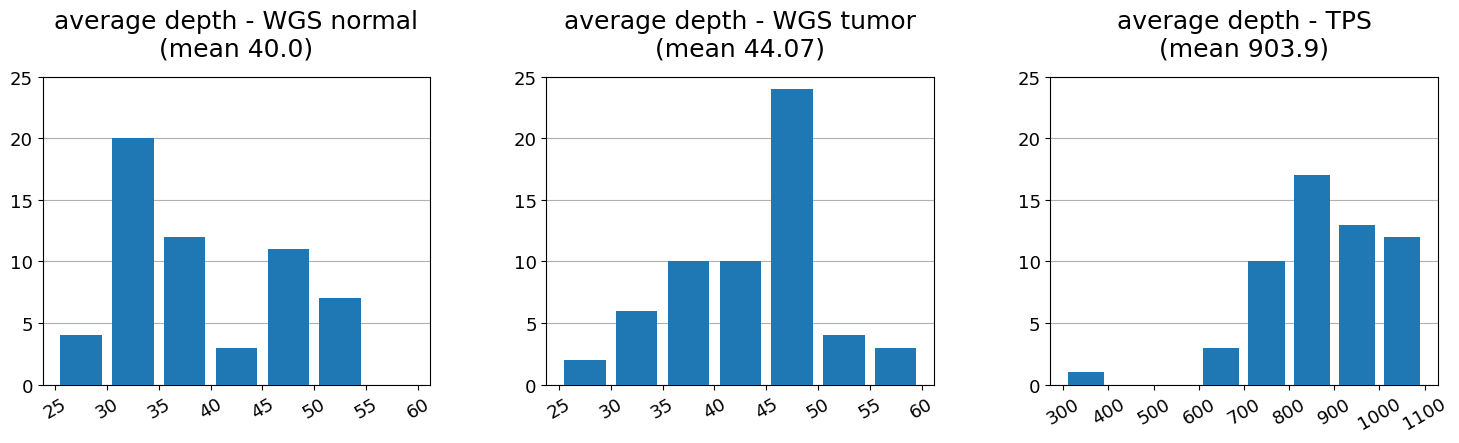

In [367]:
def draw_ax(ax, data, title, bins=None, titlesize=18):
    _ = ax.hist(data, bins=bins, rwidth=0.8, zorder=5)
    ax.set_title(f'{title}\n(mean {np.round(np.mean(data), 2)})', fontsize=titlesize, pad=15)
    
    if bins is not None:
        ax.set_xticks(bins)
    ax.tick_params(axis='x', labelsize=13, labelrotation=30)
    
    ax.tick_params(axis='y', labelsize=13)
    ax.set_ylim(0, 25)
    ax.set_yticks(np.arange(0, 30, 5))
    # ax.set_xlabel(xlabel, fontsize=15)

fig, axs = plt.subplots(1, 3, figsize=(18, 4), gridspec_kw=dict(wspace=0.3))
for ax in axs:
    ax.grid(axis='y')
    # ax.set_ylabel('# of samples', fontsize=15)
    
draw_ax(axs[0], list(MEAN_DEPTH_WGS_NORMAL.values()), 'average depth - WGS normal', bins=np.arange(25, 65, 5))
draw_ax(axs[1], list(MEAN_DEPTH_WGS_TUMOR.values()), 'average depth - WGS tumor', bins=np.arange(25, 65, 5))
draw_ax(axs[2], list(MEAN_DEPTH_PANEL.values()), 'average depth - TPS', bins=np.arange(300, 1200, 100))
# for ax in (axs[0], axs[1]):
#     ax.set_ylim(0, 26)
#     ax.set_yticks(np.arange(0, 30, 5))

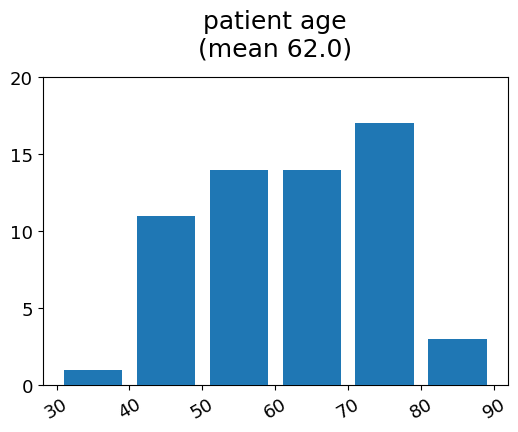

In [372]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
draw_ax(ax, list(AGES.values()), 'patient age', bins=np.arange(30, 100, 10), titlesize=18)
ax.set_ylim(0, 20)
ax.set_yticks(np.arange(0, 25, 5))

Text(0.5, 1.0, 'average depth - TPS unrelated\n(mean 1069.63)')

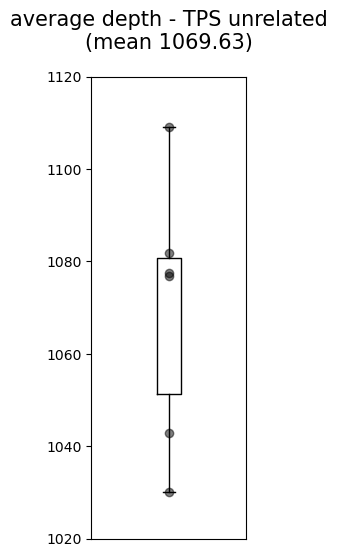

In [411]:
fig, ax = plt.subplots(1, 1, figsize=(2, 6))
# ax.set_ylim(1000, 1100)
# ax.set_xlim(1000, 1100)

for val in MEAN_DEPTH_PANEL_UNMATCHED.values():
    ax.plot(1, val, marker='o', linestyle='', color='black', markersize=6, alpha=0.5)
boxes = ax.boxplot(
    [list(MEAN_DEPTH_PANEL_UNMATCHED.values())]
)
boxes['medians'][0].set_visible(False)

ax.set_xticks([])
ax.set_yticks(np.arange(1020, 1140, 20))
ax.set_title(
    f'average depth - TPS unrelated\n(mean {np.round(np.mean(list(MEAN_DEPTH_PANEL_UNMATCHED.values())), 2)})', 
    fontsize=15, pad=20,
)

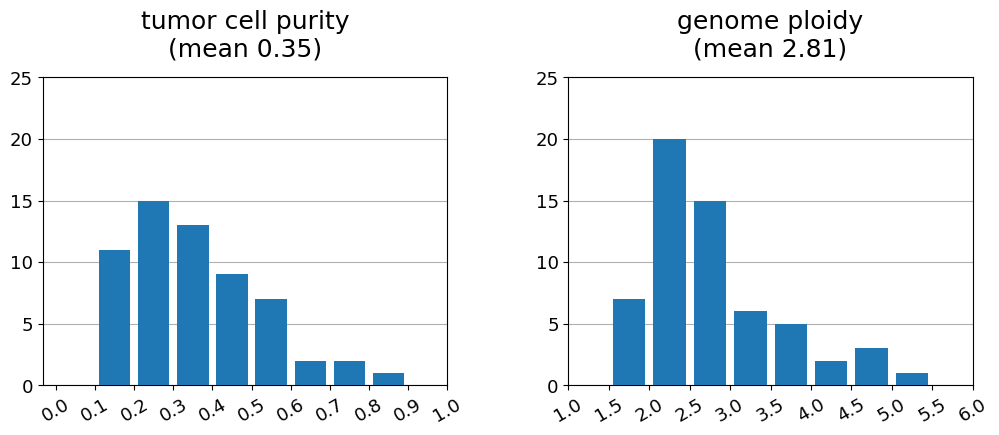

In [344]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(wspace=0.3))
for ax in axs:
    ax.grid(axis='y')
    
draw_ax(axs[0], list(PREVIOUS_PURITY.values()), 'tumor cell purity', bins=np.arange(0, 1, 0.1))
axs[0].set_xticks(np.arange(0, 1.1, 0.1))
draw_ax(axs[1], list(PREVIOUS_PLOIDY.values()), 'genome ploidy', bins=np.arange(1.5, 6, 0.5))
axs[1].set_xticks(np.arange(1, 6.5, 0.5))

In [260]:
print(np.min(list(MEAN_DEPTH_WGS_NORMAL.values())))
print(np.max(list(MEAN_DEPTH_WGS_NORMAL.values())))

print(np.min(list(MEAN_DEPTH_WGS_TUMOR.values())))
print(np.max(list(MEAN_DEPTH_WGS_TUMOR.values())))

print(np.min(list(MEAN_DEPTH_PANEL.values())))
print(np.max(list(MEAN_DEPTH_PANEL.values())))

25.3979
62.2889
28.6972
61.224
362.512
1199.86


### Figure - listing point mutation drivers

In [711]:
figdata = dict()
for sid, vplist in ONCOGENIC_DRIVERS_230412.items():
    for vp in vplist:
        if vp.readstats[sid + '_panel']['rppcounts'][1] >= 5:
            geneclass = get_gene_class(vp)
            figdata.setdefault(geneclass, list())
            figdata[geneclass].append((sid, vp))

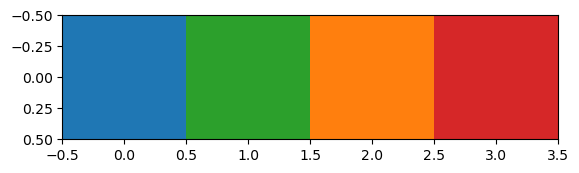

In [712]:
# cmap = plt.cm.hsv.reversed()
# cs = cmap(np.linspace(0.35, 1, 4, endpoint=True))
cmap = mpl.colors.ListedColormap(['tab:blue', 'tab:green', 'tab:orange', 'tab:red'])
vals = cmap([0, 1, 2, 3])
plt.imshow(vals[None, :], cmap=cmap)

Text(0, 0.5, 'tumor cell fraction')

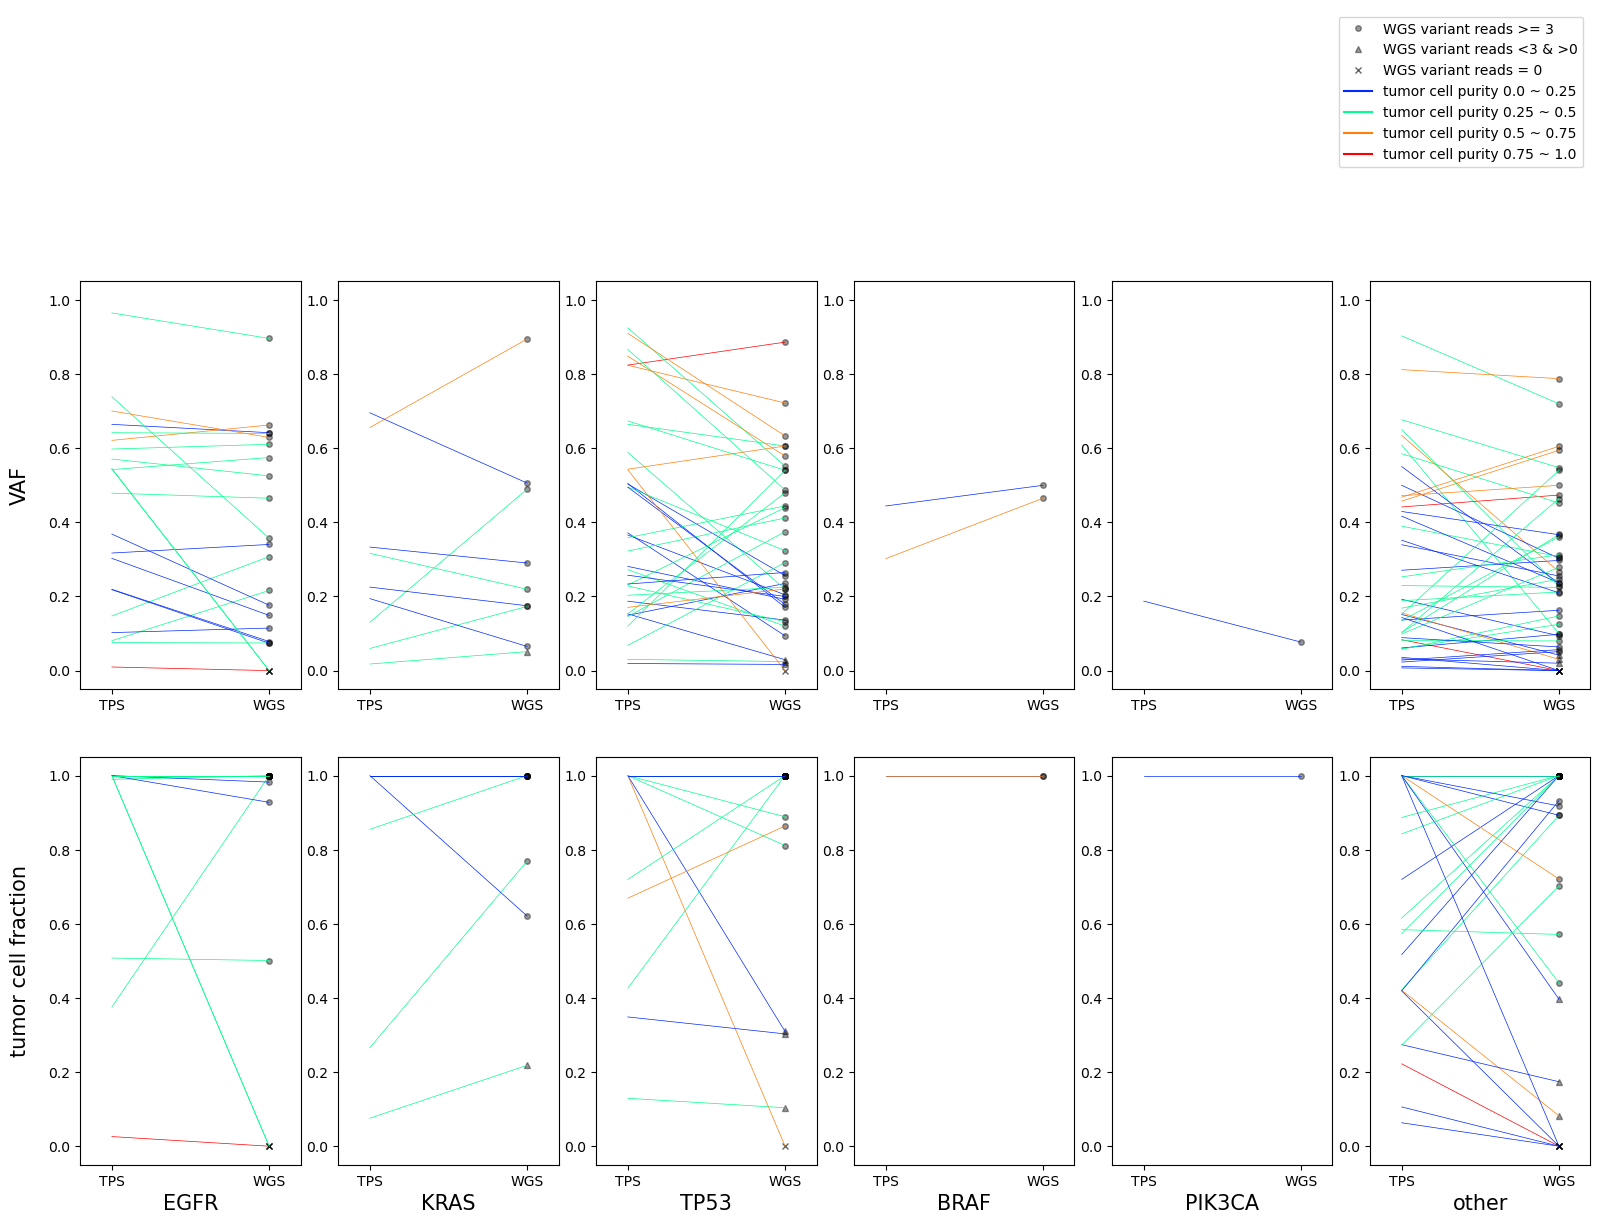

In [759]:
_cols = list(mpl.cm.hsv.reversed()(np.linspace(0.35, 1, 4, endpoint=True)))
# _cols[3] = 'crimson'
_cols[2] = 'tab:orange'
# _cols = ['m', 'b', 'g', 'r']

cmap = mpl.colors.ListedColormap(_cols)
norm = mpl.colors.BoundaryNorm(np.linspace(0, 1, (cmap.N + 1), endpoint=True), cmap.N)
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

geneclasses = ['EGFR', 'KRAS', 'TP53', 'BRAF', 'PIK3CA', 'other']
fig, axd = plt.subplot_mosaic(
    [
        ['legend'] * 7,
        ['ylab_vaf'] + geneclasses, 
        ['ylab_ccf'] + [x + '_ccf' for x in geneclasses],
    ],
    figsize=(20, 15),
    gridspec_kw=dict(width_ratios=[0.01, 1, 1, 1, 1, 1, 1], height_ratios=[0.5, 1, 1]),
    # subplot_kw=dict(facecolor='0.95'),
)
# fig.colorbar(sm, ax=axd['legend'])

markerstyles = {
    'dot': dict(marker='o', linestyle='', color='black', alpha=0.4, markersize=4, label='WGS variant reads >= 3'),
    'tri': dict(marker='^', linestyle='', color='black', alpha=0.4, markersize=4, label='WGS variant reads <3 & >0'),
    'cross': dict(marker='x', linestyle='', color='black', alpha=0.6, markersize=4, label='WGS variant reads = 0'),
}

def draw_ax(ax, geneclass, vp, sid, ylab, ydata, draw_xlabel):
    if draw_xlabel:
        ax.set_xlabel(geneclass, fontsize=15)
    ax.set_xlim(-.2, 1.2)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['TPS', 'WGS'])
    # ax.set_ylabel(ylab)
    ax.set_ylim(-0.05, 1.05)
    ax.set_yticks(np.arange(0, 1.01, 0.2))

    # if vp.oncokb[0]['oncogenic'] == 'Likely Oncogenic':
    #     linestyle = (0, (5, 5))
    # else:
    #     linestyle = '-'
        
    linestyle = '-'

    if get_altcount_wgs(vp, sid) == 0:
        ax.plot([1], ydata[1], **markerstyles['cross'])
    elif get_altcount_wgs(vp, sid) < 3:
        ax.plot([1], ydata[1], **markerstyles['tri'])
    else:
        ax.plot([1], ydata[1], **markerstyles['dot'])

    color = cmap(norm(PREVIOUS_PURITY[sid]))
        
    lines = ax.plot(
        [0, 1], 
        ydata,
        linestyle=linestyle,
        color=color, 
        alpha=1,
        linewidth=0.5,
    )
    

for genecls in geneclasses:
    for sid, vp in figdata[genecls]:
        ydata_vaf = [vp.readstats[sid + '_panel'].get_vaf(), vp.readstats[sid + '_tumor'].get_vaf()]
        ydata_ccf = [vp.ccfinfo_panel.ccf, vp.ccfinfo_wgs.ccf]
        # print(sid, vp)
        # print(ydata_vaf)
        # print(ydata_ccf)
        # print()
        draw_ax(axd[genecls], genecls, vp, sid, 'VAF', ydata_vaf, False)
        draw_ax(axd[genecls + '_ccf'], genecls, vp, sid, 'tumor cell fraction', ydata_ccf, True)

        
# axd['legend'].plot([], color='black', linestyle='-', label='Oncogenic')
# axd['legend'].plot([], color='black', linestyle='--', label='Likely Oncogenic')
axd['legend'].plot([], **markerstyles['dot'])
axd['legend'].plot([], **markerstyles['tri'])
axd['legend'].plot([], **markerstyles['cross'])
for idx in range(cmap.N):
    axd['legend'].plot([], color=cmap.colors[idx], linestyle='-', label=f'tumor cell purity {norm.boundaries[idx]} ~ {norm.boundaries[idx + 1]}')
axd['legend'].legend()


for ax in (axd[key] for key in ['ylab_vaf', 'ylab_ccf', 'legend']):
    for s in ax.spines.values():
        s.set_visible(False)
    ax.set_yticks([])
    ax.set_xticks([])

axd['ylab_vaf'].set_ylabel('VAF', fontsize=15)
axd['ylab_ccf'].set_ylabel('tumor cell fraction', fontsize=15)

### Figure - capture sensitivity of WGS

In [215]:
sum(len(x) > 0 for x in SVdrivers.values())

17

In [629]:
SVdrivers

{'LU-14': [('ALK', 'EML4')],
 'LU-6': [('ALK', 'EML4')],
 'LU-87': [],
 'LU-F13': [('AXL', 'MBIP')],
 'LU-F2': [('ROS1', 'CCDC6')],
 'LU-F33': [],
 'LU-F37': [('KIF5B', 'RET')],
 'LU-FF1': [],
 'LU-FF104': [],
 'LU-FF115': [],
 'LU-FF13': [],
 'LU-FF18': [],
 'LU-FF20': [],
 'LU-FF21': [],
 'LU-FF23': [],
 'LU-FF24': [],
 'LU-FF27': [],
 'LU-FF3': [],
 'LU-FF31': [],
 'LU-FF34': [],
 'LU-FF37': [('ALK', 'EML4')],
 'LU-FF39': [],
 'LU-FF4': [],
 'LU-FF43': [],
 'LU-FF53': [],
 'LU-FF56': [('ZNF33B', 'RET')],
 'LU-FF57': [('KIF5B', 'RET')],
 'LU-FF58': [('CD74', 'ROS1')],
 'LU-FF6': [],
 'LU-FF62': [],
 'LU-FF67': [],
 'LU-FF71': [('CD47', 'MET')],
 'LU-FF76': [('KIF5B', 'RET')],
 'LU-FF77': [('KIF5B', 'RET'), ('FRMD4A', 'RET')],
 'LU-FF78': [],
 'LU-FF79': [],
 'LU-FF80': [],
 'LU-FF85': [],
 'LU-IO05': [],
 'LU-IO06': [],
 'LU-IO07': [],
 'LU-IO08': [('RET', 'CCDC6')],
 'LU-IO09': [],
 'LU-IO12': [],
 'LU-IO13': [],
 'LU-IO15': [],
 'LU-IO16': [],
 'LU-IO17': [],
 'LU-IO18': [],
 'LU-I

In [642]:
def calc_sn_wgscount(c_group_idx, actionable_only=True, wgscount_cutoff=3, wgsvaf_cutoff=None):
    intvidx = pd.IntervalIndex.from_breaks(np.linspace(0, 1, 5, endpoint=True))
    if c_group_idx == 4:
        intv = None
    else:
        intv = intvidx[c_group_idx]
    # print(intv)
    
    n_panel = 0
    n_wgs = 0
    for sid, vplist in ONCOGENIC_DRIVERS_230412.items():
        if c_group_idx != 4:
            if PREVIOUS_PURITY[sid] not in intv:
                continue
        
        # sv
        n_sv = len(SVdrivers[sid])
        n_wgs += n_sv
        n_panel += n_sv
        
        # non-sv
        sid_wgs = sid + '_tumor'
        sid_panel = sid + '_panel'
        for vp in vplist:
            if actionable_only:
                if not check_targetable(vp):
                    continue
            
            wgs_alts = get_altcount_wgs(vp, sid)
            wgs_vaf = vp.get_vaf(sid_wgs)
            panel_alts = get_altcount_panel(vp, sid)
            panel_vaf = vp.get_vaf(sid_panel)
            
            if panel_alts < 5:
                continue
            
            n_panel += 1
            wgs_detected = (
                wgs_alts >= wgscount_cutoff
                if wgscount_cutoff is not None else
                wgs_vaf >= wgsvaf_cutoff
            )
            if wgs_detected:
                n_wgs += 1
        
    if n_panel == 0:
        sn = np.nan
    else:
        sn = n_wgs / n_panel
        
    return sn, n_wgs, n_panel

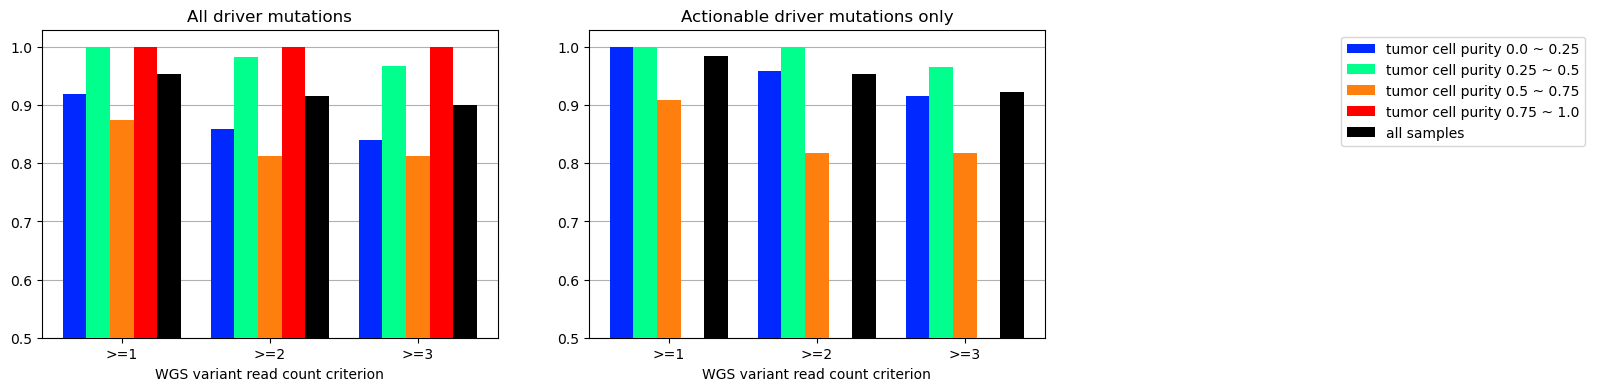

In [760]:
fig, axs = plt.subplots(1, 3, figsize=(20, 4))

n_cellularity_group = 5
width = 0.8 / n_cellularity_group
basexs = np.array([0, 1, 2]) - (0.5 * width * (n_cellularity_group - 1))

def draw_ax(ax, actionable_only):
    lg_handles = list()
    for k in range(n_cellularity_group):
        xs = basexs + (k * width)
        ys = [
            calc_sn_wgscount(c_group_idx=k, actionable_only=actionable_only, wgscount_cutoff=l, wgsvaf_cutoff=None)[0]
            for l in [1, 2, 3]
        ]

        if k == n_cellularity_group - 1:
            color = 'black'
            label = 'all samples'
        else:
            color = cmap(k)
            label = f'tumor cell purity {norm.boundaries[k]} ~ {norm.boundaries[k + 1]}'

        bcont = ax.bar(xs, ys, width=width, align='center', facecolor=color, label=label, zorder=5)
        lg_handles.append(bcont)
        
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(['>=1', '>=2', '>=3'])
    ax.set_xlabel('WGS variant read count criterion')
    
    ax.set_ylim(0.5, 1.03)
    ax.set_yticks(np.arange(0.5, 1.01, 0.1))
    ax.grid(axis='y')
    
    return lg_handles

def rm_artists(ax):
    for s in ax.spines.values():
        s.set_visible(False)
    ax.set_yticks([])
    ax.set_xticks([])


lg_handles = draw_ax(axs[0], False)
axs[0].set_title('All driver mutations')

draw_ax(axs[1], True)
axs[1].set_title('Actionable driver mutations only')

axs[2].legend(handles=lg_handles)
rm_artists(axs[2])
rm_artists(axs[2])


### Table - drivers missed by WGS

In [743]:
vplist_missedby_wgs = list()
for sid, vplist in ONCOGENIC_DRIVERS_230412.items():
    for vp in vplist:
        wgs_alts = get_altcount_wgs(vp, sid)
        panel_alts = get_altcount_panel(vp, sid)

        if panel_alts < 5:
            continue

        if wgs_alts == 0:
            vplist_missedby_wgs.append((sid, vp))

In [744]:
df = make_vp_df(vplist_missedby_wgs)

In [746]:
df.loc[:, ['sample ID', 'gene', 'protein alteration', 'targetable', 'WGS depth', 'WGS vaf', 'TPS depth', 'TPS vaf', 'TPS ccf', 'tumor cell purity', 'WGS tumor average depth', 'WGS normal average depth', 'TPS average depth']]

sample ID    gene protein alteration  targetable  WGS depth  WGS vaf  \
0    LU-F13  CTNNB1               S45P       False         29      0.0   
1    LU-FF1   KEAP1              G379S       False         59      0.0   
2   LU-FF37    EGFR              L861Q        True         23      0.0   
3   LU-IO06   SETD2         E1394Kfs*3       False         44      0.0   
4   LU-IO07   SETD2        N2071Rfs*17       False         42      0.0   
5   LU-SC88   KEAP1              R320L       False         45      0.0   

   TPS depth  TPS vaf  TPS ccf  tumor cell purity  WGS tumor average depth  \
0        576    0.083    0.222               0.75                    31.30   
1        618    0.036    0.419               0.17                    44.55   
2       1131    0.010    0.026               0.75                    32.94   
3        688    0.007    0.063               0.23                    40.27   
4       1057    0.011    0.106               0.24                    48.29   
5       1751    0.143    1.000               0.13                    46.11   

   WGS normal average depth  TPS average depth  
0                     32.79             949.03  
1                     44.49            1005.13  
2                     35.25             763.16  
3                     42.13            1150.48  
4                     50.54             866.11  
5                     48.95             760.34

### Figure - drivers missed by TPS

In [806]:
vplist_missedby_tps = list()
for sid, vplist in ONCOGENIC_DRIVERS_230412.items():
    for vp in vplist:
        wgs_alts = get_altcount_wgs(vp, sid)
        panel_alts = get_altcount_panel(vp, sid)

        if vp.get_gr().intersect(PANEL_REGION_GR).empty:        
            if wgs_alts > 0:
                vplist_missedby_tps.append((sid, vp))

In [807]:
vplist_missedby_tps_targetable = [(sid, vp) for sid, vp in vplist_missedby_tps if check_targetable(vp)]

In [808]:
vplist_missedby_tps_lung = [(sid, vp) for sid, vp in vplist_missedby_tps if check_lung_related(vp)]

In [820]:
vplist_missedby_tps_oncogenic = [(sid, vp) for sid, vp in vplist_missedby_tps if vp.oncokb[0]['oncogenic'] == 'Oncogenic']

In [811]:
vplist_missedby_tps

[('LU-F13',
  <VariantPlus(vcfspec=Vcfspec(chrom='2', pos=48,026,843, ref='C', alts=('G',)), gene=(alt_index 0: MSH6 S574*))>),
 ('LU-F13',
  <VariantPlus(vcfspec=Vcfspec(chrom='1', pos=201,984,352, ref='G', alts=('GGA',)), gene=(alt_index 0: RP11-510N19.5:n.554_555insGA, ELF3 I341Rfs*107))>),
 ('LU-F33',
  <VariantPlus(vcfspec=Vcfspec(chrom='3', pos=52,676,067, ref='A', alts=('T',)), gene=(alt_index 0: PBRM1:c.996-6T>A))>),
 ('LU-FF104',
  <VariantPlus(vcfspec=Vcfspec(chrom='20', pos=57,484,421, ref='G', alts=('A',)), gene=(alt_index 0: GNAS R844H))>),
 ('LU-FF13',
  <VariantPlus(vcfspec=Vcfspec(chrom='2', pos=198,266,834, ref='T', alts=('C',)), gene=(alt_index 0: SF3B1 K700E))>),
 ('LU-FF13',
  <VariantPlus(vcfspec=Vcfspec(chrom='4', pos=187,554,983, ref='T', alts=('A',)), gene=(alt_index 0: FAT1:c.4184-6A>T))>),
 ('LU-FF18',
  <VariantPlus(vcfspec=Vcfspec(chrom='6', pos=161,807,911, ref='T', alts=('G',)), gene=(alt_index 0: PARK2:c.1084-2A>C))>),
 ('LU-FF24',
  <VariantPlus(vcfspec=

In [812]:
vplist_missedby_tps_targetable

[('LU-FF13',
  <VariantPlus(vcfspec=Vcfspec(chrom='2', pos=198,266,834, ref='T', alts=('C',)), gene=(alt_index 0: SF3B1 K700E))>),
 ('LU-FF67',
  <VariantPlus(vcfspec=Vcfspec(chrom='X', pos=44,945,102, ref='C', alts=('G',)), gene=(alt_index 0: KDM6A:c.3434-8C>G))>),
 ('LU-IO16',
  <VariantPlus(vcfspec=Vcfspec(chrom='22', pos=24,176,339, ref='G', alts=('A',)), gene=(alt_index 0: SMARCB1 R377H))>)]

In [822]:
vplist_missedby_tps_oncogenic

[('LU-FF104',
  <VariantPlus(vcfspec=Vcfspec(chrom='20', pos=57,484,421, ref='G', alts=('A',)), gene=(alt_index 0: GNAS R844H))>),
 ('LU-IO17',
  <VariantPlus(vcfspec=Vcfspec(chrom='5', pos=1,295,672, ref='C', alts=('A',)), gene=(alt_index 0: ))>),
 ('LU-IO22',
  <VariantPlus(vcfspec=Vcfspec(chrom='5', pos=1,297,903, ref='G', alts=('T',)), gene=(alt_index 0: ))>)]

In [884]:
for vp in ONCOGENIC_DRIVERS_230412['LU-IO17']:
    print(vp)
    print(vp.oncokb[0]['oncogenic'])

<VariantPlus(vcfspec=Vcfspec(chrom='2', pos=178,098,804, ref='C', alts=('T',)), gene=(alt_index 0: NFE2L2 G81S))>
Likely Oncogenic
<VariantPlus(vcfspec=Vcfspec(chrom='17', pos=7,579,366, ref='G', alts=('T',)), gene=(alt_index 0: TP53 Y107*))>
Likely Oncogenic
<VariantPlus(vcfspec=Vcfspec(chrom='5', pos=1,295,672, ref='C', alts=('A',)), gene=(alt_index 0: ))>
Oncogenic
<VariantPlus(vcfspec=Vcfspec(chrom='7', pos=151,884,563, ref='T', alts=('A',)), gene=(alt_index 0: KMT2C:c.4794-2A>T))>
Likely Oncogenic
<VariantPlus(vcfspec=Vcfspec(chrom='9', pos=8,528,780, ref='C', alts=('T',)), gene=(alt_index 0: PTPRD:c.353-1G>A))>
Likely Oncogenic
<VariantPlus(vcfspec=Vcfspec(chrom='22', pos=21,349,151, ref='T', alts=('G',)), gene=(alt_index 0: LZTR1:c.1786-8T>G))>
Likely Oncogenic


In [881]:
SVdrivers['LU-IO17']

[]

In [909]:
mpl.rc('text', usetex=False)

[]

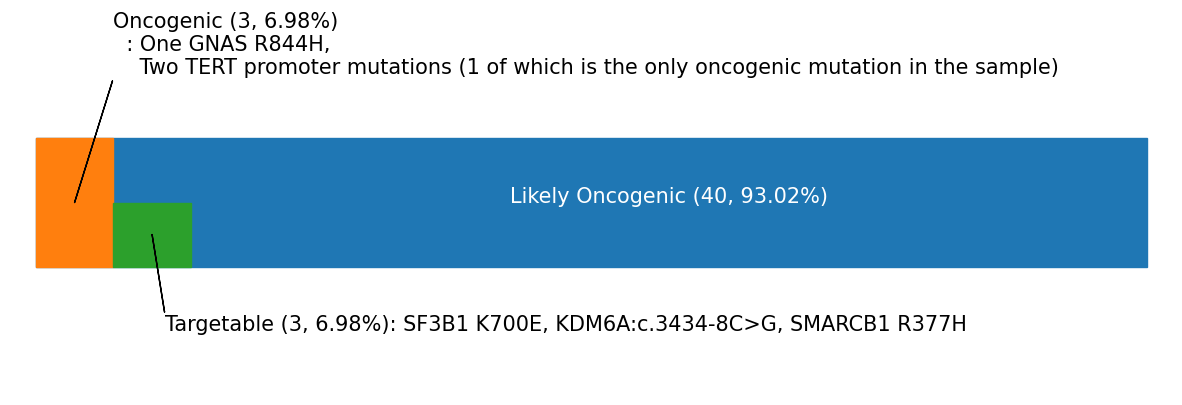

In [911]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.set_xlim(-1, 44)
ax.set_ylim(-1, 5)

totallen = len(vplist_missedby_tps)

# likely oncogenic
num = len(vplist_missedby_tps) - len(vplist_missedby_tps_oncogenic)
pct = round(100 * num / totallen, 2)

rect1 = mpl.patches.Rectangle((0, 1), len(vplist_missedby_tps), 2, color='tab:blue', label='likely oncogenic')
ax.add_patch(rect1)
ax.text(
    (len(vplist_missedby_tps) + len(vplist_missedby_tps_targetable) + len(vplist_missedby_tps_oncogenic)) / 2, 
    2,
    f'Likely Oncogenic ({num}, {pct}%)',
    fontsize=15, color='white', ha='center',
)

# oncogenic
num = len(vplist_missedby_tps_oncogenic)
pct = round(100 * num / totallen, 2)

rect2 = mpl.patches.Rectangle((0, 1), len(vplist_missedby_tps_oncogenic), 2, label='oncogenic', color='tab:orange')
ax.add_patch(rect2)
ax.annotate(
    (
        f'Oncogenic ({num}, {pct}%)\n'
        f'  : One GNAS R844H,\n'
        r'    Two TERT promoter mutations (1 of which is the only oncogenic mutation in the sample)'
    ), 
    (num / 2, 2), (num, 4),
    fontsize=15, color='black', ha='left',
    arrowprops=dict(width=0, headwidth=0),
)

# targetable
num = len(vplist_missedby_tps_targetable)
pct = round(100 * num / totallen, 2)

rect3 = mpl.patches.Rectangle(
    (len(vplist_missedby_tps_oncogenic), 1), 
    len(vplist_missedby_tps_targetable), 
    1, 
    label='targetable', color='tab:green',
)
ax.add_patch(rect3)

annotx = (len(vplist_missedby_tps_oncogenic) * 2 + len(vplist_missedby_tps_targetable)) / 2
annoty = 1.5
textxy = (5, 0)
ax.annotate(
    f'Targetable ({num}, {pct}%): SF3B1 K700E, KDM6A:c.3434-8C>G, SMARCB1 R377H', 
    (annotx, annoty), 
    textxy,
    fontsize=15, color='black', ha='left',
    arrowprops=dict(width=0, headwidth=0),
)


ax.spines[['top', 'bottom', 'left', 'right']].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

In [352]:
for sid, vplist in ONCOGENIC_DRIVERS_230412.items():
    print(sid)
    for vp in vplist:
        # if check_lung_related(vp):
        # if (
        #     (vp.oncokb[0]['highestSensitiveLevel'] is not None)
        #     or (vp.oncokb[0]['highestResistanceLevel'] is not None)
        # ):
        if check_including_word(vp.oncokb[0]['treatments'], 'lung'):
            if (
                (not check_present_wgs(vp, sid, rppcount=3))
                and (check_present_panel(vp, sid, rppcount=5))
            ):
                show_vp_details(vp, sid)
            # print(vp)
            # print(
            #     re.sub('(lung)', common.COLORS['yellow'] + '\\1' + common.COLORS['end'], str(vp.oncokb[0]), flags=re.IGNORECASE)
            # )
    print()
    print()

LU-14


LU-6


LU-87


LU-F13


LU-F2


LU-F33


LU-F37


LU-FF1


LU-FF104


LU-FF115


LU-FF13


LU-FF18


LU-FF20


LU-FF21


LU-FF23


LU-FF24


LU-FF27


LU-FF3


LU-FF31


LU-FF34


LU-FF37
<VariantPlus(vcfspec=Vcfspec(chrom='7', pos=55,259,524, ref='T', alts=('A',)), gene=(alt_index 0: EGFR L861Q))>
Oncogenic
hgvsp oneletter L861Q
CNt A B 2 1 1
WGS altcount=0, vaf=0.0, expected_vaf=0.0, ccfinfo=CCFInfo(CNm=1, ccf=0.0, mutated_allele=None)
PANEL altcount=11, vaf=0.009786476868327402, expected_vaf=0.009786476868327402, ccfinfo=CCFInfo(CNm=1, ccf=0.02609727164887307, mutated_allele=None)



LU-FF39
<VariantPlus(vcfspec=Vcfspec(chrom='19', pos=1,207,135, ref='A', alts=('AG',)), gene=(alt_index 0: STK11 A76Gfs*87))>
Likely Oncogenic
hgvsp oneletter A76Gfs*87
CNt A B 2 1 1
WGS altcount=2, vaf=0.041666666666666664, expected_vaf=0.041666666666666664, ccfinfo=CCFInfo(CNm=1, ccf=0.3968253968253968, mutated_allele=None)
PANEL altcount=92, vaf=0.13918305597579425, expected_vaf=0.105, ccfinf

In [ ]:
sid = 'LU-FF56'
print(sid)
print()
for vp in ONCOGENIC_DRIVERS_230412[sid]:
    if check_lung_related(vp):
        print(vp)
        print(
            re.sub('(lung)', common.COLORS['yellow'] + '\\1' + common.COLORS['end'], str(vp.oncokb[0]), flags=re.IGNORECASE)
        )

LU-FF56

<VariantPlus(vcfspec=Vcfspec(chrom='7', pos=55,242,466, ref='GAATTAAGAGAAGCAACA', alts=('GTTGCT',)), gene=(alt_index 0: EGFR E746_T751delinsVA))>
<OncoKBInfo(
    {'query': {'id': None,
               'referenceGenome': 'GRCh37',
               'hugoSymbol': 'EGFR',
               'entrezGeneId': 1956,
               'alteration': 'E746_T751delinsVA',
               'alterationType': None,
               'svType': None,
               'tumorType': None,
               'consequence': 'inframe_deletion',
               'proteinStart': 746,
               'proteinEnd': 751,
               'hgvs': '7:g.55242466_55242483delinsGTTGCT'},
     'geneExist': True,
     'variantExist': True,
     'alleleExist': False,
     'oncogenic': 'Oncogenic',
     'mutationEffect': {'knownEffect': 'Gain-of-function',
                        'description': '',
                        'citations': {'pmids': ['18508816',
                                                '15329413',
                     

# For Graduate Student Seminar (230426) & Pre-defense (230615)

## Driver

### set functions

In [1194]:
def draw_samples_w_wo(data, title=f'Number of samples', titlesize=25, textsize=15):
    n_with_driver = sum(len(x) > 0 for x in data.values())
    n_wo_driver = 60 - n_with_driver

    fig, ax = plt.subplots(figsize=(6, 1))
    ax.set_title(title, size=titlesize, pad=20)

    p = ax.barh(0, n_wo_driver)
    ax.bar_label(p, labels=[f'Not found\n({n_wo_driver})'], label_type='center', size=textsize, color='black', fontweight='bold')
    p = ax.barh(0, n_with_driver, left=n_wo_driver)
    ax.bar_label(p, labels=[f'Found\n({n_with_driver})'], label_type='center', size=textsize, color='black', fontweight='bold')


    ax.spines[['top', 'bottom', 'left', 'right']].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

In [526]:
from handygenome.cnv import misc as cnvmisc

def show_vp_details(vp, sampleid):
    sampleid_wgs = sampleid + '_tumor'
    sampleid_panel = sampleid + '_panel'
    
    if cnvmisc.check_haploid(IS_FEMALE[sampleid], vp.chrom):
        CNn = 1
    else:
        CNn = 2

    hgvsp_oneletter = vp.oncokb[0]['query']['alteration']
        
    CNt, A, B = vp.fetch_cnvinfo(CNV_SEGMENTS[sampleid])    
    ccfinfo_wgs = vp.ccfinfo_wgs
    ccfinfo_panel = vp.ccfinfo_panel

    wgs_vaf = vp.get_vaf(sampleid_wgs)
    wgs_altcount = get_altcount_wgs(vp, sampleid)
    if ccfinfo_wgs.ccf is None:
        wgs_expected_vaf = None
    else:
        wgs_expected_vaf = cnvmisc.theoretical_somatic_vaf(CNt, ccfinfo_wgs.CNm, PREVIOUS_PURITY[sampleid], ccfinfo_wgs.ccf, CNn=CNn)

    panel_vaf = vp.get_vaf(sampleid_panel)
    panel_altcount = get_altcount_panel(vp, sampleid)
    if ccfinfo_panel.ccf is None:
        panel_expected_vaf = None
    else:
        panel_expected_vaf = cnvmisc.theoretical_somatic_vaf(CNt, ccfinfo_panel.CNm, PREVIOUS_PURITY[sampleid], ccfinfo_panel.ccf, CNn=CNn)
    
    
    print(vp)
    print(vp.oncokb[0]['oncogenic'])
    print('hgvsp oneletter', hgvsp_oneletter)
    print('CNt A B', CNt, A, B)
    print(f'WGS altcount={wgs_altcount}, vaf={wgs_vaf}, expected_vaf={wgs_expected_vaf}, ccfinfo={ccfinfo_wgs}')
    print(f'PANEL altcount={panel_altcount}, vaf={panel_vaf}, expected_vaf={panel_expected_vaf}, ccfinfo={ccfinfo_panel}')
    print()

In [577]:
def make_vp_df(sid_vp_list):
    dfdata = list()
    for sid, vp in sid_vp_list:
        ccfinfo_wgs = vp.ccfinfo_wgs
        ccfinfo_panel = vp.ccfinfo_panel

        wgs_vaf = vp.get_vaf(f'{sid}_tumor')
        wgs_totaldepth = vp.readstats_dict[f'{sid}_tumor'].get_total_rppcount()
        wgs_refreads = vp.readstats_dict[f'{sid}_tumor']['rppcounts'][0]
        wgs_varreads = vp.readstats_dict[f'{sid}_tumor']['rppcounts'][1]

        panel_vaf = vp.get_vaf(f'{sid}_panel')
        panel_totaldepth = vp.readstats_dict[f'{sid}_panel'].get_total_rppcount()
        panel_refreads = vp.readstats_dict[f'{sid}_panel']['rppcounts'][0]
        panel_varreads = vp.readstats_dict[f'{sid}_panel']['rppcounts'][1]

        row = dict()
        row['sample ID'] = sid
        row['CHROM'] = vp.chrom
        row['POS'] = vp.pos
        row['REF'] = vp.ref
        row['ALT'] = vp.alts[0]
        row['gene'] = vp.oncokb[0]['query']['hugoSymbol']

        row['protein alteration'] = vp.oncokb[0]['query']['alteration']    
        row['protein alteration'] = vp.oncokb[0]['query']['alteration']
        if row['protein alteration'] == '':
            row['protein alteration'] = ', '.join(set(tr['hgvsp'].split(':p.')[1] for tr in vp.transcript[0].canon_ovlp.values() if tr['subtype_flags']['coding']))

        row['OncoKB oncogenicity'] = vp.oncokb[0]['oncogenic']
        row['targetable'] = check_targetable(vp)

        row['WGS depth'] = wgs_totaldepth
        row['WGS ref reads'] = wgs_refreads
        row['WGS variant reads'] = wgs_varreads
        row['WGS vaf'] = round(wgs_vaf, 3)
        row['WGS ccf'] = (
            np.nan if ccfinfo_wgs.ccf is None else
            round(ccfinfo_wgs.ccf, 3)
        )

        row['TPS depth'] = panel_totaldepth
        row['TPS ref reads'] = panel_refreads
        row['TPS variant reads'] = panel_varreads
        row['TPS vaf'] = round(panel_vaf, 3)
        row['TPS ccf'] = (
            np.nan if ccfinfo_panel.ccf is None else
            round(ccfinfo_panel.ccf, 3)
        )

        row['tumor cell purity'] = PREVIOUS_PURITY[sid]
        row['genome ploidy'] = PREVIOUS_PLOIDY[sid]

        row['WGS tumor average depth'] = round(MEAN_DEPTH_WGS_TUMOR[sid], 2)
        row['WGS normal average depth'] = round(MEAN_DEPTH_WGS_NORMAL[sid], 2)
        row['TPS average depth'] = round(MEAN_DEPTH_PANEL[sid], 2)
        
        row['TPS average depth'] = round(MEAN_DEPTH_PANEL[sid], 2)
        
        if 'treatments' in vp.oncokb[0]:
            treatinfo = list()
            for x in vp.oncokb[0]['treatments']:
                subdic = dict()
                subdic['drug name'] = x['drugs'][0]['drugName']
                subdic['level'] = x['level']
                subdic['FDA level'] = x['fdaLevel']
                subdic['cancer'] = x['levelAssociatedCancerType']['name']
                subdic['tissue'] = x['levelAssociatedCancerType']['tissue']
                subdic['maintype'] = x['levelAssociatedCancerType']['mainType']['name']
                treatinfo.append(subdic)
        else:
            treatinfo = None
        row['treatments'] = treatinfo
        row['drug name'] = set(x['drug name'] for x in treatinfo)
        row['drug indication'] = set(itertools.chain.from_iterable((x['cancer'], x['tissue'], x['maintype']) for x in treatinfo))
        if '' in row['drug indication']:
            row['drug indication'].remove('')

        dfdata.append(row)

    df = pd.DataFrame.from_records(dfdata)
    
    return df

In [599]:
vp = MAIN_DRIVER_VPLISTS['LU-FF56'][0]

In [600]:
show_vp_igv(vp, 'LU-FF56')

OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK


In [597]:
MAIN_DRIVER_VPLISTS

{'LU-87': <VariantPlusList of length 1 [
 	0	<VariantPlus(vcfspec=Vcfspec(chrom='7', pos=55,259,515, ref='T', alts=('G',)), alteration=(alt_index 0: EGFR L858R))>
 ],
 'LU-F33': <VariantPlusList of length 1 [
 	0	<VariantPlus(vcfspec=Vcfspec(chrom='7', pos=55,249,017, ref='C', alts=('CCCA',)), alteration=(alt_index 0: EGFR-AS1 1229_1231dup, EGFR H773dup))>
 ],
 'LU-FF104': <VariantPlusList of length 1 [
 	0	<VariantPlus(vcfspec=Vcfspec(chrom='12', pos=25,398,284, ref='C', alts=('T',)), alteration=(alt_index 0: KRAS G12D))>
 ],
 'LU-FF115': <VariantPlusList of length 1 [
 	0	<VariantPlus(vcfspec=Vcfspec(chrom='7', pos=55,242,464, ref='AGGAATTAAGAGAAGC', alts=('A',)), alteration=(alt_index 0: EGFR E746_A750del))>
 ],
 'LU-FF13': <VariantPlusList of length 1 [
 	0	<VariantPlus(vcfspec=Vcfspec(chrom='7', pos=55,259,524, ref='T', alts=('A',)), alteration=(alt_index 0: EGFR L861Q))>
 ],
 'LU-FF20': <VariantPlusList of length 1 [
 	0	<VariantPlus(vcfspec=Vcfspec(chrom='7', pos=55,248,998, ref

### Get a list of wgs-only-detected mutations or vice versa

In [584]:
setWGS = list()
setTPS = list()
setBOTH = list()
for sid, vplist in PUTATIVE_DRIVERS.items():
    sid_panel = sid + '_panel'
    sid_wgs = sid + '_tumor'
    for vp in vplist:
        panel_exists = vp.readstats[sid_panel]['rppcounts'][1] > 0
        wgs_exists = vp.readstats[sid_wgs]['rppcounts'][1] > 0
        if panel_exists and wgs_exists:
            setBOTH.append((sid, vp))
        elif panel_exists:
            setTPS.append((sid, vp))
        else:
            setWGS.append((sid, vp))
            
n_wgsonly = len(setWGS)
n_panelonly = len(setTPS)
n_both = len(setBOTH)

print(n_wgsonly, n_panelonly, n_both)

42 5 78


In [592]:
df = make_vp_df(setTPS)

In [593]:
df.columns

Index(['sample ID', 'CHROM', 'POS', 'REF', 'ALT', 'gene', 'protein alteration',
       'OncoKB oncogenicity', 'targetable', 'WGS depth', 'WGS ref reads',
       'WGS variant reads', 'WGS vaf', 'WGS ccf', 'TPS depth', 'TPS ref reads',
       'TPS variant reads', 'TPS vaf', 'TPS ccf', 'tumor cell purity',
       'genome ploidy', 'WGS tumor average depth', 'WGS normal average depth',
       'TPS average depth', 'treatments', 'drug name', 'drug indication'],
      dtype='object')

In [594]:
pd.options.display.max_columns = None

In [595]:
df.loc[
    :, 
    ['sample ID', 'CHROM', 'POS', 'REF', 'ALT', 'gene', 'protein alteration',
     'OncoKB oncogenicity', 
     # 'targetable', 
     'WGS depth', 'WGS vaf', 'WGS ccf', 
     'TPS depth', 'TPS vaf', 'TPS ccf', 
     # 'tumor cell purity', 
     # 'genome ploidy', 
     # 'WGS tumor average depth', 'WGS normal average depth',
       # 'TPS average depth'
     'drug name', 'drug indication',
    ],
]

sample ID CHROM       POS     REF ALT    gene protein alteration  \
0    LU-F13     3  41266136       T   C  CTNNB1               S45P   
1    LU-FF1    19  10602443       C   T   KEAP1              G379S   
2   LU-IO06     3  47161944     TTC   T   SETD2         E1394Kfs*3   
3   LU-IO07     3  47103729  CTTTAT   C   SETD2        N2071Rfs*17   
4   LU-SC88    19  10602619       C   A   KEAP1              R320L   

  OncoKB oncogenicity  WGS depth  WGS vaf  WGS ccf  TPS depth  TPS vaf  \
0    Likely Oncogenic         29      0.0      0.0        575    0.083   
1    Likely Oncogenic         59      0.0      0.0        615    0.036   
2    Likely Oncogenic         44      0.0      0.0        685    0.007   
3    Likely Oncogenic         42      0.0      0.0       1060    0.011   
4    Likely Oncogenic         45      0.0      0.0       1701    0.145   

   TPS ccf drug name drug indication  
0    0.223        {}              {}  
1    0.421        {}              {}  
2    0.063        {}              {}  
3    0.106        {}              {}  
4    1.000        {}              {}

In [582]:
df.iloc[0, -1]

{'Acute Myeloid Leukemia',
 'Chronic Myelomonocytic Leukemia',
 'Leukemia',
 'Myelodysplastic Syndromes',
 'Myelodysplastic/Myeloproliferative Neoplasms',
 'Myeloid'}

### Find lower ends of variant read counts and vafs

In [783]:
panel_counts = list()
panel_vafs = list()
wgs_counts = list()
wgs_vafs = list()
for sid, vplist in TARGETABLE_DRIVERS.items():
    panel_sid = sid + '_panel'
    wgs_sid = sid + '_tumor'
    for vp in vplist:
        panel_counts.append(vp.readstats[panel_sid]['rppcounts'][1])
        panel_vafs.append(vp.readstats[panel_sid].get_vaf())
        wgs_counts.append(vp.readstats[wgs_sid]['rppcounts'][1])
        wgs_vafs.append(vp.readstats[wgs_sid].get_vaf())

In [784]:
print(sorted(set(panel_counts))[:6])
print(sorted(set(wgs_counts))[:6])
print(sorted(set(panel_vafs))[:6])
print(sorted(set(wgs_vafs))[:6])

[0, 2, 7, 11, 14, 22]
[0, 1, 2, 3, 4, 5]
[0.007326007326007326, 0.009786476868327402, 0.017994858611825194, 0.03287671232876712, 0.055776892430278883, 0.06060606060606061]
[0.0, 0.02, 0.030303030303030304, 0.041666666666666664, 0.05128205128205128, 0.06521739130434782]


### Driver pie charts - main driver

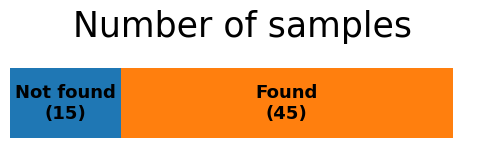

In [1209]:
draw_samples_w_wo(MAIN_DRIVERS, textsize=13)

[None]

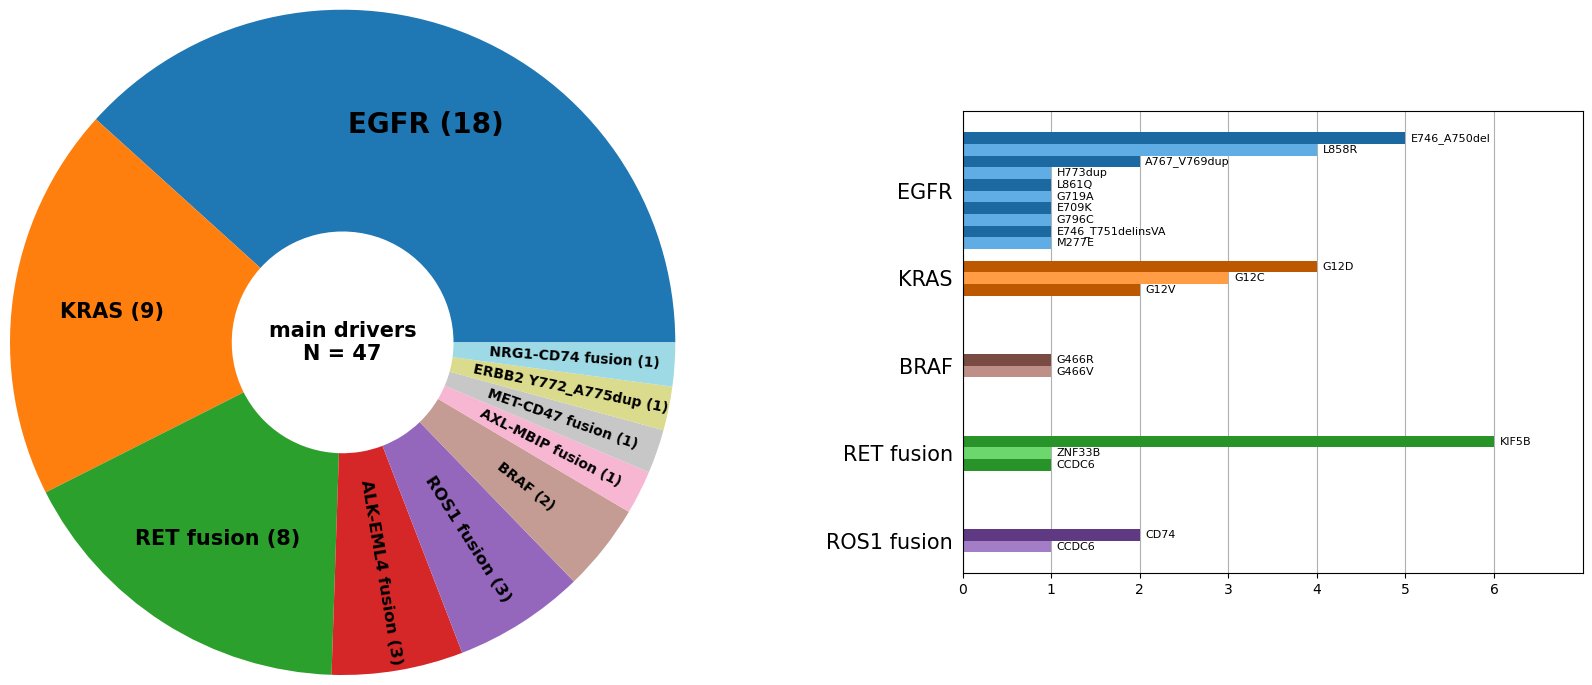

In [1210]:
driver_groups = dict()
for sid, subdata in MAIN_DRIVERS.items():
    for x in subdata:
        if x['type'] == 'fusion':
            key = f"{x['kinase']} fusion"
        else:
            key = x['gene']
    
        driver_groups.setdefault(key, list())
        driver_groups[key].append(x)
            
counts = dict()
for key, val in driver_groups.items():
    if 'fusion' in key:
        if len(set((x['kinase'], x['partner']) for x in val)) == 1:
            newkey = f'{val[0]["kinase"]}-{val[0]["partner"]} fusion'
        else:
            newkey = key
    else:
        if len(set((x['gene'], x['alteration']) for x in val)) == 1:
            newkey = f'{val[0]["gene"]} {val[0]["alteration"]}'
        else:
            newkey = key

    counts[newkey] = len(val)
     

# counts['# of undetected samples'] = 60 - len(MAIN_DRIVERS)


# figure init
fig, axs = plt.subplots(1, 2, figsize=(20, 6), gridspec_kw=dict(wspace=0.5))
N = sum(x for x in counts.values())
# fig.suptitle(f'Main drivers (N={N})', fontsize=25, y=1.2)

#######
# pie #
#######

radius = 1.8
labels, sizes = zip(*sorted(
    counts.items(), 
    key=(lambda x: (-1 if x[0] == '# of undetected samples' else x[1])), 
    reverse=True,
))
pielabels = [f'{x} ({y})' for x, y in zip(labels, sizes)]

cumsizes = np.cumsum(sizes)
thetas = [(2 * np.pi * (cums - 0.5 * s) / N) for (s, cums) in zip(sizes, cumsizes)]
rotations = np.rad2deg([(x + np.pi if (x > 0.5*np.pi and x < 1.5*np.pi) else x) for x in thetas])
textcoords = mpl.projections.polar.PolarTransform().transform([[t, radius * 0.7] for t in thetas])

colors = mpl.colormaps['tab20'](np.linspace(0, 1, len(labels)))

_ = axs[0].pie(
    sizes, 
    # labels=pielabels, 
    radius=radius,
    colors=colors,
    wedgeprops=dict(width=1.2),
)
for lab, (textx, texty), rot in zip(pielabels, textcoords, rotations):
    if any(lab.startswith(x) for x in ('EGFR', 'KRAS', 'RET')):
        fontsize = (20 if lab.startswith('EGFR') else 15)
        rot = 0
    elif lab.startswith('ALK') or lab.startswith('ROS1'):
        fontsize = 12
    else:
        fontsize = None
    axs[0].text(textx, texty, lab, ha='center', va='center', rotation=rot, size=fontsize, fontweight='bold', )
axs[0].text(0, 0, f'main drivers\nN = {N}', ha='center', va='center', size=15, fontweight='bold')
    

#######
# bar #
#######

barplot_genes = ['EGFR', 'KRAS', 'BRAF', 'RET fusion', 'ROS1 fusion']
ycenter_list = [x * 1.5 for x in range(len(barplot_genes))]

width = 0.2
for y_center, key in zip(ycenter_list, barplot_genes):
    if 'fusion' in key:
        subtype_name = 'partner'
    else:
        subtype_name = 'alteration'
        
    subcounts = collections.Counter([x[subtype_name] for x in driver_groups[key]])
    subcolors = itertools.cycle(plotmisc.lightness_spectrum(dict(zip(labels, colors))[key], 2, 0.1, 0.9))
    
    start = y_center - width * (len(subcounts) - 1) * 0.5
    end = start + width * len(subcounts)
    ys = np.arange(start, end, width)
    for idx, ((subtype_name, n), subcol) in enumerate(zip(sorted(subcounts.items(), key=(lambda x: x[1]), reverse=True), subcolors)):
        p = axs[1].barh(ys[idx], n, color=subcol, height=width)
        # axs[1].text(0.1, ys[idx], f'{subtype_name}', ha='left', va='center', fontsize=8, fontweight='bold')
        axs[1].bar_label(p, label_type='edge', labels=[f'{subtype_name}'], rotation=0, padding=4, fontsize=8, )
        
axs[1].set_xlim(0, 7)
axs[1].set_xticks(np.arange(7))

axs[1].invert_yaxis()
axs[1].set_yticks(ycenter_list)
axs[1].set_yticklabels(barplot_genes)
axs[1].tick_params(axis='y', labelsize=15, left=False)

axs[1].grid(axis='x')
axs[1].xaxis.set(zorder=0)

In [1141]:
n_fusions = len([x for x in itertools.chain.from_iterable(MAIN_DRIVERS.values()) if x['type'] == 'fusion'])

setWGS = list()
setTPS = list()
setBOTH = list()
for sid, vplist in MAIN_DRIVER_VPLISTS.items():
    sid_panel = sid + '_panel'
    sid_wgs = sid + '_tumor'
    for vp in vplist:
        panel_exists = vp.readstats[sid_panel]['rppcounts'][1] > 0
        wgs_exists = vp.readstats[sid_wgs]['rppcounts'][1] > 0
        if panel_exists and wgs_exists:
            setBOTH.append((sid, vp))
        elif panel_exists:
            setTPS.append((sid, vp))
        else:
            setWGS.append((sid, vp))
            
n_wgsonly = len(setWGS)
n_panelonly = len(setTPS)
n_both = len(setBOTH) + n_fusions

print(n_wgsonly, n_panelonly, n_both)

0 0 47


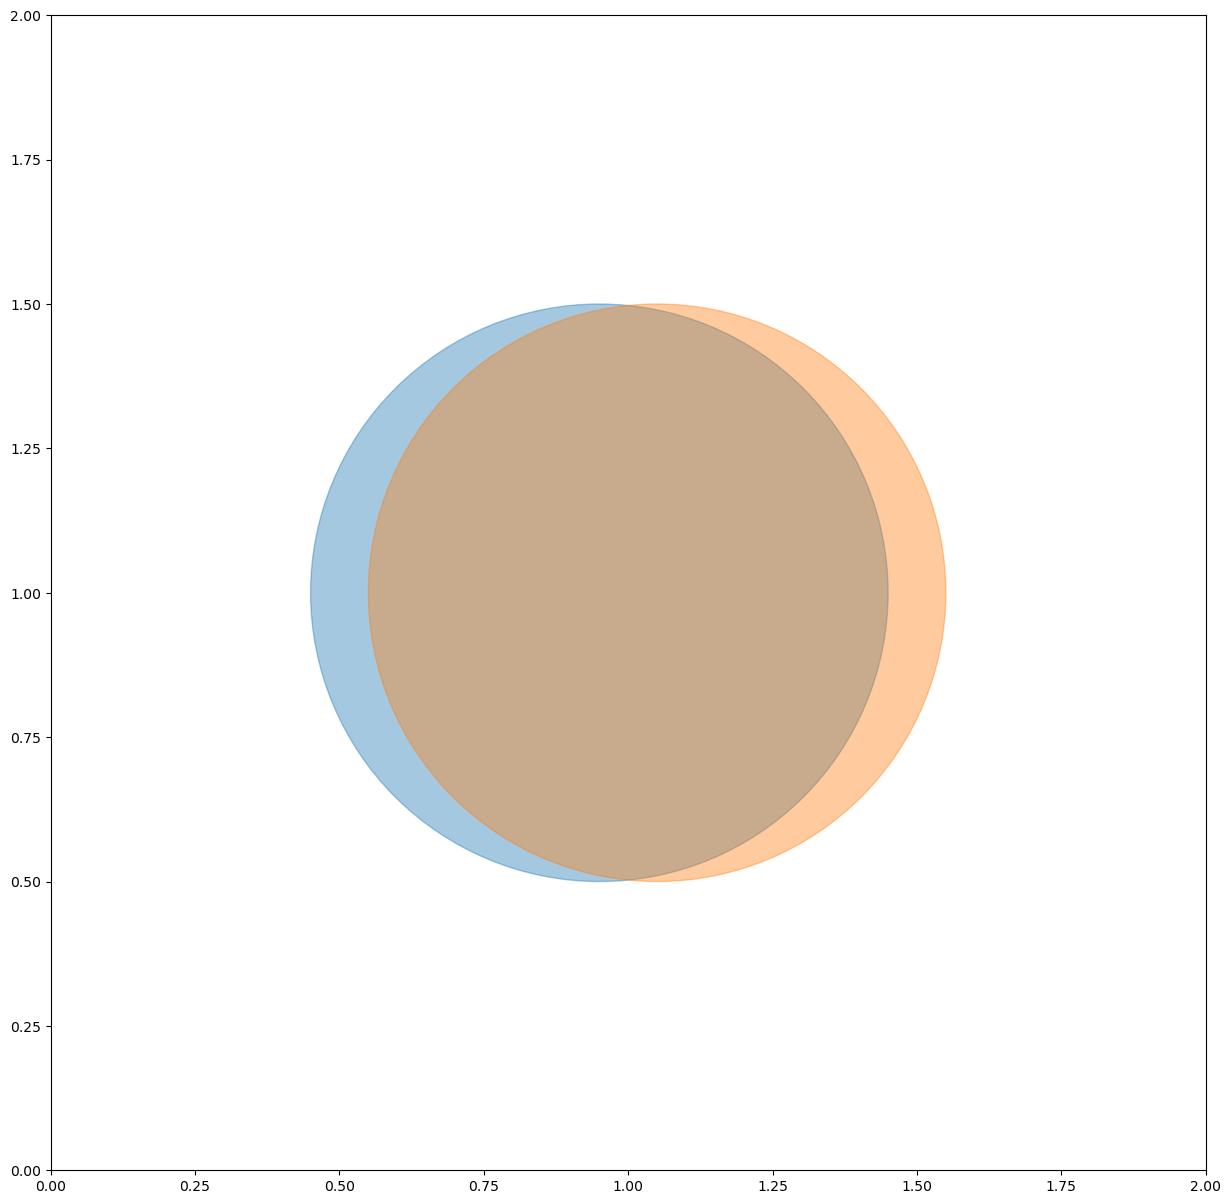

In [1009]:
fig, ax = plt.subplots(figsize=(15, 15))

ax.set_xlim(0, 2)
ax.set_ylim(0, 2)
ax.set_aspect('equal')
ax.add_patch(mpl.patches.Circle((0.95, 1), 0.5, color='tab:blue', alpha=0.4))
ax.add_patch(mpl.patches.Circle((1.05, 1), 0.5, color='tab:orange', alpha=0.4))

### driver pie chart - targetable

In [1191]:
TARGETABLE_DRIVERS_modified = {sid: list() for sid in SAMPLEIDS_LU}

for sid, subdata in MAIN_DRIVERS.items():
    for x in subdata:
        if x['type'] == 'fusion':
            if x['tlevel'] is not None:
                TARGETABLE_DRIVERS_modified[sid].append(x)
            
for sid, vplist in TARGETABLE_DRIVERS.items():
    for vp in vplist:
        altinfo = vp.get_alteration_strings()[0]
        # print(altinfo)
        coding_altinfo = [x for x in altinfo if x[-1] == 'coding']
        noncoding_altinfo = [x for x in altinfo if x[-1] == 'noncoding']
        assert len(coding_altinfo) <= 1
        if len(noncoding_altinfo) > 1:
            print(noncoding_altinfo)
        
        if len(coding_altinfo) > 0:        
            gene, alteration = coding_altinfo[0][:2]
        else:
            noncoding_altinfo = [x for x in noncoding_altinfo if ('.' not in x[0])]
            gene, alteration = noncoding_altinfo[0][:2]

        TARGETABLE_DRIVERS_modified[sid].append({'type': 'mutation', 'gene': gene, 'alteration': alteration, 'tlevel': vp.oncokb[0]['highestSensitiveLevel']})

[('CDKN2A', '457+1G>T', 'noncoding'), ('RP11-145E5.5', '348-58532C>A', 'noncoding')]


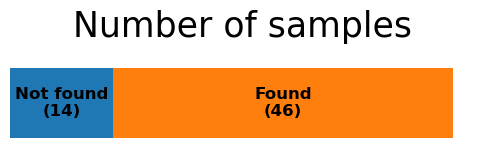

In [1195]:
draw_samples_w_wo(TARGETABLE_DRIVERS_modified, textsize=12)

[None]

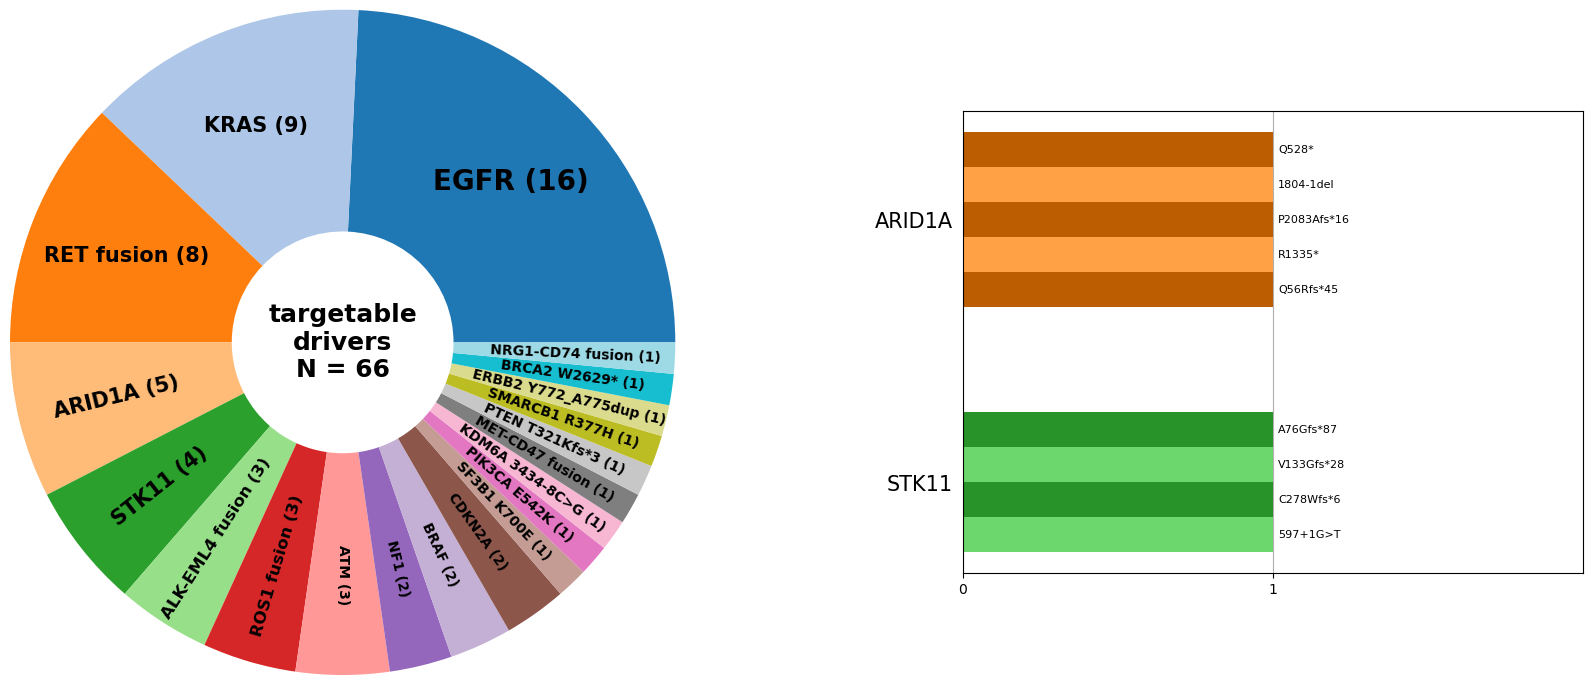

In [1212]:
driver_groups = dict()
for sid, subdata in TARGETABLE_DRIVERS_modified.items():
    for x in subdata:
        if x['type'] == 'fusion':
            key = f"{x['kinase']} fusion"
        else:
            key = x['gene']
    
        driver_groups.setdefault(key, list())
        driver_groups[key].append(x)
            
counts = dict()
for key, val in driver_groups.items():
    if 'fusion' in key:
        if len(set((x['kinase'], x['partner']) for x in val)) == 1:
            newkey = f'{val[0]["kinase"]}-{val[0]["partner"]} fusion'
        else:
            newkey = key
    else:
        if len(set((x['gene'], x['alteration']) for x in val)) == 1:
            newkey = f'{val[0]["gene"]} {val[0]["alteration"]}'
        else:
            newkey = key

    counts[newkey] = len(val)
     

# counts['# of undetected samples'] = 60 - len(MAIN_DRIVERS)


# figure init
fig, axs = plt.subplots(1, 2, figsize=(20, 6), gridspec_kw=dict(wspace=0.5))
N = sum(x for x in counts.values())
# fig.suptitle(f'Main drivers (N={N})', fontsize=25, y=1.2)

#######
# pie #
#######

radius = 1.8
labels, sizes = zip(*sorted(
    counts.items(), 
    key=(lambda x: (-1 if x[0] == '# of undetected samples' else x[1])), 
    reverse=True,
))
pielabels = [f'{x} ({y})' for x, y in zip(labels, sizes)]

cumsizes = np.cumsum(sizes)
thetas = [(2 * np.pi * (cums - 0.5 * s) / N) for (s, cums) in zip(sizes, cumsizes)]
rotations = np.rad2deg([(x + np.pi if (x > 0.5*np.pi and x < 1.5*np.pi) else x) for x in thetas])
textcoords = mpl.projections.polar.PolarTransform().transform([[t, radius * 0.7] for t in thetas])

colorcycle = itertools.cycle(mpl.colormaps['tab20'].colors[:-1] + mpl.colormaps['tab20'].colors[::-1][:-1])
colors = list()
for x in range(len(labels)):
    colors.append(next(colorcycle))
    
_ = axs[0].pie(
    sizes, 
    # labels=pielabels, 
    radius=radius,
    colors=colors,
    wedgeprops=dict(width=1.2),
)
for lab, (textx, texty), rot in zip(pielabels, textcoords, rotations):
    if any(lab.startswith(x) for x in ('EGFR', 'KRAS', 'RET')):
        fontsize = (20 if lab.startswith('EGFR') else 15)
        rot = 0
    elif any(lab.startswith(x) for x in ('ARID1A', 'STK11')):
        fontsize = 15
    elif lab.startswith('ALK') or lab.startswith('ROS1'):
        fontsize = 12
    else:
        fontsize = None
    axs[0].text(textx, texty, lab, ha='center', va='center', rotation=rot, size=fontsize, fontweight='bold', )
axs[0].text(0, 0, f'targetable\ndrivers\nN = {N}', ha='center', va='center', size=18, fontweight='bold')
    

#######
# bar #
#######

barplot_genes = ['ARID1A', 'STK11']
ycenter_list = [x * 1.5 for x in range(len(barplot_genes))]

width = 0.2
for y_center, key in zip(ycenter_list, barplot_genes):
    if 'fusion' in key:
        subtype_name = 'partner'
    else:
        subtype_name = 'alteration'
        
    subcounts = collections.Counter([x[subtype_name] for x in driver_groups[key]])
    subcolors = itertools.cycle(plotmisc.lightness_spectrum(dict(zip(labels, colors))[key], 2, 0.1, 0.9))
    
    start = y_center - width * (len(subcounts) - 1) * 0.5
    end = start + width * len(subcounts)
    ys = np.arange(start, end, width)
    for idx, ((subtype_name, n), subcol) in enumerate(zip(sorted(subcounts.items(), key=(lambda x: x[1]), reverse=True), subcolors)):
        p = axs[1].barh(ys[idx], n, color=subcol, height=width)
        # axs[1].text(0.1, ys[idx], f'{subtype_name}', ha='left', va='center', fontsize=8, fontweight='bold')
        axs[1].bar_label(p, label_type='edge', labels=[f'{subtype_name}'], rotation=0, padding=4, fontsize=8, )
        
axs[1].set_xlim(0, 2)
axs[1].set_xticks(np.arange(2))

axs[1].invert_yaxis()
axs[1].set_yticks(ycenter_list)
axs[1].set_yticklabels(barplot_genes)
axs[1].tick_params(axis='y', labelsize=15, left=False)

axs[1].grid(axis='x')
axs[1].xaxis.set(zorder=0)

In [1198]:
# n_fusions = len([x for x in itertools.chain.from_iterable(MAIN_DRIVERS.values()) if x['type'] == 'fusion'])

all_levels = set(
    x['tlevel']
    for x in (k for k in itertools.chain.from_iterable(TARGETABLE_DRIVERS_modified.values()))
)
targetable_by_level = {level: {'wgs': list(), 'tps': list(), 'both': list()} for level in all_levels}

# fusion
for sid, subdata in TARGETABLE_DRIVERS_modified.items():
    for x in subdata:
        if x['type'] == 'fusion':
            targetable_by_level[x['tlevel']]['both'].append((sid, x))
            
# non-fusion
for sid, vplist in TARGETABLE_DRIVERS.items():
    sid_panel = sid + '_panel'
    sid_wgs = sid + '_tumor'
    for vp in vplist:
        panel_exists = vp.readstats[sid_panel]['rppcounts'][1] > 0
        wgs_exists = vp.readstats[sid_wgs]['rppcounts'][1] > 0
        supdata = targetable_by_level[vp.oncokb[0]['highestSensitiveLevel']]
        if panel_exists and wgs_exists:
            supdata['both'].append((sid, vp))
        elif panel_exists:
            supdata['tps'].append((sid, vp))
        else:
            supdata['wgs'].append((sid, vp))

In [1201]:
targetable_by_level.keys()

dict_keys(['LEVEL_1', 'LEVEL_2', 'LEVEL_4', 'LEVEL_3'])

In [1202]:
n_both = sum(len(x['both']) for x in targetable_by_level.values())
n_wgs = sum(len(x['wgs']) for x in targetable_by_level.values())
n_tps = sum(len(x['tps']) for x in targetable_by_level.values())
print('All', n_both, n_wgs, n_tps)

def print_set_nums(level):
    print(
        level, 
        'both:', len(targetable_by_level[level]['both']),
        'wgs:', len(targetable_by_level[level]['wgs']),
        'tps:', len(targetable_by_level[level]['tps']),
    )

print_set_nums('LEVEL_1')
print_set_nums('LEVEL_2')
print_set_nums('LEVEL_3')
print_set_nums('LEVEL_4')

All 63 3 0
LEVEL_1 both: 41 wgs: 0 tps: 0
LEVEL_2 both: 8 wgs: 0 tps: 0
LEVEL_3 both: 1 wgs: 0 tps: 0
LEVEL_4 both: 13 wgs: 3 tps: 0


In [1248]:
no_driver_samples = set(SAMPLEIDS_LU).difference(set(MAIN_DRIVERS.keys()).union(set(k for k,v in ONCOGENIC_DRIVERS_230412.items() if len(v) > 0)))

In [1249]:
no_driver_samples

{'LU-FF27'}

### driver pie chart - putative

In [1242]:
PUTATIVE_DRIVERS_modified = {sid: list() for sid in SAMPLEIDS_LU}
            
for sid, vplist in PUTATIVE_DRIVERS.items():
    for vp in vplist:
        gene = vp.oncokb[0]['query']['hugoSymbol']
        alteration = vp.oncokb[0]['query']['alteration']
        oncogenic = vp.oncokb[0]['oncogenic']

        PUTATIVE_DRIVERS_modified[sid].append({'type': 'mutation', 'gene': gene, 'alteration': alteration, 'oncogenic': oncogenic})

In [1257]:
PUTATIVE_DRIVERS_modified_oncogenic = {key: [x for x in val if x['oncogenic'] == 'Oncogenic'] for key, val in PUTATIVE_DRIVERS_modified.items()}
PUTATIVE_DRIVERS_modified_likely = {key: [x for x in val if x['oncogenic'] == 'Likely Oncogenic'] for key, val in PUTATIVE_DRIVERS_modified.items()}

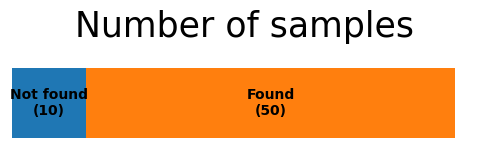

In [1246]:
draw_samples_w_wo(PUTATIVE_DRIVERS_modified, textsize=10)

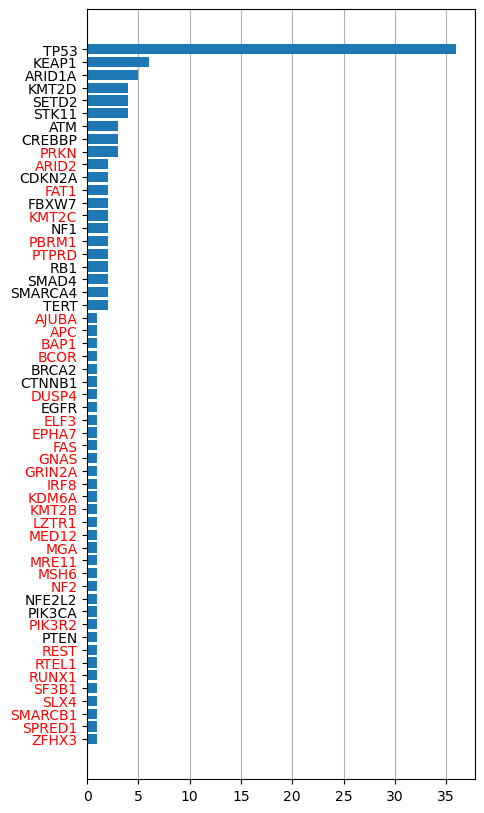

In [1580]:
def make_gene_coutns(data):
    gene_counts = collections.Counter([
        vp.oncokb[0]['query']['hugoSymbol'] 
        for vp in itertools.chain.from_iterable(data.values())
    ])
    gene_counts = sorted(gene_counts.items(), key=(lambda x: (-x[1], x[0])))
    return gene_counts

gene_counts = make_gene_coutns(PUTATIVE_DRIVERS)
gene_counts_likely = make_gene_coutns(PUTATIVE_DRIVERS_LIKELY)
gene_counts_oncogenic = make_gene_coutns(PUTATIVE_DRIVERS_ONCOGENIC)


fig, ax = plt.subplots(figsize=(5, 10))

for gene, n in gene_counts:
    ax.barh(gene, n, color='tab:blue')

# ax.set_title('All putative drivers', size=20)
ax.grid(axis='x')
ax.xaxis.set(zorder=0)
for lab in ax.get_yticklabels():
    if lab.get_text() not in panel_genes_all:
        lab.set(color='red')
# n_genes = len(gene_counts)
# ax.set_ylim(n_genes - 1, n_genes + 1)
ax.invert_yaxis()


In [1577]:
ax.get_yticklabels()[0].get_text()

'TP53'

### Inspecting wgs-only Oncogenic mutations

In [1618]:
for sid, vplist in ONCOGENIC_DRIVERS_230412.items():
    for vp in vplist:
        if vp.oncokb[0]['oncogenic'] != 'Oncogenic':
            continue
        
        in_wgs = vp.readstats[sid + '_tumor']['rppcounts'][1] > 0
        in_tps = vp.readstats[sid + '_panel']['rppcounts'][1] > 0
        if in_wgs and in_tps:
            pass
        elif in_wgs:
            print(sid, vp, vp.oncokb[0]['query']['hugoSymbol'] + ' ' + vp.oncokb[0]['query']['alteration'])
            # pprint.pprint(vp.oncokb[0]['treatments'][0])
            # pprint.pprint(vp.oncokb[0]['treatments'])
        elif in_tps:
            pass

LU-FF104 <VariantPlus(vcfspec=Vcfspec(chrom='20', pos=57,484,421, ref='G', alts=('A',)), alteration=(alt_index 0: GNAS R844H))> GNAS R201H
LU-IO17 <VariantPlus(vcfspec=Vcfspec(chrom='5', pos=1,295,672, ref='C', alts=('A',)), alteration=(alt_index 0: ))> TERT Promoter
LU-IO22 <VariantPlus(vcfspec=Vcfspec(chrom='5', pos=1,297,903, ref='G', alts=('T',)), alteration=(alt_index 0: ))> TERT Promoter


In [1631]:
for key, val in ONCOGENIC_DRIVERS_230412['LU-FF104'][1].transcript[0].items():
    if val['gene_name'] == 'GNAS':
        if val['hgvsp'] is not None:
            print(val['hgvsp'], val['transcript_name'], 'mane:', val['mane_select'], 'canonical:', val['is_canonical'], sep='\t')

ENSP00000265620.7:p.Arg186His	GNAS-035	mane:	None	canonical:	False
ENSP00000304472.10:p.Arg187His	GNAS-201	mane:	None	canonical:	False
ENSP00000346328.7:p.Arg202His	GNAS-018	mane:	None	canonical:	False
ENSP00000360126.3:p.Arg201His	GNAS-015	mane:	None	canonical:	False
ENSP00000360136.3:p.Arg187His	GNAS-017	mane:	None	canonical:	False
ENSP00000360141.3:p.Arg844His	GNAS-001	mane:	None	canonical:	True
ENSP00000360143.4:p.Arg830His	GNAS-009	mane:	None	canonical:	False
ENSP00000474219.1:p.Arg142His	GNAS-071	mane:	None	canonical:	False


In [33]:
for sid in ('LU-FF104', 'LU-IO17', 'LU-IO22'):
    print(sid)
    try:
        print('main:', MAIN_DRIVERS[sid])
    except:
        print('main:',None)
    
    try:
        print('targetable:', TARGETABLE_DRIVERS[sid])
    except:
        print('targetable:',None)
        
    print()

LU-FF104
main: [{'type': 'mutation', 'gene': 'KRAS', 'alteration': 'G12D'}]
targetable: <VariantPlusList of length 1 [
	0	<VariantPlus(vcfspec=Vcfspec(chrom='12', pos=25,398,284, ref='C', alts=('T',)), alteration=(alt_index 0: KRAS G12D))>
]

LU-IO17
main: None
targetable: <VariantPlusList of length 0 [
]

LU-IO22
main: [{'type': 'mutation', 'gene': 'BRAF', 'alteration': 'G466V'}]
targetable: <VariantPlusList of length 2 [
	0	<VariantPlus(vcfspec=Vcfspec(chrom='7', pos=140,481,411, ref='C', alts=('A',)), alteration=(alt_index 0: BRAF G466V))>
	1	<VariantPlus(vcfspec=Vcfspec(chrom='19', pos=1,220,505, ref='G', alts=('T',)), alteration=(alt_index 0: STK11 597+1G>T))>
]



### Inspecting wgs-only targetable mutations

In [1610]:
for sid in ('LU-FF13', 'LU-FF67', 'LU-IO16'):
    print(sid)
    try:
        print('main:', MAIN_DRIVERS[sid])
    except:
        print('main:',None)
    
    try:
        print('targetable:', TARGETABLE_DRIVERS[sid])
    except:
        print('targetable:',None)
        
    print()

LU-FF13
main: [{'type': 'mutation', 'gene': 'EGFR', 'alteration': 'L861Q'}]
targetable: <VariantPlusList of length 2 [
	0	<VariantPlus(vcfspec=Vcfspec(chrom='7', pos=55,259,524, ref='T', alts=('A',)), alteration=(alt_index 0: EGFR L861Q))>
	1	<VariantPlus(vcfspec=Vcfspec(chrom='2', pos=198,266,834, ref='T', alts=('C',)), alteration=(alt_index 0: SF3B1 K700E))>
]

LU-FF67
main: [{'type': 'mutation', 'gene': 'KRAS', 'alteration': 'G12D'}]
targetable: <VariantPlusList of length 2 [
	0	<VariantPlus(vcfspec=Vcfspec(chrom='12', pos=25,398,284, ref='C', alts=('T',)), alteration=(alt_index 0: KRAS G12D))>
	1	<VariantPlus(vcfspec=Vcfspec(chrom='X', pos=44,945,102, ref='C', alts=('G',)), alteration=(alt_index 0: KDM6A 3434-8C>G))>
]

LU-IO16
main: None
targetable: <VariantPlusList of length 2 [
	0	<VariantPlus(vcfspec=Vcfspec(chrom='9', pos=21,971,120, ref='G', alts=('A',)), alteration=(alt_index 0: CDKN2A R80*, RP11-145E5.5 348-58312G>A))>
	1	<VariantPlus(vcfspec=Vcfspec(chrom='22', pos=24,176,

In [1374]:
n_wgs = 0
n_tps = 0
n_both = 0

for sid, vplist in PUTATIVE_DRIVERS_LIKELY.items():
    for vp in vplist:
        in_wgs = vp.readstats[sid + '_tumor']['rppcounts'][1] > 0
        in_tps = vp.readstats[sid + '_panel']['rppcounts'][1] > 0
        if in_wgs and in_tps:
            n_both += 1
        elif in_wgs:
            n_wgs += 1
        elif in_tps:
            n_tps += 1
            
print('wgs:', n_wgs, 'tps:', n_tps, 'both:', n_both)
            

wgs: 39 tps: 5 both: 72


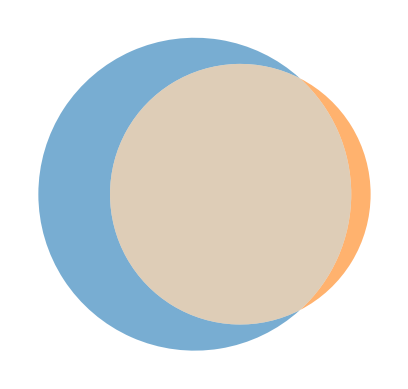

In [1375]:
v = matplotlib_venn.venn2([n_wgs, n_tps, n_both], set_colors=('tab:blue', 'tab:orange'), alpha=0.6, subset_label_formatter=(lambda x: ''))
v.get_label_by_id('A').set_text('')
v.get_label_by_id('B').set_text('')
# v.get_patch_by_id('10').set_color('tab:blue')

In [494]:
def qcut(metadata):
    cutresult, bins = pd.qcut(pd.Series(metadata), 4, retbins=True)
    groups = {
        idx: list(cutresult[cutresult == cat].index)
        for idx, cat in enumerate(cutresult.dtype.categories) 
    }
    rev_groups = dict()
    for key, val in groups.items():
        for subval in val:
            rev_groups[subval] = key
            
    return {
        'bins': bins, 'groups': rev_groups
    }

In [505]:
PURITY_QCUT = qcut(PREVIOUS_PURITY)
WGSDEPTH_QCUT = qcut(MEAN_DEPTH_WGS_TUMOR)
TPSDEPTH_QCUT = qcut(MEAN_DEPTH_PANEL)

In [498]:
def calc_sensitivity(data, metadata_groups, wgsdepth_cutoff=1, tpsdepth_cutoff=5):
    result = {idx: {'wgs_numer': 0, 'wgs_denom': 0, 'tps_numer': 0, 'tps_denom': 0} for idx in [0, 1, 2, 3, 'all']}
    
    for sid, vplist in data.items():
        for vp in vplist:
            if vp.get_gr().intersect(PANEL_REGION_GR).empty:
                continue
            
            in_wgs = vp.readstats[sid + '_tumor']['rppcounts'][1] >= wgsdepth_cutoff
            in_tps = vp.readstats[sid + '_panel']['rppcounts'][1] >= tpsdepth_cutoff
            
            if in_wgs:
                result['all']['tps_denom'] += 1
                result[metadata_groups['groups'][sid]]['tps_denom'] += 1
            if in_wgs and in_tps:
                result['all']['tps_numer'] += 1
                result[metadata_groups['groups'][sid]]['tps_numer'] += 1
                
            if in_tps:
                result['all']['wgs_denom'] += 1
                result[metadata_groups['groups'][sid]]['wgs_denom'] += 1
            if in_tps and in_wgs:
                result['all']['wgs_numer'] += 1
                result[metadata_groups['groups'][sid]]['wgs_numer'] += 1
                
    trueresult = dict()
    for key, val in result.items():
        trueresult[key] = dict()
        trueresult[key]['wgs_sn'] = val['wgs_numer'] / val['wgs_denom']
        trueresult[key]['tps_sn'] = val['tps_numer'] / val['tps_denom']
    
    return trueresult

In [504]:
def make_sndata_group_wgs(data, depth_cutoffs=range(1, 6, 1), tps_cutoff=2):
    sndata_purity = {
        cutoff: calc_sensitivity(data, PURITY_QCUT, wgsdepth_cutoff=cutoff, tpsdepth_cutoff=tps_cutoff)
        for cutoff in depth_cutoffs
    }
    sndata_wgsdepth = {
        cutoff: calc_sensitivity(data, WGSDEPTH_QCUT, wgsdepth_cutoff=cutoff, tpsdepth_cutoff=tps_cutoff)
        for cutoff in depth_cutoffs
    }
    sndata_tpsdepth = {
        cutoff: calc_sensitivity(data, TPSDEPTH_QCUT, wgsdepth_cutoff=cutoff, tpsdepth_cutoff=tps_cutoff)
        for cutoff in depth_cutoffs
    }
    
    sndata = {'purity': sndata_purity, 'wgsdepth': sndata_wgsdepth, 'tpsdepth': sndata_tpsdepth}
    return sndata


def make_sndata_group_tps(data, depth_cutoffs=range(2, 12, 2), wgs_cutoff=1):
    sndata_purity = {
        cutoff: calc_sensitivity(data, PURITY_QCUT, wgsdepth_cutoff=wgs_cutoff, tpsdepth_cutoff=cutoff)
        for cutoff in depth_cutoffs
    }
    sndata_wgsdepth = {
        cutoff: calc_sensitivity(data, WGSDEPTH_QCUT, wgsdepth_cutoff=wgs_cutoff, tpsdepth_cutoff=cutoff)
        for cutoff in depth_cutoffs
    }
    sndata_tpsdepth = {
        cutoff: calc_sensitivity(data, TPSDEPTH_QCUT, wgsdepth_cutoff=wgs_cutoff, tpsdepth_cutoff=cutoff)
        for cutoff in depth_cutoffs
    }
    
    sndata = {'purity': sndata_purity, 'wgsdepth': sndata_wgsdepth, 'tpsdepth': sndata_tpsdepth}
    return sndata

In [501]:
wgs_sndata = {
    'putative': make_sndata_group_wgs(PUTATIVE_DRIVERS),
    'main': make_sndata_group_wgs(MAIN_DRIVER_VPLISTS),
    'targetable': make_sndata_group_wgs(TARGETABLE_DRIVERS),
}
tps_sndata = {
    'putative': make_sndata_group_tps(PUTATIVE_DRIVERS),
    'main': make_sndata_group_tps(MAIN_DRIVER_VPLISTS),
    'targetable': make_sndata_group_tps(TARGETABLE_DRIVERS),
}

In [522]:
def draw_sensitivity_plot(sndata, depth_cutoffs=[1, 2, 3, 4, 5], wgs_sn=True):
    fig, axd = plt.subplot_mosaic(
        [
            ['purity_label', 'purity_q1', 'purity_q2', 'purity_q3', 'purity_q4', 'legend'],
            ['wgsdepth_label', 'wgsdepth_q1', 'wgsdepth_q2', 'wgsdepth_q3', 'wgsdepth_q4', 'legend'],
            ['tpsdepth_label', 'tpsdepth_q1', 'tpsdepth_q2', 'tpsdepth_q3', 'tpsdepth_q4', 'legend'],
        ],
        figsize=(20, 10),
        gridspec_kw=dict(wspace=0.4, hspace=0.8, width_ratios=[0.7, 1, 1, 1, 1, 0.7]),
    )
    for key, ax in axd.items():
        if key.endswith('label') or key == 'legend':
            ax.set_xlim(-1, 1)
            ax.set_ylim(-1, 1)
            ax.spines[['top', 'bottom', 'left', 'right']].set_visible(False)
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            ax.set_xlabel(f'{"WGS" if wgs_sn else "TPS"} ALT read cutoff')
            ax.set_ylabel('sensitivity')
            xticks = list(range(len(depth_cutoffs)))
            ax.set_xticks(xticks)
            ax.set_xticklabels(depth_cutoffs)
            ax.set_xlim(xticks[0] - 1, xticks[-1] + 1)
            ax.set_ylim(0, 1.1)
            ax.yaxis.set(zorder=0)
            ax.grid(axis='y')
            
    axd['purity_label'].text(0, 0, 'Tumor cell purity\nquartiles', ha='center', fontweight='bold', size=13)
    axd['wgsdepth_label'].text(0, 0, 'Tumor WGS depth\nquartiles', ha='center', fontweight='bold', size=13)
    axd['tpsdepth_label'].text(0, 0, 'TPS depth\nquartiles', ha='center', fontweight='bold', size=13)
    
    for x in range(4):
        axd[f'purity_q{x + 1}'].set_title(f'Q{x + 1}\n({PURITY_QCUT["bins"][x]} ~ {PURITY_QCUT["bins"][x + 1]})', pad=20, fontweight='bold')
        axd[f'wgsdepth_q{x + 1}'].set_title(f'Q{x + 1}\n({round(WGSDEPTH_QCUT["bins"][x], 1)} ~ {round(WGSDEPTH_QCUT["bins"][x + 1], 1)})', pad=20, fontweight='bold')
        axd[f'tpsdepth_q{x + 1}'].set_title(f'Q{x + 1}\n({round(TPSDEPTH_QCUT["bins"][x], 1)} ~ {round(TPSDEPTH_QCUT["bins"][x + 1], 1)})', pad=20, fontweight='bold')

    color_map = {'main': 'tab:blue', 'targetable': 'tab:green', 'putative': 'tab:red'}
    width = 0.8
    offsets_map = {'main': -1/3*width, 'targetable': 0, 'putative': 1/3*width}
    
    
    for dataclass, subdata in sndata.items():
        for qtype, val in subdata.items():
            for cutoff, subval in val.items():
                for q, snvalues in subval.items():
                    if q == 'all':
                        continue
                    ax = axd[f'{qtype}_q{q + 1}']
                    ax.bar(
                        depth_cutoffs.index(cutoff) + offsets_map[dataclass], 
                        (snvalues['wgs_sn'] if wgs_sn else snvalues['tps_sn']), 
                        width=1/3*width,
                        color=color_map[dataclass],
                    )
    
    axd['legend'].legend(
        handles=[
            mpl.patches.Patch(color=color_map['main'], label='main drivers'),
            mpl.patches.Patch(color=color_map['targetable'], label='targetable drivers'),
            mpl.patches.Patch(color=color_map['putative'], label='putative drivers'),
        ],
        loc='center',
    )
    
    titlesize = 25
    if wgs_sn:
        fig.suptitle('WGS sensitivity for TPS-detected mutations', size=titlesize, fontweight='bold')
    else:
        fig.suptitle('TPS sensitivity for WGS-detected mutations (within TPS target)', size=titlesize, fontweight='bold')

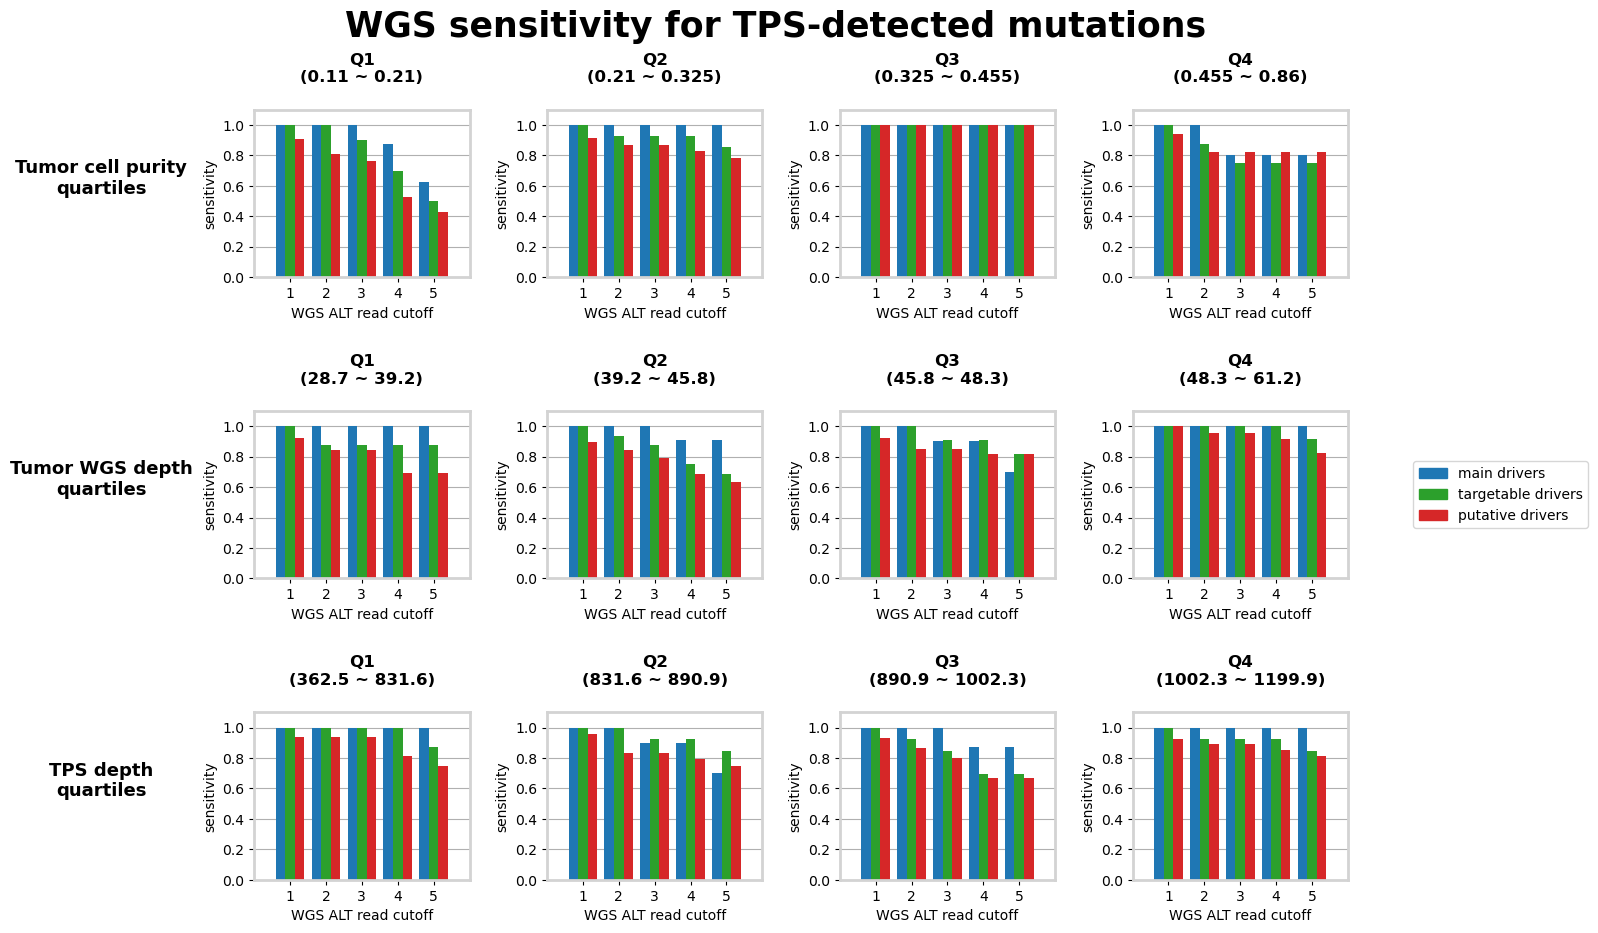

In [523]:
draw_sensitivity_plot(wgs_sndata, depth_cutoffs=[1, 2, 3, 4, 5], wgs_sn=True)

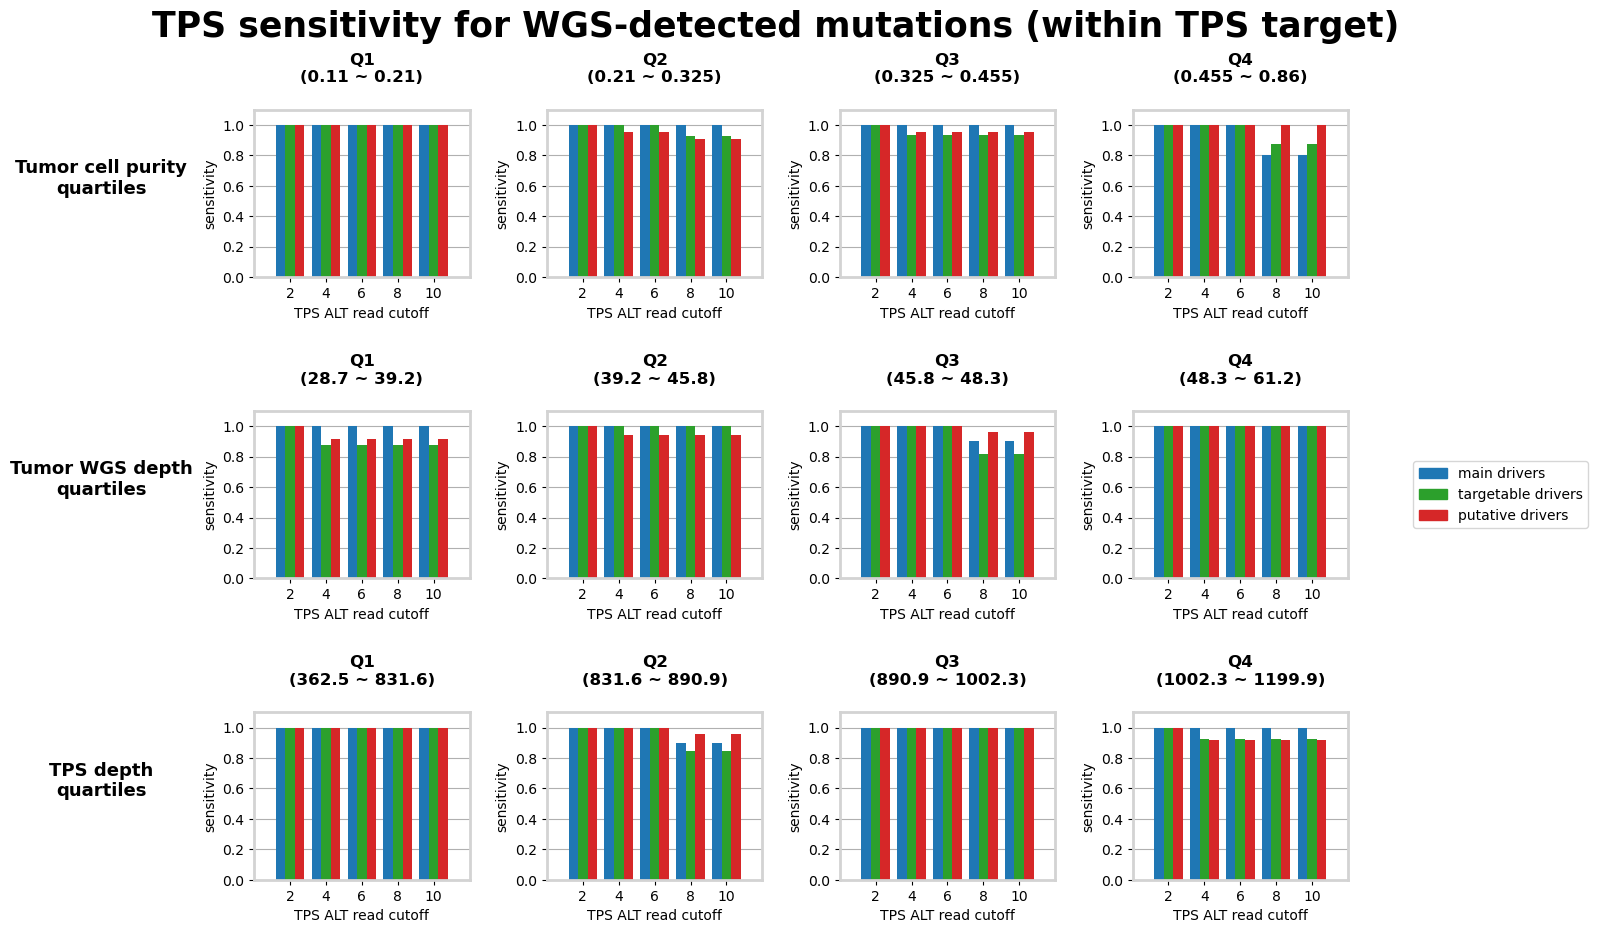

In [524]:
draw_sensitivity_plot(tps_sndata, depth_cutoffs=list(range(2, 12, 2)), wgs_sn=False)

In [2024]:
MAIN_DRIVERS

{'LU-14': [{'type': 'fusion',
   'kinase': 'ALK',
   'partner': 'EML4',
   'tlevel': 'LEVEL_1'}],
 'LU-6': [{'type': 'fusion',
   'kinase': 'ALK',
   'partner': 'EML4',
   'tlevel': 'LEVEL_1'}],
 'LU-87': [{'type': 'mutation', 'gene': 'EGFR', 'alteration': 'L858R'}],
 'LU-F13': [{'type': 'fusion',
   'kinase': 'AXL',
   'partner': 'MBIP',
   'tlevel': None}],
 'LU-F2': [{'type': 'fusion',
   'kinase': 'ROS1',
   'partner': 'CCDC6',
   'tlevel': 'LEVEL_1'}],
 'LU-F33': [{'type': 'mutation', 'gene': 'EGFR', 'alteration': 'H773dup'}],
 'LU-F37': [{'type': 'fusion',
   'kinase': 'RET',
   'partner': 'KIF5B',
   'tlevel': 'LEVEL_1'}],
 'LU-FF104': [{'type': 'mutation', 'gene': 'KRAS', 'alteration': 'G12D'}],
 'LU-FF115': [{'type': 'mutation',
   'gene': 'EGFR',
   'alteration': 'E746_A750del'}],
 'LU-FF13': [{'type': 'mutation', 'gene': 'EGFR', 'alteration': 'L861Q'}],
 'LU-FF20': [{'type': 'mutation',
   'gene': 'EGFR',
   'alteration': 'A767_V769dup'}],
 'LU-FF21': [{'type': 'mutation', '

## TMB

In [23]:
slope = WHOLE_GENOME_LENGTH / PANEL_REGION_LENGTH

In [24]:
WGS_PANELREGION_COUNTS_SNV = {sid: len(PREVIOUS_WGS_REANNOT_VCF_SNV[sid].isec(PANEL_REGION_GR)) for sid in SAMPLEIDS_LU}
WGS_PANELREGION_COUNTS_INDEL = {sid: len(PREVIOUS_WGS_REANNOT_VCF_INDEL[sid].isec(PANEL_REGION_GR)) for sid in SAMPLEIDS_LU}

In [27]:
WGS_PANELREGION_COUNTS_SNV['LU-FF62']

110

In [ ]:
vp.transcript[0]['ENST00000317501']['hgvsc']

'ENST00000317501.3:c.1397-31265T>C'

In [ ]:
vp.transcript[0]['ENST00000317501']['consequence_flags']['splice_region_involved']

False

##### Setup filtering functions

In [2005]:
from handygenome.variant.filter import get_preset_filter_somatic
somatic_filter = get_preset_filter_somatic()

In [31]:
PON_SAMPLES = [sid + '_panel' for sid in SAMPLEIDS_LU]


def get_bait_margin_distance(vp, panel_region_gr):
    nearest_gr = vp.get_gr().nearest(panel_region_gr)
    return min(abs(nearest_gr.Start_b[0] - vp.start0), abs(nearest_gr.End_b[0] - vp.start0))


def get_vpfilter(sid, margin_distance=None, **kwargs):
    sid_panel = sid + '_panel'    
    tpsfilter = libfilter.get_preset_filter_panelseq(pon_samples=PON_SAMPLES, refver='hg19', **kwargs)

    if margin_distance is None:
        def vpfilter(vp):
            return tpsfilter.check(vp, sid_panel)
    else:
        def vpfilter(vp):
            return (
                tpsfilter.check(vp, sid_panel)
                and (get_bait_margin_distance(vp, PANEL_REGION_GR) > margin_distance)
            )
        
    return vpfilter

In [32]:
def get_filtered_panel_vplist(total_vplist, sid, margin_distance=None, **kwargs):
    sid_panel = sid + '_panel'
    vpfilter = get_vpfilter(sid, margin_distance=margin_distance, **kwargs)
    result = VariantPlusList(refver='hg19')
    for vp in total_vplist:
        if vpfilter(vp):
            result.append(vp)
            
    return result

In [33]:
filtered_tps_vplists_snv = dict()
filtered_tps_vplists_indel = dict()
for sid in SAMPLEIDS_LU:
    print(sid)
    filtered_tps_vplists_snv[sid] = get_filtered_panel_vplist(PANEL_SNV_VPLIST, sid, margin_distance=50, cutoff_totalcount=30, cutoff_unifpval=None, ponfilter_kwargs=dict(lower_ratio=50))
    filtered_tps_vplists_indel[sid] = get_filtered_panel_vplist(PANEL_INDEL_VPLIST, sid, margin_distance=50, cutoff_totalcount=30, cutoff_unifpval=None, ponfilter_kwargs=dict(lower_ratio=50))

LU-14
LU-6
LU-87
LU-F13
LU-F2
LU-F33
LU-F37
LU-FF1
LU-FF104
LU-FF115
LU-FF13
LU-FF18
LU-FF20
LU-FF21
LU-FF23
LU-FF24
LU-FF27
LU-FF3
LU-FF31
LU-FF34
LU-FF37
LU-FF39
LU-FF4
LU-FF43
LU-FF53
LU-FF56
LU-FF57
LU-FF58
LU-FF6
LU-FF62
LU-FF67
LU-FF71
LU-FF76
LU-FF77
LU-FF78
LU-FF79
LU-FF80
LU-FF85
LU-IO05
LU-IO06
LU-IO07
LU-IO08
LU-IO09
LU-IO12
LU-IO13
LU-IO15
LU-IO16
LU-IO17
LU-IO18
LU-IO22
LU-IO23
LU-IO24
LU-IO25
LU-SC126
LU-SC134
LU-SC31
LU-SC81
LU-SC88
LU-SC97
LU-SC98


<VariantPlusList of length 1 [
	0	<VariantPlus(vcfspec=Vcfspec(chrom='8', pos=32,571,129, ref='T', alts=('TA',)), alteration=(alt_index 0: NRG1 503-14338_503-14337insA))>
]

##### Find representative false positive calls

In [199]:
# sid = 'LU-IO15'
sid = np.random.choice(SAMPLEIDS_LU, 1)[0]
print(sid)

LU-IO22


In [200]:
filtered_vplist = get_filtered_panel_vplist(PANEL_SNV_VPLIST, sid=sid, ponfilter_kwargs=dict(lower_ratio=0))

In [201]:
filtered_vplist

<VariantPlusList of length 74 [
	0	<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=156,849,591, ref='T', alts=('C',)), alteration=(alt_index 0: NTRK1 2047-200T>C))>
	1	<VariantPlus(vcfspec=Vcfspec(chrom='1', pos=243,664,389, ref='C', alts=('T',)), alteration=(alt_index 0: ))>
	2	<VariantPlus(vcfspec=Vcfspec(chrom='2', pos=178,110,548, ref='A', alts=('G',)), alteration=(alt_index 0: NFE2L2 46-11549T>C))>
	3	<VariantPlus(vcfspec=Vcfspec(chrom='2', pos=212,494,752, ref='C', alts=('A',)), alteration=(alt_index 0: ERBB4 2079+435G>T))>
	4	<VariantPlus(vcfspec=Vcfspec(chrom='2', pos=213,024,556, ref='C', alts=('A',)), alteration=(alt_index 0: ERBB4 83-34928G>T))>
	5	<VariantPlus(vcfspec=Vcfspec(chrom='2', pos=213,067,421, ref='C', alts=('T',)), alteration=(alt_index 0: ERBB4 83-77793G>A))>
	6	<VariantPlus(vcfspec=Vcfspec(chrom='2', pos=213,079,953, ref='G', alts=('A',)), alteration=(alt_index 0: ERBB4 83-90325C>T))>
	7	<VariantPlus(vcfspec=Vcfspec(chrom='2', pos=213,080,546, ref='C', alts=('T',))

In [202]:
ponfilter = libfilter.get_ponfilter(pon_samples=PON_SAMPLES, refver='hg19', mode='panel_somatic', lower_ratio=10)

In [203]:
def vpfilter(vp):
    # cond = vp.readstats[f'{sid}_panel']['mean_cliplens'][1] > 20
    # cond = vp.readstats[f'{sid}_panel']['mean_BQs'][1] < 20
    cond = (
        (not ponfilter.check(vp, sid + '_panel'))
        and (vp.readstats[f'{sid}_panel']['rppcounts'][1] > 5)
    )
    return cond

In [204]:
vp = filtered_vplist.filter(vpfilter).sample()

In [205]:
show_vp_igv(vp, sid)

OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK


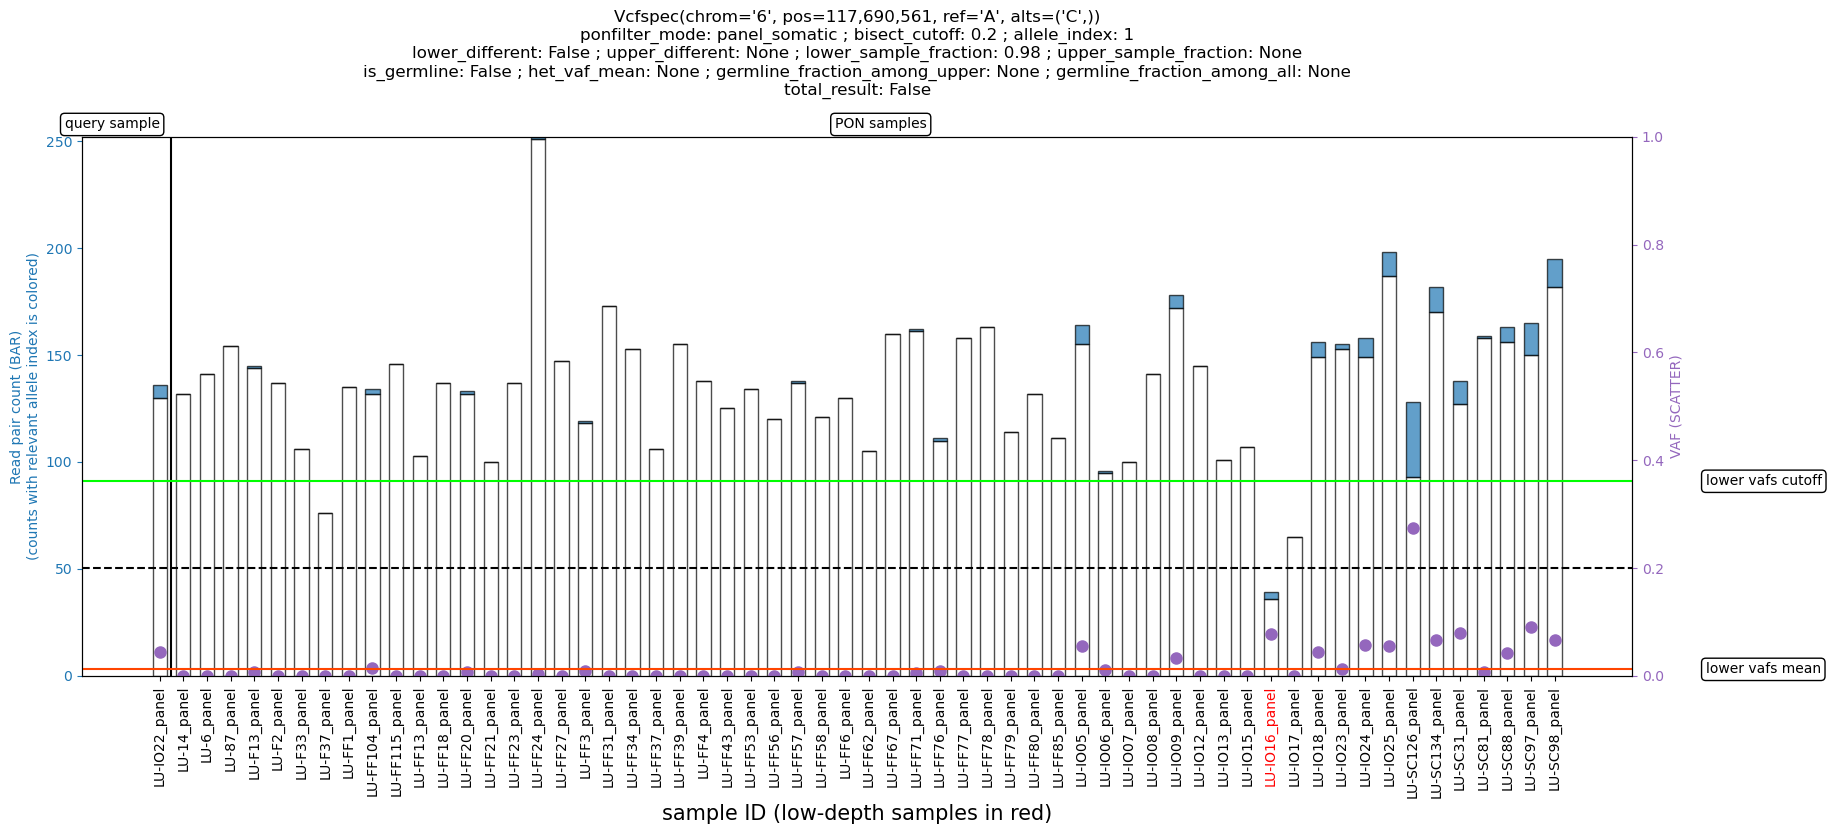

In [206]:
vp.show_pon(query_sample=(sid + '_panel'), pon_samples=PON_SAMPLES, ponfilter_mode='panel_somatic', zoom_lower=False, lower_ratio=30)

In [209]:
igv.load([BAM_PATHS['panel']['LU-IO18'], BAM_PATHS['panel']['LU-IO24']])

OK
OK


##### Make count plot restricted to TPS region

In [65]:
def draw_tmb_comparison(filtered_tps_vplists_snv=None, annotate=False, **kwargs):
    input_is_null = (filtered_tps_vplists_snv is None)
    
    if filtered_tps_vplists_snv is None:
        filtered_tps_vplists_snv = dict()
        for sid in SAMPLEIDS_LU:
            print(sid)
            filtered_tps_vplists_snv[sid] = get_filtered_panel_vplist(PANEL_SNV_VPLIST, sid, **kwargs)

        
    fig, ax = plt.subplots(figsize=(10, 10))

    xs = [len(filtered_tps_vplists_snv[sid]) for sid in SAMPLEIDS_LU]
    ys = [WGS_PANELREGION_COUNTS_SNV[sid] for sid in SAMPLEIDS_LU]
    ax.plot(xs, ys, linestyle='', marker='o', markersize=3, alpha=0.5)
    
    if annotate:
        x_width = ax.get_xlim()[1] - ax.get_xlim()[0]
        y_width = ax.get_ylim()[1] - ax.get_ylim()[0]
        x_jitters = np.random.normal(0, x_width * 0.1, len(SAMPLEIDS_LU))
        y_jitters = np.random.normal(0, y_width * 0.1, len(SAMPLEIDS_LU))
        for x_dot, y_dot, x_jit, y_jit, sid in zip(xs, ys, x_jitters, y_jitters, SAMPLEIDS_LU):
            ax.annotate(sid, xy=(x_dot, y_dot), xytext=(x_jit, y_jit), textcoords='offset points', arrowprops=dict(arrowstyle='-'))

    # xwidth = ax.get_xlim()[1] - ax.get_xlim()[0]
    # ywidth = ax.get_ylim()[1] - ax.get_ylim()[0]
    # for sid, x, y in zip(SAMPLEIDS_LU, xs, ys):
    #     jitterx = xwidth * 0.05 * np.random.normal(0, 1, 1)[0]
    #     jittery = ywidth * 0.05 * np.random.normal(0, 1, 1)[0]
    #     ax.annotate(sid, (x, y), xytext=(x + jitterx, y + jittery), size=7, arrowprops=dict(width=0.2, headwidth=0, alpha=0.2), ha='center', va='center')

    ax.axline((0, 0), slope=1, color='k', alpha=0.5, linewidth=1)
    
    ax.set_xlabel('TPS snv count', size=15)
    ax.set_ylabel('WGS snv count\n(those within TPS region)', size=15)
    ax.tick_params(axis='both', labelsize=15)
    
    titledict = dict(kwargs)
    paramstring = '\n'.join(f'{k}={v}' for k, v in titledict.items())
    ax.set_title(f'Filtering params:\n{paramstring}', size=15)
    # fig.suptitle(f'SNV counts only within TPS target region', size=20, y=1.04)
    
    if input_is_null:
        return filtered_tps_vplists_snv

LU-14
LU-6
LU-87
LU-F13
LU-F2
LU-F33
LU-F37
LU-FF1
LU-FF104
LU-FF115
LU-FF13
LU-FF18
LU-FF20
LU-FF21
LU-FF23
LU-FF24
LU-FF27
LU-FF3
LU-FF31
LU-FF34
LU-FF37
LU-FF39
LU-FF4
LU-FF43
LU-FF53
LU-FF56
LU-FF57
LU-FF58
LU-FF6
LU-FF62
LU-FF67
LU-FF71
LU-FF76
LU-FF77
LU-FF78
LU-FF79
LU-FF80
LU-FF85
LU-IO05
LU-IO06
LU-IO07
LU-IO08
LU-IO09
LU-IO12
LU-IO13
LU-IO15
LU-IO16
LU-IO17
LU-IO18
LU-IO22
LU-IO23
LU-IO24
LU-IO25
LU-SC126
LU-SC134
LU-SC31
LU-SC81
LU-SC88
LU-SC97
LU-SC98


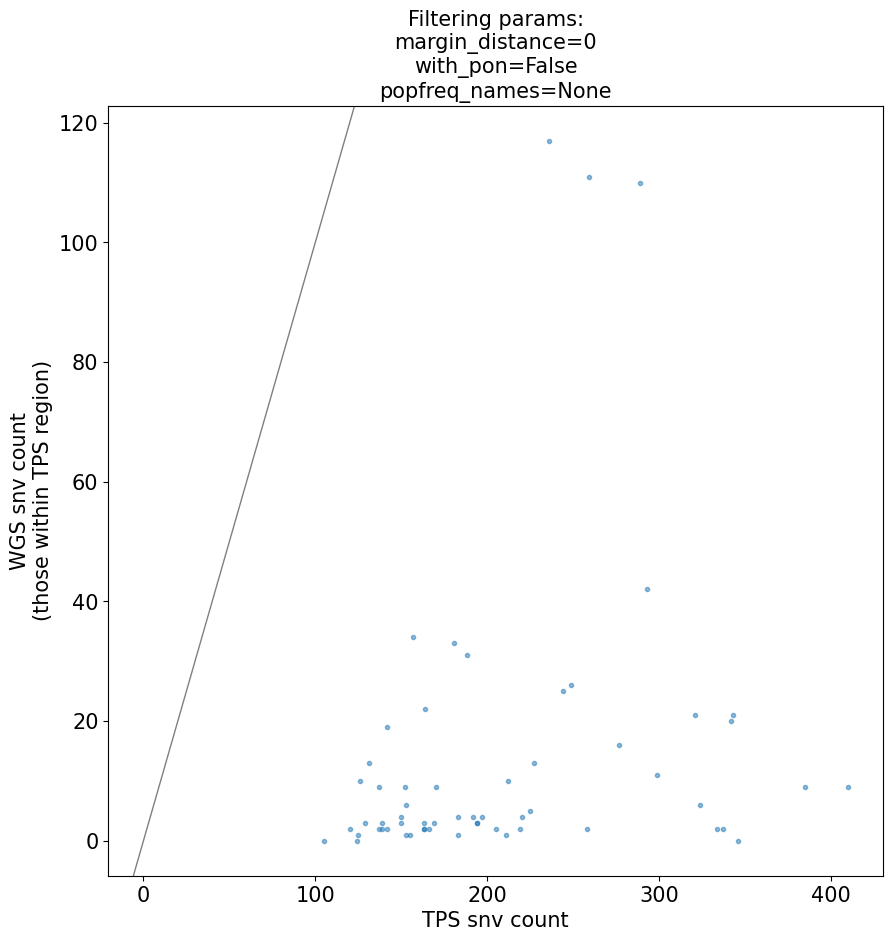

In [57]:
filtered_tps_vplists_snv_readstatsonly_nomargindist = draw_tmb_comparison(filtered_tps_vplists_snv=None, margin_distance=0, with_pon=False, popfreq_names=None)

LU-14
LU-6
LU-87
LU-F13
LU-F2
LU-F33
LU-F37
LU-FF1
LU-FF104
LU-FF115
LU-FF13
LU-FF18
LU-FF20
LU-FF21
LU-FF23
LU-FF24
LU-FF27
LU-FF3
LU-FF31
LU-FF34
LU-FF37
LU-FF39
LU-FF4
LU-FF43
LU-FF53
LU-FF56
LU-FF57
LU-FF58
LU-FF6
LU-FF62
LU-FF67
LU-FF71
LU-FF76
LU-FF77
LU-FF78
LU-FF79
LU-FF80
LU-FF85
LU-IO05
LU-IO06
LU-IO07
LU-IO08
LU-IO09
LU-IO12
LU-IO13
LU-IO15
LU-IO16
LU-IO17
LU-IO18
LU-IO22
LU-IO23
LU-IO24
LU-IO25
LU-SC126
LU-SC134
LU-SC31
LU-SC81
LU-SC88
LU-SC97
LU-SC98


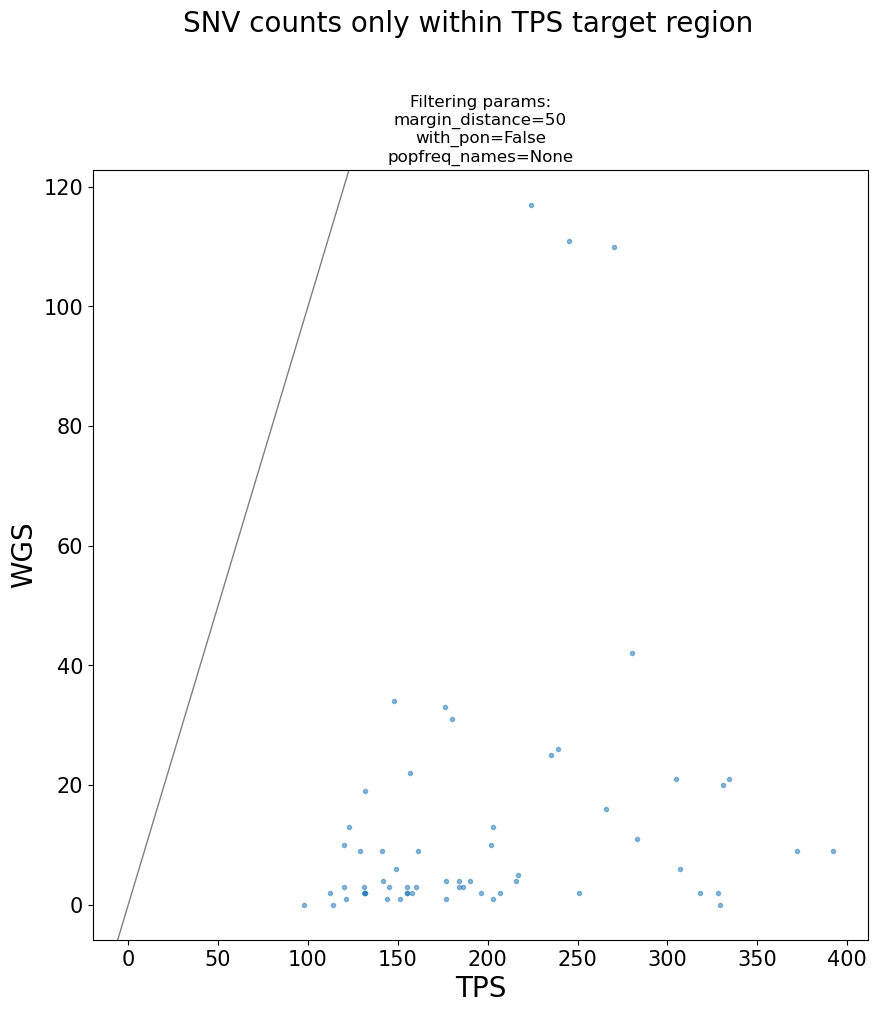

In [49]:
filtered_tps_vplists_snv_readstatsonly = draw_tmb_comparison(filtered_tps_vplists_snv=None, margin_distance=50, with_pon=False, popfreq_names=None)

LU-14
LU-6
LU-87
LU-F13
LU-F2
LU-F33
LU-F37
LU-FF1
LU-FF104
LU-FF115
LU-FF13
LU-FF18
LU-FF20
LU-FF21
LU-FF23
LU-FF24
LU-FF27
LU-FF3
LU-FF31
LU-FF34
LU-FF37
LU-FF39
LU-FF4
LU-FF43
LU-FF53
LU-FF56
LU-FF57
LU-FF58
LU-FF6
LU-FF62
LU-FF67
LU-FF71
LU-FF76
LU-FF77
LU-FF78
LU-FF79
LU-FF80
LU-FF85
LU-IO05
LU-IO06
LU-IO07
LU-IO08
LU-IO09
LU-IO12
LU-IO13
LU-IO15
LU-IO16
LU-IO17
LU-IO18
LU-IO22
LU-IO23
LU-IO24
LU-IO25
LU-SC126
LU-SC134
LU-SC31
LU-SC81
LU-SC88
LU-SC97
LU-SC98


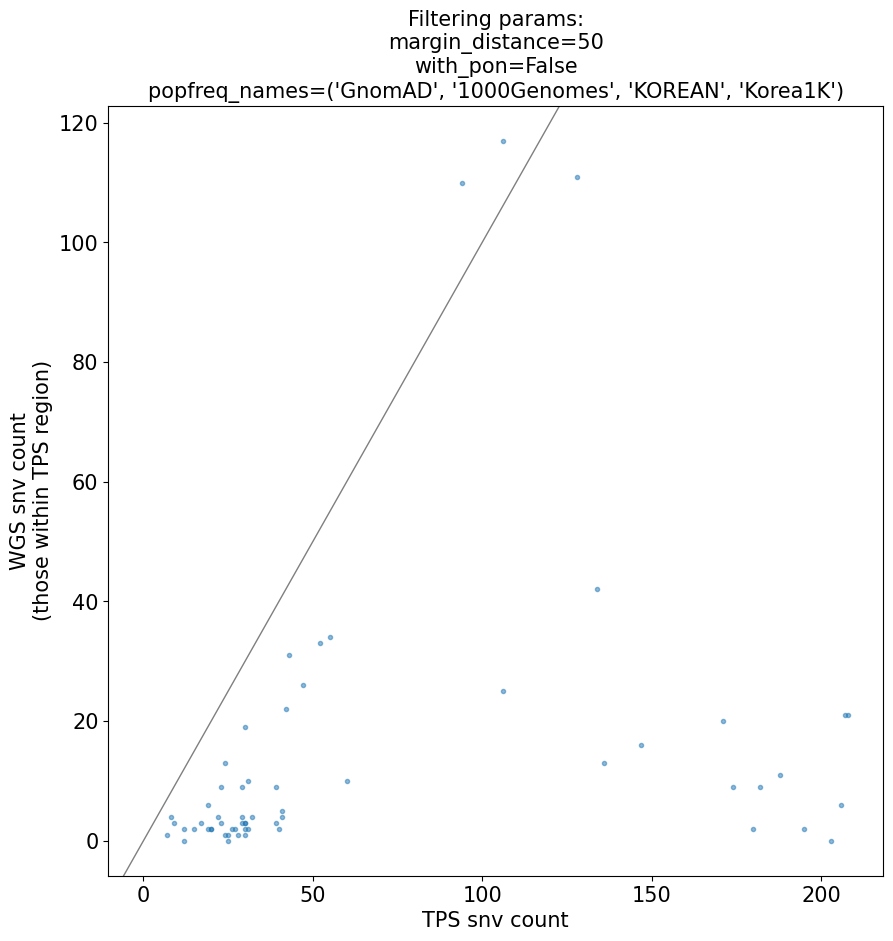

In [58]:
filtered_tps_vplists_snv_popfreq = draw_tmb_comparison(filtered_tps_vplists_snv=None, margin_distance=50, with_pon=False, popfreq_names=("GnomAD", "1000Genomes", "KOREAN", "Korea1K"))

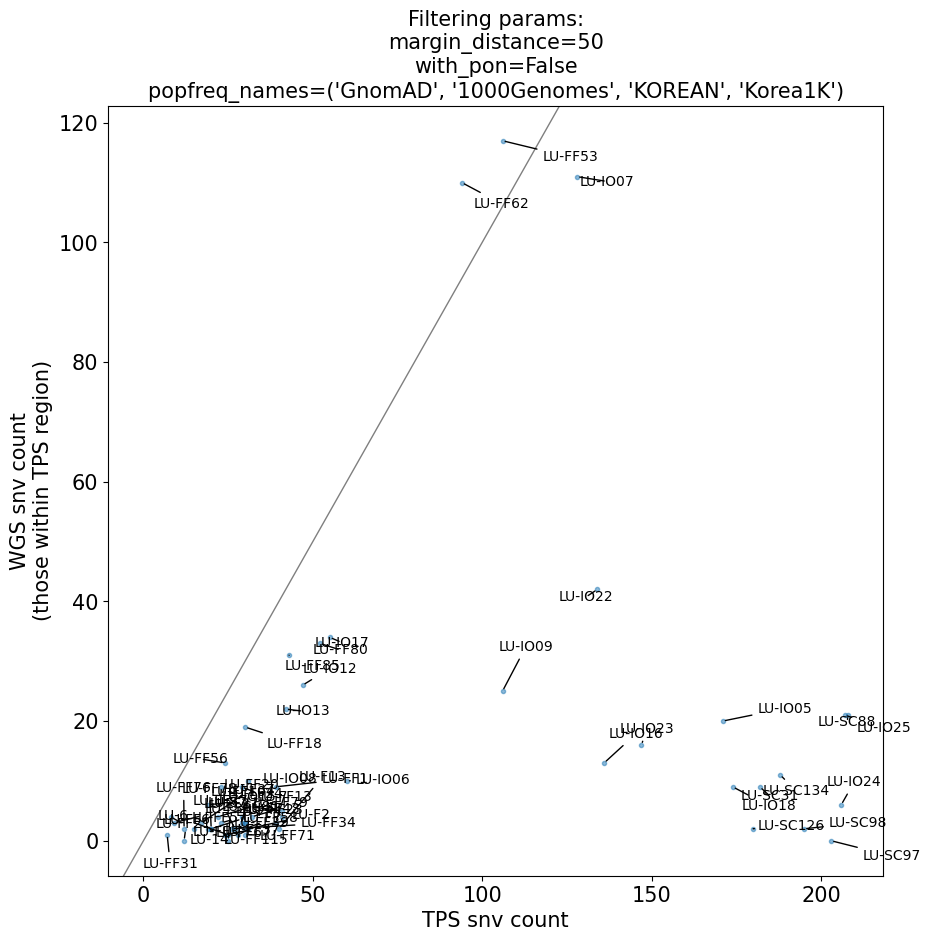

In [72]:
draw_tmb_comparison(filtered_tps_vplists_snv=filtered_tps_vplists_snv_popfreq, annotate=True, margin_distance=50, with_pon=False, popfreq_names=("GnomAD", "1000Genomes", "KOREAN", "Korea1K"))

LU-14
LU-6
LU-87
LU-F13
LU-F2
LU-F33
LU-F37
LU-FF1
LU-FF104
LU-FF115
LU-FF13
LU-FF18
LU-FF20
LU-FF21
LU-FF23
LU-FF24
LU-FF27
LU-FF3
LU-FF31
LU-FF34
LU-FF37
LU-FF39
LU-FF4
LU-FF43
LU-FF53
LU-FF56
LU-FF57
LU-FF58
LU-FF6
LU-FF62
LU-FF67
LU-FF71
LU-FF76
LU-FF77
LU-FF78
LU-FF79
LU-FF80
LU-FF85
LU-IO05
LU-IO06
LU-IO07
LU-IO08
LU-IO09
LU-IO12
LU-IO13
LU-IO15
LU-IO16
LU-IO17
LU-IO18
LU-IO22
LU-IO23
LU-IO24
LU-IO25
LU-SC126
LU-SC134
LU-SC31
LU-SC81
LU-SC88
LU-SC97
LU-SC98


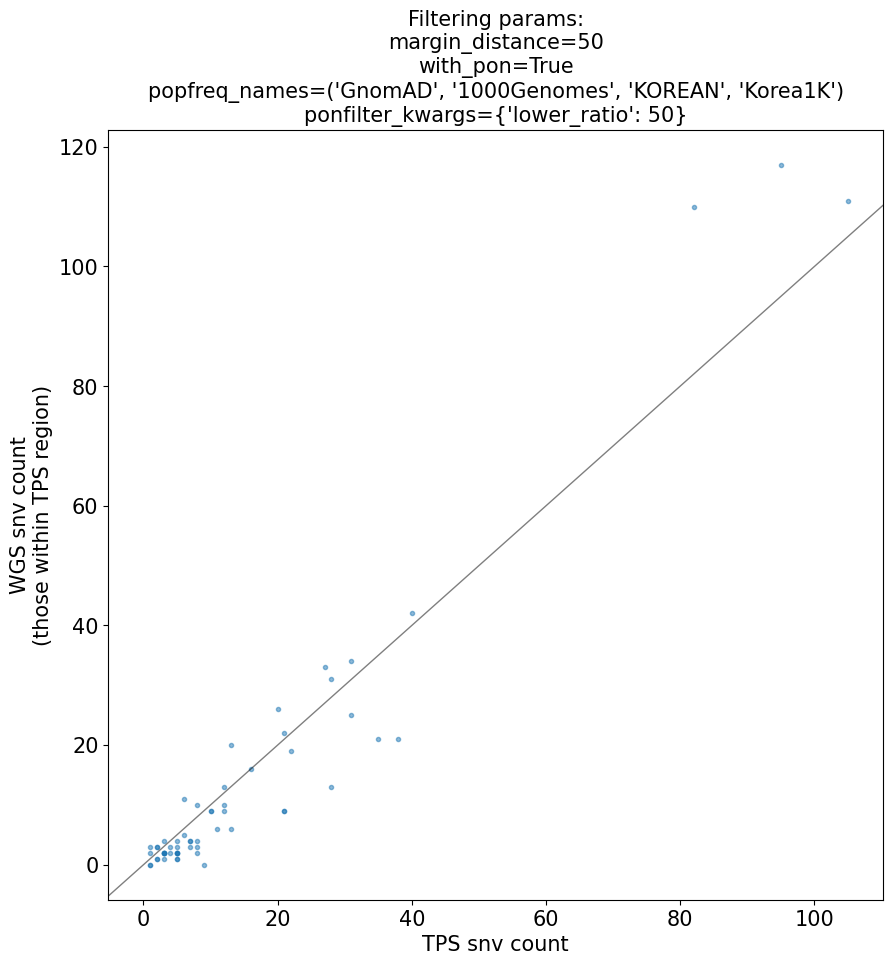

In [67]:
filtered_tps_vplists_snv_popfreq_pon = draw_tmb_comparison(
    filtered_tps_vplists_snv=None, annotate=False,
    margin_distance=50, with_pon=True, popfreq_names=("GnomAD", "1000Genomes", "KOREAN", "Korea1K"), ponfilter_kwargs=dict(lower_ratio=50),
)

LU-14
LU-6
LU-87
LU-F13
LU-F2
LU-F33
LU-F37
LU-FF1
LU-FF104
LU-FF115
LU-FF13
LU-FF18
LU-FF20
LU-FF21
LU-FF23
LU-FF24
LU-FF27
LU-FF3
LU-FF31
LU-FF34
LU-FF37
LU-FF39
LU-FF4
LU-FF43
LU-FF53
LU-FF56
LU-FF57
LU-FF58
LU-FF6
LU-FF62
LU-FF67
LU-FF71
LU-FF76
LU-FF77
LU-FF78
LU-FF79
LU-FF80
LU-FF85
LU-IO05
LU-IO06
LU-IO07
LU-IO08
LU-IO09
LU-IO12
LU-IO13
LU-IO15
LU-IO16
LU-IO17
LU-IO18
LU-IO22
LU-IO23
LU-IO24
LU-IO25
LU-SC126
LU-SC134
LU-SC31
LU-SC81
LU-SC88
LU-SC97
LU-SC98


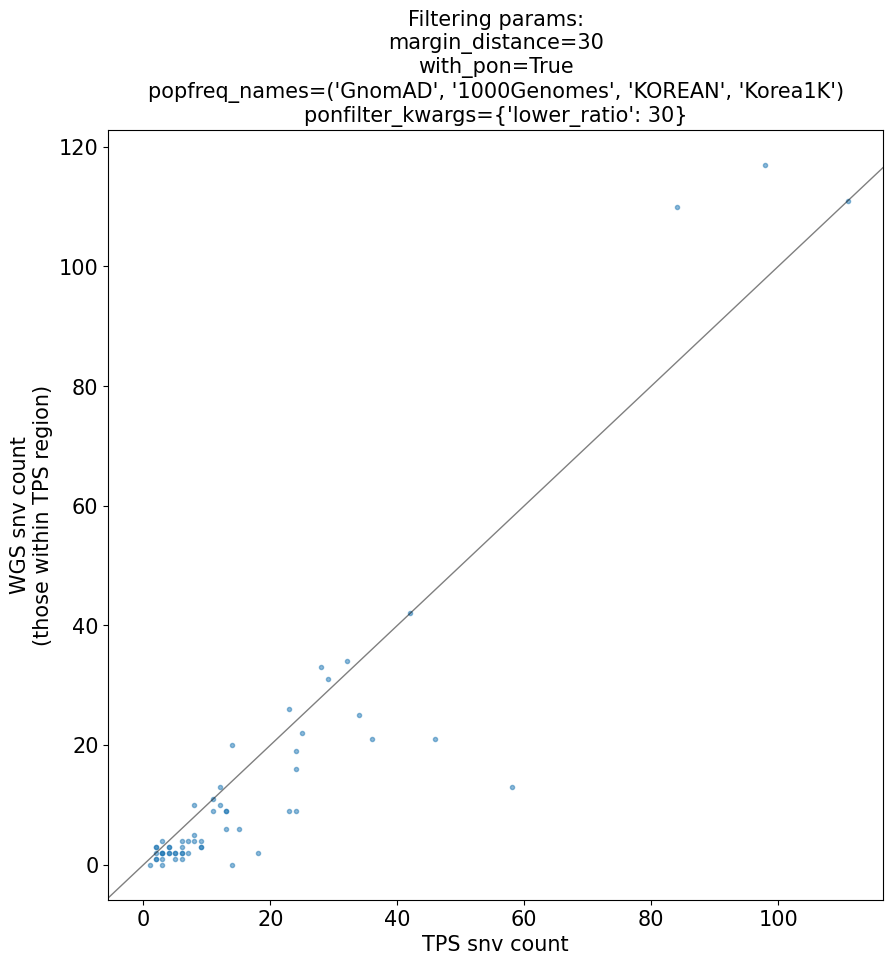

In [69]:
filtered_tps_vplists_snv_popfreq_pon_30 = draw_tmb_comparison(
    filtered_tps_vplists_snv=None, annotate=False,
    margin_distance=30, with_pon=True, popfreq_names=("GnomAD", "1000Genomes", "KOREAN", "Korea1K"), ponfilter_kwargs=dict(lower_ratio=30),
)

LU-14
LU-6
LU-87
LU-F13
LU-F2
LU-F33
LU-F37
LU-FF1
LU-FF104
LU-FF115
LU-FF13
LU-FF18
LU-FF20
LU-FF21
LU-FF23
LU-FF24
LU-FF27
LU-FF3
LU-FF31
LU-FF34
LU-FF37
LU-FF39
LU-FF4
LU-FF43
LU-FF53
LU-FF56
LU-FF57
LU-FF58
LU-FF6
LU-FF62
LU-FF67
LU-FF71
LU-FF76
LU-FF77
LU-FF78
LU-FF79
LU-FF80
LU-FF85
LU-IO05
LU-IO06
LU-IO07
LU-IO08
LU-IO09
LU-IO12
LU-IO13
LU-IO15
LU-IO16
LU-IO17
LU-IO18
LU-IO22
LU-IO23
LU-IO24
LU-IO25
LU-SC126
LU-SC134
LU-SC31
LU-SC81
LU-SC88
LU-SC97
LU-SC98


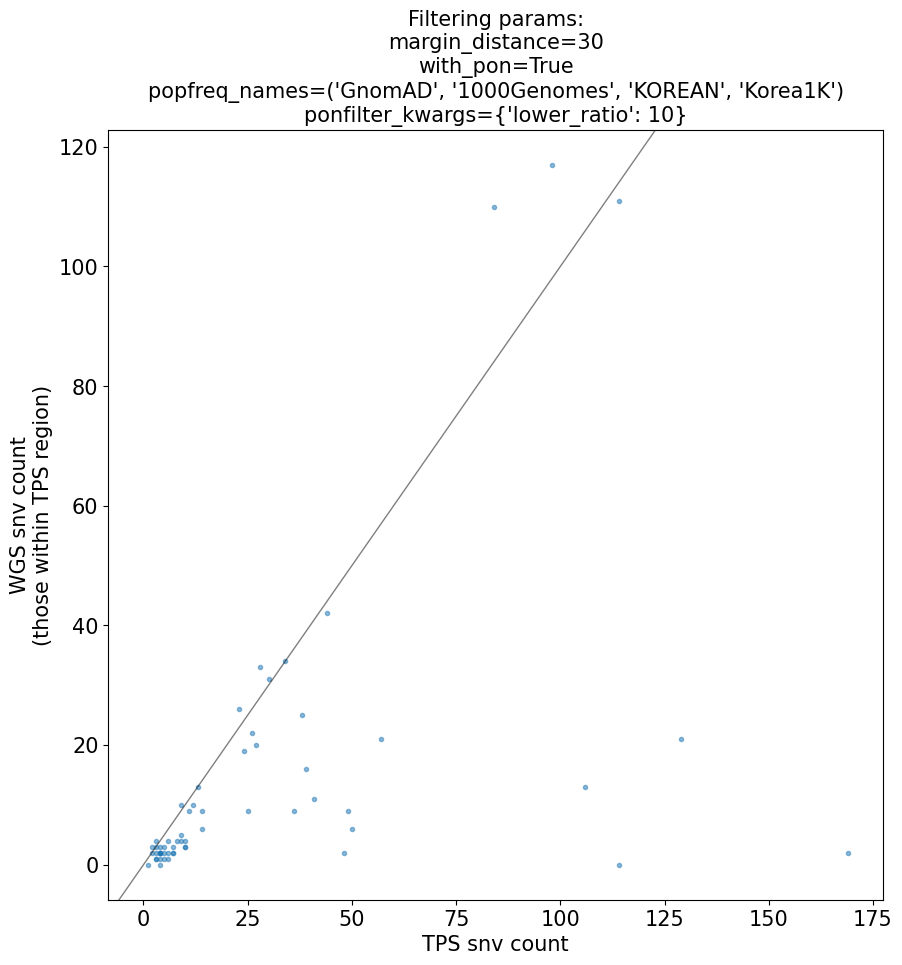

In [70]:
filtered_tps_vplists_snv_popfreq_pon_10 = draw_tmb_comparison(
    filtered_tps_vplists_snv=None, annotate=False,
    margin_distance=30, with_pon=True, popfreq_names=("GnomAD", "1000Genomes", "KOREAN", "Korea1K"), ponfilter_kwargs=dict(lower_ratio=10),
)

##### Make TMB plots

In [210]:
import handygenome.analysis.feature as libfeature
geneset_gr = libfeature.get_geneset_gr('hg19')

In [273]:
coding_region_gr = geneset_gr[geneset_gr.protein_id.notna()].merge()
CODING_REGION_LENGTH = coding_region_gr.length
PANEL_CODING_REGION_LENGTH = PANEL_REGION_GR.intersect(coding_region_gr).length

In [351]:
tps_tmbs_panelregion = {
    sid: 10**6 * (
        (
            len(filtered_tps_vplists_snv_popfreq_pon[sid]) 
            + len(filtered_tps_vplists_indel[sid])
        )
        / PANEL_REGION_LENGTH 
    )
    for sid in SAMPLEIDS_LU
}
wgs_tmbs_panelregion = {
    sid: 10**6 * (
        (
            len(PREVIOUS_WGS_REANNOT_VCF_SNV[sid].isec(PANEL_REGION_GR)) 
            + len(PREVIOUS_WGS_REANNOT_VCF_INDEL[sid].isec(PANEL_REGION_GR))
        )
        / PANEL_REGION_LENGTH 
    )
    for sid in SAMPLEIDS_LU
}

In [353]:
wgs_tmbs_wholeregion = {
    sid: 10**6 * (
        (
            len(PREVIOUS_WGS_REANNOT_VCF_SNV[sid]) 
            + len(PREVIOUS_WGS_REANNOT_VCF_INDEL[sid])
        )
        / WHOLE_GENOME_LENGTH 
    )
    for sid in SAMPLEIDS_LU
}

In [354]:
tps_tmbs_codingregion = {
    sid: 10**6 * (
        (
            len(filtered_tps_vplists_snv_popfreq_pon[sid].isec(coding_region_gr)) 
            + len(filtered_tps_vplists_indel[sid].isec(coding_region_gr))
        )
        / PANEL_CODING_REGION_LENGTH 
    )
    for sid in SAMPLEIDS_LU
}
wgs_tmbs_codingregion = {
    sid: 10**6 * (
        (
            len(PREVIOUS_WGS_REANNOT_VCF_SNV[sid].isec(coding_region_gr)) 
            + len(PREVIOUS_WGS_REANNOT_VCF_INDEL[sid].isec(coding_region_gr))
        )
        / CODING_REGION_LENGTH 
    )
    for sid in SAMPLEIDS_LU
}

In [355]:
def vpfilter(vp):
    return any(x['consequence_flags']['protein_altering'] for x in vp.transcript[0].values())

tps_tmbs_codingregion_proteinalter = {
    sid: 10**6 * (
        (
            len(filtered_tps_vplists_snv_popfreq_pon[sid].isec(coding_region_gr).filter(vpfilter))
            + len(filtered_tps_vplists_indel[sid].isec(coding_region_gr).filter(vpfilter))
        )
        / PANEL_CODING_REGION_LENGTH 
    )
    for sid in SAMPLEIDS_LU
}
wgs_tmbs_codingregion_proteinalter = {
    sid: 10**6 * (
        (
            len(PREVIOUS_WGS_REANNOT_VCF_SNV[sid].isec(coding_region_gr).filter(vpfilter))
            + len(PREVIOUS_WGS_REANNOT_VCF_INDEL[sid].isec(coding_region_gr).filter(vpfilter))
        )
        / CODING_REGION_LENGTH 
    )
    for sid in SAMPLEIDS_LU
}

In [407]:
tmb_dicts = {
    'WGS - panel region': wgs_tmbs_panelregion,
    'WGS - whole genome': wgs_tmbs_wholeregion,
    'WGS - coding region': wgs_tmbs_codingregion,
    'WGS - protein altering': wgs_tmbs_codingregion_proteinalter,

    'TPS': tps_tmbs_panelregion,
    'TPS - coding region': tps_tmbs_codingregion,
    'TPS - protein altering': tps_tmbs_codingregion_proteinalter,
}

(0.0, 1.0, 0.0, 1.0)

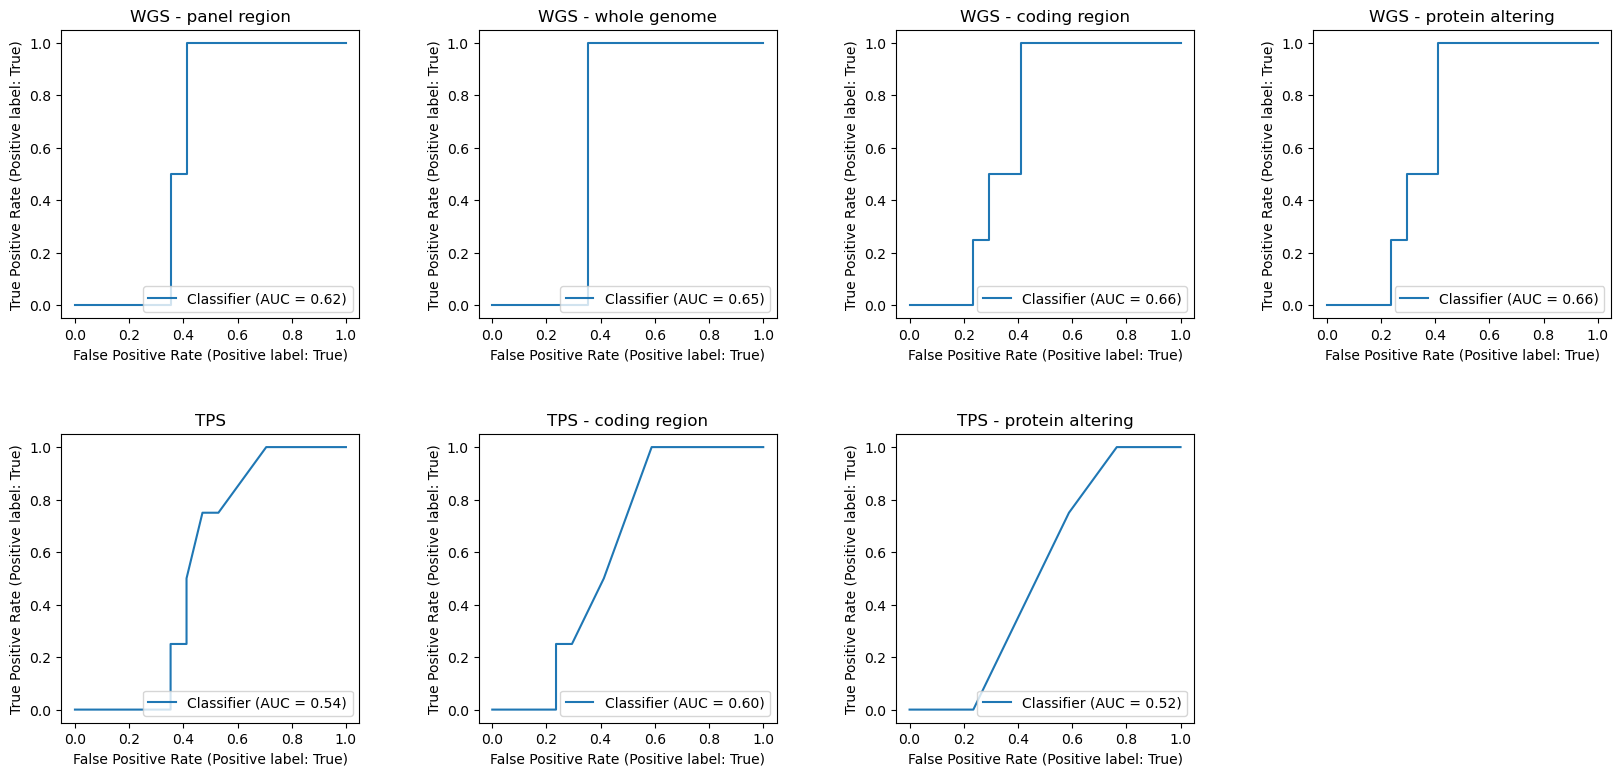

In [410]:
def draw_roc(ax, tmbdict, title):
    sids_subset = [x for x in SAMPLEIDS_LU if IO_RESPONSE[x] is not None]
    y = [(IO_RESPONSE[sid] == 'PR') for sid in sids_subset]
    pred = [tmbdict[sid] for sid in sids_subset]

    # fpr, tpr, thresholds = sklearn.metrics.roc_curve(y, pred, pos_label=True)
    # roc_auc = sklearn.metrics.auc(fpr, tpr)
    ax.set_title(title)
    display = sklearn.metrics.RocCurveDisplay.from_predictions(y, pred, pos_label=True, ax=ax)
    

fig, axs = plt.subplots(2, 4, figsize=(20, 9), gridspec_kw=dict(hspace=0.4, wspace=0.4))
for idx, (key, val) in enumerate(tmb_dicts.items()):
    draw_roc(axs.flat[idx], val, key)
axs.flat[-1].axis('off')

In [446]:
def make_tmb_plot(tps_tmb_dict, wgs_tmb_dict, title, annotate=False, annotate_io_only=False, scatter=False, scatter_coloronly=False):
    # set params
    # xs = [len(filtered_tps_vplists_snv[sid]) for sid in SAMPLEIDS_LU]
    # ys = [wgs_panelregion_counts_snv[sid] for sid in SAMPLEIDS_LU]
    xs = np.array([tps_tmb_dict[sid] for sid in SAMPLEIDS_LU])
    ys = np.array([wgs_tmb_dict[sid] for sid in SAMPLEIDS_LU])
    cellularities = np.array([PREVIOUS_PURITY[sid] for sid in SAMPLEIDS_LU])
    sizes = cellularities * 60
    
    colordic = {None: 'gray', 'PR': 'blue', 'SD': 'orange', 'PD': 'red'}
    colors = np.array([colordic[IO_RESPONSE[sid]] for sid in SAMPLEIDS_LU])
    
    smoking_indexes = {
        'yes': [SMOKING[sid] is True for sid in SAMPLEIDS_LU],
        'no': [SMOKING[sid] is False for sid in SAMPLEIDS_LU],
        'unknown': [SMOKING[sid] is None for sid in SAMPLEIDS_LU],
    }
    markerdic = {'yes': 'o', 'no': 'x', 'unknown': '^'}
    
    alpha = 0.3

    # make fig
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # set limits
    maxval = max(xs.max(), ys.max())
    ax.set_xlim(-1, maxval * 1.1)
    ax.set_ylim(-1, maxval * 1.1)
    ax.set_aspect('equal')
        
    # draw
    ax.axline((0, 0), slope=1, color='k', alpha=0.5, linewidth=1)
    if scatter:
        for key, val in smoking_indexes.items():
            ax.scatter(xs[val], ys[val], s=sizes[val], marker=markerdic[key], c=colors[val], alpha=alpha)
    elif scatter_coloronly:
        ax.scatter(xs, ys, marker='o', c=colors, alpha=alpha)
    else:
        ax.plot(xs, ys, linestyle='', marker='o', markersize=3, alpha=alpha)

    # regression line
    regress = sklearn.linear_model.LinearRegression().fit(xs[:, None], ys)
    new_xs = np.linspace(xs.min(), xs.max(), 50)
    new_ys = regress.predict(new_xs[:, None])
    ax.plot(new_xs, new_ys, color='tab:orange')

    # annotation texts
    if annotate:
        xwidth = ax.get_xlim()[1] - ax.get_xlim()[0]
        ywidth = ax.get_ylim()[1] - ax.get_ylim()[0]
        for sid, x, y in zip(SAMPLEIDS_LU, xs, ys):
            if annotate_io_only:
                if not sid.startswith('LU-IO'):
                    continue
            jitterx = xwidth * np.random.normal(0, 0.1, 1)[0]
            jittery = ywidth * np.random.normal(0, 0.1, 1)[0]
            ax.annotate(sid, (x, y), xytext=(x + jitterx, y + jittery), size=7, arrowprops=dict(width=0.2, headwidth=5, alpha=0.2), ha='center', va='center')

    # titles
    ax.set_xlabel('TPS TMB (mutations / 10^6 bp)', size=15)
    ax.set_ylabel('WGS TMB (mutations / 10^6 bp)', size=15)
    ax.tick_params(axis='both', labelsize=15)
    # ax.set_title('region: coding region\nmutation subset: none', size=15)
    ax.set_title(title, size=15)

    # legend
    if scatter_coloronly or scatter:
        handles = list()
        for key, val in colordic.items():
            if key is None:
                label = 'IO not done'
            else:
                label = key
            handles.append(ax.plot([], [], linestyle='', marker='o', color=val, label=label, alpha=alpha)[0])
        ax.legend(handles=handles)
    
    # others
    ax.grid()

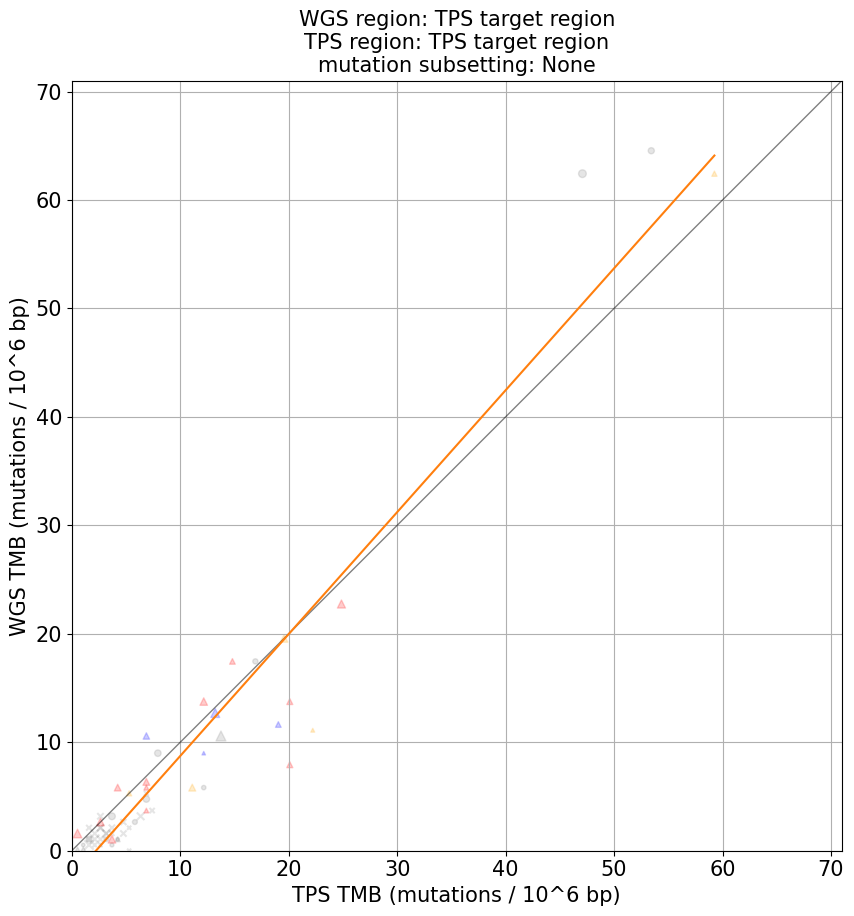

In [366]:
make_tmb_plot(
    tps_tmb_dict=tps_tmbs_panelregion, 
    wgs_tmb_dict=wgs_tmbs_panelregion, 
    title='\n'.join([
        'WGS region: TPS target region',
        'TPS region: TPS target region',
        'mutation subsetting: None'
    ]),
    annotate=False,
    annotate_io_only=False,
)

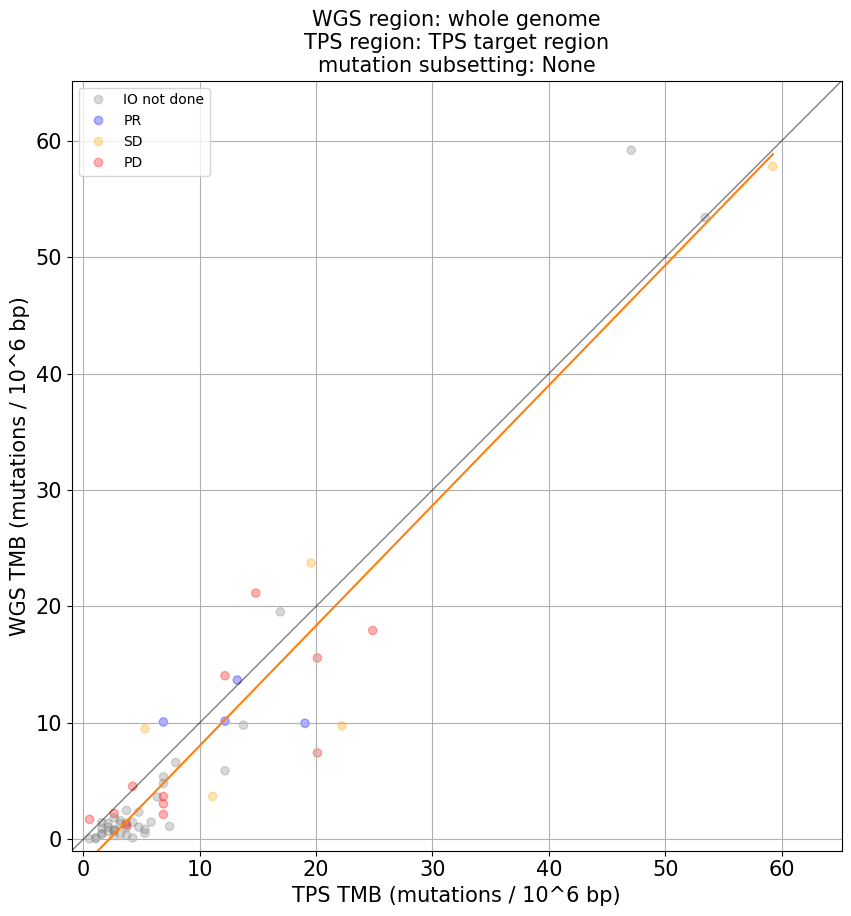

In [447]:
make_tmb_plot(
    tps_tmb_dict=tps_tmbs_panelregion, 
    wgs_tmb_dict=wgs_tmbs_wholeregion, 
    title='\n'.join([
        'WGS region: whole genome',
        'TPS region: TPS target region',
        'mutation subsetting: None'
    ]),
    annotate=False,
    annotate_io_only=False,
    scatter=False,
    scatter_coloronly=True,
)

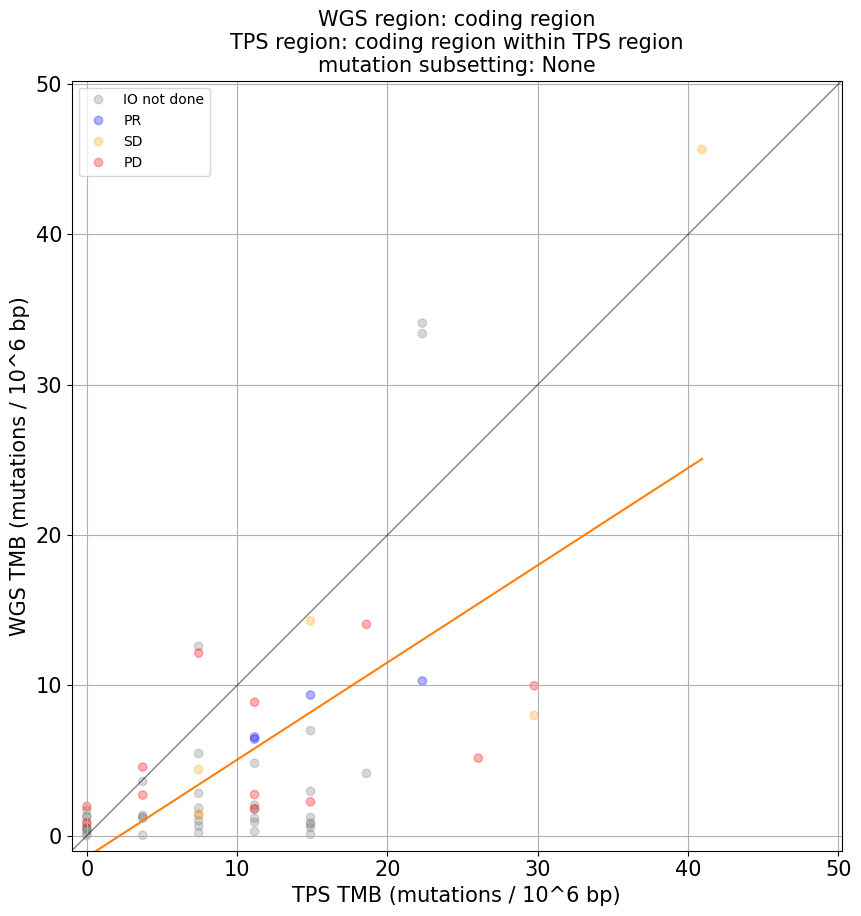

In [448]:
make_tmb_plot(
    tps_tmb_dict=tps_tmbs_codingregion, 
    wgs_tmb_dict=wgs_tmbs_codingregion, 
    title='\n'.join([
        'WGS region: coding region',
        'TPS region: coding region within TPS region',
        'mutation subsetting: None'
    ]),
    annotate=False,
    annotate_io_only=False,
    scatter=False,
    scatter_coloronly=True,
)

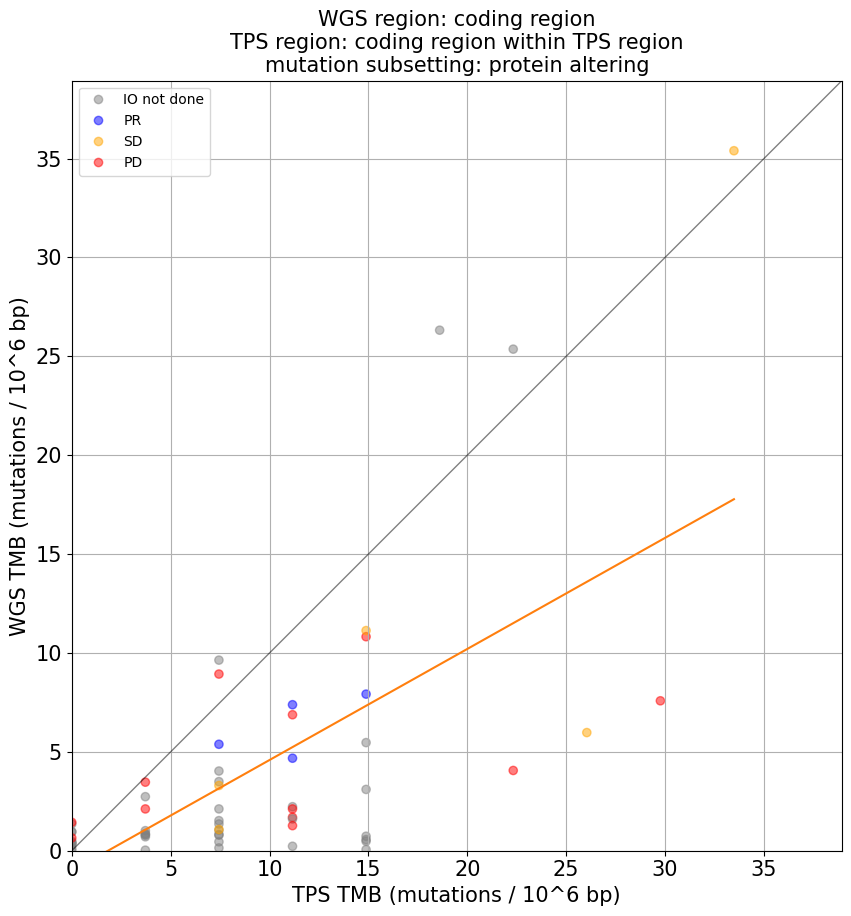

In [442]:
make_tmb_plot(
    tps_tmb_dict=tps_tmbs_codingregion_proteinalter, 
    wgs_tmb_dict=wgs_tmbs_codingregion_proteinalter, 
    title='\n'.join([
        'WGS region: coding region',
        'TPS region: coding region within TPS region',
        'mutation subsetting: protein altering'
    ]),
    annotate=False,
    annotate_io_only=False,
    scatter=False,
    scatter_coloronly=True,
)

In [1878]:
sid = 'LU-IO16'
sid_panel = sid + '_panel'

In [1842]:
filtered_vplist = PREVIOUS_WGS_REANNOT_VCF_SNV[sid].isec(PANEL_REGION_GR)
for vp in filtered_vplist:
    vp.update_readstats(bam_dict={sid_panel: BAMS['panel'][sid]})

In [1881]:
filtered_vplist = get_filtered_panel_vplist(panel_snv_vplist, sid, margin_distance=50, cutoff_totalcount=30, cutoff_unifpval=None, ponfilter_kwargs=dict(lower_ratio=50))
print(len(filtered_vplist))

28


In [1706]:
filtered_filtered_vplist = filtered_vplist.filter(lambda x: x.readstats['LU-IO16_panel']['varpos_uniform_pvalues'][1] > 0.10)
print(len(filtered_filtered_vplist))
vp = filtered_filtered_vplist.sample()

27


In [1846]:
tpsfilter = libfilter.get_preset_filter_panelseq(with_pon=False, pon_samples=PON_SAMPLES, refver='hg19', cutoff_totalcount=30, cutoff_unifpval=0.05, ponfilter_kwargs=dict(lower_ratio=20))
vp = filtered_vplist.filter(lambda x: not tpsfilter.check(x, sid_panel)).sample()

In [1848]:
tpsfilter.check_show(vp, sid_panel)

True    <DiffMeanBQFilter ({'cutoff': -5})>
True    <AbsMeanBQFilter ({'cutoff': 20})>
True    <DiffMeanMQFilter ({'cutoff': -15})>
True    <AbsMeanMQFilter ({'cutoff': 40})>
True    <ClipoverlapFilter ({'cutoff': 1})>
True    <AbsCliplenFilter ({'cutoff': 20})>
True    <ReadcountFilter ({'cutoff': 2})>
True    <OthercountRatioFilter ({'cutoff': 1.5, 'ref_length_cutoff': 4})>
True    <TotaldepthGTFilter ({'cutoff': 30})>
False    <VarposUniformFilter ({'cutoff': 0.05})>
True    <PopfreqFilter ({'popnames': ('GnomAD', '1000Genomes', 'KOREAN', 'Korea1K'), 'cutoff': 0.01})>


In [1855]:
load_bams(sid)
show_vp_igv(vp, sid)

OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK


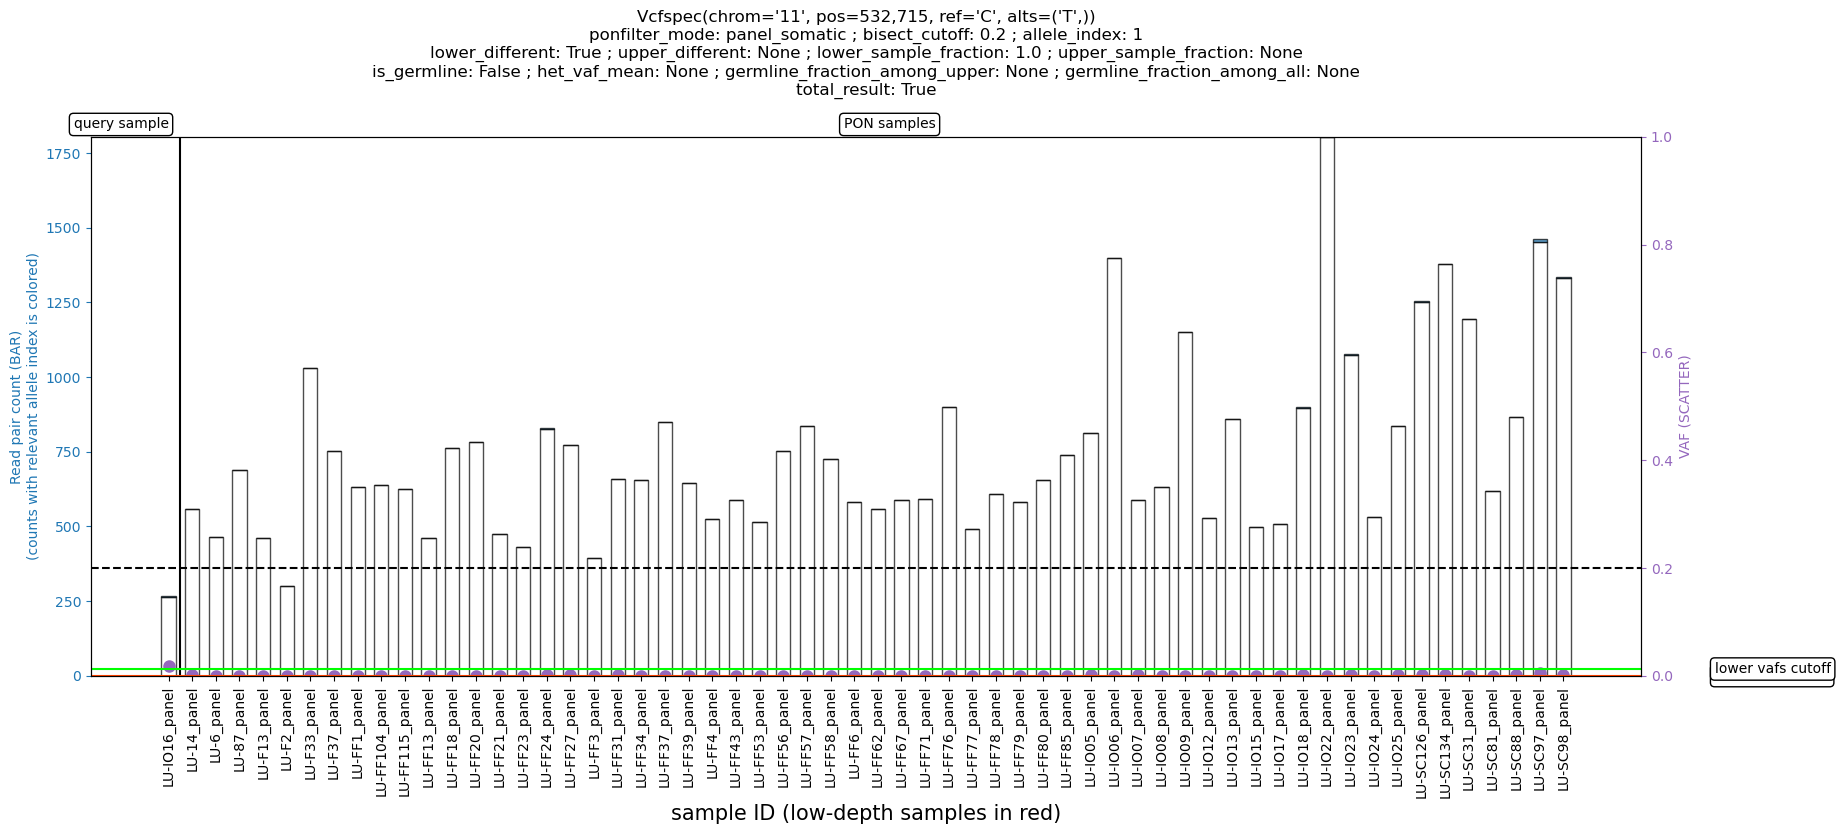

In [1813]:
vp.show_pon(query_sample=(sid + '_panel'), pon_samples=PON_SAMPLES, ponfilter_mode='panel_somatic', zoom_lower=False, lower_ratio=30)

/home/users/pjh/tools/miniconda/221104/miniconda3/envs/genome_v7/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/221104/miniconda3/envs/genome_v7/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: max() arg is an empty sequence

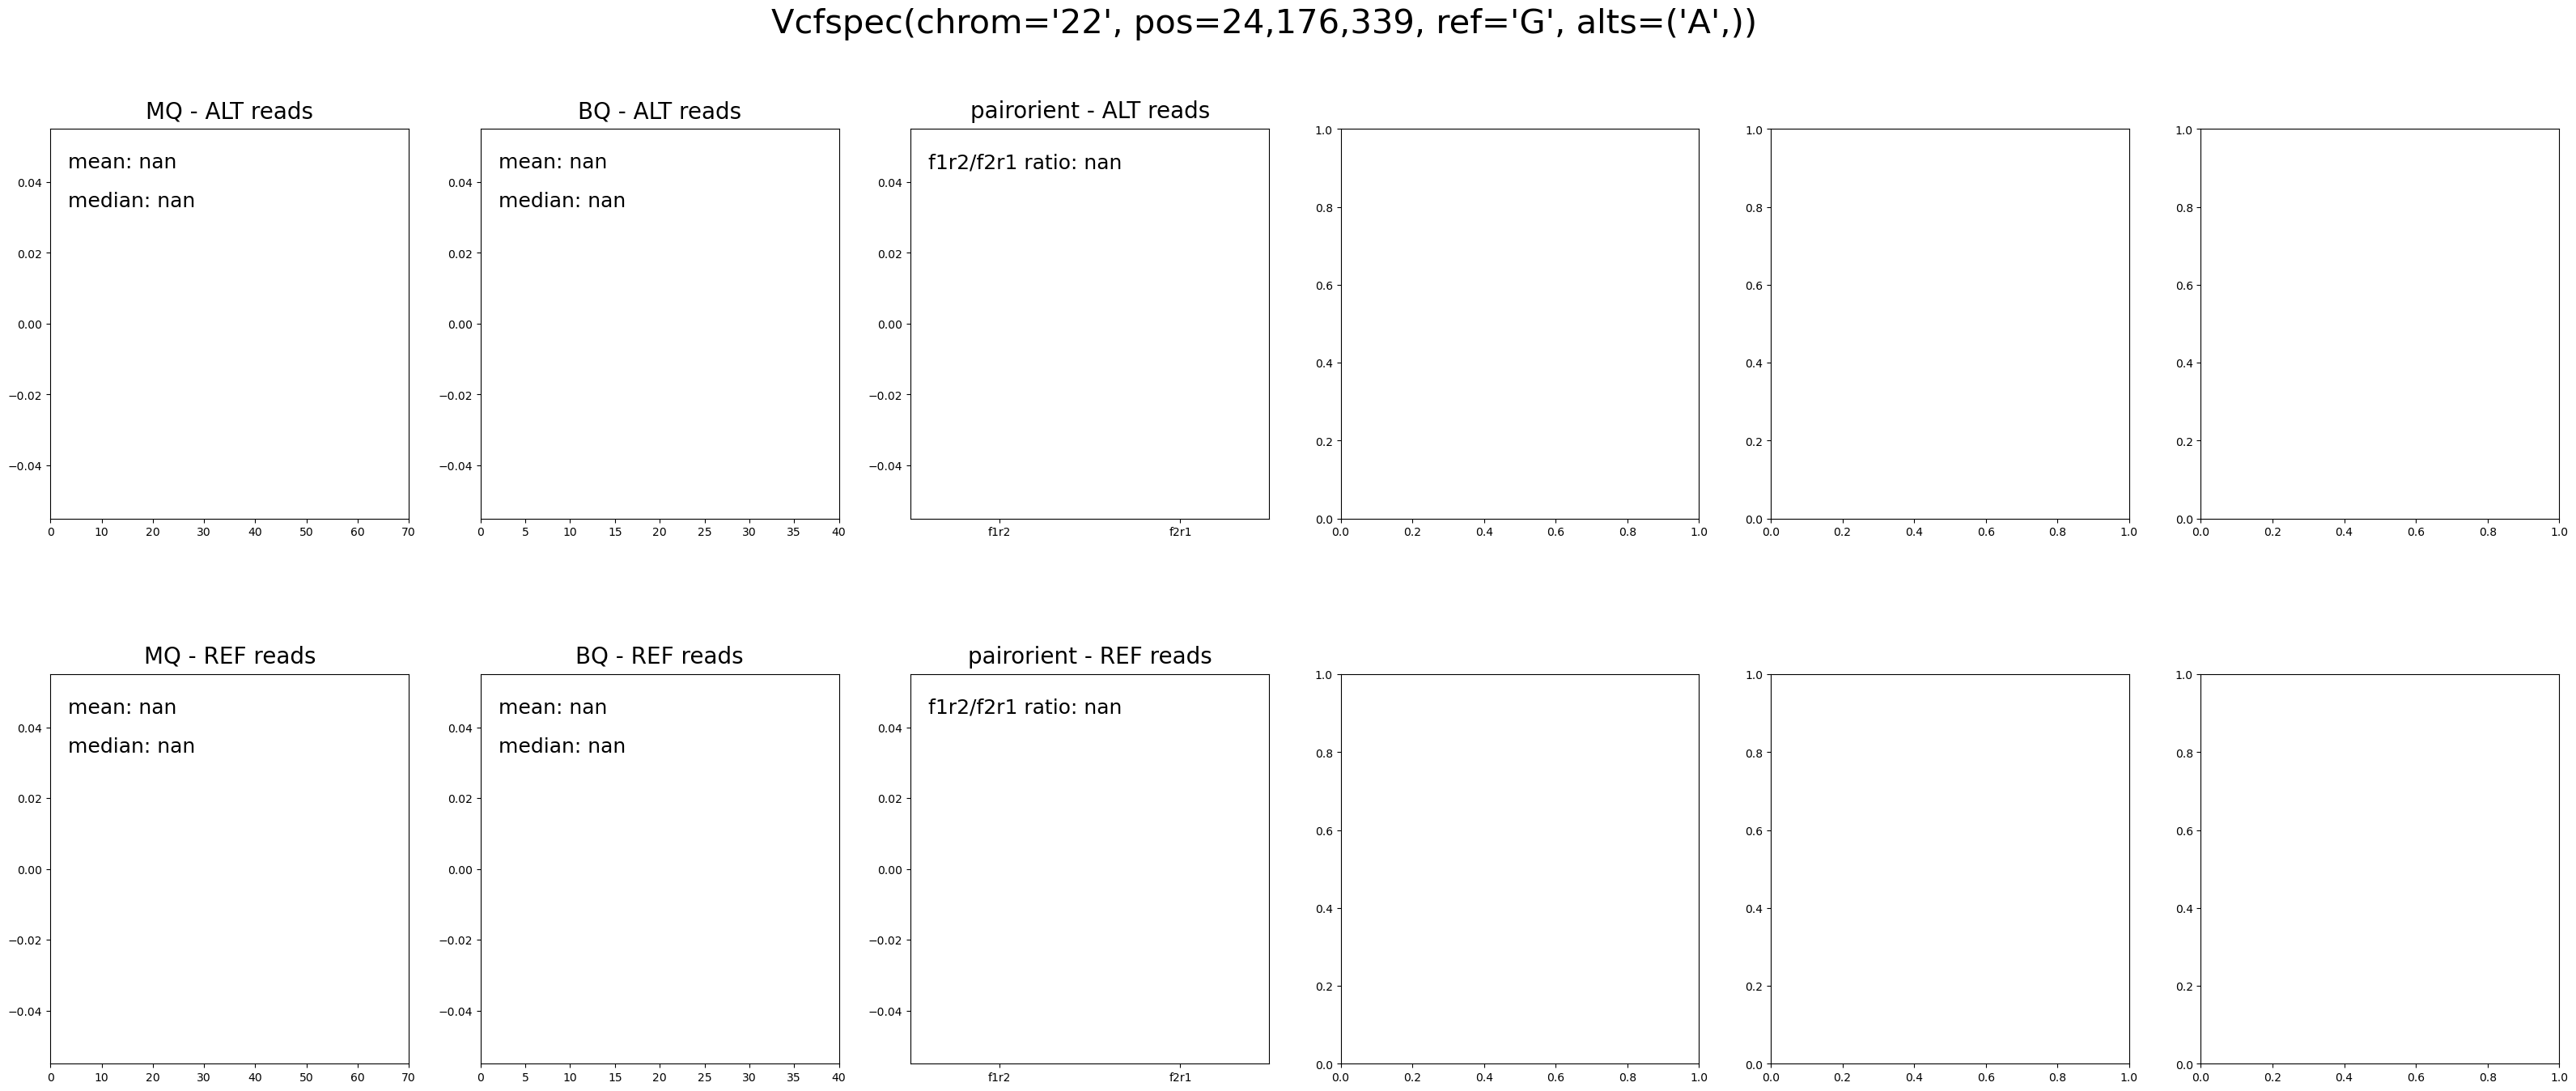

In [1724]:
vp.show_readstats_data(BAMS['panel'][sid])

In [1687]:
vp.readstats['LU-IO16_panel']

<ReadStats(
    {'rppcounts': {None: 3, -1: 0, 0: 48, 1: 5, 'softclip_overlap': 3},
     'mean_BQs': {None: nan, -1: nan, 0: 26.186046511627907, 1: 33.55555555555556},
     'median_BQs': {None: nan, -1: nan, 0: 26.0, 1: 34.0},
     'mean_MQs': {None: 60.0, -1: nan, 0: 60.0, 1: 58.0},
     'median_MQs': {None: 60.0, -1: nan, 0: 60.0, 1: 60.0},
     'mean_cliplens': {None: 48.666666666666664,
                       -1: nan,
                       0: 1.7291666666666667,
                       1: 12.6},
     'median_cliplens': {None: 49.0, -1: nan, 0: 0.0, 1: 0.0},
     'varpos_uniform_pvalues': {None: nan,
                                -1: nan,
                                0: 3.404605916557218e-30,
                                1: 0.0050942656492380676},
     'mean_varpos_fractions': {None: nan,
                               -1: nan,
                               0: 0.8204366989429549,
                               1: 0.7777254410142809},
     'median_varpos_fractions': {None: n

# Scratches

In [38]:
set(SAMPLEIDS_LU).difference(MAIN_DRIVERS.keys())
    

{'LU-FF1',
 'LU-FF18',
 'LU-FF27',
 'LU-FF79',
 'LU-FF80',
 'LU-IO09',
 'LU-IO12',
 'LU-IO13',
 'LU-IO16',
 'LU-IO17',
 'LU-IO18',
 'LU-IO23',
 'LU-IO25',
 'LU-SC134',
 'LU-SC88'}

In [72]:
for sid in sorted({'LU-FF1',
 'LU-FF18',
 'LU-FF27',
 'LU-FF79',
 'LU-FF80',
 'LU-IO09',
 'LU-IO12',
 'LU-IO13',
 'LU-IO16',
 'LU-IO17',
 'LU-IO18',
 'LU-IO23',
 'LU-IO25',
 'LU-SC134',
 'LU-SC88'}):
    print(sid)
    print('putative')
    for vp in PUTATIVE_DRIVERS[sid]:
        present_wgs = check_present_wgs(vp, sid, 1)
        present_tps = check_present_panel(vp, sid, 1)
        is_tps_gene = bool(panel_genes_all.intersection(vp.get_gene_names()))
        print(f'wgs: {present_wgs}', f'tps: {present_tps}', f'tps gene: {is_tps_gene}', vp, sep='\t')

    print()

    print('targetable')
    for vp in TARGETABLE_DRIVERS[sid]:
        present_wgs = check_present_wgs(vp, sid, 1)
        present_tps = check_present_panel(vp, sid, 1)
        is_tps_gene = bool(panel_genes_all.intersection(vp.get_gene_names()))
        print(f'wgs: {present_wgs}', f'tps: {present_tps}', f'tps gene: {is_tps_gene}', vp, sep='\t')
    print()
    print()

LU-FF1
putative
wgs: True	tps: True	tps gene: True	<VariantPlus(vcfspec=Vcfspec(chrom='17', pos=7,577,097, ref='C', alts=('A',)), alteration=(alt_index 0: TP53 D281Y))>
wgs: False	tps: True	tps gene: True	<VariantPlus(vcfspec=Vcfspec(chrom='19', pos=10,602,443, ref='C', alts=('T',)), alteration=(alt_index 0: KEAP1 G379S))>
wgs: True	tps: True	tps gene: True	<VariantPlus(vcfspec=Vcfspec(chrom='19', pos=10,610,400, ref='TG', alts=('T',)), alteration=(alt_index 0: KEAP1 S104Afs*53))>
wgs: True	tps: True	tps gene: True	<VariantPlus(vcfspec=Vcfspec(chrom='19', pos=11,095,010, ref='TG', alts=('T',)), alteration=(alt_index 0: SMARCA4 G62Efs*32))>

targetable


LU-FF18
putative
wgs: True	tps: True	tps gene: True	<VariantPlus(vcfspec=Vcfspec(chrom='12', pos=49,426,019, ref='G', alts=('A',)), alteration=(alt_index 0: KMT2D Q4157*))>
wgs: True	tps: True	tps gene: True	<VariantPlus(vcfspec=Vcfspec(chrom='17', pos=7,578,236, ref='A', alts=('C',)), alteration=(alt_index 0: TP53 Y205D))>
wgs: True	tp

In [78]:
vp = PUTATIVE_DRIVERS['LU-IO17'][5]
show_vp_igv(vp, 'LU-IO17')

OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
